<a href="https://colab.research.google.com/github/liususan091219/FLAML-pub/blob/main/notebook/automl_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We will use [flaml.tune](https://microsoft.github.io/FLAML/docs/Use-Cases/Tune-User-Defined-Function) with the built in GPU in colab for the tuning. However, if you have a machine with more than 1 GPU, you can also use FLAML's [parallel tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#parallel-tuning) with the ray tune option. 

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `nlp,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,notebook,blendsearch];
```

In [2]:
%pip install flaml[nlp,notebook,blendsearch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 205 kB 19.6 MB/s 
     |████████████████████████████████| 2.0 MB 51.6 MB/s 
     |████████████████████████████████| 301 kB 61.3 MB/s 
     |████████████████████████████████| 43 kB 696 kB/s 
     |████████████████████████████████| 4.0 MB 11.8 MB/s 
     |████████████████████████████████| 365 kB 57.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 757 kB 64.6 MB/s 
     |████████████████████████████████| 158 kB 59.6 MB/s 
     |████████████████████████████████| 209 kB 65.5 MB/s 
     |████████████████████████████████| 81 kB 13.0 MB/s 
     |████████████████████████████████| 101 kB 14.8 MB/s 
     |████████████████████████████████| 880 kB 62.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 78 kB 9.8 MB/s 
     |██████████████████████████████

Let's run some examples. To use CoLab's built in GPU, you need to select Runtime -> Change runtime type and select GPU. Then you can print the device information using:

In [ ]:
import torch
print([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas()
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas()
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Take a look at the first 5 examples of this dataset:

In [ ]:
train_dataset.head(5)

sentence  label  idx
0       hide new secretions from the parental units       0    0
1               contains no wit , only labored gags       0    1
2  that loves its characters and communicates som...      1    2
3  remains utterly satisfied to remain the same t...      0    3
4  on the worst revenge-of-the-nerds clichés the ...      0    4

Separate the data into X and y:

In [ ]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

Now we can run AutoML with FLAML:

In [ ]:
from flaml import AutoML
automl = AutoML()


Let's will run FLAML for 30 mins. Here we will Electra's [small model](https://huggingface.co/google/electra-small-discriminator) for the tuning. We set gpu_per_trial to 1, and n_concurrent_trials to 1 (the number of trials running at the same time). Make sure gpu_per_trial * n_concurrent_trials does not exceed the GPU number you have. While running you can observe the resource usage (including the GPU) on the right. 

In [ ]:
TIME_BUDGET=1800
automl_settings = {
    "time_budget": TIME_BUDGET,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "model_path": "google/electra-small-discriminator",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        }
    },
    "gpu_per_trial": 1,                 # using 1 GPU for each trial
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": False,                   # If parallel tuning, set "use_ray" to {"local_dir": "data/output/"}
    "n_concurrent_trials": 1,           # How many trials to run at the same time, n_concurrent_trials * gpu_per_trial must not exceed the total number of GPUs
    "keep_search_state": True,          # keeping the search state
    "fp16": False                       # whether to use fp16, this option is True by default. 
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
[flaml.automl: 08-19 12:39:53] {2540} INFO - task = seq-classification
INFO:flaml.automl:task = seq-classification
[flaml.automl: 08-19 12:39:53] {2542} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 08-19 12:39:53] {2545} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 08-19 12:39:53] {2664} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 08-19 12:39:53] {2806} INFO - List of ML learners in AutoML Run: ['transformer']
INFO:flaml.automl:List of ML learners

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.5665, 'learning_rate': 4.6751863684771026e-06, 'epoch': 1.6}
{'eval_loss': 0.42372697591781616, 'eval_automl_metric': 0.1754587155963303, 'eval_runtime': 18.0363, 'eval_samples_per_second': 48.347, 'eval_steps_per_second': 48.347, 'epoch': 2.0}
{'eval_loss': 0.4013928174972534, 'eval_automl_metric': 0.16399082568807344, 'eval_runtime': 17.9262, 'eval_samples_per_second': 48.644, 'eval_steps_per_second': 48.644, 'epoch': 3.0}
{'train_runtime': 94.9281, 'train_samples_per_second': 316.029, 'train_steps_per_second': 9.892, 'train_loss': 0.48752916557466386, 'epoch': 3.0}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-39-56/train_06651f6e_1_s=9223372036854775807,e=1e-05,s=-1,s=3,e=32,d=20_2022-08-19_12-39-56/checkpoint-939/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-39-56/train_06651f6e_1_s=9223372036854775807,e=1e-05,s=-1,s=3,e=32,d=20_2022-08-19_12-39-56/checkpoint-939/vocab.txt
loading file data/output/train_2022-08-19_12-39-56/train_06651f6e_1_s=9223372036854775807,e=1e-05,s=-1,s=3,e=32,d=20_2022-08-19_12-39-56/checkpoint-939/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-39-56/train_06651f6e_1_s=9223372036854775807,e=1e-05,s=-1,s=3,e=32,d=20_2022-08-19_12-39-56/checkpoint-939/special_tokens_map.json
loading file data/output/train_2022-08-19_12-39-56/train_06651f6e_1_s=9223372036854775807,e=1e-05,s=-1,s=3,e=32,d=20_2022-08-19_12-39-56/checkpoint-939/tokenizer_config.json
[flaml.automl: 08-19 12:42:39] {3242} INF

{'eval_loss': 0.4843566119670868, 'eval_automl_metric': 0.18233944954128445, 'eval_runtime': 17.9478, 'eval_samples_per_second': 48.585, 'eval_steps_per_second': 48.585, 'epoch': 2.0}
{'eval_loss': 0.4618024230003357, 'eval_automl_metric': 0.17889908256880738, 'eval_runtime': 17.7543, 'eval_samples_per_second': 49.115, 'eval_steps_per_second': 49.115, 'epoch': 3.0}
{'train_runtime': 79.0146, 'train_samples_per_second': 379.677, 'train_steps_per_second': 5.961, 'train_loss': 0.5575582905180135, 'epoch': 3.0}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-42-39/train_68f84264_2_s=9223372036854775807,e=9.7119e-06,s=-1,s=3,e=64,d=14_2022-08-19_12-42-39/checkpoint-471/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-42-39/train_68f84264_2_s=9223372036854775807,e=9.7119e-06,s=-1,s=3,e=64,d=14_2022-08-19_12-42-39/checkpoint-471/vocab.txt
loading file data/output/train_2022-08-19_12-42-39/train_68f84264_2_s=9223372036854775807,e=9.7119e-06,s=-1,s=3,e=64,d=14_2022-08-19_12-42-39/checkpoint-471/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-42-39/train_68f84264_2_s=9223372036854775807,e=9.7119e-06,s=-1,s=3,e=64,d=14_2022-08-19_12-42-39/checkpoint-471/special_tokens_map.json
loading file data/output/train_2022-08-19_12-42-39/train_68f84264_2_s=9223372036854775807,e=9.7119e-06,s=-1,s=3,e=64,d=14_2022-08-19_12-42-39/checkpoint-471/tokenizer_config.json
[flaml.automl: 0

{'loss': 0.5778, 'learning_rate': 7.550901222797876e-06, 'epoch': 0.8}
{'loss': 0.3836, 'learning_rate': 4.805118959962285e-06, 'epoch': 1.6}
{'eval_loss': 0.37492236495018005, 'eval_automl_metric': 0.15596330275229353, 'eval_runtime': 17.9554, 'eval_samples_per_second': 48.565, 'eval_steps_per_second': 48.565, 'epoch': 2.0}
{'loss': 0.3399, 'learning_rate': 2.0593366971266936e-06, 'epoch': 2.4}
{'eval_loss': 0.37426331639289856, 'eval_automl_metric': 0.15252293577981646, 'eval_runtime': 17.6829, 'eval_samples_per_second': 49.313, 'eval_steps_per_second': 49.313, 'epoch': 2.75}
{'eval_loss': 0.37426331639289856, 'eval_automl_metric': 0.15252293577981646, 'eval_runtime': 17.8552, 'eval_samples_per_second': 48.837, 'eval_steps_per_second': 48.837, 'epoch': 2.75}
{'train_runtime': 147.7431, 'train_samples_per_second': 203.055, 'train_steps_per_second': 12.691, 'train_loss': 0.41996352413516624, 'epoch': 2.75}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-44-52/train_b86ac0ec_3_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_12-44-52/checkpoint-1721/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-44-52/train_b86ac0ec_3_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_12-44-52/checkpoint-1721/vocab.txt
loading file data/output/train_2022-08-19_12-44-52/train_b86ac0ec_3_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_12-44-52/checkpoint-1721/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-44-52/train_b86ac0ec_3_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_12-44-52/checkpoint-1721/special_tokens_map.json
loading file data/output/train_2022-08-19_12-44-52/train_b86ac0ec_3_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_12-44-52/checkpoint-1721/tokenizer_config.json
[flaml.auto

{'loss': 0.5362, 'learning_rate': 8.879996750213199e-06, 'epoch': 0.8}
{'eval_loss': 0.3863365054130554, 'eval_automl_metric': 0.1594036697247706, 'eval_runtime': 18.0173, 'eval_samples_per_second': 48.398, 'eval_steps_per_second': 48.398, 'epoch': 1.0}
{'loss': 0.3654, 'learning_rate': 2.959998916737733e-06, 'epoch': 1.6}
{'eval_loss': 0.37569329142570496, 'eval_automl_metric': 0.15596330275229353, 'eval_runtime': 17.864, 'eval_samples_per_second': 48.813, 'eval_steps_per_second': 48.813, 'epoch': 2.0}
{'train_runtime': 104.4336, 'train_samples_per_second': 191.509, 'train_steps_per_second': 11.969, 'train_loss': 0.42628197021484376, 'epoch': 2.0}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-48-14/train_30eeee8a_4_s=9223372036854775807,e=1.48e-05,s=-1,s=2,e=16,d=25_2022-08-19_12-48-14/checkpoint-1250/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-48-14/train_30eeee8a_4_s=9223372036854775807,e=1.48e-05,s=-1,s=2,e=16,d=25_2022-08-19_12-48-14/checkpoint-1250/vocab.txt
loading file data/output/train_2022-08-19_12-48-14/train_30eeee8a_4_s=9223372036854775807,e=1.48e-05,s=-1,s=2,e=16,d=25_2022-08-19_12-48-14/checkpoint-1250/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-48-14/train_30eeee8a_4_s=9223372036854775807,e=1.48e-05,s=-1,s=2,e=16,d=25_2022-08-19_12-48-14/checkpoint-1250/special_tokens_map.json
loading file data/output/train_2022-08-19_12-48-14/train_30eeee8a_4_s=9223372036854775807,e=1.48e-05,s=-1,s=2,e=16,d=25_2022-08-19_12-48-14/checkpoint-1250/tokenizer_config.json
[flaml.automl: 08-19 

{'loss': 0.6402, 'learning_rate': 5.730904302906456e-06, 'epoch': 0.8}
{'loss': 0.4537, 'learning_rate': 4.298178227179842e-06, 'epoch': 1.6}
{'loss': 0.3716, 'learning_rate': 2.865452151453228e-06, 'epoch': 2.4}
{'eval_loss': 0.4051010012626648, 'eval_automl_metric': 0.1651376146788991, 'eval_runtime': 17.6544, 'eval_samples_per_second': 49.393, 'eval_steps_per_second': 49.393, 'epoch': 2.49}
{'eval_loss': 0.4051010012626648, 'eval_automl_metric': 0.1651376146788991, 'eval_runtime': 17.9067, 'eval_samples_per_second': 48.697, 'eval_steps_per_second': 48.697, 'epoch': 2.49}
{'train_runtime': 121.0784, 'train_samples_per_second': 330.364, 'train_steps_per_second': 20.648, 'train_loss': 0.48428550303173984, 'epoch': 2.49}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-50-53/train_8f8d15ac_5_s=9223372036854775807,e=7.1636e-06,s=-1,s=4,e=16,d=27_2022-08-19_12-50-53/checkpoint-1555/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-50-53/train_8f8d15ac_5_s=9223372036854775807,e=7.1636e-06,s=-1,s=4,e=16,d=27_2022-08-19_12-50-53/checkpoint-1555/vocab.txt
loading file data/output/train_2022-08-19_12-50-53/train_8f8d15ac_5_s=9223372036854775807,e=7.1636e-06,s=-1,s=4,e=16,d=27_2022-08-19_12-50-53/checkpoint-1555/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-50-53/train_8f8d15ac_5_s=9223372036854775807,e=7.1636e-06,s=-1,s=4,e=16,d=27_2022-08-19_12-50-53/checkpoint-1555/special_tokens_map.json
loading file data/output/train_2022-08-19_12-50-53/train_8f8d15ac_5_s=9223372036854775807,e=7.1636e-06,s=-1,s=4,e=16,d=27_2022-08-19_12-50-53/checkpoint-1555/tokenizer_config.json
[flaml.auto

{'loss': 0.5223, 'learning_rate': 1.3121346786922505e-05, 'epoch': 0.8}
{'loss': 0.333, 'learning_rate': 8.349947955314322e-06, 'epoch': 1.6}
{'eval_loss': 0.3744150698184967, 'eval_automl_metric': 0.16169724770642202, 'eval_runtime': 17.7742, 'eval_samples_per_second': 49.06, 'eval_steps_per_second': 49.06, 'epoch': 2.0}
{'eval_loss': 0.37506288290023804, 'eval_automl_metric': 0.16169724770642202, 'eval_runtime': 17.8681, 'eval_samples_per_second': 48.802, 'eval_steps_per_second': 48.802, 'epoch': 2.0}
{'eval_loss': 0.37506288290023804, 'eval_automl_metric': 0.16169724770642202, 'eval_runtime': 17.8211, 'eval_samples_per_second': 48.931, 'eval_steps_per_second': 48.931, 'epoch': 2.0}
{'train_runtime': 122.1228, 'train_samples_per_second': 245.654, 'train_steps_per_second': 15.353, 'train_loss': 0.4039465510111442, 'epoch': 2.0}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-53-49/train_f81b7582_6_s=9223372036854775807,e=1.7893e-05,s=-1,s=3,e=16,d=32_2022-08-19_12-53-49/checkpoint-1250/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-53-49/train_f81b7582_6_s=9223372036854775807,e=1.7893e-05,s=-1,s=3,e=16,d=32_2022-08-19_12-53-49/checkpoint-1250/vocab.txt
loading file data/output/train_2022-08-19_12-53-49/train_f81b7582_6_s=9223372036854775807,e=1.7893e-05,s=-1,s=3,e=16,d=32_2022-08-19_12-53-49/checkpoint-1250/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-53-49/train_f81b7582_6_s=9223372036854775807,e=1.7893e-05,s=-1,s=3,e=16,d=32_2022-08-19_12-53-49/checkpoint-1250/special_tokens_map.json
loading file data/output/train_2022-08-19_12-53-49/train_f81b7582_6_s=9223372036854775807,e=1.7893e-05,s=-1,s=3,e=16,d=32_2022-08-19_12-53-49/checkpoint-1250/tokenizer_config.json
[flaml.auto

{'loss': 0.6593, 'learning_rate': 4.3452939856201385e-06, 'epoch': 0.8}
{'loss': 0.5039, 'learning_rate': 2.76518708175827e-06, 'epoch': 1.6}
{'eval_loss': 0.4479936957359314, 'eval_automl_metric': 0.17889908256880738, 'eval_runtime': 17.7389, 'eval_samples_per_second': 49.158, 'eval_steps_per_second': 49.158, 'epoch': 1.75}
{'eval_loss': 0.4479936957359314, 'eval_automl_metric': 0.17889908256880738, 'eval_runtime': 17.7616, 'eval_samples_per_second': 49.095, 'eval_steps_per_second': 49.095, 'epoch': 1.75}
{'train_runtime': 94.9275, 'train_samples_per_second': 316.031, 'train_steps_per_second': 19.752, 'train_loss': 0.5700681604383631, 'epoch': 1.75}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-56-45/train_61228d0e_7_s=9223372036854775807,e=5.9254e-06,s=-1,s=3,e=16,d=20_2022-08-19_12-56-45/checkpoint-1093/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-56-45/train_61228d0e_7_s=9223372036854775807,e=5.9254e-06,s=-1,s=3,e=16,d=20_2022-08-19_12-56-45/checkpoint-1093/vocab.txt
loading file data/output/train_2022-08-19_12-56-45/train_61228d0e_7_s=9223372036854775807,e=5.9254e-06,s=-1,s=3,e=16,d=20_2022-08-19_12-56-45/checkpoint-1093/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-56-45/train_61228d0e_7_s=9223372036854775807,e=5.9254e-06,s=-1,s=3,e=16,d=20_2022-08-19_12-56-45/checkpoint-1093/special_tokens_map.json
loading file data/output/train_2022-08-19_12-56-45/train_61228d0e_7_s=9223372036854775807,e=5.9254e-06,s=-1,s=3,e=16,d=20_2022-08-19_12-56-45/checkpoint-1093/tokenizer_config.json
[flaml.auto

{'loss': 0.4949, 'learning_rate': 1.624682269684853e-05, 'epoch': 0.8}
{'eval_loss': 0.4694325923919678, 'eval_automl_metric': 0.1651376146788991, 'eval_runtime': 17.7507, 'eval_samples_per_second': 49.125, 'eval_steps_per_second': 49.125, 'epoch': 1.43}
{'eval_loss': 0.4694325923919678, 'eval_automl_metric': 0.1651376146788991, 'eval_runtime': 17.6932, 'eval_samples_per_second': 49.285, 'eval_steps_per_second': 49.285, 'epoch': 1.43}
{'train_runtime': 83.8105, 'train_samples_per_second': 357.95, 'train_steps_per_second': 22.372, 'train_loss': 0.41831825990271515, 'epoch': 1.43}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_12-59-14/train_b9f0bd16_8_s=9223372036854775807,e=2.2155e-05,s=-1,s=3,e=16,d=24_2022-08-19_12-59-14/checkpoint-894/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_12-59-14/train_b9f0bd16_8_s=9223372036854775807,e=2.2155e-05,s=-1,s=3,e=16,d=24_2022-08-19_12-59-14/checkpoint-894/vocab.txt
loading file data/output/train_2022-08-19_12-59-14/train_b9f0bd16_8_s=9223372036854775807,e=2.2155e-05,s=-1,s=3,e=16,d=24_2022-08-19_12-59-14/checkpoint-894/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_12-59-14/train_b9f0bd16_8_s=9223372036854775807,e=2.2155e-05,s=-1,s=3,e=16,d=24_2022-08-19_12-59-14/checkpoint-894/special_tokens_map.json
loading file data/output/train_2022-08-19_12-59-14/train_b9f0bd16_8_s=9223372036854775807,e=2.2155e-05,s=-1,s=3,e=16,d=24_2022-08-19_12-59-14/checkpoint-894/tokenizer_config.json
[flaml.automl: 0

{'loss': 0.6603, 'learning_rate': 3.5093698220458912e-06, 'epoch': 0.8}
{'eval_loss': 0.5424174666404724, 'eval_automl_metric': 0.20068807339449546, 'eval_runtime': 17.639, 'eval_samples_per_second': 49.436, 'eval_steps_per_second': 49.436, 'epoch': 1.12}
{'eval_loss': 0.5424174666404724, 'eval_automl_metric': 0.20068807339449546, 'eval_runtime': 17.5693, 'eval_samples_per_second': 49.632, 'eval_steps_per_second': 49.632, 'epoch': 1.12}
{'train_runtime': 73.3443, 'train_samples_per_second': 409.03, 'train_steps_per_second': 25.564, 'train_loss': 0.6348177809321303, 'epoch': 1.12}


***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_13-01-31/train_0c00853c_9_s=9223372036854775807,e=4.7855e-06,s=-1,s=3,e=16,d=28_2022-08-19_13-01-31/checkpoint-702/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_13-01-31/train_0c00853c_9_s=9223372036854775807,e=4.7855e-06,s=-1,s=3,e=16,d=28_2022-08-19_13-01-31/checkpoint-702/vocab.txt
loading file data/output/train_2022-08-19_13-01-31/train_0c00853c_9_s=9223372036854775807,e=4.7855e-06,s=-1,s=3,e=16,d=28_2022-08-19_13-01-31/checkpoint-702/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_13-01-31/train_0c00853c_9_s=9223372036854775807,e=4.7855e-06,s=-1,s=3,e=16,d=28_2022-08-19_13-01-31/checkpoint-702/special_tokens_map.json
loading file data/output/train_2022-08-19_13-01-31/train_0c00853c_9_s=9223372036854775807,e=4.7855e-06,s=-1,s=3,e=16,d=28_2022-08-19_13-01-31/checkpoint-702/tokenizer_config.json
[flaml.automl: 0

{'loss': 0.569, 'learning_rate': 9.889055477492793e-06, 'epoch': 0.12}
{'loss': 0.3883, 'learning_rate': 9.481427469352118e-06, 'epoch': 0.24}
{'loss': 0.3417, 'learning_rate': 9.073799461211442e-06, 'epoch': 0.36}
{'loss': 0.3214, 'learning_rate': 8.666171453070765e-06, 'epoch': 0.48}
{'loss': 0.2934, 'learning_rate': 8.25854344493009e-06, 'epoch': 0.59}
{'loss': 0.2847, 'learning_rate': 7.850915436789415e-06, 'epoch': 0.71}
{'loss': 0.2737, 'learning_rate': 7.443287428648738e-06, 'epoch': 0.83}
{'loss': 0.2676, 'learning_rate': 7.035659420508063e-06, 'epoch': 0.95}
{'loss': 0.2502, 'learning_rate': 6.628031412367387e-06, 'epoch': 1.07}
{'loss': 0.2328, 'learning_rate': 6.220403404226712e-06, 'epoch': 1.19}
{'loss': 0.2443, 'learning_rate': 5.812775396086035e-06, 'epoch': 1.31}
{'loss': 0.2288, 'learning_rate': 5.405147387945359e-06, 'epoch': 1.43}
{'loss': 0.2243, 'learning_rate': 4.997519379804684e-06, 'epoch': 1.54}
{'loss': 0.2258, 'learning_rate': 4.589891371664009e-06, 'epoch': 

***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/vocab.txt
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/special_tokens_map.json
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/tokenizer_config.json
[flaml

The run searched for 9 trials. We can print the best trial's loss, which is 1-the accuracy. The accuracy we got is 91.2% which matches 91.2% reported by [the Electra model github](https://github.com/google-research/electra). 

In [ ]:
print("The best loss by FLAML: {}".format(automl.best_loss))

The best loss by FLAML: 0.08830275229357798


If you have more GPUs on your server, you can use flaml.tune with the ray tune option, which will often give you a better score. For example, with the 4 NVIDIA V100 GPUs, the accuracy was 92.2%. For that experiment, you can open this notebook on your GPU server and set "use_ray" to {"local_dir": "data/output/"} and n_concurrent_trials to more than 1. 

### Best model and metric

Next, we can print the best hyperparameter and the best score:

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 1.0296683485633468e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'seed': 26, 'global_max_steps': 7097, 'FLAML_sample_size': 67349}
Best accuracy on validation data: 0.9117
Training duration of best run: 489.1 s


Run the prediction:




In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_val, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

***** Running Prediction *****
  Num examples = 872
  Batch size = 1
Didn't find file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/vocab.txt
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/special_tokens_map.json
loading file data/output/train_2022-08-19_13-03-39/train_57f83944_10_s=9223372036854775807,e=1.0297e-05,s=-1,s=3,e=16,d=26_2022-08-19_13-03-39/checkpoint-7097/tokenizer_config.json


Predicted labels [1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1
 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0
 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0
 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0
 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1
 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1
 1 1 1 1

### Log history

You can also save and plot the history:

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.711865003865157e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64, 'seed': 14, 'global_max_steps': 471, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample':

10


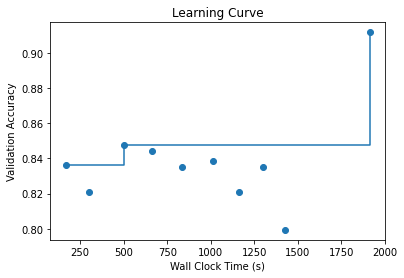

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Model selection

Given a dataset, which language model should you use for the fine tuning? It appears this is a simple question: just choose the best model according to the benchmarks such as [GLUE](https://gluebenchmark.com/leaderboard). However, we will see that under the resource constraints, the model selection is non trivial. 

In this example, we will tune the [spooky-author-identification](https://www.kaggle.com/competitions/spooky-author-identification/data?select=train.zip) dataset from kaggle. You can download the dataset from the website and upload it to Colab. We run FLAML for 30 mins using bert.

In [ ]:
import flaml
from flaml import AutoML
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('spooky-author-identification.csv')
X, y = df.drop('author', axis=1), df['author']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)
automl_model = AutoML()

automl_settings = {
    "time_budget": 1800,                 
    "task": "seq-classification",       
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   
            "model_path": "bert-base-uncased",  
        }
    },
    "metric": "accuracy",
    "gpu_per_trial": 1,  
    "log_file_name": "spooky_bert.log", 
    "log_type": "all",                 
    "use_ray": False,                    # set whether to use Ray
    "n_concurrent_trials": 1,
    "keep_search_state": True,          # keeping the search state
}

from flaml import tune
custom_hp = {
    "transformer": {
            "num_train_epochs": {
                "domain": tune.choice([0.3, 1, 2, 3, 4, 5]),
                "init_value": 0.3,  
                "low_cost_init_value": 0.3,
            },
        }
}

automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl: 08-19 14:50:41] {2540} INFO - task = seq-classification
INFO:flaml.automl:task = seq-classification
[flaml.automl: 08-19 14:50:41] {2542} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 08-19 14:50:41] {2545} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 08-19 14:50:41] {2664} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 08-19 14:50:41] {2806} INFO - List of ML learners in AutoML Run: ['transformer']
INFO:flaml.automl:List of ML learners in AutoML Run: ['transformer']
[flaml.automl: 08-19 14:50:41] {3108} INFO - iteration 0, current learner transformer
INFO:flaml.automl:iteration 0, current learner transformer
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementati

{'eval_loss': 0.8782516717910767, 'eval_automl_metric': 0.3650663942798774, 'eval_runtime': 63.6528, 'eval_samples_per_second': 76.902, 'eval_steps_per_second': 76.902, 'epoch': 0.3}
{'train_runtime': 136.3771, 'train_samples_per_second': 32.302, 'train_steps_per_second': 1.012, 'train_loss': 0.9700310748556386, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_14-50-41/train_4ba0c0a8_18_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_14-50-41/checkpoint-138/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_14-50-41/train_4ba0c0a8_18_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_14-50-41/checkpoint-138/vocab.txt
loading file data/output/train_2022-08-19_14-50-41/train_4ba0c0a8_18_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_14-50-41/checkpoint-138/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_14-50-41/train_4ba0c0a8_18_s=9223372036854775807,e=1e-05,s=-

{'eval_loss': 0.9422562122344971, 'eval_automl_metric': 0.4482124616956078, 'eval_runtime': 64.093, 'eval_samples_per_second': 76.373, 'eval_steps_per_second': 76.373, 'epoch': 0.3}
{'train_runtime': 142.1563, 'train_samples_per_second': 30.988, 'train_steps_per_second': 0.485, 'train_loss': 1.0089939504429914, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_14-54-42/train_db826be0_19_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_14-54-42/checkpoint-69/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_14-54-42/train_db826be0_19_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_14-54-42/checkpoint-69/vocab.txt
loading file data/output/train_2022-08-19_14-54-42/train_db826be0_19_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_14-54-42/checkpoint-69/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_14-54-42/train_db826be0_19_s=9223372036854775807

{'eval_loss': 0.764643669128418, 'eval_automl_metric': 0.30684371807967314, 'eval_runtime': 64.3046, 'eval_samples_per_second': 76.122, 'eval_steps_per_second': 76.122, 'epoch': 0.3}
{'train_runtime': 139.6474, 'train_samples_per_second': 31.545, 'train_steps_per_second': 1.976, 'train_loss': 0.9045784438865773, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_14-58-51/train_6fc6d930_20_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_14-58-51/checkpoint-276/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_14-58-51/train_6fc6d930_20_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_14-58-51/checkpoint-276/vocab.txt
loading file data/output/train_2022-08-19_14-58-51/train_6fc6d930_20_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_14-58-51/checkpoint-276/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_14-58-51/train_6fc6d930_20_s=9223372036854775

{'eval_loss': 0.6895061731338501, 'eval_automl_metric': 0.26414708886619, 'eval_runtime': 64.1612, 'eval_samples_per_second': 76.292, 'eval_steps_per_second': 76.292, 'epoch': 0.3}
{'train_runtime': 137.9967, 'train_samples_per_second': 31.923, 'train_steps_per_second': 2.0, 'train_loss': 0.8616765340169271, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-02-56/train_01e528ee_21_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-02-56/checkpoint-276/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-02-56/train_01e528ee_21_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-02-56/checkpoint-276/vocab.txt
loading file data/output/train_2022-08-19_15-02-56/train_01e528ee_21_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-02-56/checkpoint-276/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_15-02-56/train_01e528ee_21_s=9223372036854775807,e=

{'loss': 0.7586, 'learning_rate': 4.688468079515019e-06, 'epoch': 0.54}
{'eval_loss': 0.4876616895198822, 'eval_automl_metric': 0.18447395301327885, 'eval_runtime': 64.0236, 'eval_samples_per_second': 76.456, 'eval_steps_per_second': 76.456, 'epoch': 1.0}
{'train_runtime': 312.4704, 'train_samples_per_second': 46.993, 'train_steps_per_second': 2.938, 'train_loss': 0.6536963469062755, 'epoch': 1.0}


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-07-00/train_933f400e_22_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-07-00/checkpoint-918/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-07-00/train_933f400e_22_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-07-00/checkpoint-918/vocab.txt
loading file data/output/train_2022-08-19_15-07-00/train_933f400e_22_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-07-00/checkpoint-918/tokenizer.json
loading file None
loading file data/output/train_2022-08-19_15-07-00/train_933f400e_22_s=9223372036854775807,e=

The job ran for 23m and searched for 4 trials. This time is shorter than our budget 30m because FLAML early stops the last trial which will run for too long. If you want to run for longer time, set a larger time budget. 

In [ ]:
print("the best loss for spooky author identification: {}".format(automl_model.best_loss))

the best loss for spooky author identification: 0.18447395301327885


Next, we set the model to roberta and run again. RoBERTa outperforms BERT by 15% on the [SuperGLUE](https://super.gluebenchmark.com/) benchmark, as well as [GLUE](https://gluebenchmark.com/), [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/), [RACE](https://www.cs.cmu.edu/~glai1/data/race/), etc. Does this mean we should always use RoBERTa and never use BERT? To answer this question, we run the same experiment again with RoBERTa:

In [ ]:
automl_settings["fit_kwargs_by_estimator"]["transformer"]["model_path"] = "roberta-base"
automl_settings["log_file_name"] = "spooky_roberta.log"
automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl: 08-19 15:21:09] {2540} INFO - task = seq-classification
INFO:flaml.automl:task = seq-classification
[flaml.automl: 08-19 15:21:09] {2542} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 08-19 15:21:09] {2545} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 08-19 15:21:09] {2664} INFO - Minimizing error metric: 1-accuracy
INFO:flaml.automl:Minimizing error metric: 1-accuracy
[flaml.automl: 08-19 15:21:09] {2806} INFO - List of ML learners in AutoML Run: ['transformer']
INFO:flaml.automl:List of ML learners in AutoML Run: ['transformer']
[flaml.automl: 08-19 15:21:09] {3108} INFO - iteration 0, current learner transformer
INFO:flaml.automl:iteration 0, current learner transformer
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementati

{'eval_loss': 0.7796056866645813, 'eval_automl_metric': 0.3170582226762002, 'eval_runtime': 65.2086, 'eval_samples_per_second': 75.067, 'eval_steps_per_second': 75.067, 'epoch': 0.3}
{'train_runtime': 139.2884, 'train_samples_per_second': 31.626, 'train_steps_per_second': 0.991, 'train_loss': 0.9700887928838315, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-21-09/train_8d9e8af4_24_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_15-21-09/checkpoint-138/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-21-09/train_8d9e8af4_24_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_15-21-09/checkpoint-138/vocab.json
loading file data/output/train_2022-08-19_15-21-09/train_8d9e8af4_24_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=20_2022-08-19_15-21-09/checkpoint-138/merges.txt
loading file data/output/train_2022-08-19_15-21-09/train_8d9e8af4_24_s=9223372036854775807,e=1e-05,s=-1,s=0.3,e=32,d=

{'eval_loss': 1.0274657011032104, 'eval_automl_metric': 0.5805924412665986, 'eval_runtime': 65.4388, 'eval_samples_per_second': 74.803, 'eval_steps_per_second': 74.803, 'epoch': 0.3}
{'train_runtime': 141.3162, 'train_samples_per_second': 31.173, 'train_steps_per_second': 0.488, 'train_loss': 1.0675905752873076, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-25-18/train_21eb5d04_25_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_15-25-18/checkpoint-69/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-25-18/train_21eb5d04_25_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_15-25-18/checkpoint-69/vocab.json
loading file data/output/train_2022-08-19_15-25-18/train_21eb5d04_25_s=9223372036854775807,e=9.7119e-06,s=-1,s=0.3,e=64,d=14_2022-08-19_15-25-18/checkpoint-69/merges.txt
loading file data/output/train_2022-08-19_15-25-18/train_21eb5d04_25_s=9223372036854775807,e=9.7119e-06,s

{'eval_loss': 0.6534864902496338, 'eval_automl_metric': 0.27436159346271705, 'eval_runtime': 65.6703, 'eval_samples_per_second': 74.539, 'eval_steps_per_second': 74.539, 'epoch': 0.3}
{'train_runtime': 142.8116, 'train_samples_per_second': 30.846, 'train_steps_per_second': 1.933, 'train_loss': 0.8491502291914346, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-29-30/train_b7eb3874_26_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_15-29-30/checkpoint-276/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-29-30/train_b7eb3874_26_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_15-29-30/checkpoint-276/vocab.json
loading file data/output/train_2022-08-19_15-29-30/train_b7eb3874_26_s=9223372036854775807,e=1.0297e-05,s=-1,s=0.3,e=16,d=26_2022-08-19_15-29-30/checkpoint-276/merges.txt
loading file data/output/train_2022-08-19_15-29-30/train_b7eb3874_26_s=9223372036854775807,e=1.0297e-0

{'eval_loss': 0.586589515209198, 'eval_automl_metric': 0.2402451481103166, 'eval_runtime': 65.9616, 'eval_samples_per_second': 74.21, 'eval_steps_per_second': 74.21, 'epoch': 0.3}
{'train_runtime': 140.9957, 'train_samples_per_second': 31.243, 'train_steps_per_second': 1.958, 'train_loss': 0.7886253025220789, 'epoch': 0.3}


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-33-42/train_4e5c88d0_27_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-33-42/checkpoint-276/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-33-42/train_4e5c88d0_27_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-33-42/checkpoint-276/vocab.json
loading file data/output/train_2022-08-19_15-33-42/train_4e5c88d0_27_s=9223372036854775807,e=1.48e-05,s=-1,s=0.3,e=16,d=25_2022-08-19_15-33-42/checkpoint-276/merges.txt
loading file data/output/train_2022-08-19_15-33-42/train_4e5c88d0_27_s=9223372036854775807,e=1.48e-05,s=-1,s

{'loss': 0.7223, 'learning_rate': 4.688468079515019e-06, 'epoch': 0.54}
{'eval_loss': 0.4903346300125122, 'eval_automl_metric': 0.1953013278855975, 'eval_runtime': 65.2412, 'eval_samples_per_second': 75.029, 'eval_steps_per_second': 75.029, 'epoch': 1.0}
{'train_runtime': 310.9644, 'train_samples_per_second': 47.221, 'train_steps_per_second': 2.952, 'train_loss': 0.624375353711363, 'epoch': 1.0}


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4895
  Batch size = 1
Didn't find file data/output/train_2022-08-19_15-37-54/train_e47787a2_28_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-37-54/checkpoint-918/added_tokens.json. We won't load it.
loading file data/output/train_2022-08-19_15-37-54/train_e47787a2_28_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-37-54/checkpoint-918/vocab.json
loading file data/output/train_2022-08-19_15-37-54/train_e47787a2_28_s=9223372036854775807,e=1.0297e-05,s=-1,s=1,e=16,d=26_2022-08-19_15-37-54/checkpoint-918/merges.txt
loading file data/output/train_2022-08-19_15-37-54/train_e47787a2_28_s=9223372036854775807,e=1.0297e-05,s=-1

We plot the performance of BERT and RoBERTa w.r.t. the wall clock time. We find that although RoBERTa frequently outperforms BERT on benchmark datasets, its performance on the spooky-author-identification dataset is worse than BERT using the same time budget. Therefore, model selection is a non trivial problem. 

5
5


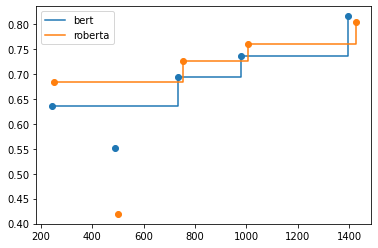

In [ ]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

for each_file_name in ['bert', 'roberta']:
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
        get_output_from_log(filename='spooky_' + each_file_name + '.log', time_budget=3000)
    print(len(valid_loss_history))
    plt.scatter(time_history, 1 - np.array(valid_loss_history))
    plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')

plt.legend(['bert', 'roberta'])
plt.show()

## 4. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on [FLAML's documentation website] (https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP)):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

Here we look into two tasks: multiple choice classification and text summarization. These tasks require significant computational resources, therefore instead of Colab, we run them using 4 NVIDIA V100 GPUs and Ray Tune on our server.

### 4.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas()
dev_dataset = load_dataset("swag", split="validation").to_pandas()
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

print(len(X_train))

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


73546


In [ ]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray

if ray.is_initialized() == False:
    ray.init(num_gpus=4, num_cpus=4)

automl_settings = {
    "time_budget": 1800,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "model_path": "bert-base-uncased", # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

  4%|▍         | 884/20006 [00:06<02:21, 134.78it/s]
(train pid=82694) 
  4%|▍         | 898/20006 [00:06<02:21, 134.97it/s]
(train pid=82105) The following columns in the test set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: sent1, ending3, startphrase, ending1, gold-source, ending2, sent2, fold-ind, video-id, ending0. If sent1, ending3, startphrase, ending1, gold-source, ending2, sent2, fold-ind, video-id, ending0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=82105) ***** Running Prediction *****
(train pid=82105)   Num examples = 20006
(train pid=82105)   Batch size = 1
  0%|          | 0/20006 [00:00<?, ?it/s]
(train pid=82694) 
  0%|          | 15/20006 [00:00<02:21, 141.62it/s]
(train pid=82694) 
  0%|          | 30/20006 [00:00<02:26, 136.71it/s]
(train pid=82694) 
  0%|          | 44/20006 [00:00<02:27, 135.13it/s]
(train pid=82694) 
  0%|          | 99/20006 [00:00<02:56, 1

(train pid=82694) {'eval_loss': 0.8081368207931519, 'eval_automl_metric': 0.3010596820953714, 'eval_runtime': 160.8012, 'eval_samples_per_second': 124.415, 'eval_steps_per_second': 124.415, 'epoch': 1.02}


  4%|▍         | 846/20006 [00:06<02:22, 134.28it/s]


(train pid=82694) {'train_runtime': 442.3031, 'train_samples_per_second': 113.045, 'train_steps_per_second': 7.065, 'train_loss': 1.085340142250061, 'epoch': 1.02}


  4%|▍         | 860/20006 [00:06<02:22, 134.40it/s]
(train pid=82394) The following columns in the test set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: ending1, video-id, ending3, fold-ind, sent2, sent1, gold-source, ending2, startphrase, ending0. If ending1, video-id, ending3, fold-ind, sent2, sent1, gold-source, ending2, startphrase, ending0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=82394) ***** Running Prediction *****
(train pid=82394)   Num examples = 20006
(train pid=82394)   Batch size = 1
  3%|▎         | 689/20006 [00:05<02:21, 136.11it/s]


  7%|▋         | 1417/20006 [00:10<02:16, 136.68it/s]


 11%|█         | 2131/20006 [00:15<02:13, 134.01it/s]


 12%|█▏        | 2313/20006 [00:16<02:09, 136.22it/s]
(train pid=82694) The following columns in the test set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: startphrase, ending0, ending2, ending3, gold-source, ending1, video-id, sent2, fold-ind, sent1. If startphrase, ending0, ending2, ending3, gold-source, ending1, video-id, sent2, fold-ind, sent1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=82694) ***** Running Prediction *****
(train pid=82694)   Num examples = 20006
(train pid=82694)   Batch size = 1
  2%|▏         | 367/20006 [00:02<02:35, 126.43it/s]


  5%|▍         | 926/20006 [00:06<02:20, 135.78it/s]


  7%|▋         | 1494/20006 [00:10<02:13, 138.59it/s]


 10%|█         | 2039/20006 [00:14<02:12, 135.87it/s]


 13%|█▎        | 2600/20006 [00:19<02:06, 138.08it/s]


 16%|█▌        | 3169/20006 [00:23<02:00, 139.49it/s]


 34%|███▍      | 6838/20006 [00:50<01:37, 134.87it/s]


 21%|██▏       | 4286/20006 [00:31<01:53, 138.20it/s]


 24%|██▍       | 4867/20006 [00:35<01:48, 139.12it/s]


 27%|██▋       | 5416/20006 [00:39<01:45, 138.32it/s]


 30%|██▉       | 5988/20006 [00:43<01:43, 135.80it/s]


 33%|███▎      | 6535/20006 [00:47<01:40, 134.66it/s]


 47%|████▋     | 9369/20006 [01:08<01:17, 136.50it/s]


 38%|███▊      | 7678/20006 [00:55<01:29, 137.96it/s]


 41%|████      | 8211/20006 [00:59<01:27, 135.24it/s]


 44%|████▍     | 8774/20006 [01:03<01:22, 136.14it/s]


 47%|████▋     | 9334/20006 [01:07<01:17, 137.08it/s]


 61%|██████    | 12127/20006 [01:29<00:57, 136.29it/s]


 52%|█████▏    | 10467/20006 [01:16<01:08, 138.43it/s]


 55%|█████▌    | 11035/20006 [01:20<01:04, 138.78it/s]


 78%|███████▊  | 15650/20006 [01:54<00:31, 137.08it/s]


 61%|██████    | 12104/20006 [01:27<00:57, 138.30it/s]


 84%|████████▎ | 16733/20006 [02:02<00:24, 135.90it/s]


 66%|██████▌   | 13225/20006 [01:36<00:48, 138.40it/s]


 69%|██████▉   | 13788/20006 [01:40<00:44, 138.51it/s]


 72%|███████▏  | 14350/20006 [01:44<00:40, 138.81it/s]


 75%|███████▍  | 14911/20006 [01:48<00:36, 138.49it/s]


 77%|███████▋  | 15480/20006 [01:52<00:32, 137.77it/s]


 80%|████████  | 16043/20006 [01:56<00:28, 138.67it/s]


 83%|████████▎ | 16578/20006 [02:00<00:24, 138.05it/s]


 83%|████████▎ | 16607/20006 [02:00<00:24, 137.37it/s]
(train pid=82050) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_57e8c6a0_9_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_08-39-59/checkpoint-155/added_tokens.json. We won't load it.
(train pid=82050) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_57e8c6a0_9_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_08-39-59/checkpoint-155/vocab.txt
(train pid=82050) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_57e8c6a0_9_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_08-39-59/checkpoint-155/tokenizer.json
(train pid=82050) loading file No

100%|██████████| 20006/20006 [02:29<00:00, 122.05it/s]Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_5a4a0d8c_10_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-02/checkpoint-1145/added_tokens.json. We won't load it.
(train pid=82105) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_5a4a0d8c_10_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-02/checkpoint-1145/vocab.txt
(train pid=82105) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_5a4a0d8c_10_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-02/checkpoint-1145/tokenizer.json
(train pid=82105) loading file None
(train pid=82

100%|█████████▉| 19995/20006 [02:25<00:00, 141.88it/s]Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_68118526_12_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-25/checkpoint-640/added_tokens.json. We won't load it.
(train pid=82694) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_68118526_12_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-25/checkpoint-640/vocab.txt
(train pid=82694) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_08-17-52/train_68118526_12_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-20_08-40-25/checkpoint-640/tokenizer.json
(train pid=82694) loading file None
(train pid=82694

100%|██████████| 20006/20006 [02:25<00:00, 137.74it/s]
2022-08-20 08:51:07,351	INFO tune.py:747 -- Total run time: 1994.73 seconds (1803.01 seconds for the tuning loop).
[flaml.automl: 08-20 08:51:19] {3322} INFO - selected model: None
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/xliu127/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  

[flaml.automl: 08-20 08:54:43] {3465} INFO - retrain transformer for 204.0s
[flaml.automl: 08-20 08:54:43] {3472} INFO - retrained model: None
[flaml.automl: 08-20 08:54:43] {2749} INFO - fit succeeded
[flaml.automl: 08-20 08:54:43] {2750} INFO - Time taken to find the best model: 1323.0768468379974
[flaml.automl: 08-20 08:54:43] {2761} WARNING - Time taken to find the best model is 74% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.681227670593606e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 64, 'seed': 11, 'global_max_steps': 155, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.681227670593606e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 64, 'seed': 11, 'global_max_steps': 155, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 328, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 328, 'le

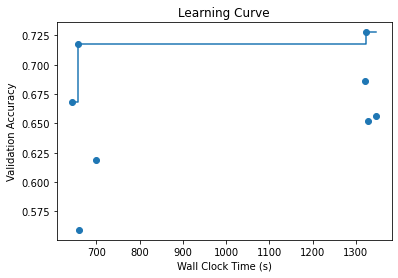

In [3]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 4.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [7]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()
print(len(train_dataset))
valid_dataset = load_dataset("xsum", split="validation").to_pandas()
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = valid_dataset[custom_sent_keys], valid_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


204045


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [9]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray

if ray.is_initialized() == False:
    ray.init(num_gpus=4, num_cpus=4)

automl_settings = {
    "time_budget": 3600,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "model_path": "t5-small",
            "pad_to_max_length": True,
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},  # set whether to use Ray
    "metric": "rouge1",
    "sample": True,       # sample: False # if the time is sufficient (e.g., longer than one trial's running time), you can set 
    "n_concurrent_trials": 4,  
}

from flaml import tune
custom_hp = {
    "transformer": {
            "num_train_epochs": {
                "domain": tune.choice([0.1, 1, 2, 3, 4, 5]),
                "init_value": 0.1,  
                "low_cost_init_value": 0.1,
            },
        }
}


'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

(train pid=41794) 
 64%|██████▍   | 7306/11332 [14:00<07:35,  8.83it/s]
(train pid=44724) 
 55%|█████▌    | 6261/11332 [12:01<09:33,  8.84it/s]
(train pid=44741) 
 55%|█████▌    | 6258/11332 [12:01<09:35,  8.82it/s]
(train pid=46117) 
 43%|████▎     | 4847/11332 [09:59<12:35,  8.58it/s]
(train pid=41794) 
 64%|██████▍   | 7307/11332 [14:00<07:36,  8.82it/s]
(train pid=44724) 
 55%|█████▌    | 6262/11332 [12:01<09:35,  8.81it/s]
(train pid=44741) 
 55%|█████▌    | 6259/11332 [12:01<09:34,  8.82it/s]
(train pid=41794) 
 64%|██████▍   | 7308/11332 [14:00<07:36,  8.82it/s]
(train pid=44724) 
 55%|█████▌    | 6263/11332 [12:01<09:35,  8.81it/s]
(train pid=44741) 
 55%|█████▌    | 6260/11332 [12:01<09:34,  8.83it/s]
(train pid=46117) 
 43%|████▎     | 4848/11332 [09:59<12:35,  8.58it/s]
(train pid=41794) 
 64%|██████▍   | 7309/11332 [14:00<07:36,  8.82it/s]
(train pid=44724) 
 55%|█████▌    | 6264/11332 [12:01<09:36,  8.79it/s]
(train pid=44741) 
 55%|█████▌    | 6261/11332 [12:02<09:34,  8.

(train pid=41794) 
 65%|██████▍   | 7331/11332 [14:02<07:33,  8.82it/s]
(train pid=44741) 
 55%|█████▌    | 6284/11332 [12:04<09:33,  8.80it/s]
(train pid=46117) 
 43%|████▎     | 4871/11332 [10:02<12:35,  8.55it/s]
(train pid=44724) 
 55%|█████▌    | 6287/11332 [12:04<09:35,  8.77it/s]
(train pid=41794) 
 65%|██████▍   | 7332/11332 [14:03<07:33,  8.82it/s]
(train pid=44741) 
 55%|█████▌    | 6285/11332 [12:04<09:32,  8.81it/s]
(train pid=46117) 
 43%|████▎     | 4872/11332 [10:02<12:33,  8.57it/s]
(train pid=44724) 
 55%|█████▌    | 6288/11332 [12:04<09:36,  8.75it/s]
(train pid=41794) 
 65%|██████▍   | 7333/11332 [14:03<07:32,  8.83it/s]
(train pid=44741) 
 55%|█████▌    | 6286/11332 [12:04<09:32,  8.82it/s]
(train pid=46117) 
 43%|████▎     | 4873/11332 [10:02<12:32,  8.59it/s]
(train pid=41794) 
 65%|██████▍   | 7334/11332 [14:03<07:32,  8.83it/s]
(train pid=44724) 
 55%|█████▌    | 6289/11332 [12:04<09:37,  8.73it/s]
(train pid=44741) 
 55%|█████▌    | 6287/11332 [12:04<09:31,  8.

(train pid=41794) 
 65%|██████▍   | 7357/11332 [14:05<07:30,  8.82it/s]
(train pid=44724) 
 56%|█████▌    | 6312/11332 [12:07<09:34,  8.74it/s]
(train pid=44741) 
 56%|█████▌    | 6309/11332 [12:07<09:30,  8.81it/s]
(train pid=46117) 
 43%|████▎     | 4896/11332 [10:05<12:29,  8.59it/s]
(train pid=41794) 
 65%|██████▍   | 7358/11332 [14:05<07:31,  8.79it/s]
(train pid=44741) 
 56%|█████▌    | 6310/11332 [12:07<09:29,  8.82it/s]
(train pid=46117) 
 43%|████▎     | 4897/11332 [10:05<12:30,  8.57it/s]
(train pid=44724) 
 56%|█████▌    | 6313/11332 [12:07<09:34,  8.74it/s]
(train pid=41794) 
 65%|██████▍   | 7359/11332 [14:06<07:31,  8.80it/s]
(train pid=44741) 
 56%|█████▌    | 6311/11332 [12:07<09:33,  8.76it/s]
(train pid=46117) 
 43%|████▎     | 4898/11332 [10:05<12:30,  8.57it/s]
(train pid=41794) 
 65%|██████▍   | 7360/11332 [14:06<07:31,  8.80it/s]
(train pid=44724) 
 56%|█████▌    | 6314/11332 [12:07<09:35,  8.72it/s]
(train pid=44741) 
 56%|█████▌    | 6312/11332 [12:07<09:32,  8.

(train pid=44724) 
 56%|█████▌    | 6335/11332 [12:09<09:28,  8.79it/s]
(train pid=44741) 
 56%|█████▌    | 6333/11332 [12:10<09:26,  8.82it/s]
(train pid=41794) 
 65%|██████▌   | 7381/11332 [14:08<07:30,  8.76it/s]
(train pid=46117) 
 43%|████▎     | 4920/11332 [10:08<11:59,  8.91it/s]
(train pid=44724) 
 56%|█████▌    | 6336/11332 [12:10<09:29,  8.77it/s]
(train pid=41794) 
 65%|██████▌   | 7382/11332 [14:08<07:29,  8.79it/s]
(train pid=44741) 
 56%|█████▌    | 6334/11332 [12:10<09:26,  8.82it/s]
(train pid=46117) 
 43%|████▎     | 4921/11332 [10:08<12:05,  8.83it/s]
(train pid=44724) 
 56%|█████▌    | 6337/11332 [12:10<09:29,  8.77it/s]
(train pid=41794) 
 65%|██████▌   | 7383/11332 [14:08<07:28,  8.80it/s]
(train pid=44741) 
 56%|█████▌    | 6335/11332 [12:10<09:26,  8.82it/s]
(train pid=44724) 
 56%|█████▌    | 6338/11332 [12:10<09:30,  8.75it/s]
(train pid=46117) 
 43%|████▎     | 4922/11332 [10:08<12:11,  8.77it/s]
(train pid=41794) 
 65%|██████▌   | 7384/11332 [14:08<07:28,  8.

(train pid=41794) 
 65%|██████▌   | 7406/11332 [14:11<07:25,  8.81it/s]
(train pid=44724) 
 56%|█████▌    | 6361/11332 [12:12<09:22,  8.83it/s]
(train pid=44741) 
 56%|█████▌    | 6359/11332 [12:13<09:22,  8.84it/s]
(train pid=46117) 
 44%|████▎     | 4945/11332 [10:10<12:00,  8.86it/s]
(train pid=41794) 
 65%|██████▌   | 7407/11332 [14:11<07:25,  8.82it/s]
(train pid=44724) 
 56%|█████▌    | 6362/11332 [12:13<09:22,  8.84it/s]
(train pid=46117) 
 44%|████▎     | 4946/11332 [10:11<12:11,  8.74it/s]
(train pid=44741) 
 56%|█████▌    | 6360/11332 [12:13<09:22,  8.84it/s]
(train pid=41794) 
 65%|██████▌   | 7408/11332 [14:11<07:24,  8.82it/s]
(train pid=44724) 
 56%|█████▌    | 6363/11332 [12:13<09:22,  8.83it/s]
(train pid=46117) 
 44%|████▎     | 4947/11332 [10:11<12:13,  8.70it/s]
(train pid=44741) 
 56%|█████▌    | 6361/11332 [12:13<09:22,  8.84it/s]
(train pid=44724) 
 56%|█████▌    | 6364/11332 [12:13<09:24,  8.79it/s]
(train pid=46117) 
 44%|████▎     | 4948/11332 [10:11<12:15,  8.

(train pid=41794) 
 66%|██████▌   | 7429/11332 [14:14<07:26,  8.74it/s]
(train pid=44724) 
 56%|█████▋    | 6386/11332 [12:15<09:31,  8.66it/s]
(train pid=44741) 
 56%|█████▋    | 6384/11332 [12:15<09:19,  8.85it/s]
(train pid=46117) 
 44%|████▍     | 4970/11332 [10:13<11:48,  8.98it/s]
(train pid=41794) 
 66%|██████▌   | 7430/11332 [14:14<07:26,  8.74it/s]
(train pid=44724) 
 56%|█████▋    | 6387/11332 [12:15<09:31,  8.65it/s]
(train pid=44741) 
 56%|█████▋    | 6385/11332 [12:16<09:20,  8.83it/s]
(train pid=46117) 
 44%|████▍     | 4971/11332 [10:13<11:57,  8.87it/s]
(train pid=41794) 
 66%|██████▌   | 7431/11332 [14:14<07:26,  8.74it/s]
(train pid=44724) 
 56%|█████▋    | 6388/11332 [12:16<09:30,  8.66it/s]
(train pid=44741) 
 56%|█████▋    | 6386/11332 [12:16<09:20,  8.83it/s]
(train pid=46117) 
 44%|████▍     | 4972/11332 [10:14<11:34,  9.15it/s]
(train pid=41794) 
 66%|██████▌   | 7432/11332 [14:14<07:26,  8.74it/s]
(train pid=44724) 
 56%|█████▋    | 6389/11332 [12:16<09:30,  8.

(train pid=41794) 
 66%|██████▌   | 7454/11332 [14:17<07:24,  8.73it/s]
(train pid=44724) 
 57%|█████▋    | 6412/11332 [12:18<09:11,  8.92it/s]
(train pid=44741) 
 57%|█████▋    | 6410/11332 [12:18<08:51,  9.27it/s]
(train pid=46117) 
 44%|████▍     | 4996/11332 [10:16<11:52,  8.89it/s]
(train pid=41794) 
 66%|██████▌   | 7455/11332 [14:17<07:24,  8.73it/s]
(train pid=44724) 
 57%|█████▋    | 6413/11332 [12:18<09:15,  8.85it/s]
(train pid=44741) 
 57%|█████▋    | 6411/11332 [12:18<08:58,  9.14it/s]
(train pid=46117) 
 44%|████▍     | 4997/11332 [10:16<11:58,  8.81it/s]
(train pid=41794) 
 66%|██████▌   | 7456/11332 [14:17<07:23,  8.73it/s]
(train pid=44724) 
 57%|█████▋    | 6414/11332 [12:18<09:18,  8.81it/s]
(train pid=44741) 
 57%|█████▋    | 6412/11332 [12:19<09:03,  9.05it/s]
(train pid=46117) 
 44%|████▍     | 4998/11332 [10:16<12:03,  8.76it/s]
(train pid=41794) 
 66%|██████▌   | 7457/11332 [14:17<07:23,  8.74it/s]
(train pid=44724) 
 57%|█████▋    | 6415/11332 [12:19<09:17,  8.

(train pid=44724) 
 57%|█████▋    | 6437/11332 [12:21<09:21,  8.72it/s]
(train pid=44741) 
 57%|█████▋    | 6435/11332 [12:21<09:14,  8.83it/s]
(train pid=41794) 
 66%|██████▌   | 7480/11332 [14:20<07:21,  8.73it/s]
(train pid=46117) 
 44%|████▍     | 5022/11332 [10:19<12:10,  8.63it/s]
(train pid=44724) 
 57%|█████▋    | 6438/11332 [12:21<09:27,  8.62it/s]
(train pid=44741) 
 57%|█████▋    | 6436/11332 [12:21<09:14,  8.83it/s]
(train pid=41794) 
 66%|██████▌   | 7481/11332 [14:20<07:21,  8.71it/s]
(train pid=44724) 
 57%|█████▋    | 6439/11332 [12:21<09:23,  8.69it/s]
(train pid=44741) 
 57%|█████▋    | 6437/11332 [12:21<09:14,  8.83it/s]
(train pid=46117) 
 44%|████▍     | 5024/11332 [10:19<11:40,  9.01it/s]
(train pid=41794) 
 66%|██████▌   | 7482/11332 [14:20<07:21,  8.72it/s]
(train pid=44724) 
 57%|█████▋    | 6440/11332 [12:21<09:21,  8.71it/s]
(train pid=44741) 
 57%|█████▋    | 6438/11332 [12:21<09:13,  8.85it/s]
(train pid=46117) 
 44%|████▍     | 5025/11332 [10:19<11:48,  8.

(train pid=41794) 
 66%|██████▌   | 7505/11332 [14:23<07:17,  8.75it/s]
(train pid=44741) 
 57%|█████▋    | 6461/11332 [12:24<09:11,  8.83it/s]
(train pid=46117) 
 45%|████▍     | 5047/11332 [10:22<12:10,  8.61it/s]
(train pid=44724) 
 57%|█████▋    | 6463/11332 [12:24<09:12,  8.81it/s]
(train pid=41794) 
 66%|██████▌   | 7506/11332 [14:23<07:17,  8.75it/s]
(train pid=44741) 
 57%|█████▋    | 6462/11332 [12:24<09:10,  8.84it/s]
(train pid=46117) 
 45%|████▍     | 5048/11332 [10:22<12:10,  8.61it/s]
(train pid=44724) 
 57%|█████▋    | 6464/11332 [12:24<09:12,  8.82it/s]
(train pid=41794) 
 66%|██████▌   | 7507/11332 [14:23<07:17,  8.75it/s]
(train pid=44741) 
 57%|█████▋    | 6463/11332 [12:24<09:10,  8.85it/s]
(train pid=46117) 
 45%|████▍     | 5049/11332 [10:22<12:15,  8.54it/s]
(train pid=44724) 
 57%|█████▋    | 6465/11332 [12:24<09:10,  8.84it/s]
(train pid=41794) 
 66%|██████▋   | 7508/11332 [14:23<07:17,  8.75it/s]
(train pid=44741) 
 57%|█████▋    | 6464/11332 [12:24<09:10,  8.

(train pid=41794) 
 66%|██████▋   | 7530/11332 [14:25<07:17,  8.69it/s]
(train pid=44724) 
 57%|█████▋    | 6488/11332 [12:27<09:12,  8.76it/s]
(train pid=46117) 
 45%|████▍     | 5072/11332 [10:25<11:59,  8.70it/s]
(train pid=44741) 
 57%|█████▋    | 6487/11332 [12:27<09:11,  8.78it/s]
(train pid=41794) 
 66%|██████▋   | 7531/11332 [14:25<07:18,  8.67it/s]
(train pid=44724) 
 57%|█████▋    | 6489/11332 [12:27<09:13,  8.75it/s]
(train pid=46117) 
 45%|████▍     | 5073/11332 [10:25<12:01,  8.67it/s]
(train pid=44741) 
 57%|█████▋    | 6488/11332 [12:27<09:11,  8.79it/s]
(train pid=41794) 
 66%|██████▋   | 7532/11332 [14:26<07:17,  8.68it/s]
(train pid=44724) 
 57%|█████▋    | 6490/11332 [12:27<09:12,  8.76it/s]
(train pid=46117) 
 45%|████▍     | 5074/11332 [10:25<12:04,  8.64it/s]
(train pid=41794) 
 66%|██████▋   | 7533/11332 [14:26<07:17,  8.69it/s]
(train pid=44724) 
 57%|█████▋    | 6491/11332 [12:27<09:12,  8.76it/s]
(train pid=44741) 
 57%|█████▋    | 6489/11332 [12:27<09:10,  8.

(train pid=41794) 
 67%|██████▋   | 7555/11332 [14:28<07:16,  8.65it/s]
(train pid=44724) 
 57%|█████▋    | 6513/11332 [12:30<09:10,  8.76it/s]
(train pid=44741) 
 57%|█████▋    | 6512/11332 [12:30<09:06,  8.83it/s]
(train pid=46117) 
 45%|████▍     | 5097/11332 [10:28<11:55,  8.72it/s]
(train pid=41794) 
 67%|██████▋   | 7556/11332 [14:28<07:15,  8.68it/s]
(train pid=44724) 
 57%|█████▋    | 6514/11332 [12:30<09:10,  8.75it/s]
(train pid=44741) 
 57%|█████▋    | 6513/11332 [12:30<09:05,  8.83it/s]
(train pid=46117) 
 45%|████▍     | 5098/11332 [10:28<11:59,  8.66it/s]
(train pid=41794) 
 67%|██████▋   | 7557/11332 [14:28<07:14,  8.69it/s]
(train pid=44724) 
 57%|█████▋    | 6515/11332 [12:30<09:09,  8.77it/s]
(train pid=44741) 
 57%|█████▋    | 6514/11332 [12:30<09:05,  8.83it/s]
(train pid=46117) 
 45%|████▍     | 5099/11332 [10:28<12:00,  8.65it/s]
(train pid=41794) 
 67%|██████▋   | 7558/11332 [14:29<07:16,  8.65it/s]
(train pid=44724) 
 58%|█████▊    | 6516/11332 [12:30<09:07,  8.

(train pid=41794) 
 67%|██████▋   | 7579/11332 [14:31<07:09,  8.74it/s]
(train pid=44724) 
 58%|█████▊    | 6537/11332 [12:32<09:07,  8.76it/s]
(train pid=44741) 
 58%|█████▊    | 6536/11332 [12:33<09:03,  8.82it/s]
(train pid=46117) 
 45%|████▌     | 5121/11332 [10:30<12:00,  8.63it/s]
(train pid=41794) 
 67%|██████▋   | 7580/11332 [14:31<07:08,  8.75it/s]
(train pid=44724) 
 58%|█████▊    | 6538/11332 [12:33<09:08,  8.73it/s]
(train pid=44741) 
 58%|█████▊    | 6537/11332 [12:33<09:02,  8.83it/s]
(train pid=46117) 
 45%|████▌     | 5122/11332 [10:31<11:59,  8.63it/s]
(train pid=41794) 
 67%|██████▋   | 7581/11332 [14:31<07:08,  8.76it/s]
(train pid=44724) 
 58%|█████▊    | 6539/11332 [12:33<09:09,  8.73it/s]
(train pid=44741) 
 58%|█████▊    | 6538/11332 [12:33<09:02,  8.84it/s]
(train pid=46117) 
 45%|████▌     | 5123/11332 [10:31<11:59,  8.63it/s]
(train pid=41794) 
 67%|██████▋   | 7582/11332 [14:31<07:08,  8.76it/s]
(train pid=44724) 
 58%|█████▊    | 6540/11332 [12:33<09:09,  8.

(train pid=44724) 
 58%|█████▊    | 6560/11332 [12:35<09:05,  8.75it/s]
(train pid=46117) 
 45%|████▌     | 5144/11332 [10:33<11:56,  8.63it/s]
(train pid=41794) 
 67%|██████▋   | 7603/11332 [14:34<07:05,  8.77it/s]
(train pid=44741) 
 58%|█████▊    | 6559/11332 [12:35<09:11,  8.65it/s]
(train pid=44724) 
 58%|█████▊    | 6561/11332 [12:35<09:05,  8.74it/s]
(train pid=46117) 
 45%|████▌     | 5145/11332 [10:33<11:57,  8.63it/s]
(train pid=41794) 
 67%|██████▋   | 7604/11332 [14:34<07:05,  8.76it/s]
(train pid=44741) 
 58%|█████▊    | 6560/11332 [12:35<09:11,  8.65it/s]
(train pid=44724) 
 58%|█████▊    | 6562/11332 [12:35<09:03,  8.77it/s]
(train pid=41794) 
 67%|██████▋   | 7605/11332 [14:34<07:05,  8.76it/s]
(train pid=46117) 
 45%|████▌     | 5146/11332 [10:33<11:57,  8.63it/s]
(train pid=44724) 
 58%|█████▊    | 6563/11332 [12:35<09:04,  8.76it/s]
(train pid=44741) 
 58%|█████▊    | 6561/11332 [12:36<09:12,  8.64it/s]
(train pid=41794) 
 67%|██████▋   | 7606/11332 [14:34<07:05,  8.

(train pid=41794) 
 67%|██████▋   | 7628/11332 [14:37<07:03,  8.75it/s]
(train pid=44724) 
 58%|█████▊    | 6586/11332 [12:38<09:00,  8.79it/s]
(train pid=44741) 
 58%|█████▊    | 6584/11332 [12:38<09:06,  8.69it/s]
(train pid=46117) 
 46%|████▌     | 5166/11332 [10:36<12:56,  7.94it/s]
(train pid=41794) 
 67%|██████▋   | 7629/11332 [14:37<07:03,  8.74it/s]
(train pid=44724) 
 58%|█████▊    | 6587/11332 [12:38<09:01,  8.77it/s]
(train pid=44741) 
 58%|█████▊    | 6585/11332 [12:38<09:06,  8.69it/s]
(train pid=46117) 
 46%|████▌     | 5167/11332 [10:36<12:39,  8.12it/s]
(train pid=41794) 
 67%|██████▋   | 7630/11332 [14:37<07:03,  8.75it/s]
(train pid=44724) 
 58%|█████▊    | 6588/11332 [12:38<09:01,  8.77it/s]
(train pid=44741) 
 58%|█████▊    | 6586/11332 [12:38<09:05,  8.70it/s]
(train pid=46117) 
 46%|████▌     | 5168/11332 [10:36<12:28,  8.24it/s]
(train pid=41794) 
 67%|██████▋   | 7631/11332 [14:37<07:03,  8.74it/s]
(train pid=44724) 
 58%|█████▊    | 6589/11332 [12:38<09:02,  8.

(train pid=41794) 
 68%|██████▊   | 7653/11332 [14:39<07:00,  8.75it/s]
(train pid=44724) 
 58%|█████▊    | 6611/11332 [12:41<08:59,  8.75it/s]
(train pid=44741) 
 58%|█████▊    | 6609/11332 [12:41<09:05,  8.66it/s]
(train pid=41794) 
 68%|██████▊   | 7654/11332 [14:40<07:00,  8.75it/s]
(train pid=44724) 
 58%|█████▊    | 6612/11332 [12:41<09:00,  8.73it/s]
(train pid=44741) 
 58%|█████▊    | 6610/11332 [12:41<09:04,  8.67it/s]
(train pid=46117) 
 46%|████▌     | 5191/11332 [10:39<12:54,  7.93it/s]
(train pid=41794) 
 68%|██████▊   | 7655/11332 [14:40<07:00,  8.74it/s]
(train pid=44724) 
 58%|█████▊    | 6613/11332 [12:41<09:18,  8.45it/s]
(train pid=44741) 
 58%|█████▊    | 6611/11332 [12:41<09:01,  8.71it/s]
(train pid=46117) 
 46%|████▌     | 5192/11332 [10:39<14:29,  7.06it/s]
(train pid=41794) 
 68%|██████▊   | 7656/11332 [14:40<06:59,  8.77it/s]
(train pid=44724) 
 58%|█████▊    | 6614/11332 [12:41<10:03,  7.82it/s]
(train pid=44741) 
 58%|█████▊    | 6612/11332 [12:41<08:59,  8.

(train pid=44724) 
 59%|█████▊    | 6636/11332 [12:44<08:57,  8.74it/s]
(train pid=44741) 
 59%|█████▊    | 6634/11332 [12:44<08:58,  8.73it/s]
(train pid=46117) 
 46%|████▌     | 5212/11332 [10:42<11:50,  8.62it/s]
(train pid=41794) 
 68%|██████▊   | 7679/11332 [14:42<06:58,  8.73it/s]
(train pid=44724) 
 59%|█████▊    | 6637/11332 [12:44<08:56,  8.75it/s]
(train pid=44741) 
 59%|█████▊    | 6635/11332 [12:44<08:58,  8.73it/s]
(train pid=46117) 
 46%|████▌     | 5213/11332 [10:42<11:48,  8.63it/s]
(train pid=41794) 
 68%|██████▊   | 7680/11332 [14:43<06:57,  8.74it/s]
(train pid=44724) 
 59%|█████▊    | 6638/11332 [12:44<08:57,  8.73it/s]
(train pid=44741) 
 59%|█████▊    | 6636/11332 [12:44<08:57,  8.74it/s]
(train pid=46117) 
 46%|████▌     | 5214/11332 [10:42<11:48,  8.64it/s]
(train pid=41794) 
 68%|██████▊   | 7681/11332 [14:43<06:57,  8.74it/s]
(train pid=44741) 
 59%|█████▊    | 6637/11332 [12:44<08:57,  8.73it/s]
(train pid=46117) 
 46%|████▌     | 5215/11332 [10:42<11:48,  8.

(train pid=41794) 
 68%|██████▊   | 7704/11332 [14:45<06:55,  8.72it/s]
(train pid=44724) 
 59%|█████▉    | 6661/11332 [12:47<09:02,  8.61it/s]
(train pid=44741) 
 59%|█████▉    | 6659/11332 [12:47<08:54,  8.75it/s]
(train pid=46117) 
 46%|████▌     | 5237/11332 [10:45<11:45,  8.63it/s]
(train pid=44741) 
 59%|█████▉    | 6660/11332 [12:47<08:54,  8.74it/s]
(train pid=46117) 
 46%|████▌     | 5238/11332 [10:45<11:45,  8.64it/s]
(train pid=41794) 
 68%|██████▊   | 7705/11332 [14:45<06:55,  8.73it/s]
(train pid=44724) 
 59%|█████▉    | 6662/11332 [12:47<09:01,  8.62it/s]
(train pid=44741) 
 59%|█████▉    | 6661/11332 [12:47<08:54,  8.74it/s]
(train pid=46117) 
 46%|████▌     | 5239/11332 [10:45<11:45,  8.63it/s]
(train pid=41794) 
 68%|██████▊   | 7706/11332 [14:46<06:55,  8.73it/s]
(train pid=44724) 
 59%|█████▉    | 6663/11332 [12:47<09:01,  8.62it/s]
(train pid=44741) 
 59%|█████▉    | 6662/11332 [12:47<08:54,  8.74it/s]
(train pid=46117) 
 46%|████▌     | 5240/11332 [10:45<11:45,  8.

(train pid=41794) 
 68%|██████▊   | 7729/11332 [14:48<06:51,  8.75it/s]
(train pid=44724) 
 59%|█████▉    | 6686/11332 [12:50<08:52,  8.72it/s]
(train pid=44741) 
 59%|█████▉    | 6684/11332 [12:50<08:48,  8.79it/s]
(train pid=46117) 
 46%|████▋     | 5262/11332 [10:48<11:27,  8.83it/s]
(train pid=41794) 
 68%|██████▊   | 7730/11332 [14:48<06:51,  8.75it/s]
(train pid=44724) 
 59%|█████▉    | 6687/11332 [12:50<08:53,  8.71it/s]
(train pid=44741) 
 59%|█████▉    | 6685/11332 [12:50<08:49,  8.77it/s]
(train pid=46117) 
 46%|████▋     | 5263/11332 [10:48<11:31,  8.78it/s]
(train pid=41794) 
 68%|██████▊   | 7731/11332 [14:48<06:51,  8.74it/s]
(train pid=44724) 
 59%|█████▉    | 6688/11332 [12:50<08:54,  8.69it/s]
(train pid=44741) 
 59%|█████▉    | 6686/11332 [12:50<08:50,  8.75it/s]
(train pid=46117) 
 46%|████▋     | 5265/11332 [10:48<10:24,  9.71it/s]
(train pid=41794) 
 68%|██████▊   | 7732/11332 [14:48<06:51,  8.74it/s]
(train pid=44724) 
 59%|█████▉    | 6689/11332 [12:50<08:57,  8.

(train pid=41794) 
 68%|██████▊   | 7754/11332 [14:51<06:48,  8.76it/s]
(train pid=44724) 
 59%|█████▉    | 6711/11332 [12:52<08:53,  8.67it/s]
(train pid=44741) 
 59%|█████▉    | 6710/11332 [12:53<08:51,  8.70it/s]
(train pid=46117) 
 47%|████▋     | 5288/11332 [10:50<11:30,  8.75it/s]
(train pid=41794) 
 68%|██████▊   | 7755/11332 [14:51<06:48,  8.76it/s]
(train pid=44724) 
 59%|█████▉    | 6712/11332 [12:53<08:53,  8.65it/s]
(train pid=44741) 
 59%|█████▉    | 6711/11332 [12:53<08:50,  8.71it/s]
(train pid=46117) 
 47%|████▋     | 5289/11332 [10:51<11:33,  8.72it/s]
(train pid=41794) 
 68%|██████▊   | 7756/11332 [14:51<06:48,  8.76it/s]
(train pid=44724) 
 59%|█████▉    | 6713/11332 [12:53<08:50,  8.71it/s]
(train pid=46117) 
 47%|████▋     | 5290/11332 [10:51<11:34,  8.70it/s]
(train pid=41794) 
 68%|██████▊   | 7757/11332 [14:51<06:47,  8.77it/s]
(train pid=44724) 
 59%|█████▉    | 6714/11332 [12:53<08:51,  8.69it/s]
(train pid=44741) 
 59%|█████▉    | 6712/11332 [12:53<08:52,  8.

(train pid=41794) 
 69%|██████▊   | 7779/11332 [14:54<06:45,  8.76it/s]
(train pid=44724) 
 59%|█████▉    | 6736/11332 [12:55<08:50,  8.67it/s]
(train pid=44741) 
 59%|█████▉    | 6735/11332 [12:56<08:45,  8.74it/s]
(train pid=46117) 
 47%|████▋     | 5313/11332 [10:53<11:33,  8.68it/s]
(train pid=41794) 
 69%|██████▊   | 7780/11332 [14:54<06:45,  8.77it/s]
(train pid=44724) 
 59%|█████▉    | 6737/11332 [12:55<08:50,  8.66it/s]
(train pid=44741) 
 59%|█████▉    | 6736/11332 [12:56<08:45,  8.74it/s]
(train pid=46117) 
 47%|████▋     | 5314/11332 [10:53<11:34,  8.67it/s]
(train pid=41794) 
 69%|██████▊   | 7781/11332 [14:54<06:45,  8.77it/s]
(train pid=44724) 
 59%|█████▉    | 6738/11332 [12:56<08:50,  8.66it/s]
(train pid=44741) 
 59%|█████▉    | 6737/11332 [12:56<08:45,  8.74it/s]
(train pid=46117) 
 47%|████▋     | 5315/11332 [10:54<11:27,  8.76it/s]
(train pid=41794) 
 69%|██████▊   | 7782/11332 [14:54<06:44,  8.77it/s]
(train pid=44724) 
 59%|█████▉    | 6739/11332 [12:56<08:50,  8.

(train pid=41794) 
 69%|██████▉   | 7804/11332 [14:57<06:44,  8.72it/s]
(train pid=44724) 
 60%|█████▉    | 6761/11332 [12:58<08:45,  8.69it/s]
(train pid=44741) 
 60%|█████▉    | 6760/11332 [12:58<08:44,  8.72it/s]
(train pid=46117) 
 47%|████▋     | 5338/11332 [10:56<11:38,  8.58it/s]
(train pid=41794) 
 69%|██████▉   | 7805/11332 [14:57<06:44,  8.72it/s]
(train pid=44724) 
 60%|█████▉    | 6762/11332 [12:58<08:45,  8.70it/s]
(train pid=44741) 
 60%|█████▉    | 6761/11332 [12:58<08:44,  8.72it/s]
(train pid=46117) 
 47%|████▋     | 5339/11332 [10:56<11:37,  8.60it/s]
(train pid=41794) 
 69%|██████▉   | 7806/11332 [14:57<06:43,  8.73it/s]
(train pid=44724) 
 60%|█████▉    | 6763/11332 [12:58<08:44,  8.70it/s]
(train pid=44741) 
 60%|█████▉    | 6762/11332 [12:59<08:43,  8.73it/s]
(train pid=46117) 
 47%|████▋     | 5340/11332 [10:56<11:35,  8.61it/s]
(train pid=41794) 
 69%|██████▉   | 7807/11332 [14:57<06:43,  8.73it/s]
(train pid=44724) 
 60%|█████▉    | 6764/11332 [12:59<08:44,  8.

(train pid=44724) 
 60%|█████▉    | 6786/11332 [13:01<08:44,  8.67it/s]
(train pid=44741) 
 60%|█████▉    | 6785/11332 [13:01<08:41,  8.73it/s]
(train pid=46117) 
 47%|████▋     | 5362/11332 [10:59<11:15,  8.83it/s]
(train pid=41794) 
 69%|██████▉   | 7829/11332 [15:00<06:39,  8.78it/s]
(train pid=44724) 
 60%|█████▉    | 6787/11332 [13:01<08:43,  8.67it/s]
(train pid=44741) 
 60%|█████▉    | 6786/11332 [13:01<08:43,  8.69it/s]
(train pid=46117) 
 47%|████▋     | 5363/11332 [10:59<11:20,  8.78it/s]
(train pid=41794) 
 69%|██████▉   | 7830/11332 [15:00<06:39,  8.78it/s]
(train pid=44724) 
 60%|█████▉    | 6788/11332 [13:01<08:43,  8.69it/s]
(train pid=46117) 
 47%|████▋     | 5364/11332 [10:59<11:24,  8.72it/s]
(train pid=41794) 
 69%|██████▉   | 7831/11332 [15:00<06:38,  8.78it/s]
(train pid=44724) 
 60%|█████▉    | 6789/11332 [13:01<08:42,  8.69it/s]
(train pid=44741) 
 60%|█████▉    | 6787/11332 [13:02<09:40,  7.83it/s]
(train pid=46117) 
 47%|████▋     | 5365/11332 [10:59<11:26,  8.

(train pid=44724) 
 60%|██████    | 6811/11332 [13:04<08:42,  8.65it/s]
(train pid=46117) 
 48%|████▊     | 5387/11332 [11:02<11:09,  8.88it/s]
(train pid=41794) 
 69%|██████▉   | 7854/11332 [15:03<06:36,  8.78it/s]
(train pid=44741) 
 60%|██████    | 6809/11332 [13:04<08:32,  8.83it/s]
(train pid=44724) 
 60%|██████    | 6812/11332 [13:04<08:42,  8.64it/s]
(train pid=44741) 
 60%|██████    | 6810/11332 [13:04<08:31,  8.84it/s]
(train pid=46117) 
 48%|████▊     | 5388/11332 [11:02<11:14,  8.81it/s]
(train pid=41794) 
 69%|██████▉   | 7855/11332 [15:03<06:35,  8.79it/s]
(train pid=44724) 
 60%|██████    | 6813/11332 [13:04<08:43,  8.64it/s]
(train pid=46117) 
 48%|████▊     | 5389/11332 [11:02<11:18,  8.76it/s]
(train pid=41794) 
 69%|██████▉   | 7856/11332 [15:03<06:35,  8.79it/s]
(train pid=44724) 
 60%|██████    | 6814/11332 [13:04<08:42,  8.64it/s]
(train pid=44741) 
 60%|██████    | 6811/11332 [13:04<10:02,  7.50it/s]
(train pid=46117) 
 48%|████▊     | 5390/11332 [11:02<11:20,  8.

(train pid=41794) 
 70%|██████▉   | 7878/11332 [15:05<06:33,  8.77it/s]
(train pid=44724) 
 60%|██████    | 6836/11332 [13:07<08:38,  8.67it/s]
(train pid=44741) 
 60%|██████    | 6833/11332 [13:07<08:37,  8.69it/s]
(train pid=46117) 
 48%|████▊     | 5409/11332 [11:05<10:59,  8.98it/s]
(train pid=41794) 
 70%|██████▉   | 7879/11332 [15:05<06:33,  8.77it/s]
(train pid=44724) 
 60%|██████    | 6837/11332 [13:07<08:38,  8.66it/s]
(train pid=44741) 
 60%|██████    | 6834/11332 [13:07<08:36,  8.70it/s]
(train pid=46117) 
 48%|████▊     | 5410/11332 [11:05<11:07,  8.87it/s]
(train pid=41794) 
 70%|██████▉   | 7880/11332 [15:06<06:33,  8.77it/s]
(train pid=44724) 
 60%|██████    | 6838/11332 [13:07<08:37,  8.68it/s]
(train pid=44741) 
 60%|██████    | 6835/11332 [13:07<08:36,  8.70it/s]
(train pid=46117) 
 48%|████▊     | 5411/11332 [11:05<11:13,  8.79it/s]
(train pid=41794) 
 70%|██████▉   | 7881/11332 [15:06<06:33,  8.77it/s]
(train pid=44724) 
 60%|██████    | 6839/11332 [13:07<08:38,  8.

(train pid=41794) 
 70%|██████▉   | 7904/11332 [15:08<06:27,  8.85it/s]
(train pid=44724) 
 61%|██████    | 6861/11332 [13:10<08:36,  8.66it/s]
(train pid=44741) 
 61%|██████    | 6858/11332 [13:10<08:34,  8.70it/s]
(train pid=41794) 
 70%|██████▉   | 7905/11332 [15:08<06:27,  8.84it/s]
(train pid=44724) 
 61%|██████    | 6862/11332 [13:10<08:36,  8.65it/s]
(train pid=44741) 
 61%|██████    | 6859/11332 [13:10<08:33,  8.71it/s]
(train pid=46117) 
 48%|████▊     | 5435/11332 [11:08<10:56,  8.98it/s]
(train pid=41794) 
 70%|██████▉   | 7906/11332 [15:08<06:27,  8.84it/s]
(train pid=44724) 
 61%|██████    | 6863/11332 [13:10<08:35,  8.67it/s]
(train pid=44741) 
 61%|██████    | 6860/11332 [13:10<08:32,  8.73it/s]
(train pid=46117) 
 48%|████▊     | 5436/11332 [11:08<11:05,  8.85it/s]
(train pid=44724) 
 61%|██████    | 6864/11332 [13:10<08:34,  8.68it/s]
(train pid=44741) 
 61%|██████    | 6861/11332 [13:10<08:31,  8.74it/s]
(train pid=46117) 
 48%|████▊     | 5437/11332 [11:08<11:12,  8.

(train pid=44724) 
 61%|██████    | 6886/11332 [13:13<08:30,  8.70it/s]
(train pid=44741) 
 61%|██████    | 6884/11332 [13:13<08:27,  8.76it/s]
(train pid=46117) 
 48%|████▊     | 5460/11332 [11:11<11:17,  8.67it/s]
(train pid=41794) 
 70%|██████▉   | 7930/11332 [15:11<06:26,  8.81it/s]
(train pid=44724) 
 61%|██████    | 6887/11332 [13:13<08:28,  8.74it/s]
(train pid=44741) 
 61%|██████    | 6885/11332 [13:13<08:28,  8.75it/s]
(train pid=46117) 
 48%|████▊     | 5461/11332 [11:11<11:18,  8.65it/s]
(train pid=41794) 
 70%|██████▉   | 7931/11332 [15:11<06:26,  8.81it/s]
(train pid=44724) 
 61%|██████    | 6888/11332 [13:13<08:27,  8.75it/s]
(train pid=44741) 
 61%|██████    | 6886/11332 [13:13<08:27,  8.75it/s]
(train pid=46117) 
 48%|████▊     | 5462/11332 [11:11<11:20,  8.63it/s]
(train pid=41794) 
 70%|██████▉   | 7932/11332 [15:11<06:25,  8.81it/s]
(train pid=44724) 
 61%|██████    | 6889/11332 [13:13<08:28,  8.73it/s]
(train pid=44741) 
 61%|██████    | 6887/11332 [13:13<08:27,  8.

(train pid=41794) 
 70%|███████   | 7955/11332 [15:14<06:21,  8.84it/s]
(train pid=44724) 
 61%|██████    | 6911/11332 [13:15<08:26,  8.72it/s]
(train pid=44741) 
 61%|██████    | 6909/11332 [13:16<08:26,  8.73it/s]
(train pid=46117) 
 48%|████▊     | 5484/11332 [11:13<11:21,  8.59it/s]
(train pid=41794) 
 70%|███████   | 7956/11332 [15:14<06:22,  8.84it/s]
(train pid=44724) 
 61%|██████    | 6912/11332 [13:16<08:26,  8.72it/s]
(train pid=44741) 
 61%|██████    | 6910/11332 [13:16<08:27,  8.71it/s]
(train pid=46117) 
 48%|████▊     | 5485/11332 [11:14<11:19,  8.60it/s]
(train pid=41794) 
 70%|███████   | 7957/11332 [15:14<06:21,  8.84it/s]
(train pid=44724) 
 61%|██████    | 6913/11332 [13:16<08:24,  8.75it/s]
(train pid=44741) 
 61%|██████    | 6911/11332 [13:16<08:26,  8.72it/s]
(train pid=46117) 
 48%|████▊     | 5486/11332 [11:14<11:21,  8.58it/s]
(train pid=41794) 
 70%|███████   | 7958/11332 [15:14<06:21,  8.83it/s]
(train pid=44724) 
 61%|██████    | 6914/11332 [13:16<08:25,  8.

(train pid=41794) 
 70%|███████   | 7980/11332 [15:17<06:13,  8.97it/s]
(train pid=44741) 
 61%|██████    | 6934/11332 [13:19<08:23,  8.73it/s]
(train pid=46117) 
 49%|████▊     | 5509/11332 [11:16<11:05,  8.74it/s]
(train pid=41794) 
 70%|███████   | 7981/11332 [15:17<06:15,  8.92it/s]
(train pid=44724) 
 61%|██████    | 6937/11332 [13:18<08:24,  8.71it/s]
(train pid=44741) 
 61%|██████    | 6935/11332 [13:19<08:23,  8.73it/s]
(train pid=46117) 
 49%|████▊     | 5510/11332 [11:16<11:09,  8.69it/s]
(train pid=41794) 
 70%|███████   | 7982/11332 [15:17<06:17,  8.88it/s]
(train pid=44724) 
 61%|██████    | 6938/11332 [13:19<08:23,  8.72it/s]
(train pid=44741) 
 61%|██████    | 6936/11332 [13:19<08:23,  8.73it/s]
(train pid=46117) 
 49%|████▊     | 5511/11332 [11:17<11:12,  8.66it/s]
(train pid=41794) 
 70%|███████   | 7983/11332 [15:17<06:19,  8.82it/s]
(train pid=44724) 
 61%|██████    | 6939/11332 [13:19<08:24,  8.70it/s]
(train pid=44741) 
 61%|██████    | 6937/11332 [13:19<08:22,  8.

(train pid=41794) 
 71%|███████   | 8006/11332 [15:20<06:17,  8.81it/s]
(train pid=44724) 
 61%|██████▏   | 6961/11332 [13:21<08:24,  8.66it/s]
(train pid=44741) 
 61%|██████▏   | 6959/11332 [13:21<08:20,  8.74it/s]
(train pid=46117) 
 49%|████▉     | 5534/11332 [11:19<12:21,  7.82it/s]
(train pid=41794) 
 71%|███████   | 8007/11332 [15:20<06:19,  8.77it/s]
(train pid=44724) 
 61%|██████▏   | 6962/11332 [13:21<08:25,  8.65it/s]
(train pid=44741) 
 61%|██████▏   | 6960/11332 [13:22<08:20,  8.74it/s]
(train pid=46117) 
 49%|████▉     | 5535/11332 [11:19<12:27,  7.76it/s]
(train pid=44724) 
 61%|██████▏   | 6963/11332 [13:21<08:24,  8.66it/s]
(train pid=44741) 
 61%|██████▏   | 6961/11332 [13:22<08:20,  8.74it/s]
(train pid=46117) 
 49%|████▉     | 5536/11332 [11:20<12:07,  7.97it/s]
(train pid=41794) 
 71%|███████   | 8008/11332 [15:20<06:18,  8.78it/s]
(train pid=44724) 
 61%|██████▏   | 6964/11332 [13:22<08:24,  8.65it/s]
(train pid=44741) 
 61%|██████▏   | 6962/11332 [13:22<08:20,  8.

(train pid=41794) 
 71%|███████   | 8031/11332 [15:23<06:14,  8.82it/s]
(train pid=44724) 
 62%|██████▏   | 6986/11332 [13:24<08:19,  8.70it/s]
(train pid=44741) 
 62%|██████▏   | 6984/11332 [13:24<08:17,  8.75it/s]
(train pid=46117) 
 49%|████▉     | 5559/11332 [11:22<10:59,  8.76it/s]
(train pid=41794) 
 71%|███████   | 8032/11332 [15:23<06:13,  8.83it/s]
(train pid=44724) 
 62%|██████▏   | 6987/11332 [13:24<08:19,  8.70it/s]
(train pid=44741) 
 62%|██████▏   | 6985/11332 [13:24<08:16,  8.75it/s]
(train pid=46117) 
 49%|████▉     | 5560/11332 [11:22<11:01,  8.73it/s]
(train pid=41794) 
 71%|███████   | 8033/11332 [15:23<06:13,  8.83it/s]
(train pid=44724) 
 62%|██████▏   | 6988/11332 [13:24<08:17,  8.73it/s]
(train pid=44741) 
 62%|██████▏   | 6986/11332 [13:24<08:16,  8.75it/s]
(train pid=46117) 
 49%|████▉     | 5561/11332 [11:22<10:45,  8.94it/s]
(train pid=41794) 
 71%|███████   | 8034/11332 [15:23<06:13,  8.82it/s]
(train pid=44724) 
 62%|██████▏   | 6989/11332 [13:24<08:17,  8.

(train pid=44724) 
 62%|██████▏   | 7011/11332 [13:27<08:12,  8.77it/s]
(train pid=44741) 
 62%|██████▏   | 7009/11332 [13:27<08:14,  8.73it/s]
(train pid=46117) 
 49%|████▉     | 5584/11332 [11:25<10:48,  8.86it/s]
(train pid=41794) 
 71%|███████   | 8057/11332 [15:26<06:12,  8.80it/s]
(train pid=44724) 
 62%|██████▏   | 7012/11332 [13:27<08:13,  8.76it/s]
(train pid=44741) 
 62%|██████▏   | 7010/11332 [13:27<08:13,  8.75it/s]
(train pid=46117) 
 49%|████▉     | 5585/11332 [11:25<10:52,  8.81it/s]
(train pid=41794) 
 71%|███████   | 8058/11332 [15:26<06:11,  8.82it/s]
(train pid=44724) 
 62%|██████▏   | 7013/11332 [13:27<08:12,  8.77it/s]
(train pid=44741) 
 62%|██████▏   | 7011/11332 [13:27<08:15,  8.71it/s]
(train pid=41794) 
 71%|███████   | 8059/11332 [15:26<06:11,  8.80it/s]
(train pid=44724) 
 62%|██████▏   | 7014/11332 [13:27<08:13,  8.76it/s]
(train pid=44741) 
 62%|██████▏   | 7012/11332 [13:27<08:15,  8.71it/s]
(train pid=46117) 
 49%|████▉     | 5587/11332 [11:25<10:38,  9.

(train pid=41794) 
 71%|███████▏  | 8082/11332 [15:28<06:09,  8.81it/s]
(train pid=44724) 
 62%|██████▏   | 7037/11332 [13:30<08:13,  8.70it/s]
(train pid=44741) 
 62%|██████▏   | 7034/11332 [13:30<08:14,  8.70it/s]
(train pid=46117) 
 49%|████▉     | 5606/11332 [11:28<12:16,  7.77it/s]
(train pid=41794) 
 71%|███████▏  | 8083/11332 [15:29<06:44,  8.03it/s]
(train pid=44724) 
 62%|██████▏   | 7038/11332 [13:30<08:14,  8.68it/s]
(train pid=44741) 
 62%|██████▏   | 7035/11332 [13:30<08:13,  8.71it/s]
(train pid=41794) 
 71%|███████▏  | 8084/11332 [15:29<06:36,  8.18it/s]
(train pid=44724) 
 62%|██████▏   | 7039/11332 [13:30<08:13,  8.69it/s]
(train pid=44741) 
 62%|██████▏   | 7036/11332 [13:30<08:13,  8.70it/s]
(train pid=46117) 
 49%|████▉     | 5607/11332 [11:28<12:26,  7.67it/s]
(train pid=41794) 
 71%|███████▏  | 8085/11332 [15:29<06:29,  8.34it/s]
(train pid=44724) 
 62%|██████▏   | 7040/11332 [13:30<08:14,  8.69it/s]
(train pid=44741) 
 62%|██████▏   | 7037/11332 [13:30<08:13,  8.

(train pid=41794) 
 72%|███████▏  | 8106/11332 [15:31<07:18,  7.35it/s]
(train pid=44724) 
 62%|██████▏   | 7062/11332 [13:33<08:13,  8.66it/s]
(train pid=44741) 
 62%|██████▏   | 7059/11332 [13:33<08:07,  8.76it/s]
(train pid=41794) 
 72%|███████▏  | 8107/11332 [15:31<06:57,  7.73it/s]
(train pid=44724) 
 62%|██████▏   | 7063/11332 [13:33<08:13,  8.65it/s]
(train pid=44741) 
 62%|██████▏   | 7060/11332 [13:33<08:07,  8.76it/s]
(train pid=46117) 
 50%|████▉     | 5630/11332 [11:31<12:06,  7.84it/s]
(train pid=41794) 
 72%|███████▏  | 8108/11332 [15:32<06:42,  8.00it/s]
(train pid=44724) 
 62%|██████▏   | 7064/11332 [13:33<08:13,  8.65it/s]
(train pid=44741) 
 62%|██████▏   | 7061/11332 [13:33<08:07,  8.76it/s]
(train pid=46117) 
 50%|████▉     | 5631/11332 [11:31<11:26,  8.30it/s]
(train pid=41794) 
 72%|███████▏  | 8109/11332 [15:32<06:32,  8.21it/s]
(train pid=44724) 
 62%|██████▏   | 7065/11332 [13:33<08:12,  8.67it/s]
(train pid=44741) 
 62%|██████▏   | 7062/11332 [13:33<08:08,  8.

(train pid=41794) 
 72%|███████▏  | 8131/11332 [15:34<06:06,  8.74it/s]
(train pid=44724) 
 63%|██████▎   | 7087/11332 [13:36<08:12,  8.62it/s]
(train pid=46117) 
 50%|████▉     | 5653/11332 [11:34<11:01,  8.59it/s]
(train pid=44741) 
 63%|██████▎   | 7085/11332 [13:36<08:06,  8.73it/s]
(train pid=41794) 
 72%|███████▏  | 8132/11332 [15:34<06:06,  8.74it/s]
(train pid=44724) 
 63%|██████▎   | 7088/11332 [13:36<08:12,  8.62it/s]
(train pid=46117) 
 50%|████▉     | 5654/11332 [11:34<11:02,  8.58it/s]
(train pid=44741) 
 63%|██████▎   | 7086/11332 [13:36<08:06,  8.73it/s]
(train pid=41794) 
 72%|███████▏  | 8133/11332 [15:34<06:06,  8.74it/s]
(train pid=46117) 
 50%|████▉     | 5655/11332 [11:34<11:02,  8.57it/s]
(train pid=44724) 
 63%|██████▎   | 7089/11332 [13:36<08:12,  8.62it/s]
(train pid=44741) 
 63%|██████▎   | 7087/11332 [13:36<08:06,  8.73it/s]
(train pid=41794) 
 72%|███████▏  | 8134/11332 [15:34<06:05,  8.74it/s]
(train pid=46117) 
 50%|████▉     | 5656/11332 [11:34<11:04,  8.

(train pid=44741) 
 63%|██████▎   | 7110/11332 [13:39<08:00,  8.79it/s]
(train pid=46117) 
 50%|█████     | 5679/11332 [11:37<08:50, 10.66it/s]
(train pid=41794) 
 72%|███████▏  | 8157/11332 [15:37<06:00,  8.80it/s]
(train pid=44724) 
 63%|██████▎   | 7112/11332 [13:39<08:07,  8.66it/s]
(train pid=41794) 
 72%|███████▏  | 8158/11332 [15:37<06:00,  8.81it/s]
(train pid=44741) 
 63%|██████▎   | 7111/11332 [13:39<08:00,  8.79it/s]
(train pid=44724) 
 63%|██████▎   | 7113/11332 [13:39<08:05,  8.68it/s]
(train pid=44741) 
 63%|██████▎   | 7112/11332 [13:39<07:59,  8.80it/s]
(train pid=46117) 
 50%|█████     | 5681/11332 [11:37<09:21, 10.07it/s]
(train pid=41794) 
 72%|███████▏  | 8159/11332 [15:37<05:59,  8.82it/s]
(train pid=44724) 
 63%|██████▎   | 7114/11332 [13:39<08:04,  8.70it/s]
(train pid=44741) 
 63%|██████▎   | 7113/11332 [13:39<08:00,  8.77it/s]
(train pid=41794) 
 72%|███████▏  | 8160/11332 [15:37<05:59,  8.81it/s]
(train pid=44724) 
 63%|██████▎   | 7115/11332 [13:39<08:03,  8.

(train pid=44724) 
 63%|██████▎   | 7137/11332 [13:41<08:06,  8.63it/s]
(train pid=44741) 
 63%|██████▎   | 7135/11332 [13:42<07:59,  8.76it/s]
(train pid=46117) 
 50%|█████     | 5705/11332 [11:39<10:20,  9.08it/s]
(train pid=41794) 
 72%|███████▏  | 8183/11332 [15:40<05:59,  8.77it/s]
(train pid=44724) 
 63%|██████▎   | 7138/11332 [13:42<08:05,  8.64it/s]
(train pid=44741) 
 63%|██████▎   | 7136/11332 [13:42<07:59,  8.76it/s]
(train pid=46117) 
 50%|█████     | 5706/11332 [11:40<10:29,  8.94it/s]
(train pid=41794) 
 72%|███████▏  | 8184/11332 [15:40<05:58,  8.78it/s]
(train pid=44741) 
 63%|██████▎   | 7137/11332 [13:42<07:58,  8.77it/s]
(train pid=44724) 
 63%|██████▎   | 7139/11332 [13:42<08:05,  8.64it/s]
(train pid=46117) 
 50%|█████     | 5707/11332 [11:40<10:35,  8.85it/s]
(train pid=41794) 
 72%|███████▏  | 8185/11332 [15:40<05:59,  8.75it/s]
(train pid=44741) 
 63%|██████▎   | 7138/11332 [13:42<07:58,  8.76it/s]
(train pid=44724) 
 63%|██████▎   | 7140/11332 [13:42<08:05,  8.

(train pid=41794) 
 72%|███████▏  | 8208/11332 [15:43<05:54,  8.80it/s]
(train pid=44724) 
 63%|██████▎   | 7162/11332 [13:44<08:00,  8.68it/s]
(train pid=44741) 
 63%|██████▎   | 7160/11332 [13:44<07:54,  8.79it/s]
(train pid=41794) 
 72%|███████▏  | 8209/11332 [15:43<05:55,  8.79it/s]
(train pid=44724) 
 63%|██████▎   | 7163/11332 [13:44<08:00,  8.68it/s]
(train pid=44741) 
 63%|██████▎   | 7161/11332 [13:45<07:55,  8.78it/s]
(train pid=46117) 
 51%|█████     | 5728/11332 [11:42<10:19,  9.04it/s]
(train pid=41794) 
 72%|███████▏  | 8210/11332 [15:43<05:54,  8.79it/s]
(train pid=44741) 
 63%|██████▎   | 7162/11332 [13:45<07:55,  8.77it/s]
(train pid=46117) 
 51%|█████     | 5729/11332 [11:43<10:28,  8.92it/s]
(train pid=44724) 
 63%|██████▎   | 7164/11332 [13:45<07:59,  8.69it/s]
(train pid=41794) 
 72%|███████▏  | 8211/11332 [15:43<05:55,  8.79it/s]
(train pid=44741) 
 63%|██████▎   | 7163/11332 [13:45<07:58,  8.72it/s]
(train pid=46117) 
 51%|█████     | 5730/11332 [11:43<10:34,  8.

(train pid=41794) 
 73%|███████▎  | 8233/11332 [15:46<05:55,  8.72it/s]
(train pid=44724) 
 63%|██████▎   | 7187/11332 [13:47<07:59,  8.65it/s]
(train pid=46117) 
 51%|█████     | 5753/11332 [11:45<10:32,  8.82it/s]
(train pid=44741) 
 63%|██████▎   | 7186/11332 [13:47<07:53,  8.76it/s]
(train pid=41794) 
 73%|███████▎  | 8234/11332 [15:46<05:54,  8.73it/s]
(train pid=44724) 
 63%|██████▎   | 7188/11332 [13:47<07:58,  8.66it/s]
(train pid=46117) 
 51%|█████     | 5754/11332 [11:45<10:13,  9.09it/s]
(train pid=44741) 
 63%|██████▎   | 7187/11332 [13:47<07:53,  8.75it/s]
(train pid=41794) 
 73%|███████▎  | 8235/11332 [15:46<05:54,  8.74it/s]
(train pid=46117) 
 51%|█████     | 5755/11332 [11:45<10:23,  8.95it/s]
(train pid=44724) 
 63%|██████▎   | 7189/11332 [13:47<07:59,  8.65it/s]
(train pid=44741) 
 63%|██████▎   | 7188/11332 [13:48<07:53,  8.75it/s]
(train pid=41794) 
 73%|███████▎  | 8236/11332 [15:46<05:56,  8.68it/s]
(train pid=46117) 
 51%|█████     | 5756/11332 [11:46<10:30,  8.

(train pid=41794) 
 73%|███████▎  | 8258/11332 [15:49<05:55,  8.66it/s]
(train pid=44724) 
 64%|██████▎   | 7212/11332 [13:50<07:57,  8.63it/s]
(train pid=44741) 
 64%|██████▎   | 7210/11332 [13:50<07:51,  8.75it/s]
(train pid=46117) 
 51%|█████     | 5774/11332 [11:48<10:52,  8.52it/s]
(train pid=41794) 
 73%|███████▎  | 8259/11332 [15:49<05:54,  8.66it/s]
(train pid=44741) 
 64%|██████▎   | 7211/11332 [13:50<07:50,  8.75it/s]
(train pid=46117) 
 51%|█████     | 5775/11332 [11:48<10:49,  8.55it/s]
(train pid=44724) 
 64%|██████▎   | 7213/11332 [13:50<07:55,  8.66it/s]
(train pid=41794) 
 73%|███████▎  | 8260/11332 [15:49<05:55,  8.65it/s]
(train pid=44741) 
 64%|██████▎   | 7212/11332 [13:50<07:50,  8.75it/s]
(train pid=46117) 
 51%|█████     | 5776/11332 [11:48<10:47,  8.58it/s]
(train pid=44724) 
 64%|██████▎   | 7214/11332 [13:50<07:54,  8.67it/s]
(train pid=41794) 
 73%|███████▎  | 8261/11332 [15:49<05:54,  8.65it/s]
(train pid=44741) 
 64%|██████▎   | 7213/11332 [13:51<07:50,  8.

(train pid=44724) 
 64%|██████▍   | 7237/11332 [13:53<07:51,  8.68it/s]
(train pid=44741) 
 64%|██████▍   | 7236/11332 [13:53<07:44,  8.82it/s]
(train pid=41794) 
 73%|███████▎  | 8284/11332 [15:52<05:38,  9.00it/s]
(train pid=46117) 
 51%|█████     | 5800/11332 [11:51<10:35,  8.71it/s]
(train pid=44724) 
 64%|██████▍   | 7238/11332 [13:53<07:50,  8.70it/s]
(train pid=44741) 
 64%|██████▍   | 7237/11332 [13:53<07:44,  8.82it/s]
(train pid=41794) 
 73%|███████▎  | 8285/11332 [15:52<05:41,  8.93it/s]
(train pid=46117) 
 51%|█████     | 5801/11332 [11:51<10:35,  8.70it/s]
(train pid=44724) 
 64%|██████▍   | 7239/11332 [13:53<07:51,  8.67it/s]
(train pid=44741) 
 64%|██████▍   | 7238/11332 [13:53<07:43,  8.82it/s]
(train pid=41794) 
 73%|███████▎  | 8286/11332 [15:52<06:47,  7.47it/s]
(train pid=44724) 
 64%|██████▍   | 7240/11332 [13:53<07:51,  8.67it/s]
(train pid=44741) 
 64%|██████▍   | 7239/11332 [13:53<07:42,  8.85it/s]
(train pid=46117) 
 51%|█████     | 5802/11332 [11:51<10:35,  8.

(train pid=41794) 
 73%|███████▎  | 8308/11332 [15:54<05:42,  8.83it/s]
(train pid=44724) 
 64%|██████▍   | 7262/11332 [13:56<07:46,  8.73it/s]
(train pid=44741) 
 64%|██████▍   | 7261/11332 [13:56<07:42,  8.81it/s]
(train pid=44741) 
 64%|██████▍   | 7262/11332 [13:56<07:41,  8.81it/s]
(train pid=41794) 
 73%|███████▎  | 8309/11332 [15:55<05:43,  8.80it/s]
(train pid=44724) 
 64%|██████▍   | 7263/11332 [13:56<07:47,  8.71it/s]
(train pid=44741) 
 64%|██████▍   | 7263/11332 [13:56<07:42,  8.80it/s]
(train pid=46117) 
 51%|█████▏    | 5826/11332 [11:54<10:22,  8.84it/s]
(train pid=41794) 
 73%|███████▎  | 8310/11332 [15:55<05:44,  8.77it/s]
(train pid=44724) 
 64%|██████▍   | 7264/11332 [13:56<07:47,  8.71it/s]
(train pid=44741) 
 64%|██████▍   | 7264/11332 [13:56<07:42,  8.80it/s]
(train pid=46117) 
 51%|█████▏    | 5827/11332 [11:54<11:06,  8.27it/s]
(train pid=41794) 
 73%|███████▎  | 8311/11332 [15:55<05:44,  8.76it/s]
(train pid=44724) 
 64%|██████▍   | 7265/11332 [13:56<07:47,  8.

(train pid=41794) 
 74%|███████▎  | 8332/11332 [15:57<05:46,  8.67it/s]
(train pid=44724) 
 64%|██████▍   | 7286/11332 [13:59<07:47,  8.66it/s]
(train pid=44741) 
 64%|██████▍   | 7286/11332 [13:59<07:40,  8.79it/s]
(train pid=46117) 
 52%|█████▏    | 5849/11332 [11:57<11:07,  8.21it/s]
(train pid=41794) 
 74%|███████▎  | 8333/11332 [15:57<05:45,  8.69it/s]
(train pid=44724) 
 64%|██████▍   | 7287/11332 [13:59<07:47,  8.65it/s]
(train pid=44741) 
 64%|██████▍   | 7287/11332 [13:59<07:39,  8.81it/s]
(train pid=46117) 
 52%|█████▏    | 5850/11332 [11:57<10:58,  8.32it/s]
(train pid=41794) 
 74%|███████▎  | 8334/11332 [15:57<05:44,  8.70it/s]
(train pid=44724) 
 64%|██████▍   | 7288/11332 [13:59<07:47,  8.65it/s]
(train pid=44741) 
 64%|██████▍   | 7288/11332 [13:59<07:39,  8.81it/s]
(train pid=41794) 
 74%|███████▎  | 8335/11332 [15:58<05:43,  8.71it/s]
(train pid=44724) 
 64%|██████▍   | 7289/11332 [13:59<07:47,  8.65it/s]
(train pid=44741) 
 64%|██████▍   | 7289/11332 [13:59<07:39,  8.

(train pid=41794) 
 74%|███████▎  | 8357/11332 [16:00<05:40,  8.74it/s]
(train pid=44724) 
 65%|██████▍   | 7311/11332 [14:01<07:43,  8.68it/s]
(train pid=44741) 
 65%|██████▍   | 7311/11332 [14:02<07:36,  8.80it/s]
(train pid=46117) 
 52%|█████▏    | 5874/11332 [12:00<10:24,  8.74it/s]
(train pid=41794) 
 74%|███████▍  | 8358/11332 [16:00<05:40,  8.73it/s]
(train pid=44724) 
 65%|██████▍   | 7312/11332 [14:02<07:43,  8.68it/s]
(train pid=44741) 
 65%|██████▍   | 7312/11332 [14:02<07:36,  8.80it/s]
(train pid=46117) 
 52%|█████▏    | 5875/11332 [12:00<10:27,  8.69it/s]
(train pid=41794) 
 74%|███████▍  | 8359/11332 [16:00<05:40,  8.73it/s]
(train pid=44724) 
 65%|██████▍   | 7313/11332 [14:02<07:43,  8.68it/s]
(train pid=44741) 
 65%|██████▍   | 7313/11332 [14:02<07:36,  8.80it/s]
(train pid=41794) 
 74%|███████▍  | 8360/11332 [16:00<05:40,  8.74it/s]
(train pid=44724) 
 65%|██████▍   | 7314/11332 [14:02<07:43,  8.67it/s]
(train pid=44741) 
 65%|██████▍   | 7314/11332 [14:02<07:36,  8.

(train pid=41794) 
 74%|███████▍  | 8382/11332 [16:03<05:41,  8.64it/s]
(train pid=44724) 
 65%|██████▍   | 7336/11332 [14:04<07:39,  8.71it/s]
(train pid=44741) 
 65%|██████▍   | 7336/11332 [14:04<07:33,  8.80it/s]
(train pid=46117) 
 52%|█████▏    | 5898/11332 [12:02<10:31,  8.60it/s]
(train pid=41794) 
 74%|███████▍  | 8383/11332 [16:03<05:41,  8.65it/s]
(train pid=44724) 
 65%|██████▍   | 7337/11332 [14:04<07:39,  8.69it/s]
(train pid=44741) 
 65%|██████▍   | 7337/11332 [14:05<07:33,  8.80it/s]
(train pid=46117) 
 52%|█████▏    | 5899/11332 [12:02<10:32,  8.59it/s]
(train pid=41794) 
 74%|███████▍  | 8384/11332 [16:03<05:39,  8.67it/s]
(train pid=44724) 
 65%|██████▍   | 7338/11332 [14:05<07:40,  8.68it/s]
(train pid=44741) 
 65%|██████▍   | 7338/11332 [14:05<07:33,  8.81it/s]
(train pid=46117) 
 52%|█████▏    | 5900/11332 [12:03<10:32,  8.59it/s]
(train pid=41794) 
 74%|███████▍  | 8385/11332 [16:03<05:39,  8.68it/s]
(train pid=44724) 
 65%|██████▍   | 7339/11332 [14:05<07:38,  8.

(train pid=41794) 
 74%|███████▍  | 8407/11332 [16:06<05:41,  8.56it/s]
(train pid=44724) 
 65%|██████▍   | 7361/11332 [14:07<07:36,  8.71it/s]
(train pid=46117) 
 52%|█████▏    | 5924/11332 [12:05<10:02,  8.98it/s]
(train pid=44741) 
 65%|██████▍   | 7362/11332 [14:07<07:34,  8.74it/s]
(train pid=41794) 
 74%|███████▍  | 8408/11332 [16:06<05:39,  8.62it/s]
(train pid=44724) 
 65%|██████▍   | 7362/11332 [14:07<07:36,  8.70it/s]
(train pid=44741) 
 65%|██████▍   | 7363/11332 [14:08<07:33,  8.76it/s]
(train pid=46117) 
 52%|█████▏    | 5925/11332 [12:05<10:09,  8.87it/s]
(train pid=41794) 
 74%|███████▍  | 8409/11332 [16:06<05:37,  8.67it/s]
(train pid=44724) 
 65%|██████▍   | 7363/11332 [14:07<07:35,  8.71it/s]
(train pid=41794) 
 74%|███████▍  | 8410/11332 [16:06<05:35,  8.70it/s]
(train pid=44724) 
 65%|██████▍   | 7364/11332 [14:08<07:35,  8.72it/s]
(train pid=44741) 
 65%|██████▍   | 7364/11332 [14:08<07:32,  8.77it/s]
(train pid=46117) 
 52%|█████▏    | 5926/11332 [12:06<10:16,  8.

(train pid=41794) 
 74%|███████▍  | 8431/11332 [16:09<05:41,  8.49it/s]
(train pid=44724) 
 65%|██████▌   | 7386/11332 [14:10<07:36,  8.64it/s]
(train pid=44741) 
 65%|██████▌   | 7387/11332 [14:10<07:28,  8.80it/s]
(train pid=46117) 
 52%|█████▏    | 5947/11332 [12:08<13:18,  6.74it/s]
(train pid=41794) 
 74%|███████▍  | 8432/11332 [16:09<05:38,  8.56it/s]
(train pid=44724) 
 65%|██████▌   | 7387/11332 [14:10<07:36,  8.65it/s]
(train pid=44741) 
 65%|██████▌   | 7388/11332 [14:10<07:32,  8.71it/s]
(train pid=46117) 
 52%|█████▏    | 5948/11332 [12:08<12:29,  7.19it/s]
(train pid=41794) 
 74%|███████▍  | 8433/11332 [16:09<05:37,  8.59it/s]
(train pid=44724) 
 65%|██████▌   | 7388/11332 [14:10<07:36,  8.65it/s]
(train pid=44741) 
 65%|██████▌   | 7389/11332 [14:11<07:31,  8.72it/s]
(train pid=46117) 
 52%|█████▏    | 5949/11332 [12:08<11:53,  7.54it/s]
(train pid=41794) 
 74%|███████▍  | 8434/11332 [16:09<05:36,  8.62it/s]
(train pid=44724) 
 65%|██████▌   | 7389/11332 [14:10<07:35,  8.

(train pid=41794) 
 75%|███████▍  | 8457/11332 [16:12<05:26,  8.80it/s]
(train pid=44724) 
 65%|██████▌   | 7411/11332 [14:13<07:33,  8.64it/s]
(train pid=44741) 
 65%|██████▌   | 7412/11332 [14:13<07:24,  8.81it/s]
(train pid=46117) 
 53%|█████▎    | 5972/11332 [12:11<10:11,  8.77it/s]
(train pid=41794) 
 75%|███████▍  | 8458/11332 [16:12<05:27,  8.78it/s]
(train pid=44724) 
 65%|██████▌   | 7412/11332 [14:13<07:31,  8.68it/s]
(train pid=44741) 
 65%|██████▌   | 7413/11332 [14:13<07:24,  8.82it/s]
(train pid=46117) 
 53%|█████▎    | 5973/11332 [12:11<10:14,  8.71it/s]
(train pid=41794) 
 75%|███████▍  | 8459/11332 [16:12<05:27,  8.77it/s]
(train pid=44724) 
 65%|██████▌   | 7413/11332 [14:13<07:30,  8.70it/s]
(train pid=44741) 
 65%|██████▌   | 7414/11332 [14:13<07:24,  8.82it/s]
(train pid=46117) 
 53%|█████▎    | 5974/11332 [12:11<10:17,  8.67it/s]
(train pid=41794) 
 75%|███████▍  | 8460/11332 [16:12<05:28,  8.75it/s]
(train pid=44724) 
 65%|██████▌   | 7414/11332 [14:13<07:30,  8.

(train pid=41794) 
 75%|███████▍  | 8482/11332 [16:14<05:28,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7436/11332 [14:16<07:30,  8.66it/s]
(train pid=46117) 
 53%|█████▎    | 5996/11332 [12:14<10:27,  8.50it/s]
(train pid=44741) 
 66%|██████▌   | 7438/11332 [14:16<07:22,  8.79it/s]
(train pid=41794) 
 75%|███████▍  | 8483/11332 [16:15<05:27,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7437/11332 [14:16<07:30,  8.65it/s]
(train pid=46117) 
 53%|█████▎    | 5997/11332 [12:14<10:28,  8.49it/s]
(train pid=44741) 
 66%|██████▌   | 7439/11332 [14:16<07:22,  8.79it/s]
(train pid=41794) 
 75%|███████▍  | 8484/11332 [16:15<05:27,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7438/11332 [14:16<07:30,  8.64it/s]
(train pid=46117) 
 53%|█████▎    | 5998/11332 [12:14<10:27,  8.50it/s]
(train pid=44741) 
 66%|██████▌   | 7440/11332 [14:16<07:22,  8.79it/s]
(train pid=41794) 
 75%|███████▍  | 8485/11332 [16:15<05:27,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7439/11332 [14:16<07:28,  8.

(train pid=41794) 
 75%|███████▌  | 8508/11332 [16:17<05:25,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7461/11332 [14:19<07:23,  8.72it/s]
(train pid=44741) 
 66%|██████▌   | 7463/11332 [14:19<07:19,  8.80it/s]
(train pid=46117) 
 53%|█████▎    | 6022/11332 [12:17<09:02,  9.79it/s]
(train pid=41794) 
 75%|███████▌  | 8509/11332 [16:18<05:24,  8.69it/s]
(train pid=44724) 
 66%|██████▌   | 7462/11332 [14:19<07:24,  8.70it/s]
(train pid=44741) 
 66%|██████▌   | 7464/11332 [14:19<07:19,  8.79it/s]
(train pid=46117) 
 53%|█████▎    | 6023/11332 [12:17<09:20,  9.47it/s]
(train pid=44724) 
 66%|██████▌   | 7463/11332 [14:19<07:23,  8.73it/s]
(train pid=44741) 
 66%|██████▌   | 7465/11332 [14:19<07:20,  8.78it/s]
(train pid=46117) 
 53%|█████▎    | 6024/11332 [12:17<09:35,  9.22it/s]
(train pid=41794) 
 75%|███████▌  | 8510/11332 [16:18<05:25,  8.68it/s]
(train pid=44724) 
 66%|██████▌   | 7464/11332 [14:19<07:23,  8.71it/s]
(train pid=44741) 
 66%|██████▌   | 7466/11332 [14:19<07:20,  8.

(train pid=41794) 
 75%|███████▌  | 8533/11332 [16:20<05:20,  8.74it/s]
(train pid=44724) 
 66%|██████▌   | 7486/11332 [14:22<07:21,  8.71it/s]
(train pid=46117) 
 53%|█████▎    | 6044/11332 [12:20<10:34,  8.34it/s]
(train pid=44741) 
 66%|██████▌   | 7489/11332 [14:22<07:15,  8.82it/s]
(train pid=41794) 
 75%|███████▌  | 8534/11332 [16:20<05:20,  8.74it/s]
(train pid=44724) 
 66%|██████▌   | 7487/11332 [14:22<07:24,  8.66it/s]
(train pid=44741) 
 66%|██████▌   | 7490/11332 [14:22<07:15,  8.82it/s]
(train pid=41794) 
 75%|███████▌  | 8535/11332 [16:20<05:20,  8.72it/s]
(train pid=44724) 
 66%|██████▌   | 7488/11332 [14:22<07:24,  8.65it/s]
(train pid=46117) 
 53%|█████▎    | 6046/11332 [12:20<11:25,  7.71it/s]
(train pid=44741) 
 66%|██████▌   | 7491/11332 [14:22<07:16,  8.81it/s]
(train pid=41794) 
 75%|███████▌  | 8536/11332 [16:21<05:20,  8.72it/s]
(train pid=44724) 
 66%|██████▌   | 7489/11332 [14:22<07:24,  8.65it/s]
(train pid=44741) 
 66%|██████▌   | 7492/11332 [14:22<07:15,  8.

(train pid=41794) 
 76%|███████▌  | 8558/11332 [16:23<05:17,  8.74it/s]
(train pid=44724) 
 66%|██████▋   | 7511/11332 [14:25<07:20,  8.68it/s]
(train pid=44741) 
 66%|██████▋   | 7514/11332 [14:25<07:11,  8.84it/s]
(train pid=46117) 
 54%|█████▎    | 6065/11332 [12:23<10:15,  8.56it/s]
(train pid=41794) 
 76%|███████▌  | 8559/11332 [16:23<05:17,  8.74it/s]
(train pid=44724) 
 66%|██████▋   | 7512/11332 [14:25<07:19,  8.69it/s]
(train pid=44741) 
 66%|██████▋   | 7515/11332 [14:25<07:11,  8.84it/s]
(train pid=46117) 
 54%|█████▎    | 6066/11332 [12:23<10:13,  8.59it/s]
(train pid=41794) 
 76%|███████▌  | 8560/11332 [16:23<05:18,  8.71it/s]
(train pid=44724) 
 66%|██████▋   | 7513/11332 [14:25<07:19,  8.70it/s]
(train pid=44741) 
 66%|██████▋   | 7516/11332 [14:25<07:10,  8.86it/s]
(train pid=46117) 
 54%|█████▎    | 6067/11332 [12:23<10:11,  8.62it/s]
(train pid=41794) 
 76%|███████▌  | 8561/11332 [16:23<05:17,  8.73it/s]
(train pid=44724) 
 66%|██████▋   | 7514/11332 [14:25<07:22,  8.

(train pid=41794) 
 76%|███████▌  | 8583/11332 [16:26<05:16,  8.70it/s]
(train pid=44724) 
 67%|██████▋   | 7536/11332 [14:27<07:17,  8.68it/s]
(train pid=44741) 
 67%|██████▋   | 7539/11332 [14:28<07:09,  8.84it/s]
(train pid=46117) 
 54%|█████▎    | 6089/11332 [12:25<10:08,  8.62it/s]
(train pid=41794) 
 76%|███████▌  | 8584/11332 [16:26<05:15,  8.70it/s]
(train pid=44724) 
 67%|██████▋   | 7537/11332 [14:28<07:17,  8.67it/s]
(train pid=44741) 
 67%|██████▋   | 7540/11332 [14:28<07:10,  8.82it/s]
(train pid=46117) 
 54%|█████▎    | 6090/11332 [12:26<10:08,  8.61it/s]
(train pid=41794) 
 76%|███████▌  | 8585/11332 [16:26<05:15,  8.70it/s]
(train pid=44724) 
 67%|██████▋   | 7538/11332 [14:28<07:16,  8.70it/s]
(train pid=44741) 
 67%|██████▋   | 7541/11332 [14:28<07:09,  8.82it/s]
(train pid=46117) 
 54%|█████▍    | 6091/11332 [12:26<10:08,  8.61it/s]
(train pid=44724) 
 67%|██████▋   | 7539/11332 [14:28<07:15,  8.70it/s]
(train pid=44741) 
 67%|██████▋   | 7542/11332 [14:28<07:10,  8.

(train pid=41794) 
 76%|███████▌  | 8608/11332 [16:29<05:12,  8.70it/s]
(train pid=44724) 
 67%|██████▋   | 7561/11332 [14:30<07:14,  8.67it/s]
(train pid=46117) 
 54%|█████▍    | 6114/11332 [12:28<10:05,  8.61it/s]
(train pid=44741) 
 67%|██████▋   | 7565/11332 [14:30<07:07,  8.81it/s]
(train pid=41794) 
 76%|███████▌  | 8609/11332 [16:29<05:12,  8.71it/s]
(train pid=44724) 
 67%|██████▋   | 7562/11332 [14:30<07:14,  8.68it/s]
(train pid=46117) 
 54%|█████▍    | 6115/11332 [12:28<10:05,  8.62it/s]
(train pid=41794) 
 76%|███████▌  | 8610/11332 [16:29<05:12,  8.71it/s]
(train pid=44724) 
 67%|██████▋   | 7563/11332 [14:31<07:14,  8.67it/s]
(train pid=44741) 
 67%|██████▋   | 7566/11332 [14:31<07:07,  8.81it/s]
(train pid=46117) 
 54%|█████▍    | 6116/11332 [12:29<10:05,  8.62it/s]
(train pid=41794) 
 76%|███████▌  | 8611/11332 [16:29<05:12,  8.71it/s]
(train pid=44724) 
 67%|██████▋   | 7564/11332 [14:31<07:15,  8.66it/s]
(train pid=44741) 
 67%|██████▋   | 7567/11332 [14:31<07:07,  8.

(train pid=41794) 
 76%|███████▌  | 8633/11332 [16:32<05:11,  8.66it/s]
(train pid=44724) 
 67%|██████▋   | 7586/11332 [14:33<07:10,  8.69it/s]
(train pid=44741) 
 67%|██████▋   | 7590/11332 [14:33<07:04,  8.81it/s]
(train pid=46117) 
 54%|█████▍    | 6139/11332 [12:31<10:00,  8.65it/s]
(train pid=44741) 
 67%|██████▋   | 7591/11332 [14:33<07:04,  8.82it/s]
(train pid=46117) 
 54%|█████▍    | 6140/11332 [12:31<10:01,  8.64it/s]
(train pid=41794) 
 76%|███████▌  | 8634/11332 [16:32<05:10,  8.68it/s]
(train pid=44724) 
 67%|██████▋   | 7587/11332 [14:33<07:11,  8.67it/s]
(train pid=44741) 
 67%|██████▋   | 7592/11332 [14:34<07:03,  8.82it/s]
(train pid=46117) 
 54%|█████▍    | 6141/11332 [12:31<10:03,  8.61it/s]
(train pid=41794) 
 76%|███████▌  | 8635/11332 [16:32<05:13,  8.60it/s]
(train pid=44724) 
 67%|██████▋   | 7588/11332 [14:33<07:11,  8.67it/s]
(train pid=44741) 
 67%|██████▋   | 7593/11332 [14:34<07:03,  8.82it/s]
(train pid=46117) 
 54%|█████▍    | 6142/11332 [12:31<10:02,  8.

(train pid=41794) 
 76%|███████▋  | 8658/11332 [16:35<05:05,  8.74it/s]
(train pid=44741) 
 67%|██████▋   | 7615/11332 [14:36<06:59,  8.86it/s]
(train pid=46117) 
 54%|█████▍    | 6165/11332 [12:34<09:30,  9.06it/s]
(train pid=41794) 
 76%|███████▋  | 8659/11332 [16:35<05:05,  8.74it/s]
(train pid=44724) 
 67%|██████▋   | 7611/11332 [14:36<07:10,  8.64it/s]
(train pid=44741) 
 67%|██████▋   | 7616/11332 [14:36<06:59,  8.85it/s]
(train pid=44724) 
 67%|██████▋   | 7612/11332 [14:36<07:09,  8.65it/s]
(train pid=44741) 
 67%|██████▋   | 7617/11332 [14:36<06:59,  8.86it/s]
(train pid=46117) 
 54%|█████▍    | 6167/11332 [12:34<09:17,  9.26it/s]
(train pid=41794) 
 76%|███████▋  | 8660/11332 [16:35<05:05,  8.74it/s]
(train pid=44724) 
 67%|██████▋   | 7613/11332 [14:36<07:09,  8.66it/s]
(train pid=44741) 
 67%|██████▋   | 7618/11332 [14:36<06:59,  8.85it/s]
(train pid=46117) 
 54%|█████▍    | 6168/11332 [12:34<09:27,  9.11it/s]
(train pid=41794) 
 76%|███████▋  | 8661/11332 [16:35<05:05,  8.

(train pid=41794) 
 77%|███████▋  | 8681/11332 [16:37<05:09,  8.56it/s]
(train pid=44724) 
 67%|██████▋   | 7635/11332 [14:39<07:07,  8.66it/s]
(train pid=44741) 
 67%|██████▋   | 7640/11332 [14:39<07:04,  8.71it/s]
(train pid=46117) 
 55%|█████▍    | 6190/11332 [12:37<09:59,  8.57it/s]
(train pid=41794) 
 77%|███████▋  | 8682/11332 [16:38<05:08,  8.58it/s]
(train pid=44724) 
 67%|██████▋   | 7636/11332 [14:39<07:06,  8.66it/s]
(train pid=44741) 
 67%|██████▋   | 7641/11332 [14:39<07:03,  8.71it/s]
(train pid=46117) 
 55%|█████▍    | 6191/11332 [12:37<09:59,  8.57it/s]
(train pid=41794) 
 77%|███████▋  | 8683/11332 [16:38<05:08,  8.60it/s]
(train pid=44724) 
 67%|██████▋   | 7637/11332 [14:39<07:07,  8.65it/s]
(train pid=44741) 
 67%|██████▋   | 7642/11332 [14:39<07:03,  8.70it/s]
(train pid=46117) 
 55%|█████▍    | 6192/11332 [12:37<09:59,  8.57it/s]
(train pid=41794) 
 77%|███████▋  | 8684/11332 [16:38<05:07,  8.61it/s]
(train pid=44724) 
 67%|██████▋   | 7638/11332 [14:39<07:07,  8.

(train pid=41794) 
 77%|███████▋  | 8705/11332 [16:40<05:06,  8.58it/s]
(train pid=44724) 
 68%|██████▊   | 7660/11332 [14:42<07:00,  8.74it/s]
(train pid=44741) 
 68%|██████▊   | 7665/11332 [14:42<07:01,  8.71it/s]
(train pid=46117) 
 55%|█████▍    | 6215/11332 [12:40<09:45,  8.73it/s]
(train pid=41794) 
 77%|███████▋  | 8706/11332 [16:40<05:06,  8.56it/s]
(train pid=44724) 
 68%|██████▊   | 7661/11332 [14:42<07:01,  8.72it/s]
(train pid=44741) 
 68%|██████▊   | 7666/11332 [14:42<07:00,  8.71it/s]
(train pid=46117) 
 55%|█████▍    | 6216/11332 [12:40<09:48,  8.69it/s]
(train pid=41794) 
 77%|███████▋  | 8707/11332 [16:41<05:05,  8.59it/s]
(train pid=44724) 
 68%|██████▊   | 7662/11332 [14:42<07:01,  8.72it/s]
(train pid=44741) 
 68%|██████▊   | 7667/11332 [14:42<07:00,  8.71it/s]
(train pid=46117) 
 55%|█████▍    | 6217/11332 [12:40<09:51,  8.65it/s]
(train pid=41794) 
 77%|███████▋  | 8708/11332 [16:41<05:06,  8.55it/s]
(train pid=44724) 
 68%|██████▊   | 7663/11332 [14:42<07:01,  8.

(train pid=41794) 
 77%|███████▋  | 8728/11332 [16:43<04:58,  8.73it/s]
(train pid=44724) 
 68%|██████▊   | 7685/11332 [14:45<07:01,  8.65it/s]
(train pid=44741) 
 68%|██████▊   | 7690/11332 [14:45<06:52,  8.82it/s]
(train pid=46117) 
 55%|█████▌    | 6239/11332 [12:43<10:49,  7.84it/s]
(train pid=41794) 
 77%|███████▋  | 8729/11332 [16:43<04:57,  8.75it/s]
(train pid=44724) 
 68%|██████▊   | 7686/11332 [14:45<07:01,  8.64it/s]
(train pid=44741) 
 68%|██████▊   | 7691/11332 [14:45<06:52,  8.83it/s]
(train pid=46117) 
 55%|█████▌    | 6240/11332 [12:43<10:33,  8.04it/s]
(train pid=41794) 
 77%|███████▋  | 8730/11332 [16:43<04:56,  8.77it/s]
(train pid=44724) 
 68%|██████▊   | 7687/11332 [14:45<07:01,  8.64it/s]
(train pid=44741) 
 68%|██████▊   | 7692/11332 [14:45<06:52,  8.83it/s]
(train pid=46117) 
 55%|█████▌    | 6241/11332 [12:43<09:57,  8.52it/s]
(train pid=41794) 
 77%|███████▋  | 8731/11332 [16:44<04:56,  8.77it/s]
(train pid=44724) 
 68%|██████▊   | 7688/11332 [14:45<07:02,  8.

(train pid=44724) 
 68%|██████▊   | 7710/11332 [14:48<06:57,  8.68it/s]
(train pid=44741) 
 68%|██████▊   | 7715/11332 [14:48<06:50,  8.81it/s]
(train pid=41794) 
 77%|███████▋  | 8754/11332 [16:46<04:55,  8.74it/s]
(train pid=44724) 
 68%|██████▊   | 7711/11332 [14:48<06:57,  8.68it/s]
(train pid=44741) 
 68%|██████▊   | 7716/11332 [14:48<06:49,  8.82it/s]
(train pid=46117) 
 55%|█████▌    | 6264/11332 [12:46<09:48,  8.62it/s]
(train pid=41794) 
 77%|███████▋  | 8755/11332 [16:46<04:54,  8.75it/s]
(train pid=44724) 
 68%|██████▊   | 7712/11332 [14:48<06:56,  8.69it/s]
(train pid=44741) 
 68%|██████▊   | 7717/11332 [14:48<06:49,  8.82it/s]
(train pid=46117) 
 55%|█████▌    | 6265/11332 [12:46<09:49,  8.60it/s]
(train pid=41794) 
 77%|███████▋  | 8756/11332 [16:46<04:55,  8.71it/s]
(train pid=44724) 
 68%|██████▊   | 7713/11332 [14:48<06:55,  8.70it/s]
(train pid=44741) 
 68%|██████▊   | 7718/11332 [14:48<06:49,  8.83it/s]
(train pid=46117) 
 55%|█████▌    | 6266/11332 [12:46<09:50,  8.

(train pid=44724) 
 68%|██████▊   | 7735/11332 [14:50<06:54,  8.67it/s]
(train pid=44741) 
 68%|██████▊   | 7741/11332 [14:51<06:47,  8.81it/s]
(train pid=46117) 
 55%|█████▌    | 6288/11332 [12:48<09:27,  8.89it/s]
(train pid=41794) 
 77%|███████▋  | 8779/11332 [16:49<04:51,  8.76it/s]
(train pid=44724) 
 68%|██████▊   | 7736/11332 [14:51<06:54,  8.67it/s]
(train pid=46117) 
 55%|█████▌    | 6289/11332 [12:49<09:34,  8.78it/s]
(train pid=41794) 
 77%|███████▋  | 8780/11332 [16:49<04:51,  8.76it/s]
(train pid=44741) 
 68%|██████▊   | 7742/11332 [14:51<06:47,  8.80it/s]
(train pid=44724) 
 68%|██████▊   | 7737/11332 [14:51<06:53,  8.69it/s]
(train pid=46117) 
 56%|█████▌    | 6290/11332 [12:49<09:39,  8.70it/s]
(train pid=44741) 
 68%|██████▊   | 7743/11332 [14:51<06:47,  8.81it/s]
(train pid=41794) 
 77%|███████▋  | 8781/11332 [16:49<04:50,  8.77it/s]
(train pid=44724) 
 68%|██████▊   | 7738/11332 [14:51<06:54,  8.68it/s]
(train pid=46117) 
 56%|█████▌    | 6291/11332 [12:49<09:42,  8.

(train pid=41794) 
 78%|███████▊  | 8804/11332 [16:52<04:48,  8.75it/s]
(train pid=44724) 
 68%|██████▊   | 7760/11332 [14:53<06:50,  8.70it/s]
(train pid=44741) 
 69%|██████▊   | 7766/11332 [14:53<06:47,  8.74it/s]
(train pid=46117) 
 56%|█████▌    | 6313/11332 [12:51<09:14,  9.05it/s]
(train pid=41794) 
 78%|███████▊  | 8805/11332 [16:52<04:48,  8.75it/s]
(train pid=44724) 
 68%|██████▊   | 7761/11332 [14:53<06:51,  8.68it/s]
(train pid=44741) 
 69%|██████▊   | 7767/11332 [14:54<06:47,  8.75it/s]
(train pid=46117) 
 56%|█████▌    | 6314/11332 [12:51<09:26,  8.86it/s]
(train pid=41794) 
 78%|███████▊  | 8806/11332 [16:52<04:49,  8.74it/s]
(train pid=44724) 
 68%|██████▊   | 7762/11332 [14:54<06:51,  8.68it/s]
(train pid=44741) 
 69%|██████▊   | 7768/11332 [14:54<06:47,  8.75it/s]
(train pid=46117) 
 56%|█████▌    | 6315/11332 [12:51<09:09,  9.13it/s]
(train pid=41794) 
 78%|███████▊  | 8807/11332 [16:52<04:49,  8.74it/s]
(train pid=44724) 
 69%|██████▊   | 7763/11332 [14:54<06:50,  8.

(train pid=41794) 
 78%|███████▊  | 8829/11332 [16:55<04:45,  8.76it/s]
(train pid=44724) 
 69%|██████▊   | 7785/11332 [14:56<06:45,  8.75it/s]
(train pid=44741) 
 69%|██████▉   | 7791/11332 [14:56<06:42,  8.80it/s]
(train pid=46117) 
 56%|█████▌    | 6338/11332 [12:54<09:44,  8.54it/s]
(train pid=41794) 
 78%|███████▊  | 8830/11332 [16:55<04:45,  8.77it/s]
(train pid=44724) 
 69%|██████▊   | 7786/11332 [14:56<06:44,  8.77it/s]
(train pid=44741) 
 69%|██████▉   | 7792/11332 [14:56<06:42,  8.80it/s]
(train pid=46117) 
 56%|█████▌    | 6339/11332 [12:54<09:44,  8.54it/s]
(train pid=41794) 
 78%|███████▊  | 8831/11332 [16:55<04:45,  8.76it/s]
(train pid=44724) 
 69%|██████▊   | 7787/11332 [14:56<06:44,  8.76it/s]
(train pid=44741) 
 69%|██████▉   | 7793/11332 [14:56<06:46,  8.71it/s]
(train pid=46117) 
 56%|█████▌    | 6340/11332 [12:54<09:48,  8.48it/s]
(train pid=41794) 
 78%|███████▊  | 8832/11332 [16:55<04:45,  8.76it/s]
(train pid=44724) 
 69%|██████▊   | 7788/11332 [14:56<06:44,  8.

(train pid=41794) 
 78%|███████▊  | 8854/11332 [16:58<04:47,  8.61it/s]
(train pid=44724) 
 69%|██████▉   | 7810/11332 [14:59<06:48,  8.63it/s]
(train pid=44741) 
 69%|██████▉   | 7815/11332 [14:59<07:24,  7.91it/s]
(train pid=46117) 
 56%|█████▌    | 6361/11332 [12:57<09:50,  8.42it/s]
(train pid=44724) 
 69%|██████▉   | 7811/11332 [14:59<06:48,  8.62it/s]
(train pid=44741) 
 69%|██████▉   | 7816/11332 [14:59<07:11,  8.15it/s]
(train pid=46117) 
 56%|█████▌    | 6362/11332 [12:57<09:46,  8.47it/s]
(train pid=41794) 
 78%|███████▊  | 8855/11332 [16:58<05:00,  8.24it/s]
(train pid=44724) 
 69%|██████▉   | 7812/11332 [14:59<06:48,  8.63it/s]
(train pid=44741) 
 69%|██████▉   | 7817/11332 [14:59<07:02,  8.33it/s]
(train pid=46117) 
 56%|█████▌    | 6363/11332 [12:57<09:43,  8.52it/s]
(train pid=41794) 
 78%|███████▊  | 8856/11332 [16:58<05:19,  7.76it/s]
(train pid=44724) 
 69%|██████▉   | 7813/11332 [14:59<06:47,  8.63it/s]
(train pid=44741) 
 69%|██████▉   | 7818/11332 [14:59<06:55,  8.

(train pid=44724) 
 69%|██████▉   | 7835/11332 [15:02<06:42,  8.69it/s]
(train pid=46117) 
 56%|█████▋    | 6386/11332 [13:00<09:25,  8.75it/s]
(train pid=41794) 
 78%|███████▊  | 8879/11332 [17:01<04:41,  8.70it/s]
(train pid=44741) 
 69%|██████▉   | 7841/11332 [15:02<06:35,  8.84it/s]
(train pid=44724) 
 69%|██████▉   | 7836/11332 [15:02<06:43,  8.66it/s]
(train pid=46117) 
 56%|█████▋    | 6387/11332 [13:00<09:27,  8.71it/s]
(train pid=44741) 
 69%|██████▉   | 7842/11332 [15:02<06:35,  8.83it/s]
(train pid=41794) 
 78%|███████▊  | 8880/11332 [17:01<04:42,  8.68it/s]
(train pid=44724) 
 69%|██████▉   | 7837/11332 [15:02<06:44,  8.65it/s]
(train pid=44741) 
 69%|██████▉   | 7843/11332 [15:02<06:34,  8.84it/s]
(train pid=46117) 
 56%|█████▋    | 6388/11332 [13:00<09:29,  8.69it/s]
(train pid=41794) 
 78%|███████▊  | 8881/11332 [17:01<04:41,  8.71it/s]
(train pid=44724) 
 69%|██████▉   | 7838/11332 [15:02<06:44,  8.65it/s]
(train pid=44741) 
 69%|██████▉   | 7844/11332 [15:02<06:33,  8.

(train pid=41794) 
 79%|███████▊  | 8904/11332 [17:03<04:36,  8.78it/s]
(train pid=44724) 
 69%|██████▉   | 7860/11332 [15:05<06:37,  8.72it/s]
(train pid=44741) 
 69%|██████▉   | 7866/11332 [15:05<06:31,  8.85it/s]
(train pid=46117) 
 57%|█████▋    | 6412/11332 [13:03<09:16,  8.85it/s]
(train pid=41794) 
 79%|███████▊  | 8905/11332 [17:03<04:36,  8.79it/s]
(train pid=44724) 
 69%|██████▉   | 7861/11332 [15:05<06:38,  8.71it/s]
(train pid=44741) 
 69%|██████▉   | 7867/11332 [15:05<06:31,  8.84it/s]
(train pid=46117) 
 57%|█████▋    | 6413/11332 [13:03<09:19,  8.79it/s]
(train pid=41794) 
 79%|███████▊  | 8906/11332 [17:04<04:35,  8.79it/s]
(train pid=44724) 
 69%|██████▉   | 7862/11332 [15:05<06:38,  8.71it/s]
(train pid=44741) 
 69%|██████▉   | 7868/11332 [15:05<06:31,  8.85it/s]
(train pid=46117) 
 57%|█████▋    | 6414/11332 [13:03<09:22,  8.75it/s]
(train pid=41794) 
 79%|███████▊  | 8907/11332 [17:04<04:35,  8.79it/s]
(train pid=44724) 
 69%|██████▉   | 7863/11332 [15:05<06:39,  8.

(train pid=41794) 
 79%|███████▉  | 8929/11332 [17:06<04:33,  8.78it/s]
(train pid=44724) 
 70%|██████▉   | 7885/11332 [15:08<06:37,  8.67it/s]
(train pid=44741) 
 70%|██████▉   | 7891/11332 [15:08<06:29,  8.84it/s]
(train pid=46117) 
 57%|█████▋    | 6437/11332 [13:06<09:28,  8.60it/s]
(train pid=41794) 
 79%|███████▉  | 8930/11332 [17:06<04:33,  8.77it/s]
(train pid=44724) 
 70%|██████▉   | 7886/11332 [15:08<06:37,  8.68it/s]
(train pid=44741) 
 70%|██████▉   | 7892/11332 [15:08<06:29,  8.84it/s]
(train pid=46117) 
 57%|█████▋    | 6438/11332 [13:06<09:28,  8.61it/s]
(train pid=41794) 
 79%|███████▉  | 8931/11332 [17:06<04:33,  8.78it/s]
(train pid=44724) 
 70%|██████▉   | 7887/11332 [15:08<06:36,  8.69it/s]
(train pid=44741) 
 70%|██████▉   | 7893/11332 [15:08<06:28,  8.84it/s]
(train pid=41794) 
 79%|███████▉  | 8932/11332 [17:07<04:33,  8.77it/s]
(train pid=44724) 
 70%|██████▉   | 7888/11332 [15:08<06:34,  8.72it/s]
(train pid=44741) 
 70%|██████▉   | 7894/11332 [15:08<06:29,  8.

(train pid=41794) 
 79%|███████▉  | 8954/11332 [17:09<04:31,  8.76it/s]
(train pid=44724) 
 70%|██████▉   | 7910/11332 [15:11<06:34,  8.68it/s]
(train pid=44741) 
 70%|██████▉   | 7917/11332 [15:11<06:25,  8.85it/s]
(train pid=46117) 
 57%|█████▋    | 6462/11332 [13:09<09:17,  8.74it/s]
(train pid=41794) 
 79%|███████▉  | 8955/11332 [17:09<04:31,  8.77it/s]
(train pid=44741) 
 70%|██████▉   | 7918/11332 [15:11<06:26,  8.84it/s]
(train pid=46117) 
 57%|█████▋    | 6463/11332 [13:09<09:19,  8.71it/s]
(train pid=44724) 
 70%|██████▉   | 7911/11332 [15:11<06:33,  8.69it/s]
(train pid=41794) 
 79%|███████▉  | 8956/11332 [17:09<04:31,  8.77it/s]
(train pid=44741) 
 70%|██████▉   | 7919/11332 [15:11<06:26,  8.84it/s]
(train pid=46117) 
 57%|█████▋    | 6464/11332 [13:09<09:20,  8.68it/s]
(train pid=44724) 
 70%|██████▉   | 7912/11332 [15:11<06:33,  8.69it/s]
(train pid=41794) 
 79%|███████▉  | 8957/11332 [17:09<04:30,  8.77it/s]
(train pid=44741) 
 70%|██████▉   | 7920/11332 [15:11<06:26,  8.

(train pid=44724) 
 70%|███████   | 7935/11332 [15:13<06:31,  8.68it/s]
(train pid=44741) 
 70%|███████   | 7942/11332 [15:14<06:21,  8.88it/s]
(train pid=46117) 
 57%|█████▋    | 6487/11332 [13:11<09:07,  8.86it/s]
(train pid=41794) 
 79%|███████▉  | 8980/11332 [17:12<04:27,  8.78it/s]
(train pid=44724) 
 70%|███████   | 7936/11332 [15:14<06:31,  8.68it/s]
(train pid=44741) 
 70%|███████   | 7943/11332 [15:14<06:21,  8.88it/s]
(train pid=46117) 
 57%|█████▋    | 6488/11332 [13:12<09:10,  8.79it/s]
(train pid=41794) 
 79%|███████▉  | 8981/11332 [17:12<04:27,  8.79it/s]
(train pid=44724) 
 70%|███████   | 7937/11332 [15:14<06:30,  8.70it/s]
(train pid=44741) 
 70%|███████   | 7944/11332 [15:14<06:21,  8.88it/s]
(train pid=46117) 
 57%|█████▋    | 6489/11332 [13:12<09:12,  8.76it/s]
(train pid=41794) 
 79%|███████▉  | 8982/11332 [17:12<04:27,  8.78it/s]
(train pid=44724) 
 70%|███████   | 7938/11332 [15:14<06:30,  8.69it/s]
(train pid=44741) 
 70%|███████   | 7945/11332 [15:14<06:22,  8.

(train pid=41794) 
 79%|███████▉  | 9005/11332 [17:15<04:23,  8.82it/s]
(train pid=44741) 
 70%|███████   | 7968/11332 [15:16<06:18,  8.90it/s]
(train pid=44724) 
 70%|███████   | 7960/11332 [15:16<06:27,  8.70it/s]
(train pid=46117) 
 57%|█████▋    | 6513/11332 [13:14<08:48,  9.13it/s]
(train pid=41794) 
 79%|███████▉  | 9006/11332 [17:15<04:23,  8.82it/s]
(train pid=44741) 
 70%|███████   | 7969/11332 [15:17<06:17,  8.90it/s]
(train pid=44724) 
 70%|███████   | 7961/11332 [15:16<06:26,  8.71it/s]
(train pid=46117) 
 57%|█████▋    | 6514/11332 [13:14<08:54,  9.01it/s]
(train pid=41794) 
 79%|███████▉  | 9007/11332 [17:15<04:23,  8.81it/s]
(train pid=44724) 
 70%|███████   | 7962/11332 [15:17<06:27,  8.70it/s]
(train pid=44741) 
 70%|███████   | 7970/11332 [15:17<06:18,  8.89it/s]
(train pid=41794) 
 79%|███████▉  | 9008/11332 [17:15<04:24,  8.80it/s]
(train pid=44741) 
 70%|███████   | 7971/11332 [15:17<06:18,  8.88it/s]
(train pid=46117) 
 57%|█████▋    | 6515/11332 [13:15<09:00,  8.

(train pid=41794) 
 80%|███████▉  | 9030/11332 [17:18<04:22,  8.76it/s]
(train pid=44724) 
 70%|███████   | 7985/11332 [15:19<06:22,  8.74it/s]
(train pid=46117) 
 58%|█████▊    | 6537/11332 [13:17<09:16,  8.61it/s]
(train pid=41794) 
 80%|███████▉  | 9031/11332 [17:18<04:22,  8.78it/s]
(train pid=44724) 
 70%|███████   | 7986/11332 [15:19<06:24,  8.71it/s]
(train pid=44741) 
 71%|███████   | 7994/11332 [15:19<06:18,  8.83it/s]
(train pid=46117) 
 58%|█████▊    | 6538/11332 [13:17<09:16,  8.62it/s]
(train pid=41794) 
 80%|███████▉  | 9032/11332 [17:18<04:21,  8.79it/s]
(train pid=44724) 
 70%|███████   | 7987/11332 [15:19<06:23,  8.73it/s]
(train pid=44741) 
 71%|███████   | 7995/11332 [15:19<06:17,  8.85it/s]
(train pid=46117) 
 58%|█████▊    | 6539/11332 [13:17<09:15,  8.63it/s]
(train pid=41794) 
 80%|███████▉  | 9033/11332 [17:18<04:21,  8.79it/s]
(train pid=44724) 
 70%|███████   | 7988/11332 [15:20<06:23,  8.73it/s]
(train pid=44741) 
 71%|███████   | 7996/11332 [15:20<06:16,  8.

(train pid=41794) 
 80%|███████▉  | 9055/11332 [17:21<04:21,  8.72it/s]
(train pid=44724) 
 71%|███████   | 8010/11332 [15:22<06:20,  8.72it/s]
(train pid=44741) 
 71%|███████   | 8019/11332 [15:22<06:13,  8.87it/s]
(train pid=46117) 
 58%|█████▊    | 6563/11332 [13:20<09:14,  8.60it/s]
(train pid=41794) 
 80%|███████▉  | 9056/11332 [17:21<04:20,  8.73it/s]
(train pid=44741) 
 71%|███████   | 8020/11332 [15:22<06:14,  8.85it/s]
(train pid=46117) 
 58%|█████▊    | 6564/11332 [13:20<09:14,  8.61it/s]
(train pid=41794) 
 80%|███████▉  | 9057/11332 [17:21<04:21,  8.70it/s]
(train pid=44724) 
 71%|███████   | 8012/11332 [15:22<05:52,  9.43it/s]
(train pid=44741) 
 71%|███████   | 8021/11332 [15:22<06:14,  8.84it/s]
(train pid=46117) 
 58%|█████▊    | 6565/11332 [13:20<09:15,  8.59it/s]
(train pid=41794) 
 80%|███████▉  | 9058/11332 [17:21<04:20,  8.72it/s]
(train pid=44724) 
 71%|███████   | 8013/11332 [15:22<06:00,  9.21it/s]
(train pid=44741) 
 71%|███████   | 8022/11332 [15:23<06:14,  8.

(train pid=41794) 
 80%|████████  | 9080/11332 [17:23<04:18,  8.71it/s]
(train pid=44724) 
 71%|███████   | 8035/11332 [15:25<06:19,  8.70it/s]
(train pid=44741) 
 71%|███████   | 8044/11332 [15:25<06:12,  8.82it/s]
(train pid=46117) 
 58%|█████▊    | 6585/11332 [13:23<11:50,  6.68it/s]
(train pid=41794) 
 80%|████████  | 9081/11332 [17:24<04:18,  8.70it/s]
(train pid=44724) 
 71%|███████   | 8036/11332 [15:25<06:19,  8.68it/s]
(train pid=44741) 
 71%|███████   | 8045/11332 [15:25<06:12,  8.81it/s]
(train pid=46117) 
 58%|█████▊    | 6586/11332 [13:23<11:02,  7.16it/s]
(train pid=41794) 
 80%|████████  | 9082/11332 [17:24<04:19,  8.68it/s]
(train pid=44724) 
 71%|███████   | 8037/11332 [15:25<06:20,  8.67it/s]
(train pid=44741) 
 71%|███████   | 8046/11332 [15:25<06:12,  8.82it/s]
(train pid=46117) 
 58%|█████▊    | 6587/11332 [13:23<10:30,  7.52it/s]
(train pid=41794) 
 80%|████████  | 9083/11332 [17:24<04:19,  8.68it/s]
(train pid=44724) 
 71%|███████   | 8038/11332 [15:25<06:19,  8.

(train pid=41794) 
 80%|████████  | 9105/11332 [17:26<04:16,  8.70it/s]
(train pid=44724) 
 71%|███████   | 8060/11332 [15:28<06:15,  8.72it/s]
(train pid=44741) 
 71%|███████   | 8070/11332 [15:28<06:09,  8.83it/s]
(train pid=44724) 
 71%|███████   | 8061/11332 [15:28<06:14,  8.73it/s]
(train pid=44741) 
 71%|███████   | 8071/11332 [15:28<06:09,  8.83it/s]
(train pid=46117) 
 58%|█████▊    | 6610/11332 [13:26<09:08,  8.60it/s]
(train pid=41794) 
 80%|████████  | 9106/11332 [17:26<04:16,  8.69it/s]
(train pid=44724) 
 71%|███████   | 8062/11332 [15:28<06:13,  8.75it/s]
(train pid=44741) 
 71%|███████   | 8072/11332 [15:28<06:10,  8.79it/s]
(train pid=46117) 
 58%|█████▊    | 6611/11332 [13:26<09:14,  8.52it/s]
(train pid=41794) 
 80%|████████  | 9107/11332 [17:27<04:16,  8.68it/s]
(train pid=44724) 
 71%|███████   | 8063/11332 [15:28<06:13,  8.74it/s]
(train pid=44741) 
 71%|███████   | 8073/11332 [15:28<06:10,  8.80it/s]
(train pid=46117) 
 58%|█████▊    | 6612/11332 [13:26<09:13,  8.

(train pid=41794) 
 81%|████████  | 9130/11332 [17:29<04:12,  8.71it/s]
(train pid=44724) 
 71%|███████▏  | 8085/11332 [15:31<06:13,  8.70it/s]
(train pid=44741) 
 71%|███████▏  | 8095/11332 [15:31<06:07,  8.81it/s]
(train pid=41794) 
 81%|████████  | 9131/11332 [17:29<04:12,  8.71it/s]
(train pid=44724) 
 71%|███████▏  | 8086/11332 [15:31<06:12,  8.72it/s]
(train pid=44741) 
 71%|███████▏  | 8096/11332 [15:31<06:06,  8.82it/s]
(train pid=46117) 
 59%|█████▊    | 6636/11332 [13:29<08:48,  8.89it/s]
(train pid=41794) 
 81%|████████  | 9132/11332 [17:29<04:12,  8.71it/s]
(train pid=44724) 
 71%|███████▏  | 8087/11332 [15:31<06:12,  8.72it/s]
(train pid=44741) 
 71%|███████▏  | 8097/11332 [15:31<06:06,  8.83it/s]
(train pid=46117) 
 59%|█████▊    | 6637/11332 [13:29<08:51,  8.83it/s]
(train pid=41794) 
 81%|████████  | 9133/11332 [17:30<04:12,  8.71it/s]
(train pid=44724) 
 71%|███████▏  | 8088/11332 [15:31<06:13,  8.69it/s]
(train pid=44741) 
 71%|███████▏  | 8098/11332 [15:31<06:06,  8.

(train pid=41794) 
 81%|████████  | 9155/11332 [17:32<04:10,  8.70it/s]
(train pid=44741) 
 72%|███████▏  | 8121/11332 [15:34<05:52,  9.12it/s]
(train pid=46117) 
 59%|█████▉    | 6660/11332 [13:32<08:59,  8.66it/s]
(train pid=41794) 
 81%|████████  | 9156/11332 [17:32<04:09,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8110/11332 [15:34<06:30,  8.25it/s]
(train pid=44741) 
 72%|███████▏  | 8122/11332 [15:34<05:55,  9.03it/s]
(train pid=46117) 
 59%|█████▉    | 6661/11332 [13:32<09:00,  8.65it/s]
(train pid=41794) 
 81%|████████  | 9157/11332 [17:32<04:09,  8.70it/s]
(train pid=44724) 
 72%|███████▏  | 8111/11332 [15:34<06:25,  8.35it/s]
(train pid=44741) 
 72%|███████▏  | 8123/11332 [15:34<05:57,  8.97it/s]
(train pid=46117) 
 59%|█████▉    | 6662/11332 [13:32<09:00,  8.64it/s]
(train pid=41794) 
 81%|████████  | 9158/11332 [17:32<04:09,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8112/11332 [15:34<06:22,  8.41it/s]
(train pid=44741) 
 72%|███████▏  | 8124/11332 [15:34<05:59,  8.

(train pid=41794) 
 81%|████████  | 9180/11332 [17:35<04:07,  8.70it/s]
(train pid=44741) 
 72%|███████▏  | 8146/11332 [15:37<06:00,  8.84it/s]
(train pid=44724) 
 72%|███████▏  | 8135/11332 [15:36<06:12,  8.58it/s]
(train pid=46117) 
 59%|█████▉    | 6685/11332 [13:34<08:58,  8.63it/s]
(train pid=41794) 
 81%|████████  | 9181/11332 [17:35<04:07,  8.70it/s]
(train pid=44741) 
 72%|███████▏  | 8147/11332 [15:37<06:00,  8.84it/s]
(train pid=41794) 
 81%|████████  | 9182/11332 [17:35<04:06,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8136/11332 [15:37<06:12,  8.58it/s]
(train pid=44741) 
 72%|███████▏  | 8148/11332 [15:37<06:00,  8.83it/s]
(train pid=46117) 
 59%|█████▉    | 6686/11332 [13:35<08:58,  8.63it/s]
(train pid=41794) 
 81%|████████  | 9183/11332 [17:35<04:06,  8.70it/s]
(train pid=44724) 
 72%|███████▏  | 8137/11332 [15:37<06:12,  8.58it/s]
(train pid=44741) 
 72%|███████▏  | 8149/11332 [15:37<06:00,  8.83it/s]
(train pid=46117) 
 59%|█████▉    | 6687/11332 [13:35<08:58,  8.

(train pid=41794) 
 81%|████████  | 9205/11332 [17:38<04:04,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8159/11332 [15:39<06:09,  8.60it/s]
(train pid=44741) 
 72%|███████▏  | 8172/11332 [15:39<05:41,  9.24it/s]
(train pid=46117) 
 59%|█████▉    | 6710/11332 [13:37<08:42,  8.84it/s]
(train pid=41794) 
 81%|████████  | 9206/11332 [17:38<04:04,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8160/11332 [15:39<06:08,  8.60it/s]
(train pid=44741) 
 72%|███████▏  | 8173/11332 [15:40<05:45,  9.13it/s]
(train pid=46117) 
 59%|█████▉    | 6711/11332 [13:37<08:46,  8.77it/s]
(train pid=41794) 
 81%|████████  | 9207/11332 [17:38<04:03,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8161/11332 [15:39<06:09,  8.59it/s]
(train pid=44741) 
 72%|███████▏  | 8174/11332 [15:40<05:49,  9.05it/s]
(train pid=46117) 
 59%|█████▉    | 6712/11332 [13:38<08:48,  8.74it/s]
(train pid=41794) 
 81%|████████▏ | 9208/11332 [17:38<04:03,  8.71it/s]
(train pid=44724) 
 72%|███████▏  | 8162/11332 [15:40<06:09,  8.

(train pid=41794) 
 81%|████████▏ | 9230/11332 [17:41<03:58,  8.82it/s]
(train pid=44724) 
 72%|███████▏  | 8184/11332 [15:42<06:07,  8.57it/s]
(train pid=44741) 
 72%|███████▏  | 8196/11332 [15:42<05:55,  8.82it/s]
(train pid=46117) 
 59%|█████▉    | 6732/11332 [13:40<11:13,  6.83it/s]
(train pid=41794) 
 81%|████████▏ | 9231/11332 [17:41<03:58,  8.82it/s]
(train pid=44724) 
 72%|███████▏  | 8185/11332 [15:42<06:07,  8.56it/s]
(train pid=44741) 
 72%|███████▏  | 8197/11332 [15:42<05:55,  8.81it/s]
(train pid=41794) 
 81%|████████▏ | 9232/11332 [17:41<03:58,  8.80it/s]
(train pid=44724) 
 72%|███████▏  | 8186/11332 [15:42<06:07,  8.55it/s]
(train pid=44741) 
 72%|███████▏  | 8198/11332 [15:42<05:55,  8.82it/s]
(train pid=46117) 
 59%|█████▉    | 6733/11332 [13:40<11:30,  6.66it/s]
(train pid=41794) 
 81%|████████▏ | 9233/11332 [17:41<03:59,  8.77it/s]
(train pid=44724) 
 72%|███████▏  | 8187/11332 [15:42<06:07,  8.56it/s]
(train pid=44741) 
 72%|███████▏  | 8199/11332 [15:43<05:56,  8.

(train pid=41794) 
 82%|████████▏ | 9255/11332 [17:44<03:56,  8.79it/s]
(train pid=44724) 
 72%|███████▏  | 8209/11332 [15:45<06:03,  8.59it/s]
(train pid=44741) 
 73%|███████▎  | 8221/11332 [15:45<05:59,  8.65it/s]
(train pid=46117) 
 60%|█████▉    | 6756/11332 [13:43<08:47,  8.68it/s]
(train pid=41794) 
 82%|████████▏ | 9256/11332 [17:44<03:56,  8.78it/s]
(train pid=44724) 
 72%|███████▏  | 8210/11332 [15:45<06:03,  8.58it/s]
(train pid=44741) 
 73%|███████▎  | 8222/11332 [15:45<05:59,  8.66it/s]
(train pid=46117) 
 60%|█████▉    | 6757/11332 [13:43<08:47,  8.68it/s]
(train pid=41794) 
 82%|████████▏ | 9257/11332 [17:44<03:56,  8.76it/s]
(train pid=44724) 
 72%|███████▏  | 8211/11332 [15:45<06:03,  8.58it/s]
(train pid=44741) 
 73%|███████▎  | 8223/11332 [15:45<05:59,  8.66it/s]
(train pid=46117) 
 60%|█████▉    | 6758/11332 [13:43<08:47,  8.67it/s]
(train pid=41794) 
 82%|████████▏ | 9258/11332 [17:44<03:56,  8.75it/s]
(train pid=44741) 
 73%|███████▎  | 8224/11332 [15:45<05:58,  8.

(train pid=41794) 
 82%|████████▏ | 9280/11332 [17:46<03:55,  8.73it/s]
(train pid=44724) 
 73%|███████▎  | 8234/11332 [15:48<05:54,  8.74it/s]
(train pid=46117) 
 60%|█████▉    | 6781/11332 [13:46<08:44,  8.67it/s]
(train pid=44741) 
 73%|███████▎  | 8246/11332 [15:48<06:16,  8.19it/s]
(train pid=41794) 
 82%|████████▏ | 9281/11332 [17:46<03:55,  8.72it/s]
(train pid=44724) 
 73%|███████▎  | 8235/11332 [15:48<05:54,  8.73it/s]
(train pid=46117) 
 60%|█████▉    | 6782/11332 [13:46<08:44,  8.67it/s]
(train pid=41794) 
 82%|████████▏ | 9282/11332 [17:47<03:54,  8.73it/s]
(train pid=44724) 
 73%|███████▎  | 8236/11332 [15:48<05:55,  8.70it/s]
(train pid=44741) 
 73%|███████▎  | 8247/11332 [15:48<06:12,  8.28it/s]
(train pid=46117) 
 60%|█████▉    | 6783/11332 [13:46<08:44,  8.67it/s]
(train pid=41794) 
 82%|████████▏ | 9283/11332 [17:47<03:54,  8.73it/s]
(train pid=44724) 
 73%|███████▎  | 8237/11332 [15:48<05:56,  8.67it/s]
(train pid=44741) 
 73%|███████▎  | 8248/11332 [15:48<06:09,  8.

(train pid=41794) 
 82%|████████▏ | 9305/11332 [17:49<03:50,  8.81it/s]
(train pid=44724) 
 73%|███████▎  | 8259/11332 [15:51<05:57,  8.59it/s]
(train pid=44741) 
 73%|███████▎  | 8270/11332 [15:51<05:58,  8.53it/s]
(train pid=46117) 
 60%|██████    | 6807/11332 [13:49<08:36,  8.76it/s]
(train pid=41794) 
 82%|████████▏ | 9306/11332 [17:49<03:49,  8.82it/s]
(train pid=44724) 
 73%|███████▎  | 8260/11332 [15:51<05:57,  8.60it/s]
(train pid=44741) 
 73%|███████▎  | 8271/11332 [15:51<05:58,  8.53it/s]
(train pid=41794) 
 82%|████████▏ | 9307/11332 [17:49<03:49,  8.84it/s]
(train pid=44724) 
 73%|███████▎  | 8261/11332 [15:51<05:57,  8.58it/s]
(train pid=44741) 
 73%|███████▎  | 8272/11332 [15:51<05:57,  8.57it/s]
(train pid=46117) 
 60%|██████    | 6809/11332 [13:49<08:07,  9.28it/s]
(train pid=41794) 
 82%|████████▏ | 9308/11332 [17:50<03:48,  8.86it/s]
(train pid=44724) 
 73%|███████▎  | 8262/11332 [15:51<05:57,  8.59it/s]
(train pid=44741) 
 73%|███████▎  | 8273/11332 [15:51<05:55,  8.

(train pid=44724) 
 73%|███████▎  | 8283/11332 [15:53<05:47,  8.78it/s]
(train pid=44741) 
 73%|███████▎  | 8294/11332 [15:54<05:50,  8.67it/s]
(train pid=46117) 
 60%|██████    | 6831/11332 [13:51<08:29,  8.84it/s]
(train pid=41794) 
 82%|████████▏ | 9330/11332 [17:52<03:45,  8.87it/s]
(train pid=44724) 
 73%|███████▎  | 8284/11332 [15:54<05:47,  8.78it/s]
(train pid=44741) 
 73%|███████▎  | 8295/11332 [15:54<05:50,  8.68it/s]
(train pid=46117) 
 60%|██████    | 6832/11332 [13:52<08:29,  8.84it/s]
(train pid=41794) 
 82%|████████▏ | 9331/11332 [17:52<03:45,  8.87it/s]
(train pid=44724) 
 73%|███████▎  | 8285/11332 [15:54<05:49,  8.71it/s]
(train pid=44741) 
 73%|███████▎  | 8296/11332 [15:54<05:50,  8.67it/s]
(train pid=46117) 
 60%|██████    | 6833/11332 [13:52<08:31,  8.80it/s]
(train pid=41794) 
 82%|████████▏ | 9332/11332 [17:52<03:45,  8.88it/s]
(train pid=41794) 
 82%|████████▏ | 9333/11332 [17:52<03:45,  8.88it/s]
(train pid=44724) 
 73%|███████▎  | 8286/11332 [15:54<05:50,  8.

(train pid=41794) 
 83%|████████▎ | 9355/11332 [17:55<03:43,  8.85it/s]
(train pid=44724) 
 73%|███████▎  | 8308/11332 [15:56<05:45,  8.75it/s]
(train pid=46117) 
 61%|██████    | 6857/11332 [13:54<08:27,  8.82it/s]
(train pid=41794) 
 83%|████████▎ | 9356/11332 [17:55<03:43,  8.86it/s]
(train pid=44724) 
 73%|███████▎  | 8309/11332 [15:56<05:46,  8.71it/s]
(train pid=44741) 
 73%|███████▎  | 8320/11332 [15:57<05:48,  8.65it/s]
(train pid=46117) 
 61%|██████    | 6858/11332 [13:55<08:27,  8.81it/s]
(train pid=41794) 
 83%|████████▎ | 9357/11332 [17:55<03:42,  8.86it/s]
(train pid=44724) 
 73%|███████▎  | 8310/11332 [15:57<05:47,  8.70it/s]
(train pid=44741) 
 73%|███████▎  | 8321/11332 [15:57<05:47,  8.65it/s]
(train pid=41794) 
 83%|████████▎ | 9358/11332 [17:55<03:42,  8.86it/s]
(train pid=44724) 
 73%|███████▎  | 8311/11332 [15:57<05:48,  8.67it/s]
(train pid=44741) 
 73%|███████▎  | 8322/11332 [15:57<05:47,  8.65it/s]
(train pid=46117) 
 61%|██████    | 6859/11332 [13:55<09:39,  7.

(train pid=44741) 
 74%|███████▎  | 8344/11332 [15:59<05:46,  8.63it/s]
(train pid=46117) 
 61%|██████    | 6879/11332 [13:57<08:34,  8.66it/s]
(train pid=41794) 
 83%|████████▎ | 9381/11332 [17:58<03:40,  8.85it/s]
(train pid=44724) 
 74%|███████▎  | 8333/11332 [15:59<05:49,  8.59it/s]
(train pid=41794) 
 83%|████████▎ | 9382/11332 [17:58<03:40,  8.85it/s]
(train pid=44741) 
 74%|███████▎  | 8345/11332 [15:59<05:46,  8.61it/s]
(train pid=46117) 
 61%|██████    | 6880/11332 [13:57<08:33,  8.67it/s]
(train pid=44724) 
 74%|███████▎  | 8334/11332 [15:59<05:48,  8.60it/s]
(train pid=44741) 
 74%|███████▎  | 8346/11332 [16:00<05:46,  8.62it/s]
(train pid=46117) 
 61%|██████    | 6881/11332 [13:57<08:32,  8.68it/s]
(train pid=41794) 
 83%|████████▎ | 9383/11332 [17:58<03:40,  8.86it/s]
(train pid=44724) 
 74%|███████▎  | 8335/11332 [16:00<05:48,  8.60it/s]
(train pid=44741) 
 74%|███████▎  | 8347/11332 [16:00<05:46,  8.62it/s]
(train pid=46117) 
 61%|██████    | 6882/11332 [13:58<08:33,  8.

(train pid=41794) 
 83%|████████▎ | 9406/11332 [18:01<03:37,  8.84it/s]
(train pid=44724) 
 74%|███████▎  | 8357/11332 [16:02<05:45,  8.61it/s]
(train pid=44741) 
 74%|███████▍  | 8369/11332 [16:02<05:45,  8.57it/s]
(train pid=46117) 
 61%|██████    | 6904/11332 [14:00<08:24,  8.77it/s]
(train pid=41794) 
 83%|████████▎ | 9407/11332 [18:01<03:37,  8.85it/s]
(train pid=44724) 
 74%|███████▍  | 8358/11332 [16:02<05:45,  8.62it/s]
(train pid=44741) 
 74%|███████▍  | 8370/11332 [16:02<05:44,  8.59it/s]
(train pid=46117) 
 61%|██████    | 6905/11332 [14:00<08:25,  8.75it/s]
(train pid=41794) 
 83%|████████▎ | 9408/11332 [18:01<03:37,  8.85it/s]
(train pid=44724) 
 74%|███████▍  | 8359/11332 [16:02<05:44,  8.62it/s]
(train pid=44741) 
 74%|███████▍  | 8371/11332 [16:02<05:44,  8.60it/s]
(train pid=46117) 
 61%|██████    | 6906/11332 [14:00<08:26,  8.73it/s]
(train pid=41794) 
 83%|████████▎ | 9409/11332 [18:01<03:37,  8.85it/s]
(train pid=44724) 
 74%|███████▍  | 8360/11332 [16:02<05:44,  8.

(train pid=44724) 
 74%|███████▍  | 8382/11332 [16:05<05:40,  8.65it/s]
(train pid=44741) 
 74%|███████▍  | 8394/11332 [16:05<05:41,  8.60it/s]
(train pid=46117) 
 61%|██████    | 6930/11332 [14:03<08:06,  9.06it/s]
(train pid=41794) 
 83%|████████▎ | 9432/11332 [18:04<03:35,  8.80it/s]
(train pid=44724) 
 74%|███████▍  | 8383/11332 [16:05<05:40,  8.66it/s]
(train pid=44741) 
 74%|███████▍  | 8395/11332 [16:05<05:41,  8.61it/s]
(train pid=46117) 
 61%|██████    | 6931/11332 [14:03<08:12,  8.94it/s]
(train pid=41794) 
 83%|████████▎ | 9433/11332 [18:04<03:35,  8.82it/s]
(train pid=44724) 
 74%|███████▍  | 8384/11332 [16:05<05:40,  8.67it/s]
(train pid=44741) 
 74%|███████▍  | 8396/11332 [16:05<05:40,  8.61it/s]
(train pid=46117) 
 61%|██████    | 6932/11332 [14:03<08:16,  8.86it/s]
(train pid=41794) 
 83%|████████▎ | 9434/11332 [18:04<03:35,  8.82it/s]
(train pid=44724) 
 74%|███████▍  | 8385/11332 [16:05<05:39,  8.67it/s]
(train pid=44741) 
 74%|███████▍  | 8397/11332 [16:05<05:40,  8.

(train pid=44724) 
 74%|███████▍  | 8406/11332 [16:08<05:37,  8.66it/s]
(train pid=44741) 
 74%|███████▍  | 8417/11332 [16:08<05:38,  8.61it/s]
(train pid=41794) 
 83%|████████▎ | 9456/11332 [18:06<03:32,  8.82it/s]
(train pid=46117) 
 61%|██████▏   | 6954/11332 [14:06<08:23,  8.69it/s]
(train pid=44724) 
 74%|███████▍  | 8407/11332 [16:08<05:38,  8.65it/s]
(train pid=44741) 
 74%|███████▍  | 8418/11332 [16:08<05:38,  8.60it/s]
(train pid=41794) 
 83%|████████▎ | 9457/11332 [18:06<03:32,  8.82it/s]
(train pid=46117) 
 61%|██████▏   | 6955/11332 [14:06<08:24,  8.68it/s]
(train pid=41794) 
 83%|████████▎ | 9458/11332 [18:07<03:32,  8.82it/s]
(train pid=44724) 
 74%|███████▍  | 8408/11332 [16:08<05:37,  8.66it/s]
(train pid=44741) 
 74%|███████▍  | 8419/11332 [16:08<05:38,  8.61it/s]
(train pid=44724) 
 74%|███████▍  | 8409/11332 [16:08<05:36,  8.68it/s]
(train pid=44741) 
 74%|███████▍  | 8420/11332 [16:08<05:37,  8.62it/s]
(train pid=46117) 
 61%|██████▏   | 6956/11332 [14:06<08:25,  8.

(train pid=41794) 
 84%|████████▎ | 9481/11332 [18:09<03:29,  8.82it/s]
(train pid=44724) 
 74%|███████▍  | 8431/11332 [16:11<05:36,  8.62it/s]
(train pid=44741) 
 74%|███████▍  | 8442/11332 [16:11<05:35,  8.60it/s]
(train pid=46117) 
 62%|██████▏   | 6979/11332 [14:09<08:21,  8.68it/s]
(train pid=41794) 
 84%|████████▎ | 9482/11332 [18:09<03:29,  8.82it/s]
(train pid=44724) 
 74%|███████▍  | 8432/11332 [16:11<05:36,  8.63it/s]
(train pid=44741) 
 75%|███████▍  | 8443/11332 [16:11<05:35,  8.61it/s]
(train pid=46117) 
 62%|██████▏   | 6980/11332 [14:09<08:21,  8.68it/s]
(train pid=41794) 
 84%|████████▎ | 9483/11332 [18:09<03:29,  8.83it/s]
(train pid=44724) 
 74%|███████▍  | 8433/11332 [16:11<05:35,  8.63it/s]
(train pid=44741) 
 75%|███████▍  | 8444/11332 [16:11<05:35,  8.61it/s]
(train pid=46117) 
 62%|██████▏   | 6981/11332 [14:09<08:20,  8.69it/s]
(train pid=41794) 
 84%|████████▎ | 9484/11332 [18:09<03:29,  8.84it/s]
(train pid=44724) 
 74%|███████▍  | 8434/11332 [16:11<05:35,  8.

(train pid=44724) 
 75%|███████▍  | 8456/11332 [16:13<05:29,  8.73it/s]
(train pid=44741) 
 75%|███████▍  | 8468/11332 [16:14<05:33,  8.60it/s]
(train pid=46117) 
 62%|██████▏   | 7004/11332 [14:11<08:12,  8.79it/s]
(train pid=41794) 
 84%|████████▍ | 9507/11332 [18:12<03:26,  8.82it/s]
(train pid=44724) 
 75%|███████▍  | 8457/11332 [16:14<05:30,  8.69it/s]
(train pid=44741) 
 75%|███████▍  | 8469/11332 [16:14<05:33,  8.60it/s]
(train pid=46117) 
 62%|██████▏   | 7005/11332 [14:12<08:14,  8.75it/s]
(train pid=41794) 
 84%|████████▍ | 9508/11332 [18:12<03:26,  8.83it/s]
(train pid=44724) 
 75%|███████▍  | 8458/11332 [16:14<05:32,  8.65it/s]
(train pid=44741) 
 75%|███████▍  | 8470/11332 [16:14<05:32,  8.62it/s]
(train pid=46117) 
 62%|██████▏   | 7006/11332 [14:12<08:15,  8.74it/s]
(train pid=41794) 
 84%|████████▍ | 9509/11332 [18:12<03:26,  8.84it/s]
(train pid=44724) 
 75%|███████▍  | 8459/11332 [16:14<05:33,  8.62it/s]
(train pid=44741) 
 75%|███████▍  | 8471/11332 [16:14<05:32,  8.

(train pid=41794) 
 84%|████████▍ | 9532/11332 [18:15<03:23,  8.84it/s]
(train pid=44724) 
 75%|███████▍  | 8481/11332 [16:16<05:30,  8.62it/s]
(train pid=44741) 
 75%|███████▍  | 8493/11332 [16:17<05:28,  8.64it/s]
(train pid=41794) 
 84%|████████▍ | 9533/11332 [18:15<03:23,  8.85it/s]
(train pid=44724) 
 75%|███████▍  | 8482/11332 [16:16<05:29,  8.64it/s]
(train pid=46117) 
 62%|██████▏   | 7030/11332 [14:14<08:11,  8.75it/s]
(train pid=44741) 
 75%|███████▍  | 8494/11332 [16:17<05:28,  8.65it/s]
(train pid=41794) 
 84%|████████▍ | 9534/11332 [18:15<03:23,  8.85it/s]
(train pid=44724) 
 75%|███████▍  | 8483/11332 [16:17<05:29,  8.65it/s]
(train pid=46117) 
 62%|██████▏   | 7031/11332 [14:15<08:12,  8.74it/s]
(train pid=41794) 
 84%|████████▍ | 9535/11332 [18:15<03:23,  8.85it/s]
(train pid=44724) 
 75%|███████▍  | 8484/11332 [16:17<05:29,  8.65it/s]
(train pid=44741) 
 75%|███████▍  | 8495/11332 [16:17<05:29,  8.61it/s]
(train pid=46117) 
 62%|██████▏   | 7032/11332 [14:15<08:05,  8.

(train pid=44724) 
 75%|███████▌  | 8506/11332 [16:19<05:27,  8.63it/s]
(train pid=44741) 
 75%|███████▌  | 8518/11332 [16:19<05:26,  8.61it/s]
(train pid=46117) 
 62%|██████▏   | 7056/11332 [14:17<07:35,  9.38it/s]
(train pid=41794) 
 84%|████████▍ | 9558/11332 [18:18<03:20,  8.85it/s]
(train pid=44724) 
 75%|███████▌  | 8507/11332 [16:19<05:27,  8.62it/s]
(train pid=41794) 
 84%|████████▍ | 9559/11332 [18:18<03:20,  8.84it/s]
(train pid=44724) 
 75%|███████▌  | 8508/11332 [16:19<05:27,  8.62it/s]
(train pid=44741) 
 75%|███████▌  | 8519/11332 [16:20<05:27,  8.60it/s]
(train pid=46117) 
 62%|██████▏   | 7058/11332 [14:18<07:32,  9.45it/s]
(train pid=41794) 
 84%|████████▍ | 9560/11332 [18:18<03:20,  8.84it/s]
(train pid=44724) 
 75%|███████▌  | 8509/11332 [16:20<05:27,  8.63it/s]
(train pid=44741) 
 75%|███████▌  | 8520/11332 [16:20<05:26,  8.61it/s]
(train pid=46117) 
 62%|██████▏   | 7059/11332 [14:18<07:40,  9.27it/s]
(train pid=41794) 
 84%|████████▍ | 9561/11332 [18:18<03:20,  8.

(train pid=41794) 
 85%|████████▍ | 9583/11332 [18:21<03:18,  8.82it/s]
(train pid=44724) 
 75%|███████▌  | 8531/11332 [16:22<05:34,  8.37it/s]
(train pid=44741) 
 75%|███████▌  | 8542/11332 [16:22<05:24,  8.59it/s]
(train pid=41794) 
 85%|████████▍ | 9584/11332 [18:21<03:18,  8.81it/s]
(train pid=44741) 
 75%|███████▌  | 8543/11332 [16:22<05:24,  8.59it/s]
(train pid=46117) 
 62%|██████▏   | 7082/11332 [14:20<08:09,  8.67it/s]
(train pid=44724) 
 75%|███████▌  | 8532/11332 [16:22<05:31,  8.44it/s]
(train pid=41794) 
 85%|████████▍ | 9585/11332 [18:21<03:18,  8.81it/s]
(train pid=44741) 
 75%|███████▌  | 8544/11332 [16:22<05:24,  8.58it/s]
(train pid=46117) 
 63%|██████▎   | 7083/11332 [14:20<08:10,  8.67it/s]
(train pid=41794) 
 85%|████████▍ | 9586/11332 [18:21<03:18,  8.81it/s]
(train pid=44724) 
 75%|███████▌  | 8533/11332 [16:22<05:29,  8.49it/s]
(train pid=44741) 
 75%|███████▌  | 8545/11332 [16:23<05:24,  8.59it/s]
(train pid=46117) 
 63%|██████▎   | 7084/11332 [14:20<08:10,  8.

(train pid=41794) 
 85%|████████▍ | 9608/11332 [18:24<03:19,  8.64it/s]
(train pid=44724) 
 75%|███████▌  | 8555/11332 [16:25<05:26,  8.51it/s]
(train pid=44741) 
 76%|███████▌  | 8567/11332 [16:25<05:19,  8.65it/s]
(train pid=46117) 
 63%|██████▎   | 7106/11332 [14:23<07:58,  8.83it/s]
(train pid=41794) 
 85%|████████▍ | 9609/11332 [18:24<03:19,  8.65it/s]
(train pid=44724) 
 76%|███████▌  | 8556/11332 [16:25<05:25,  8.53it/s]
(train pid=44741) 
 76%|███████▌  | 8568/11332 [16:26<05:18,  8.67it/s]
(train pid=46117) 
 63%|██████▎   | 7107/11332 [14:23<08:01,  8.77it/s]
(train pid=41794) 
 85%|████████▍ | 9610/11332 [18:24<03:18,  8.66it/s]
(train pid=44724) 
 76%|███████▌  | 8557/11332 [16:25<05:24,  8.55it/s]
(train pid=44741) 
 76%|███████▌  | 8569/11332 [16:26<05:18,  8.68it/s]
(train pid=46117) 
 63%|██████▎   | 7108/11332 [14:24<08:03,  8.74it/s]
(train pid=41794) 
 85%|████████▍ | 9611/11332 [18:24<03:18,  8.67it/s]
(train pid=44724) 
 76%|███████▌  | 8558/11332 [16:26<05:25,  8.

(train pid=41794) 
 85%|████████▌ | 9633/11332 [18:27<03:15,  8.68it/s]
(train pid=44724) 
 76%|███████▌  | 8580/11332 [16:28<05:54,  7.77it/s]
(train pid=44741) 
 76%|███████▌  | 8592/11332 [16:28<05:14,  8.71it/s]
(train pid=46117) 
 63%|██████▎   | 7130/11332 [14:26<08:07,  8.61it/s]
(train pid=41794) 
 85%|████████▌ | 9634/11332 [18:27<03:15,  8.69it/s]
(train pid=44724) 
 76%|███████▌  | 8581/11332 [16:28<05:43,  8.00it/s]
(train pid=44741) 
 76%|███████▌  | 8593/11332 [16:28<05:14,  8.70it/s]
(train pid=46117) 
 63%|██████▎   | 7131/11332 [14:26<08:07,  8.61it/s]
(train pid=41794) 
 85%|████████▌ | 9635/11332 [18:27<03:15,  8.69it/s]
(train pid=44724) 
 76%|███████▌  | 8582/11332 [16:28<05:36,  8.18it/s]
(train pid=44741) 
 76%|███████▌  | 8594/11332 [16:29<05:14,  8.69it/s]
(train pid=46117) 
 63%|██████▎   | 7132/11332 [14:26<08:07,  8.61it/s]
(train pid=41794) 
 85%|████████▌ | 9636/11332 [18:27<03:14,  8.70it/s]
(train pid=44724) 
 76%|███████▌  | 8583/11332 [16:29<05:30,  8.

(train pid=41794) 
 85%|████████▌ | 9658/11332 [18:30<03:12,  8.70it/s]
(train pid=44724) 
 76%|███████▌  | 8605/11332 [16:31<05:14,  8.68it/s]
(train pid=44741) 
 76%|███████▌  | 8617/11332 [16:31<05:11,  8.71it/s]
(train pid=46117) 
 63%|██████▎   | 7154/11332 [14:29<09:50,  7.08it/s]
(train pid=41794) 
 85%|████████▌ | 9659/11332 [18:30<03:12,  8.68it/s]
(train pid=44724) 
 76%|███████▌  | 8606/11332 [16:31<05:13,  8.71it/s]
(train pid=44741) 
 76%|███████▌  | 8618/11332 [16:31<05:11,  8.71it/s]
(train pid=46117) 
 63%|██████▎   | 7155/11332 [14:29<10:22,  6.71it/s]
(train pid=41794) 
 85%|████████▌ | 9660/11332 [18:30<03:12,  8.67it/s]
(train pid=44724) 
 76%|███████▌  | 8607/11332 [16:31<05:12,  8.73it/s]
(train pid=44741) 
 76%|███████▌  | 8619/11332 [16:31<05:12,  8.69it/s]
(train pid=46117) 
 63%|██████▎   | 7156/11332 [14:29<10:04,  6.90it/s]
(train pid=41794) 
 85%|████████▌ | 9661/11332 [18:30<03:12,  8.67it/s]
(train pid=44724) 
 76%|███████▌  | 8608/11332 [16:31<05:11,  8.

(train pid=41794) 
(train pid=44724) 
 76%|███████▌  | 8630/11332 [16:34<05:11,  8.67it/s]
(train pid=44741) 
 85%|████████▌ | 9683/11332 [18:33<03:09,  8.69it/s]
(train pid=46117) 
 63%|██████▎   | 7179/11332 [14:32<08:03,  8.58it/s]
(train pid=41794) 
 85%|████████▌ | 9684/11332 [18:33<03:09,  8.70it/s]
(train pid=44724) 
 76%|███████▌  | 8631/11332 [16:34<05:12,  8.65it/s]
(train pid=44741) 
 76%|███████▋  | 8643/11332 [16:34<05:09,  8.68it/s]
(train pid=44724) 
 76%|███████▌  | 8632/11332 [16:34<05:12,  8.64it/s]
(train pid=44741) 
 76%|███████▋  | 8644/11332 [16:34<05:09,  8.69it/s]
(train pid=46117) 
 63%|██████▎   | 7181/11332 [14:32<06:47, 10.20it/s]
(train pid=41794) 
 85%|████████▌ | 9685/11332 [18:33<03:09,  8.69it/s]
(train pid=44724) 
 76%|███████▌  | 8633/11332 [16:34<05:12,  8.63it/s]
(train pid=44741) 
 76%|███████▋  | 8645/11332 [16:34<05:09,  8.69it/s]
(train pid=46117) 
 63%|██████▎   | 7182/11332 [14:32<07:05,  9.74it/s]
(train pid=41794) 
 85%|████████▌ | 9686/1133

(train pid=41794) 
 86%|████████▌ | 9709/11332 [18:36<03:03,  8.87it/s]
(train pid=44724) 
 76%|███████▋  | 8656/11332 [16:37<05:10,  8.63it/s]
(train pid=44741) 
 76%|███████▋  | 8668/11332 [16:37<05:02,  8.80it/s]
(train pid=46117) 
 64%|██████▎   | 7203/11332 [14:35<08:33,  8.03it/s]
(train pid=41794) 
 86%|████████▌ | 9710/11332 [18:36<03:03,  8.83it/s]
(train pid=44724) 
 76%|███████▋  | 8657/11332 [16:37<05:10,  8.63it/s]
(train pid=44741) 
 77%|███████▋  | 8669/11332 [16:37<05:02,  8.81it/s]
(train pid=46117) 
 64%|██████▎   | 7204/11332 [14:35<08:22,  8.21it/s]
(train pid=41794) 
 86%|████████▌ | 9711/11332 [18:36<03:04,  8.80it/s]
(train pid=44724) 
 76%|███████▋  | 8658/11332 [16:37<05:09,  8.63it/s]
(train pid=44741) 
 77%|███████▋  | 8670/11332 [16:37<05:01,  8.82it/s]
(train pid=46117) 
 64%|██████▎   | 7205/11332 [14:35<08:15,  8.34it/s]
(train pid=41794) 
 86%|████████▌ | 9712/11332 [18:36<03:04,  8.76it/s]
(train pid=44724) 
 76%|███████▋  | 8659/11332 [16:37<05:10,  8.

(train pid=41794) 
 86%|████████▌ | 9734/11332 [18:38<03:02,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8681/11332 [16:40<05:04,  8.72it/s]
(train pid=44741) 
 77%|███████▋  | 8693/11332 [16:40<05:06,  8.62it/s]
(train pid=46117) 
 64%|██████▍   | 7228/11332 [14:38<07:52,  8.68it/s]
(train pid=41794) 
 86%|████████▌ | 9735/11332 [18:39<03:02,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8682/11332 [16:40<05:04,  8.72it/s]
(train pid=44741) 
 77%|███████▋  | 8694/11332 [16:40<05:04,  8.66it/s]
(train pid=46117) 
 64%|██████▍   | 7229/11332 [14:38<07:53,  8.67it/s]
(train pid=41794) 
 86%|████████▌ | 9736/11332 [18:39<03:02,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8683/11332 [16:40<05:04,  8.70it/s]
(train pid=44741) 
 77%|███████▋  | 8695/11332 [16:40<05:05,  8.64it/s]
(train pid=46117) 
 64%|██████▍   | 7230/11332 [14:38<07:57,  8.60it/s]
(train pid=41794) 
 86%|████████▌ | 9737/11332 [18:39<03:02,  8.73it/s]
(train pid=44724) 
 77%|███████▋  | 8684/11332 [16:40<05:04,  8.

(train pid=44724) 
 77%|███████▋  | 8706/11332 [16:43<05:04,  8.62it/s]
(train pid=46117) 
 64%|██████▍   | 7249/11332 [14:41<09:22,  7.26it/s]
(train pid=41794) 
 86%|████████▌ | 9760/11332 [18:41<02:59,  8.76it/s]
(train pid=44741) 
 77%|███████▋  | 8719/11332 [16:43<04:58,  8.77it/s]
(train pid=44724) 
 77%|███████▋  | 8707/11332 [16:43<05:04,  8.62it/s]
(train pid=46117) 
 64%|██████▍   | 7250/11332 [14:41<08:56,  7.61it/s]
(train pid=41794) 
 86%|████████▌ | 9761/11332 [18:41<02:59,  8.75it/s]
(train pid=44741) 
 77%|███████▋  | 8720/11332 [16:43<04:58,  8.75it/s]
(train pid=44724) 
 77%|███████▋  | 8708/11332 [16:43<05:04,  8.62it/s]
(train pid=46117) 
 64%|██████▍   | 7251/11332 [14:41<08:37,  7.88it/s]
(train pid=41794) 
 86%|████████▌ | 9762/11332 [18:42<02:59,  8.74it/s]
(train pid=44741) 
 77%|███████▋  | 8721/11332 [16:43<04:58,  8.74it/s]
(train pid=41794) 
 86%|████████▌ | 9763/11332 [18:42<02:59,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8709/11332 [16:43<05:04,  8.

(train pid=44724) 
 77%|███████▋  | 8730/11332 [16:46<04:59,  8.69it/s]
(train pid=41794) 
 86%|████████▋ | 9784/11332 [18:44<02:57,  8.72it/s]
(train pid=44741) 
 77%|███████▋  | 8743/11332 [16:46<04:57,  8.70it/s]
(train pid=46117) 
 64%|██████▍   | 7273/11332 [14:44<07:50,  8.62it/s]
(train pid=44724) 
 77%|███████▋  | 8731/11332 [16:46<04:59,  8.69it/s]
(train pid=41794) 
 86%|████████▋ | 9785/11332 [18:44<02:58,  8.67it/s]
(train pid=44741) 
 77%|███████▋  | 8744/11332 [16:46<04:56,  8.72it/s]
(train pid=46117) 
 64%|██████▍   | 7274/11332 [14:44<07:51,  8.62it/s]
(train pid=44724) 
 77%|███████▋  | 8732/11332 [16:46<04:58,  8.70it/s]
(train pid=41794) 
 86%|████████▋ | 9786/11332 [18:44<02:58,  8.68it/s]
(train pid=44741) 
 77%|███████▋  | 8745/11332 [16:46<04:57,  8.70it/s]
(train pid=46117) 
 64%|██████▍   | 7275/11332 [14:44<07:51,  8.60it/s]
(train pid=41794) 
 86%|████████▋ | 9787/11332 [18:44<02:57,  8.69it/s]
(train pid=44724) 
 77%|███████▋  | 8733/11332 [16:46<04:59,  8.

(train pid=41794) 
 87%|████████▋ | 9809/11332 [18:47<02:54,  8.75it/s]
(train pid=44741) 
 77%|███████▋  | 8768/11332 [16:49<04:52,  8.75it/s]
(train pid=46117) 
 64%|██████▍   | 7299/11332 [14:47<07:46,  8.65it/s]
(train pid=44724) 
 77%|███████▋  | 8756/11332 [16:49<04:58,  8.63it/s]
(train pid=41794) 
 87%|████████▋ | 9810/11332 [18:47<02:53,  8.75it/s]
(train pid=44741) 
 77%|███████▋  | 8769/11332 [16:49<04:52,  8.75it/s]
(train pid=46117) 
 64%|██████▍   | 7300/11332 [14:47<07:40,  8.75it/s]
(train pid=41794) 
 87%|████████▋ | 9811/11332 [18:47<02:54,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8757/11332 [16:49<04:58,  8.63it/s]
(train pid=44741) 
 77%|███████▋  | 8770/11332 [16:49<04:54,  8.71it/s]
(train pid=41794) 
 87%|████████▋ | 9812/11332 [18:47<02:53,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8758/11332 [16:49<04:58,  8.63it/s]
(train pid=44741) 
 77%|███████▋  | 8771/11332 [16:49<04:53,  8.72it/s]
(train pid=46117) 
 64%|██████▍   | 7301/11332 [14:47<07:42,  8.

(train pid=41794) 
 87%|████████▋ | 9834/11332 [18:50<02:51,  8.73it/s]
(train pid=44724) 
 77%|███████▋  | 8780/11332 [16:51<04:55,  8.62it/s]
(train pid=44741) 
 78%|███████▊  | 8793/11332 [16:51<04:50,  8.74it/s]
(train pid=46117) 
 65%|██████▍   | 7324/11332 [14:49<07:44,  8.62it/s]
(train pid=41794) 
 87%|████████▋ | 9835/11332 [18:50<02:51,  8.74it/s]
(train pid=44724) 
 77%|███████▋  | 8781/11332 [16:51<04:54,  8.65it/s]
(train pid=44741) 
 78%|███████▊  | 8794/11332 [16:52<04:49,  8.76it/s]
(train pid=46117) 
 65%|██████▍   | 7325/11332 [14:50<07:44,  8.63it/s]
(train pid=41794) 
 87%|████████▋ | 9836/11332 [18:50<02:50,  8.75it/s]
(train pid=44724) 
 77%|███████▋  | 8782/11332 [16:52<04:54,  8.66it/s]
(train pid=44741) 
 78%|███████▊  | 8795/11332 [16:52<05:02,  8.39it/s]
(train pid=46117) 
 65%|██████▍   | 7326/11332 [14:50<07:44,  8.62it/s]
(train pid=41794) 
 87%|████████▋ | 9837/11332 [18:50<02:51,  8.74it/s]
(train pid=44724) 
 78%|███████▊  | 8783/11332 [16:52<04:53,  8.

(train pid=41794) 
 87%|████████▋ | 9859/11332 [18:53<02:48,  8.74it/s]
(train pid=44724) 
 78%|███████▊  | 8805/11332 [16:54<04:53,  8.60it/s]
(train pid=44741) 
 78%|███████▊  | 8817/11332 [16:54<04:49,  8.69it/s]
(train pid=46117) 
 65%|██████▍   | 7348/11332 [14:52<07:40,  8.65it/s]
(train pid=41794) 
 87%|████████▋ | 9860/11332 [18:53<02:48,  8.74it/s]
(train pid=44724) 
 78%|███████▊  | 8806/11332 [16:54<04:53,  8.60it/s]
(train pid=44741) 
 78%|███████▊  | 8818/11332 [16:54<04:49,  8.69it/s]
(train pid=46117) 
 65%|██████▍   | 7349/11332 [14:52<07:41,  8.64it/s]
(train pid=41794) 
 87%|████████▋ | 9861/11332 [18:53<02:48,  8.75it/s]
(train pid=44724) 
 78%|███████▊  | 8807/11332 [16:54<04:53,  8.60it/s]
(train pid=44741) 
 78%|███████▊  | 8819/11332 [16:55<04:48,  8.70it/s]
(train pid=46117) 
 65%|██████▍   | 7350/11332 [14:52<07:41,  8.63it/s]
(train pid=41794) 
 87%|████████▋ | 9862/11332 [18:53<02:48,  8.75it/s]
(train pid=44724) 
 78%|███████▊  | 8808/11332 [16:55<04:53,  8.

(train pid=41794) 
 87%|████████▋ | 9884/11332 [18:56<02:45,  8.77it/s]
(train pid=44724) 
 78%|███████▊  | 8830/11332 [16:57<04:49,  8.65it/s]
(train pid=44741) 
 78%|███████▊  | 8842/11332 [16:57<04:46,  8.71it/s]
(train pid=41794) 
 87%|████████▋ | 9885/11332 [18:56<02:44,  8.78it/s]
(train pid=44724) 
 78%|███████▊  | 8831/11332 [16:57<04:49,  8.64it/s]
(train pid=44741) 
 78%|███████▊  | 8843/11332 [16:57<04:44,  8.74it/s]
(train pid=46117) 
 65%|██████▌   | 7372/11332 [14:55<10:57,  6.02it/s]
(train pid=41794) 
 87%|████████▋ | 9886/11332 [18:56<02:44,  8.79it/s]
(train pid=44724) 
 78%|███████▊  | 8832/11332 [16:57<04:49,  8.63it/s]
(train pid=44741) 
 78%|███████▊  | 8844/11332 [16:57<04:44,  8.74it/s]
(train pid=46117) 
 65%|██████▌   | 7373/11332 [14:55<10:44,  6.15it/s]
(train pid=41794) 
 87%|████████▋ | 9887/11332 [18:56<02:44,  8.81it/s]
(train pid=44724) 
 78%|███████▊  | 8833/11332 [16:57<04:50,  8.62it/s]
(train pid=44741) 
 78%|███████▊  | 8845/11332 [16:58<04:44,  8.

(train pid=44724) 
 78%|███████▊  | 8855/11332 [17:00<04:41,  8.80it/s]
(train pid=44741) 
 78%|███████▊  | 8868/11332 [17:00<04:38,  8.84it/s]
(train pid=46117) 
 65%|██████▌   | 7391/11332 [14:58<09:44,  6.74it/s]
(train pid=41794) 
 87%|████████▋ | 9910/11332 [18:59<02:40,  8.86it/s]
(train pid=41794) 
 87%|████████▋ | 9911/11332 [18:59<02:40,  8.87it/s]
(train pid=44724) 
 78%|███████▊  | 8856/11332 [17:00<04:42,  8.75it/s]
(train pid=44741) 
 78%|███████▊  | 8869/11332 [17:00<04:38,  8.84it/s]
(train pid=46117) 
 65%|██████▌   | 7392/11332 [14:58<08:55,  7.36it/s]
(train pid=44724) 
 78%|███████▊  | 8857/11332 [17:00<04:44,  8.71it/s]
(train pid=44741) 
 78%|███████▊  | 8870/11332 [17:00<04:38,  8.84it/s]
(train pid=41794) 
 87%|████████▋ | 9912/11332 [18:59<02:40,  8.86it/s]
(train pid=46117) 
 65%|██████▌   | 7393/11332 [14:58<09:09,  7.16it/s]
(train pid=44724) 
 78%|███████▊  | 8858/11332 [17:00<04:45,  8.67it/s]
(train pid=44741) 
 78%|███████▊  | 8871/11332 [17:00<04:38,  8.

(train pid=41794) 
 88%|████████▊ | 9935/11332 [19:01<02:37,  8.88it/s]
(train pid=44724) 
 78%|███████▊  | 8880/11332 [17:03<04:44,  8.62it/s]
(train pid=44741) 
 78%|███████▊  | 8893/11332 [17:03<04:36,  8.83it/s]
(train pid=46117) 
 65%|██████▌   | 7411/11332 [15:01<09:32,  6.84it/s]
(train pid=41794) 
 88%|████████▊ | 9936/11332 [19:01<02:37,  8.89it/s]
(train pid=44724) 
 78%|███████▊  | 8881/11332 [17:03<04:44,  8.63it/s]
(train pid=44741) 
 78%|███████▊  | 8894/11332 [17:03<04:35,  8.84it/s]
(train pid=46117) 
 65%|██████▌   | 7412/11332 [15:01<09:34,  6.83it/s]
(train pid=41794) 
 88%|████████▊ | 9937/11332 [19:02<02:36,  8.89it/s]
(train pid=44724) 
 78%|███████▊  | 8882/11332 [17:03<04:43,  8.64it/s]
(train pid=44741) 
 78%|███████▊  | 8895/11332 [17:03<04:35,  8.84it/s]
(train pid=41794) 
 88%|████████▊ | 9938/11332 [19:02<02:36,  8.89it/s]
(train pid=44724) 
 78%|███████▊  | 8883/11332 [17:03<04:43,  8.63it/s]
(train pid=44741) 
 79%|███████▊  | 8896/11332 [17:03<04:35,  8.

(train pid=41794) 
 88%|████████▊ | 9961/11332 [19:04<02:34,  8.88it/s]
(train pid=44724) 
 79%|███████▊  | 8905/11332 [17:06<04:41,  8.61it/s]
(train pid=44741) 
 79%|███████▊  | 8919/11332 [17:06<04:32,  8.85it/s]
(train pid=46117) 
 66%|██████▌   | 7431/11332 [15:04<08:48,  7.39it/s]
(train pid=41794) 
 88%|████████▊ | 9962/11332 [19:04<02:34,  8.88it/s]
(train pid=44741) 
 79%|███████▊  | 8920/11332 [17:06<04:32,  8.85it/s]
(train pid=46117) 
 66%|██████▌   | 7432/11332 [15:04<09:01,  7.21it/s]
(train pid=44724) 
 79%|███████▊  | 8906/11332 [17:06<04:41,  8.61it/s]
(train pid=41794) 
 88%|████████▊ | 9963/11332 [19:05<02:34,  8.84it/s]
(train pid=44741) 
 79%|███████▊  | 8921/11332 [17:06<04:32,  8.84it/s]
(train pid=46117) 
 66%|██████▌   | 7433/11332 [15:04<09:11,  7.08it/s]
(train pid=41794) 
 88%|████████▊ | 9964/11332 [19:05<02:34,  8.86it/s]
(train pid=44724) 
 79%|███████▊  | 8907/11332 [17:06<04:41,  8.60it/s]
(train pid=44741) 
 79%|███████▊  | 8922/11332 [17:06<04:33,  8.

(train pid=44724) 
 79%|███████▉  | 8930/11332 [17:09<04:39,  8.60it/s]
(train pid=44741) 
 79%|███████▉  | 8944/11332 [17:09<04:31,  8.79it/s]
(train pid=46117) 
 66%|██████▌   | 7451/11332 [15:07<09:35,  6.74it/s]
(train pid=41794) 
 88%|████████▊ | 9987/11332 [19:07<02:31,  8.87it/s]
(train pid=44724) 
 79%|███████▉  | 8931/11332 [17:09<04:38,  8.61it/s]
(train pid=44741) 
 79%|███████▉  | 8945/11332 [17:09<04:31,  8.80it/s]
(train pid=46117) 
 66%|██████▌   | 7452/11332 [15:07<09:35,  6.74it/s]
(train pid=41794) 
 88%|████████▊ | 9988/11332 [19:07<02:31,  8.89it/s]
(train pid=44724) 
 79%|███████▉  | 8932/11332 [17:09<04:38,  8.61it/s]
(train pid=44741) 
 79%|███████▉  | 8946/11332 [17:09<04:30,  8.82it/s]
(train pid=46117) 
 66%|██████▌   | 7453/11332 [15:07<09:35,  6.74it/s]
(train pid=41794) 
 88%|████████▊ | 9989/11332 [19:07<02:31,  8.89it/s]
(train pid=44724) 
 79%|███████▉  | 8933/11332 [17:09<04:38,  8.61it/s]
(train pid=44741) 
 79%|███████▉  | 8947/11332 [17:09<04:30,  8.

(train pid=41794) 
 88%|████████▊ | 10012/11332 [19:10<02:28,  8.87it/s]
(train pid=44724) 
 79%|███████▉  | 8954/11332 [17:11<04:35,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8970/11332 [17:12<04:28,  8.81it/s]
(train pid=46117) 
 66%|██████▌   | 7471/11332 [15:10<09:29,  6.77it/s]
(train pid=41794) 
 88%|████████▊ | 10013/11332 [19:10<02:28,  8.87it/s]
(train pid=44724) 
 79%|███████▉  | 8955/11332 [17:12<04:35,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8971/11332 [17:12<04:27,  8.82it/s]
(train pid=41794) 
 88%|████████▊ | 10014/11332 [19:10<02:28,  8.87it/s]
(train pid=44724) 
 79%|███████▉  | 8956/11332 [17:12<04:35,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8972/11332 [17:12<04:28,  8.77it/s]
(train pid=46117) 
 66%|██████▌   | 7472/11332 [15:10<09:30,  6.77it/s]
(train pid=41794) 
 88%|████████▊ | 10015/11332 [19:10<02:28,  8.86it/s]
(train pid=44724) 
 79%|███████▉  | 8957/11332 [17:12<04:35,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8973/11332 [17:12<04:28,

(train pid=44724) 
 79%|███████▉  | 8979/11332 [17:14<04:32,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8995/11332 [17:15<04:24,  8.83it/s]
(train pid=46117) 
 66%|██████▌   | 7491/11332 [15:12<08:41,  7.36it/s]
(train pid=41794) 
 89%|████████▊ | 10038/11332 [19:13<02:25,  8.88it/s]
(train pid=44724) 
 79%|███████▉  | 8980/11332 [17:14<04:32,  8.63it/s]
(train pid=44741) 
 79%|███████▉  | 8996/11332 [17:15<04:24,  8.84it/s]
(train pid=46117) 
 66%|██████▌   | 7492/11332 [15:13<08:53,  7.20it/s]
(train pid=41794) 
 89%|████████▊ | 10039/11332 [19:13<02:25,  8.88it/s]
(train pid=44724) 
 79%|███████▉  | 8981/11332 [17:15<04:32,  8.64it/s]
(train pid=44741) 
 79%|███████▉  | 8997/11332 [17:15<04:24,  8.83it/s]
(train pid=41794) 
 89%|████████▊ | 10040/11332 [19:13<02:25,  8.88it/s]
(train pid=44724) 
 79%|███████▉  | 8982/11332 [17:15<04:31,  8.64it/s]
(train pid=44741) 
 79%|███████▉  | 8998/11332 [17:15<04:24,  8.82it/s]
(train pid=46117) 
 66%|██████▌   | 7493/11332 [15:13<09:03, 

(train pid=41794) 
 89%|████████▉ | 10064/11332 [19:16<02:22,  8.88it/s]
(train pid=44741) 
 80%|███████▉  | 9021/11332 [17:17<04:21,  8.83it/s]
(train pid=46117) 
 66%|██████▋   | 7511/11332 [15:15<09:00,  7.06it/s]
(train pid=44724) 
 79%|███████▉  | 9005/11332 [17:17<04:29,  8.62it/s]
(train pid=44741) 
 80%|███████▉  | 9022/11332 [17:18<04:21,  8.84it/s]
(train pid=46117) 
 66%|██████▋   | 7512/11332 [15:15<09:07,  6.98it/s]
(train pid=41794) 
 89%|████████▉ | 10065/11332 [19:16<02:22,  8.88it/s]
(train pid=41794) 
 89%|████████▉ | 10066/11332 [19:16<02:22,  8.88it/s]
(train pid=44724) 
 79%|███████▉  | 9006/11332 [17:17<04:29,  8.62it/s]
(train pid=44741) 
 80%|███████▉  | 9023/11332 [17:18<04:21,  8.83it/s]
(train pid=44724) 
 79%|███████▉  | 9007/11332 [17:18<04:29,  8.62it/s]
(train pid=44741) 
 80%|███████▉  | 9024/11332 [17:18<04:21,  8.83it/s]
(train pid=46117) 
 66%|██████▋   | 7513/11332 [15:16<09:12,  6.91it/s]
(train pid=41794) 
 89%|████████▉ | 10067/11332 [19:16<02:22,

(train pid=41794) 
 89%|████████▉ | 10090/11332 [19:19<02:20,  8.87it/s]
(train pid=44724) 
 80%|███████▉  | 9029/11332 [17:20<04:26,  8.64it/s]
(train pid=44741) 
 80%|███████▉  | 9046/11332 [17:20<04:19,  8.80it/s]
(train pid=46117) 
 66%|██████▋   | 7531/11332 [15:18<09:12,  6.88it/s]
(train pid=41794) 
 89%|████████▉ | 10091/11332 [19:19<02:19,  8.87it/s]
(train pid=44724) 
 80%|███████▉  | 9030/11332 [17:20<04:26,  8.63it/s]
(train pid=44741) 
 80%|███████▉  | 9047/11332 [17:20<04:19,  8.80it/s]
(train pid=41794) 
 89%|████████▉ | 10092/11332 [19:19<02:19,  8.87it/s]
(train pid=44724) 
 80%|███████▉  | 9031/11332 [17:20<04:26,  8.63it/s]
(train pid=44741) 
 80%|███████▉  | 9048/11332 [17:21<04:19,  8.81it/s]
(train pid=46117) 
 66%|██████▋   | 7532/11332 [15:18<09:15,  6.85it/s]
(train pid=41794) 
 89%|████████▉ | 10093/11332 [19:19<02:19,  8.88it/s]
(train pid=44724) 
 80%|███████▉  | 9032/11332 [17:21<04:26,  8.62it/s]
(train pid=44741) 
 80%|███████▉  | 9049/11332 [17:21<04:19,

(train pid=44741) 
 80%|████████  | 9072/11332 [17:23<04:16,  8.82it/s]
(train pid=46117) 
 67%|██████▋   | 7551/11332 [15:21<09:17,  6.79it/s]
(train pid=41794) 
 89%|████████▉ | 10116/11332 [19:22<02:17,  8.87it/s]
(train pid=44724) 
 80%|███████▉  | 9055/11332 [17:23<04:25,  8.58it/s]
(train pid=44741) 
 80%|████████  | 9073/11332 [17:23<04:16,  8.82it/s]
(train pid=46117) 
 67%|██████▋   | 7552/11332 [15:21<09:17,  6.78it/s]
(train pid=41794) 
 89%|████████▉ | 10117/11332 [19:22<02:17,  8.87it/s]
(train pid=44724) 
 80%|███████▉  | 9056/11332 [17:23<04:24,  8.59it/s]
(train pid=41794) 
 89%|████████▉ | 10118/11332 [19:22<02:16,  8.87it/s]
(train pid=44741) 
 80%|████████  | 9074/11332 [17:23<04:16,  8.82it/s]
(train pid=46117) 
 67%|██████▋   | 7553/11332 [15:21<08:47,  7.16it/s]
(train pid=44724) 
 80%|███████▉  | 9057/11332 [17:23<04:24,  8.60it/s]
(train pid=44741) 
 80%|████████  | 9075/11332 [17:24<04:16,  8.82it/s]
(train pid=41794) 
 89%|████████▉ | 10119/11332 [19:22<02:16,

(train pid=44724) 
 80%|████████  | 9080/11332 [17:26<04:22,  8.57it/s]
(train pid=44741) 
 80%|████████  | 9098/11332 [17:26<04:15,  8.75it/s]
(train pid=46117) 
 67%|██████▋   | 7571/11332 [15:24<09:12,  6.80it/s]
(train pid=41794) 
 89%|████████▉ | 10142/11332 [19:25<02:15,  8.77it/s]
(train pid=44724) 
 80%|████████  | 9081/11332 [17:26<04:22,  8.57it/s]
(train pid=44741) 
 80%|████████  | 9099/11332 [17:26<04:15,  8.72it/s]
(train pid=46117) 
 67%|██████▋   | 7572/11332 [15:24<09:14,  6.79it/s]
(train pid=41794) 
 90%|████████▉ | 10143/11332 [19:25<02:15,  8.74it/s]
(train pid=44724) 
 80%|████████  | 9082/11332 [17:26<04:22,  8.58it/s]
(train pid=44741) 
 80%|████████  | 9100/11332 [17:26<04:16,  8.69it/s]
(train pid=41794) 
 90%|████████▉ | 10144/11332 [19:25<02:16,  8.73it/s]
(train pid=44741) 
 80%|████████  | 9101/11332 [17:27<04:16,  8.68it/s]
(train pid=46117) 
 67%|██████▋   | 7573/11332 [15:24<09:16,  6.76it/s]
(train pid=41794) 
 90%|████████▉ | 10145/11332 [19:25<02:16,

(train pid=44724) 
 80%|████████  | 9106/11332 [17:29<04:18,  8.61it/s]
(train pid=44741) 
 81%|████████  | 9125/11332 [17:29<04:06,  8.95it/s]
(train pid=46117) 
 67%|██████▋   | 7592/11332 [15:27<09:04,  6.87it/s]
(train pid=41794) 
 90%|████████▉ | 10169/11332 [19:28<02:11,  8.85it/s]
(train pid=44724) 
 80%|████████  | 9107/11332 [17:29<04:18,  8.60it/s]
(train pid=44741) 
 81%|████████  | 9126/11332 [17:29<04:07,  8.91it/s]
(train pid=46117) 
 67%|██████▋   | 7593/11332 [15:27<09:06,  6.84it/s]
(train pid=41794) 
 90%|████████▉ | 10170/11332 [19:28<02:11,  8.86it/s]
(train pid=44724) 
 80%|████████  | 9108/11332 [17:29<04:18,  8.61it/s]
(train pid=44741) 
 81%|████████  | 9127/11332 [17:29<04:07,  8.89it/s]
(train pid=41794) 
 90%|████████▉ | 10171/11332 [19:28<02:10,  8.87it/s]
(train pid=41794) 
 90%|████████▉ | 10172/11332 [19:28<02:10,  8.86it/s]
(train pid=44724) 
 80%|████████  | 9109/11332 [17:29<04:18,  8.61it/s]
(train pid=44741) 
 81%|████████  | 9128/11332 [17:30<04:08,

(train pid=44724) 
 81%|████████  | 9131/11332 [17:32<04:14,  8.64it/s]
(train pid=44741) 
 81%|████████  | 9151/11332 [17:32<04:07,  8.81it/s]
(train pid=46117) 
 67%|██████▋   | 7612/11332 [15:30<09:07,  6.80it/s]
(train pid=41794) 
 90%|████████▉ | 10195/11332 [19:31<02:08,  8.86it/s]
(train pid=44724) 
 81%|████████  | 9132/11332 [17:32<04:14,  8.64it/s]
(train pid=44741) 
 81%|████████  | 9152/11332 [17:32<04:07,  8.81it/s]
(train pid=41794) 
 90%|████████▉ | 10196/11332 [19:31<02:08,  8.86it/s]
(train pid=44724) 
 81%|████████  | 9133/11332 [17:32<04:15,  8.61it/s]
(train pid=44741) 
 81%|████████  | 9153/11332 [17:32<04:07,  8.81it/s]
(train pid=46117) 
 67%|██████▋   | 7613/11332 [15:30<09:07,  6.80it/s]
(train pid=41794) 
 90%|████████▉ | 10197/11332 [19:31<02:08,  8.87it/s]
(train pid=44724) 
 81%|████████  | 9134/11332 [17:32<04:15,  8.61it/s]
(train pid=44741) 
 81%|████████  | 9154/11332 [17:32<04:06,  8.82it/s]
(train pid=46117) 
 67%|██████▋   | 7614/11332 [15:30<09:07, 

(train pid=41794) 
 90%|█████████ | 10221/11332 [19:34<02:05,  8.87it/s]
(train pid=44724) 
 81%|████████  | 9157/11332 [17:35<04:12,  8.62it/s]
(train pid=44741) 
 81%|████████  | 9177/11332 [17:35<04:04,  8.82it/s]
(train pid=44724) 
 81%|████████  | 9158/11332 [17:35<04:12,  8.63it/s]
(train pid=44741) 
 81%|████████  | 9178/11332 [17:35<04:05,  8.79it/s]
(train pid=46117) 
 67%|██████▋   | 7635/11332 [15:33<07:10,  8.60it/s]
(train pid=41794) 
 90%|█████████ | 10222/11332 [19:34<02:05,  8.87it/s]
(train pid=44724) 
 81%|████████  | 9159/11332 [17:35<04:11,  8.64it/s]
(train pid=44741) 
 81%|████████  | 9179/11332 [17:35<04:04,  8.79it/s]
(train pid=46117) 
 67%|██████▋   | 7636/11332 [15:33<07:09,  8.62it/s]
(train pid=41794) 
 90%|█████████ | 10223/11332 [19:34<02:05,  8.86it/s]
(train pid=44724) 
 81%|████████  | 9160/11332 [17:35<04:11,  8.63it/s]
(train pid=44741) 
 81%|████████  | 9180/11332 [17:35<04:04,  8.80it/s]
(train pid=46117) 
 67%|██████▋   | 7637/11332 [15:33<07:08, 

(train pid=44724) 
 81%|████████  | 9180/11332 [17:38<04:09,  8.64it/s]
(train pid=46117) 
 68%|██████▊   | 7658/11332 [15:36<06:57,  8.79it/s]
(train pid=41794) 
 90%|█████████ | 10245/11332 [19:36<02:02,  8.84it/s]
(train pid=44741) 
 81%|████████  | 9201/11332 [17:38<04:02,  8.79it/s]
(train pid=44724) 
 81%|████████  | 9181/11332 [17:38<04:09,  8.63it/s]
(train pid=46117) 
 68%|██████▊   | 7659/11332 [15:36<06:59,  8.76it/s]
(train pid=41794) 
 90%|█████████ | 10246/11332 [19:36<02:02,  8.84it/s]
(train pid=44741) 
 81%|████████  | 9202/11332 [17:38<04:02,  8.79it/s]
(train pid=44724) 
 81%|████████  | 9182/11332 [17:38<04:09,  8.62it/s]
(train pid=46117) 
 68%|██████▊   | 7660/11332 [15:36<07:00,  8.74it/s]
(train pid=41794) 
 90%|█████████ | 10247/11332 [19:36<02:02,  8.84it/s]
(train pid=44741) 
 81%|████████  | 9203/11332 [17:38<04:02,  8.79it/s]
(train pid=44724) 
 81%|████████  | 9183/11332 [17:38<04:09,  8.63it/s]
(train pid=46117) 
 68%|██████▊   | 7661/11332 [15:36<07:00, 

(train pid=41794) 
 91%|█████████ | 10271/11332 [19:39<01:59,  8.87it/s]
(train pid=44724) 
 81%|████████  | 9205/11332 [17:41<04:07,  8.61it/s]
(train pid=44741) 
 81%|████████▏ | 9226/11332 [17:41<03:58,  8.82it/s]
(train pid=46117) 
 68%|██████▊   | 7683/11332 [15:39<07:00,  8.67it/s]
(train pid=41794) 
 91%|█████████ | 10272/11332 [19:39<01:59,  8.87it/s]
(train pid=44724) 
 81%|████████  | 9206/11332 [17:41<04:06,  8.62it/s]
(train pid=44741) 
 81%|████████▏ | 9227/11332 [17:41<03:58,  8.82it/s]
(train pid=46117) 
 68%|██████▊   | 7684/11332 [15:39<07:00,  8.68it/s]
(train pid=41794) 
 91%|█████████ | 10273/11332 [19:39<01:59,  8.86it/s]
(train pid=44724) 
 81%|████████  | 9207/11332 [17:41<04:06,  8.62it/s]
(train pid=44741) 
 81%|████████▏ | 9228/11332 [17:41<03:58,  8.81it/s]
(train pid=46117) 
 68%|██████▊   | 7685/11332 [15:39<07:00,  8.68it/s]
(train pid=41794) 
 91%|█████████ | 10274/11332 [19:39<01:59,  8.86it/s]
(train pid=44724) 
 81%|████████▏ | 9208/11332 [17:41<04:06,

(train pid=44724) 
 81%|████████▏ | 9228/11332 [17:43<04:04,  8.61it/s]
(train pid=44741) 
 82%|████████▏ | 9250/11332 [17:43<03:43,  9.32it/s]
(train pid=46117) 
 68%|██████▊   | 7707/11332 [15:41<06:54,  8.74it/s]
(train pid=41794) 
 91%|█████████ | 10295/11332 [19:42<01:57,  8.84it/s]
(train pid=44724) 
 81%|████████▏ | 9229/11332 [17:43<04:04,  8.61it/s]
(train pid=44741) 
 82%|████████▏ | 9251/11332 [17:43<03:46,  9.18it/s]
(train pid=41794) 
 91%|█████████ | 10296/11332 [19:42<01:57,  8.85it/s]
(train pid=46117) 
 68%|██████▊   | 7708/11332 [15:41<06:56,  8.69it/s]
(train pid=44724) 
 81%|████████▏ | 9230/11332 [17:43<04:04,  8.61it/s]
(train pid=44741) 
 82%|████████▏ | 9252/11332 [17:44<03:48,  9.09it/s]
(train pid=41794) 
 91%|█████████ | 10297/11332 [19:42<01:57,  8.84it/s]
(train pid=44724) 
 81%|████████▏ | 9231/11332 [17:44<04:04,  8.61it/s]
(train pid=44741) 
 82%|████████▏ | 9253/11332 [17:44<03:50,  9.01it/s]
(train pid=46117) 
 68%|██████▊   | 7709/11332 [15:42<06:57, 

(train pid=44724) 
 82%|████████▏ | 9253/11332 [17:46<03:57,  8.77it/s]
(train pid=44741) 
 82%|████████▏ | 9275/11332 [17:46<03:53,  8.80it/s]
(train pid=46117) 
 68%|██████▊   | 7731/11332 [15:44<06:45,  8.87it/s]
(train pid=41794) 
 91%|█████████ | 10320/11332 [19:45<01:54,  8.86it/s]
(train pid=44724) 
 82%|████████▏ | 9254/11332 [17:46<03:58,  8.72it/s]
(train pid=44741) 
 82%|████████▏ | 9276/11332 [17:46<03:53,  8.81it/s]
(train pid=46117) 
 68%|██████▊   | 7732/11332 [15:44<06:48,  8.81it/s]
(train pid=41794) 
 91%|█████████ | 10321/11332 [19:45<01:54,  8.86it/s]
(train pid=44724) 
 82%|████████▏ | 9255/11332 [17:46<03:58,  8.70it/s]
(train pid=44741) 
 82%|████████▏ | 9277/11332 [17:46<03:53,  8.81it/s]
(train pid=46117) 
 68%|██████▊   | 7733/11332 [15:44<06:49,  8.78it/s]
(train pid=41794) 
 91%|█████████ | 10322/11332 [19:45<01:54,  8.85it/s]
(train pid=44724) 
 82%|████████▏ | 9256/11332 [17:46<03:59,  8.67it/s]
(train pid=44741) 
 82%|████████▏ | 9278/11332 [17:47<03:53, 

(train pid=41794) 
 91%|█████████▏| 10345/11332 [19:47<01:51,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9278/11332 [17:49<03:57,  8.63it/s]
(train pid=44741) 
 82%|████████▏ | 9300/11332 [17:49<03:51,  8.78it/s]
(train pid=46117) 
 68%|██████▊   | 7756/11332 [15:47<06:50,  8.71it/s]
(train pid=41794) 
 91%|█████████▏| 10346/11332 [19:48<01:51,  8.85it/s]
(train pid=44724) 
 82%|████████▏ | 9279/11332 [17:49<03:57,  8.63it/s]
(train pid=44741) 
 82%|████████▏ | 9301/11332 [17:49<03:51,  8.79it/s]
(train pid=46117) 
 68%|██████▊   | 7757/11332 [15:47<06:50,  8.71it/s]
(train pid=41794) 
 91%|█████████▏| 10347/11332 [19:48<01:51,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9280/11332 [17:49<03:57,  8.62it/s]
(train pid=44741) 
 82%|████████▏ | 9302/11332 [17:49<03:51,  8.79it/s]
(train pid=46117) 
 68%|██████▊   | 7758/11332 [15:47<06:50,  8.71it/s]
(train pid=41794) 
 91%|█████████▏| 10348/11332 [19:48<01:51,  8.83it/s]
(train pid=44724) 
 82%|████████▏ | 9281/11332 [17:49<03:57,

(train pid=41794) 
 92%|█████████▏| 10370/11332 [19:50<01:48,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9303/11332 [17:52<03:54,  8.65it/s]
(train pid=44741) 
 82%|████████▏ | 9326/11332 [17:52<03:48,  8.80it/s]
(train pid=46117) 
 69%|██████▊   | 7782/11332 [15:50<06:39,  8.88it/s]
(train pid=41794) 
 92%|█████████▏| 10371/11332 [19:50<01:48,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9304/11332 [17:52<03:54,  8.65it/s]
(train pid=44741) 
 82%|████████▏ | 9327/11332 [17:52<03:47,  8.80it/s]
(train pid=46117) 
 69%|██████▊   | 7783/11332 [15:50<06:41,  8.83it/s]
(train pid=41794) 
 92%|█████████▏| 10372/11332 [19:51<01:48,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9305/11332 [17:52<03:54,  8.64it/s]
(train pid=46117) 
 69%|██████▊   | 7784/11332 [15:50<06:43,  8.80it/s]
(train pid=44741) 
 82%|████████▏ | 9328/11332 [17:52<03:47,  8.80it/s]
(train pid=41794) 
 92%|█████████▏| 10373/11332 [19:51<01:48,  8.85it/s]
(train pid=44724) 
 82%|████████▏ | 9306/11332 [17:52<03:54,

(train pid=41794) 
 92%|█████████▏| 10394/11332 [19:53<01:46,  8.83it/s]
(train pid=44741) 
 83%|████████▎ | 9349/11332 [17:55<03:45,  8.79it/s]
(train pid=46117) 
 69%|██████▉   | 7805/11332 [15:52<06:45,  8.70it/s]
(train pid=44724) 
 82%|████████▏ | 9326/11332 [17:54<03:53,  8.58it/s]
(train pid=44741) 
 83%|████████▎ | 9350/11332 [17:55<03:45,  8.79it/s]
(train pid=46117) 
 69%|██████▉   | 7806/11332 [15:53<06:45,  8.70it/s]
(train pid=41794) 
 92%|█████████▏| 10395/11332 [19:53<01:45,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9327/11332 [17:55<03:53,  8.59it/s]
(train pid=44741) 
 83%|████████▎ | 9351/11332 [17:55<03:45,  8.79it/s]
(train pid=46117) 
 69%|██████▉   | 7807/11332 [15:53<06:45,  8.69it/s]
(train pid=41794) 
 92%|█████████▏| 10396/11332 [19:53<01:45,  8.84it/s]
(train pid=44724) 
 82%|████████▏ | 9328/11332 [17:55<03:53,  8.60it/s]
(train pid=44741) 
 83%|████████▎ | 9352/11332 [17:55<03:45,  8.79it/s]
(train pid=46117) 
 69%|██████▉   | 7808/11332 [15:53<06:39, 

(train pid=41794) 
 92%|█████████▏| 10419/11332 [19:56<01:44,  8.76it/s]
(train pid=44724) 
 83%|████████▎ | 9350/11332 [17:57<04:12,  7.86it/s]
(train pid=44741) 
 83%|████████▎ | 9374/11332 [17:57<03:45,  8.69it/s]
(train pid=46117) 
 69%|██████▉   | 7830/11332 [15:55<06:42,  8.70it/s]
(train pid=41794) 
 92%|█████████▏| 10420/11332 [19:56<01:44,  8.75it/s]
(train pid=44724) 
 83%|████████▎ | 9351/11332 [17:57<04:05,  8.07it/s]
(train pid=44741) 
 83%|████████▎ | 9375/11332 [17:58<03:45,  8.68it/s]
(train pid=46117) 
 69%|██████▉   | 7831/11332 [15:55<06:41,  8.71it/s]
(train pid=41794) 
 92%|█████████▏| 10421/11332 [19:56<01:44,  8.74it/s]
(train pid=44741) 
 83%|████████▎ | 9376/11332 [17:58<03:45,  8.67it/s]
(train pid=46117) 
 69%|██████▉   | 7832/11332 [15:56<06:41,  8.73it/s]
(train pid=44724) 
 83%|████████▎ | 9352/11332 [17:58<04:02,  8.17it/s]
(train pid=41794) 
 92%|█████████▏| 10422/11332 [19:56<01:43,  8.76it/s]
(train pid=44741) 
 83%|████████▎ | 9377/11332 [17:58<03:44,

(train pid=44724) 
 83%|████████▎ | 9374/11332 [18:00<03:49,  8.53it/s]
(train pid=44741) 
 83%|████████▎ | 9399/11332 [18:00<03:40,  8.78it/s]
(train pid=46117) 
 69%|██████▉   | 7856/11332 [15:58<06:33,  8.84it/s]
(train pid=41794) 
 92%|█████████▏| 10445/11332 [19:59<01:40,  8.85it/s]
(train pid=44724) 
 83%|████████▎ | 9375/11332 [18:00<03:48,  8.55it/s]
(train pid=44741) 
 83%|████████▎ | 9400/11332 [18:00<03:40,  8.77it/s]
(train pid=46117) 
 69%|██████▉   | 7857/11332 [15:58<06:34,  8.81it/s]
(train pid=41794) 
 92%|█████████▏| 10446/11332 [19:59<01:40,  8.84it/s]
(train pid=44724) 
 83%|████████▎ | 9376/11332 [18:00<03:48,  8.57it/s]
(train pid=44741) 
 83%|████████▎ | 9401/11332 [18:01<03:40,  8.75it/s]
(train pid=46117) 
 69%|██████▉   | 7858/11332 [15:58<06:35,  8.77it/s]
(train pid=41794) 
 92%|█████████▏| 10447/11332 [19:59<01:40,  8.83it/s]
(train pid=44724) 
 83%|████████▎ | 9377/11332 [18:01<03:47,  8.58it/s]
(train pid=44741) 
 83%|████████▎ | 9402/11332 [18:01<03:40, 

(train pid=41794) 
 92%|█████████▏| 10471/11332 [20:02<01:37,  8.84it/s]
(train pid=44724) 
 83%|████████▎ | 9399/11332 [18:03<03:45,  8.58it/s]
(train pid=46117) 
 70%|██████▉   | 7881/11332 [16:01<06:34,  8.75it/s]
(train pid=44724) 
 83%|████████▎ | 9400/11332 [18:03<03:45,  8.57it/s]
(train pid=44741) 
 83%|████████▎ | 9425/11332 [18:03<03:36,  8.79it/s]
(train pid=46117) 
 70%|██████▉   | 7882/11332 [16:01<06:35,  8.73it/s]
(train pid=41794) 
 92%|█████████▏| 10472/11332 [20:02<01:37,  8.85it/s]
(train pid=44724) 
 83%|████████▎ | 9401/11332 [18:03<03:45,  8.58it/s]
(train pid=44741) 
 83%|████████▎ | 9426/11332 [18:03<03:36,  8.80it/s]
(train pid=46117) 
 70%|██████▉   | 7883/11332 [16:01<06:35,  8.72it/s]
(train pid=41794) 
 92%|█████████▏| 10473/11332 [20:02<01:37,  8.85it/s]
(train pid=44724) 
 83%|████████▎ | 9402/11332 [18:03<03:44,  8.59it/s]
(train pid=44741) 
 83%|████████▎ | 9427/11332 [18:03<03:36,  8.79it/s]
(train pid=46117) 
 70%|██████▉   | 7884/11332 [16:01<06:35, 

(train pid=41794) 
 93%|█████████▎| 10496/11332 [20:05<01:34,  8.84it/s]
(train pid=44724) 
 83%|████████▎ | 9424/11332 [18:06<03:42,  8.59it/s]
(train pid=44741) 
 83%|████████▎ | 9450/11332 [18:06<03:33,  8.80it/s]
(train pid=46117) 
 70%|██████▉   | 7906/11332 [16:04<06:30,  8.78it/s]
(train pid=41794) 
 93%|█████████▎| 10497/11332 [20:05<01:34,  8.84it/s]
(train pid=44724) 
 83%|████████▎ | 9425/11332 [18:06<03:42,  8.58it/s]
(train pid=44741) 
 83%|████████▎ | 9451/11332 [18:06<03:34,  8.79it/s]
(train pid=46117) 
 70%|██████▉   | 7907/11332 [16:04<06:31,  8.75it/s]
(train pid=41794) 
 93%|█████████▎| 10498/11332 [20:05<01:34,  8.83it/s]
(train pid=44724) 
 83%|████████▎ | 9426/11332 [18:06<03:42,  8.58it/s]
(train pid=44741) 
 83%|████████▎ | 9452/11332 [18:06<03:34,  8.78it/s]
(train pid=46117) 
 70%|██████▉   | 7908/11332 [16:04<06:31,  8.74it/s]
(train pid=41794) 
 93%|█████████▎| 10499/11332 [20:05<01:34,  8.83it/s]
(train pid=44741) 
 83%|████████▎ | 9453/11332 [18:06<03:33,

(train pid=44724) 
 83%|████████▎ | 9449/11332 [18:09<03:38,  8.63it/s]
(train pid=44741) 
 84%|████████▎ | 9475/11332 [18:09<03:31,  8.80it/s]
(train pid=46117) 
 70%|██████▉   | 7932/11332 [16:07<06:22,  8.89it/s]
(train pid=41794) 
 93%|█████████▎| 10522/11332 [20:07<01:31,  8.85it/s]
(train pid=44724) 
 83%|████████▎ | 9450/11332 [18:09<03:38,  8.63it/s]
(train pid=44741) 
 84%|████████▎ | 9476/11332 [18:09<03:31,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7933/11332 [16:07<06:24,  8.85it/s]
(train pid=41794) 
 93%|█████████▎| 10523/11332 [20:08<01:31,  8.85it/s]
(train pid=44724) 
 83%|████████▎ | 9451/11332 [18:09<03:38,  8.63it/s]
(train pid=44741) 
 84%|████████▎ | 9477/11332 [18:09<03:30,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7934/11332 [16:07<06:25,  8.81it/s]
(train pid=41794) 
 93%|█████████▎| 10524/11332 [20:08<01:31,  8.85it/s]
(train pid=44741) 
 84%|████████▎ | 9478/11332 [18:09<03:30,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7935/11332 [16:07<06:26, 

(train pid=41794) 
 93%|█████████▎| 10545/11332 [20:10<01:29,  8.84it/s]
(train pid=44724) 
 84%|████████▎ | 9472/11332 [18:12<03:36,  8.58it/s]
(train pid=44741) 
 84%|████████▍ | 9499/11332 [18:12<03:28,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7956/11332 [16:10<06:27,  8.71it/s]
(train pid=41794) 
 93%|█████████▎| 10546/11332 [20:10<01:28,  8.84it/s]
(train pid=44724) 
 84%|████████▎ | 9473/11332 [18:12<03:36,  8.59it/s]
(train pid=44741) 
 84%|████████▍ | 9500/11332 [18:12<03:28,  8.80it/s]
(train pid=41794) 
 93%|█████████▎| 10547/11332 [20:10<01:28,  8.84it/s]
(train pid=44724) 
 84%|████████▎ | 9474/11332 [18:12<03:36,  8.58it/s]
(train pid=44741) 
 84%|████████▍ | 9501/11332 [18:12<03:28,  8.79it/s]
(train pid=46117) 
 70%|███████   | 7957/11332 [16:10<06:27,  8.71it/s]
(train pid=41794) 
 93%|█████████▎| 10548/11332 [20:10<01:28,  8.84it/s]
(train pid=44741) 
 84%|████████▍ | 9502/11332 [18:12<03:28,  8.79it/s]
(train pid=46117) 
 70%|███████   | 7958/11332 [16:10<06:27,

(train pid=41794) 
 93%|█████████▎| 10571/11332 [20:13<01:25,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9496/11332 [18:14<03:34,  8.57it/s]
(train pid=44741) 
 84%|████████▍ | 9524/11332 [18:15<03:25,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7980/11332 [16:12<06:16,  8.91it/s]
(train pid=41794) 
 93%|█████████▎| 10572/11332 [20:13<01:25,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9497/11332 [18:14<03:34,  8.57it/s]
(train pid=44741) 
 84%|████████▍ | 9525/11332 [18:15<03:25,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7981/11332 [16:13<06:54,  8.09it/s]
(train pid=41794) 
 93%|█████████▎| 10573/11332 [20:13<01:25,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9498/11332 [18:15<03:33,  8.57it/s]
(train pid=44741) 
 84%|████████▍ | 9526/11332 [18:15<03:25,  8.80it/s]
(train pid=46117) 
 70%|███████   | 7982/11332 [16:13<07:13,  7.74it/s]
(train pid=41794) 
 93%|█████████▎| 10574/11332 [20:13<01:25,  8.85it/s]
(train pid=44724) 
 84%|████████▍ | 9499/11332 [18:15<03:33,

(train pid=44741) 
 84%|████████▍ | 9548/11332 [18:17<03:22,  8.80it/s]
(train pid=46117) 
 71%|███████   | 8003/11332 [16:15<06:10,  8.98it/s]
(train pid=41794) 
 93%|█████████▎| 10595/11332 [20:16<01:23,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9520/11332 [18:17<03:31,  8.58it/s]
(train pid=41794) 
 94%|█████████▎| 10596/11332 [20:16<01:22,  8.87it/s]
(train pid=44741) 
 84%|████████▍ | 9549/11332 [18:17<03:22,  8.80it/s]
(train pid=46117) 
 71%|███████   | 8004/11332 [16:15<06:15,  8.87it/s]
(train pid=44724) 
 84%|████████▍ | 9521/11332 [18:17<03:31,  8.58it/s]
(train pid=44741) 
 84%|████████▍ | 9550/11332 [18:17<03:22,  8.80it/s]
(train pid=46117) 
 71%|███████   | 8005/11332 [16:15<06:18,  8.78it/s]
(train pid=41794) 
 94%|█████████▎| 10597/11332 [20:16<01:22,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9522/11332 [18:17<03:30,  8.58it/s]
(train pid=44741) 
 84%|████████▍ | 9551/11332 [18:18<03:22,  8.81it/s]
(train pid=46117) 
 71%|███████   | 8006/11332 [16:15<06:20, 

(train pid=41794) 
 94%|█████████▎| 10620/11332 [20:19<01:20,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9544/11332 [18:20<03:28,  8.59it/s]
(train pid=44741) 
 84%|████████▍ | 9573/11332 [18:20<03:20,  8.78it/s]
(train pid=46117) 
 71%|███████   | 8028/11332 [16:18<06:23,  8.62it/s]
(train pid=41794) 
 94%|█████████▎| 10621/11332 [20:19<01:20,  8.85it/s]
(train pid=44724) 
 84%|████████▍ | 9545/11332 [18:20<03:27,  8.61it/s]
(train pid=44741) 
 84%|████████▍ | 9574/11332 [18:20<03:20,  8.78it/s]
(train pid=46117) 
 71%|███████   | 8029/11332 [16:18<06:22,  8.63it/s]
(train pid=41794) 
 94%|█████████▎| 10622/11332 [20:19<01:20,  8.85it/s]
(train pid=44724) 
 84%|████████▍ | 9546/11332 [18:20<03:27,  8.60it/s]
(train pid=44741) 
 84%|████████▍ | 9575/11332 [18:20<03:19,  8.79it/s]
(train pid=46117) 
 71%|███████   | 8030/11332 [16:18<06:23,  8.62it/s]
(train pid=44724) 
 84%|████████▍ | 9547/11332 [18:20<03:27,  8.61it/s]
(train pid=44741) 
 85%|████████▍ | 9576/11332 [18:20<03:19, 

(train pid=44724) 
 84%|████████▍ | 9569/11332 [18:23<03:25,  8.57it/s]
(train pid=44741) 
 85%|████████▍ | 9598/11332 [18:23<03:16,  8.81it/s]
(train pid=46117) 
 71%|███████   | 8054/11332 [16:21<06:21,  8.60it/s]
(train pid=41794) 
 94%|█████████▍| 10646/11332 [20:21<01:17,  8.88it/s]
(train pid=44724) 
 84%|████████▍ | 9570/11332 [18:23<03:25,  8.58it/s]
(train pid=44741) 
 85%|████████▍ | 9599/11332 [18:23<03:16,  8.80it/s]
(train pid=46117) 
 71%|███████   | 8055/11332 [16:21<06:21,  8.60it/s]
(train pid=41794) 
 94%|█████████▍| 10647/11332 [20:22<01:17,  8.88it/s]
(train pid=44724) 
 84%|████████▍ | 9571/11332 [18:23<03:25,  8.58it/s]
(train pid=44741) 
 85%|████████▍ | 9600/11332 [18:23<03:16,  8.81it/s]
(train pid=46117) 
 71%|███████   | 8056/11332 [16:21<06:21,  8.59it/s]
(train pid=41794) 
 94%|█████████▍| 10648/11332 [20:22<01:17,  8.86it/s]
(train pid=44724) 
 84%|████████▍ | 9572/11332 [18:23<03:25,  8.57it/s]
(train pid=44741) 
 85%|████████▍ | 9601/11332 [18:23<03:16, 

(train pid=41794) 
 94%|█████████▍| 10671/11332 [20:24<01:14,  8.86it/s]
(train pid=44741) 
 85%|████████▍ | 9624/11332 [18:26<03:14,  8.77it/s]
(train pid=46117) 
 71%|███████▏  | 8078/11332 [16:24<06:18,  8.59it/s]
(train pid=44724) 
 85%|████████▍ | 9594/11332 [18:26<03:22,  8.59it/s]
(train pid=41794) 
 94%|█████████▍| 10672/11332 [20:24<01:14,  8.86it/s]
(train pid=44741) 
 85%|████████▍ | 9625/11332 [18:26<03:14,  8.77it/s]
(train pid=46117) 
 71%|███████▏  | 8079/11332 [16:24<06:18,  8.60it/s]
(train pid=41794) 
 94%|█████████▍| 10673/11332 [20:25<01:14,  8.86it/s]
(train pid=44724) 
 85%|████████▍ | 9595/11332 [18:26<03:22,  8.59it/s]
(train pid=44741) 
 85%|████████▍ | 9626/11332 [18:26<03:14,  8.78it/s]
(train pid=46117) 
 71%|███████▏  | 8080/11332 [16:24<06:18,  8.59it/s]
(train pid=41794) 
 94%|█████████▍| 10674/11332 [20:25<01:14,  8.86it/s]
(train pid=44724) 
 85%|████████▍ | 9596/11332 [18:26<03:22,  8.59it/s]
(train pid=44741) 
 85%|████████▍ | 9627/11332 [18:26<03:14,

(train pid=44724) 
 85%|████████▍ | 9618/11332 [18:29<03:19,  8.59it/s]
(train pid=44741) 
 85%|████████▌ | 9649/11332 [18:29<03:15,  8.63it/s]
(train pid=46117) 
 72%|███████▏  | 8103/11332 [16:27<07:22,  7.30it/s]
(train pid=41794) 
 94%|█████████▍| 10697/11332 [20:27<01:12,  8.78it/s]
(train pid=44724) 
 85%|████████▍ | 9619/11332 [18:29<03:19,  8.60it/s]
(train pid=44741) 
 85%|████████▌ | 9650/11332 [18:29<03:17,  8.50it/s]
(train pid=46117) 
 72%|███████▏  | 8104/11332 [16:27<07:16,  7.40it/s]
(train pid=41794) 
 94%|█████████▍| 10698/11332 [20:27<01:12,  8.78it/s]
(train pid=44724) 
 85%|████████▍ | 9620/11332 [18:29<03:19,  8.60it/s]
(train pid=44741) 
 85%|████████▌ | 9651/11332 [18:29<03:19,  8.44it/s]
(train pid=46117) 
 72%|███████▏  | 8105/11332 [16:27<07:39,  7.03it/s]
(train pid=41794) 
 94%|█████████▍| 10699/11332 [20:27<01:11,  8.79it/s]
(train pid=44724) 
 85%|████████▍ | 9621/11332 [18:29<03:19,  8.59it/s]
(train pid=44741) 
 85%|████████▌ | 9652/11332 [18:29<03:20, 

(train pid=41794) 
 95%|█████████▍| 10722/11332 [20:30<01:08,  8.86it/s]
(train pid=44724) 
 85%|████████▌ | 9643/11332 [18:31<03:16,  8.59it/s]
(train pid=44741) 
 85%|████████▌ | 9674/11332 [18:32<03:08,  8.81it/s]
(train pid=46117) 
 72%|███████▏  | 8122/11332 [16:29<08:08,  6.58it/s]
(train pid=41794) 
 95%|█████████▍| 10723/11332 [20:30<01:08,  8.86it/s]
(train pid=44724) 
 85%|████████▌ | 9644/11332 [18:32<03:16,  8.59it/s]
(train pid=44741) 
 85%|████████▌ | 9675/11332 [18:32<03:08,  8.81it/s]
(train pid=46117) 
 72%|███████▏  | 8123/11332 [16:30<08:04,  6.62it/s]
(train pid=41794) 
 95%|█████████▍| 10724/11332 [20:30<01:08,  8.86it/s]
(train pid=44724) 
 85%|████████▌ | 9645/11332 [18:32<03:16,  8.59it/s]
(train pid=44741) 
 85%|████████▌ | 9676/11332 [18:32<03:08,  8.81it/s]
(train pid=46117) 
 72%|███████▏  | 8124/11332 [16:30<08:01,  6.66it/s]
(train pid=41794) 
 95%|█████████▍| 10725/11332 [20:30<01:08,  8.85it/s]
(train pid=44724) 
 85%|████████▌ | 9646/11332 [18:32<03:16,

(train pid=41794) 
 95%|█████████▍| 10747/11332 [20:33<01:06,  8.84it/s]
(train pid=44724) 
 85%|████████▌ | 9668/11332 [18:34<03:13,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9699/11332 [18:35<03:05,  8.79it/s]
(train pid=46117) 
 72%|███████▏  | 8142/11332 [16:32<08:04,  6.58it/s]
(train pid=41794) 
 95%|█████████▍| 10748/11332 [20:33<01:06,  8.84it/s]
(train pid=44724) 
 85%|████████▌ | 9669/11332 [18:35<03:13,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9700/11332 [18:35<03:05,  8.80it/s]
(train pid=46117) 
 72%|███████▏  | 8143/11332 [16:33<08:01,  6.62it/s]
(train pid=41794) 
 95%|█████████▍| 10749/11332 [20:33<01:05,  8.85it/s]
(train pid=44724) 
 85%|████████▌ | 9670/11332 [18:35<03:13,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9701/11332 [18:35<03:05,  8.80it/s]
(train pid=41794) 
 95%|█████████▍| 10750/11332 [20:33<01:05,  8.85it/s]
(train pid=44741) 
 86%|████████▌ | 9702/11332 [18:35<03:05,  8.80it/s]
(train pid=46117) 
 72%|███████▏  | 8144/11332 [16:33<07:59,

(train pid=41794) 
 95%|█████████▌| 10772/11332 [20:36<01:06,  8.45it/s]
(train pid=44724) 
 86%|████████▌ | 9692/11332 [18:37<03:10,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9724/11332 [18:37<03:04,  8.70it/s]
(train pid=41794) 
 95%|█████████▌| 10773/11332 [20:36<01:05,  8.52it/s]
(train pid=44724) 
 86%|████████▌ | 9693/11332 [18:37<03:10,  8.58it/s]
(train pid=44741) 
 86%|████████▌ | 9725/11332 [18:37<03:04,  8.70it/s]
(train pid=46117) 
 72%|███████▏  | 8162/11332 [16:35<07:26,  7.10it/s]
(train pid=44724) 
 86%|████████▌ | 9694/11332 [18:37<03:10,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9726/11332 [18:38<03:04,  8.70it/s]
(train pid=46117) 
 72%|███████▏  | 8163/11332 [16:36<07:33,  6.99it/s]
(train pid=41794) 
 95%|█████████▌| 10774/11332 [20:36<01:04,  8.59it/s]
(train pid=44724) 
 86%|████████▌ | 9695/11332 [18:38<03:10,  8.59it/s]
(train pid=44741) 
 86%|████████▌ | 9727/11332 [18:38<03:03,  8.73it/s]
(train pid=46117) 
 72%|███████▏  | 8164/11332 [16:36<07:37, 

(train pid=41794) 
 95%|█████████▌| 10797/11332 [20:39<01:01,  8.71it/s]
(train pid=44724) 
 86%|████████▌ | 9717/11332 [18:40<03:07,  8.60it/s]
(train pid=46117) 
 72%|███████▏  | 8181/11332 [16:38<07:44,  6.79it/s]
(train pid=41794) 
 95%|█████████▌| 10798/11332 [20:39<01:01,  8.70it/s]
(train pid=44724) 
 86%|████████▌ | 9718/11332 [18:40<03:07,  8.60it/s]
(train pid=44741) 
 86%|████████▌ | 9750/11332 [18:40<03:01,  8.72it/s]
(train pid=46117) 
 72%|███████▏  | 8182/11332 [16:38<07:38,  6.87it/s]
(train pid=41794) 
 95%|█████████▌| 10799/11332 [20:39<01:01,  8.70it/s]
(train pid=44724) 
 86%|████████▌ | 9719/11332 [18:40<03:07,  8.60it/s]
(train pid=44741) 
 86%|████████▌ | 9751/11332 [18:40<03:01,  8.72it/s]
(train pid=46117) 
 72%|███████▏  | 8183/11332 [16:38<07:39,  6.85it/s]
(train pid=41794) 
 95%|█████████▌| 10800/11332 [20:39<01:01,  8.70it/s]
(train pid=44724) 
 86%|████████▌ | 9720/11332 [18:40<03:07,  8.60it/s]
(train pid=44741) 
 86%|████████▌ | 9752/11332 [18:41<03:01,

(train pid=41794) 
 95%|█████████▌| 10822/11332 [20:42<00:58,  8.76it/s]
(train pid=44724) 
 86%|████████▌ | 9742/11332 [18:43<03:04,  8.60it/s]
(train pid=44741) 
 86%|████████▋ | 9775/11332 [18:43<02:56,  8.81it/s]
(train pid=46117) 
 72%|███████▏  | 8201/11332 [16:41<07:27,  7.00it/s]
(train pid=41794) 
 96%|█████████▌| 10823/11332 [20:42<00:58,  8.76it/s]
(train pid=44724) 
 86%|████████▌ | 9743/11332 [18:43<03:04,  8.60it/s]
(train pid=44741) 
 86%|████████▋ | 9776/11332 [18:43<02:56,  8.81it/s]
(train pid=46117) 
 72%|███████▏  | 8202/11332 [16:41<07:31,  6.93it/s]
(train pid=41794) 
 96%|█████████▌| 10824/11332 [20:42<00:57,  8.77it/s]
(train pid=44724) 
 86%|████████▌ | 9744/11332 [18:43<03:04,  8.59it/s]
(train pid=44741) 
 86%|████████▋ | 9777/11332 [18:43<02:56,  8.80it/s]
(train pid=46117) 
 72%|███████▏  | 8203/11332 [16:41<07:10,  7.27it/s]
(train pid=41794) 
 96%|█████████▌| 10825/11332 [20:42<00:57,  8.76it/s]
(train pid=44724) 
 86%|████████▌ | 9745/11332 [18:43<03:04,

(train pid=44724) 
 86%|████████▌ | 9767/11332 [18:46<03:01,  8.61it/s]
(train pid=44741) 
 86%|████████▋ | 9800/11332 [18:46<02:54,  8.79it/s]
(train pid=46117) 
 73%|███████▎  | 8221/11332 [16:44<07:39,  6.77it/s]
(train pid=41794) 
 96%|█████████▌| 10848/11332 [20:45<00:55,  8.77it/s]
(train pid=44724) 
 86%|████████▌ | 9768/11332 [18:46<03:01,  8.60it/s]
(train pid=44741) 
 86%|████████▋ | 9801/11332 [18:46<02:54,  8.78it/s]
(train pid=46117) 
 73%|███████▎  | 8222/11332 [16:44<07:39,  6.77it/s]
(train pid=41794) 
 96%|█████████▌| 10849/11332 [20:45<00:55,  8.78it/s]
(train pid=44724) 
 86%|████████▌ | 9769/11332 [18:46<03:01,  8.59it/s]
(train pid=44741) 
 86%|████████▋ | 9802/11332 [18:46<02:53,  8.79it/s]
(train pid=46117) 
 73%|███████▎  | 8223/11332 [16:44<07:41,  6.73it/s]
(train pid=41794) 
 96%|█████████▌| 10850/11332 [20:45<00:54,  8.78it/s]
(train pid=44724) 
 86%|████████▌ | 9770/11332 [18:46<03:22,  7.70it/s]
(train pid=44741) 
 87%|████████▋ | 9803/11332 [18:46<02:53, 

(train pid=41794) 
 96%|█████████▌| 10873/11332 [20:47<00:52,  8.77it/s]
(train pid=44724) 
 86%|████████▋ | 9791/11332 [18:49<02:57,  8.67it/s]
(train pid=46117) 
 73%|███████▎  | 8240/11332 [16:47<07:49,  6.58it/s]
(train pid=44741) 
 87%|████████▋ | 9826/11332 [18:49<02:51,  8.79it/s]
(train pid=41794) 
 96%|█████████▌| 10874/11332 [20:47<00:52,  8.76it/s]
(train pid=44724) 
 86%|████████▋ | 9792/11332 [18:49<02:57,  8.69it/s]
(train pid=46117) 
 73%|███████▎  | 8241/11332 [16:47<07:46,  6.63it/s]
(train pid=44741) 
 87%|████████▋ | 9827/11332 [18:49<02:51,  8.77it/s]
(train pid=41794) 
 96%|█████████▌| 10875/11332 [20:48<00:52,  8.76it/s]
(train pid=44724) 
 86%|████████▋ | 9793/11332 [18:49<02:56,  8.70it/s]
(train pid=46117) 
 73%|███████▎  | 8242/11332 [16:47<07:43,  6.66it/s]
(train pid=44741) 
 87%|████████▋ | 9828/11332 [18:49<02:51,  8.78it/s]
(train pid=44724) 
 86%|████████▋ | 9794/11332 [18:49<02:56,  8.70it/s]
(train pid=41794) 
 96%|█████████▌| 10876/11332 [20:48<00:52,

(train pid=41794) 
 96%|█████████▌| 10898/11332 [20:50<00:49,  8.75it/s]
(train pid=44724) 
 87%|████████▋ | 9817/11332 [18:52<02:55,  8.66it/s]
(train pid=44741) 
 87%|████████▋ | 9851/11332 [18:52<02:48,  8.79it/s]
(train pid=46117) 
 73%|███████▎  | 8260/11332 [16:50<07:35,  6.74it/s]
(train pid=41794) 
 96%|█████████▌| 10899/11332 [20:50<00:49,  8.75it/s]
(train pid=44724) 
 87%|████████▋ | 9818/11332 [18:52<02:54,  8.65it/s]
(train pid=44741) 
 87%|████████▋ | 9852/11332 [18:52<02:48,  8.79it/s]
(train pid=46117) 
 73%|███████▎  | 8261/11332 [16:50<07:35,  6.74it/s]
(train pid=41794) 
 96%|█████████▌| 10900/11332 [20:50<00:49,  8.72it/s]
(train pid=44724) 
 87%|████████▋ | 9819/11332 [18:52<02:54,  8.66it/s]
(train pid=44741) 
 87%|████████▋ | 9853/11332 [18:52<02:48,  8.79it/s]
(train pid=41794) 
 96%|█████████▌| 10901/11332 [20:51<00:49,  8.72it/s]
(train pid=44724) 
 87%|████████▋ | 9820/11332 [18:52<02:54,  8.67it/s]
(train pid=44741) 
 87%|████████▋ | 9854/11332 [18:52<02:48,

(train pid=41794) 
 96%|█████████▋| 10923/11332 [20:53<00:46,  8.78it/s]
(train pid=44724) 
 87%|████████▋ | 9842/11332 [18:55<02:52,  8.64it/s]
(train pid=44741) 
 87%|████████▋ | 9876/11332 [18:55<02:45,  8.78it/s]
(train pid=41794) 
 96%|█████████▋| 10924/11332 [20:53<00:46,  8.73it/s]
(train pid=44724) 
 87%|████████▋ | 9843/11332 [18:55<02:52,  8.64it/s]
(train pid=44741) 
 87%|████████▋ | 9877/11332 [18:55<02:46,  8.72it/s]
(train pid=46117) 
 73%|███████▎  | 8281/11332 [16:53<07:09,  7.10it/s]
(train pid=41794) 
 96%|█████████▋| 10925/11332 [20:53<00:46,  8.74it/s]
(train pid=44724) 
 87%|████████▋ | 9844/11332 [18:55<02:52,  8.65it/s]
(train pid=44741) 
 87%|████████▋ | 9878/11332 [18:55<02:46,  8.75it/s]
(train pid=46117) 
 73%|███████▎  | 8282/11332 [16:53<07:15,  7.00it/s]
(train pid=41794) 
 96%|█████████▋| 10926/11332 [20:53<00:46,  8.75it/s]
(train pid=44741) 
 87%|████████▋ | 9879/11332 [18:55<02:46,  8.75it/s]
(train pid=46117) 
 73%|███████▎  | 8283/11332 [16:53<07:20,

(train pid=41794) 
 97%|█████████▋| 10948/11332 [20:56<00:44,  8.68it/s]
(train pid=44741) 
 87%|████████▋ | 9901/11332 [18:58<02:44,  8.69it/s]
(train pid=46117) 
 73%|███████▎  | 8300/11332 [16:55<07:27,  6.78it/s]
(train pid=44724) 
 87%|████████▋ | 9867/11332 [18:57<02:49,  8.65it/s]
(train pid=41794) 
 97%|█████████▋| 10949/11332 [20:56<00:44,  8.68it/s]
(train pid=44741) 
 87%|████████▋ | 9902/11332 [18:58<02:45,  8.66it/s]
(train pid=46117) 
 73%|███████▎  | 8301/11332 [16:56<07:28,  6.76it/s]
(train pid=44724) 
 87%|████████▋ | 9868/11332 [18:58<02:49,  8.66it/s]
(train pid=41794) 
 97%|█████████▋| 10950/11332 [20:56<00:44,  8.63it/s]
(train pid=44741) 
 87%|████████▋ | 9903/11332 [18:58<02:44,  8.67it/s]
(train pid=46117) 
 73%|███████▎  | 8302/11332 [16:56<06:56,  7.27it/s]
(train pid=41794) 
 97%|█████████▋| 10951/11332 [20:56<00:44,  8.65it/s]
(train pid=44724) 
 87%|████████▋ | 9869/11332 [18:58<02:49,  8.65it/s]
(train pid=44741) 
 87%|████████▋ | 9904/11332 [18:58<02:44,

(train pid=44741) 
 88%|████████▊ | 9927/11332 [19:00<02:39,  8.79it/s]
(train pid=46117) 
 73%|███████▎  | 8320/11332 [16:58<07:23,  6.80it/s]
(train pid=41794) 
 97%|█████████▋| 10974/11332 [20:59<00:40,  8.78it/s]
(train pid=44724) 
 87%|████████▋ | 9892/11332 [19:00<02:45,  8.71it/s]
(train pid=44741) 
 88%|████████▊ | 9928/11332 [19:01<02:39,  8.80it/s]
(train pid=46117) 
 73%|███████▎  | 8321/11332 [16:58<07:23,  6.80it/s]
(train pid=41794) 
 97%|█████████▋| 10975/11332 [20:59<00:40,  8.79it/s]
(train pid=44724) 
 87%|████████▋ | 9893/11332 [19:00<02:45,  8.72it/s]
(train pid=41794) 
(train pid=44741) 
 88%|████████▊ | 9929/11332 [19:01<02:40,  8.75it/s]
(train pid=46117) 
 97%|█████████▋| 10976/11332 [20:59<00:40,  8.79it/s]
(train pid=44724) 
 87%|████████▋ | 9894/11332 [19:01<02:45,  8.71it/s]
(train pid=44741) 
 88%|████████▊ | 9930/11332 [19:01<02:39,  8.77it/s]
(train pid=41794) 
 97%|█████████▋| 10977/11332 [20:59<00:40,  8.80it/s]
(train pid=44724) 
 87%|████████▋ | 9895/

(train pid=41794) 
 97%|█████████▋| 10999/11332 [21:02<00:37,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9916/11332 [19:03<02:43,  8.64it/s]
(train pid=44741) 
 88%|████████▊ | 9952/11332 [19:03<02:36,  8.80it/s]
(train pid=46117) 
 74%|███████▎  | 8340/11332 [17:01<07:21,  6.78it/s]
(train pid=41794) 
 97%|█████████▋| 11000/11332 [21:02<00:37,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9917/11332 [19:03<02:43,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 9953/11332 [19:03<02:36,  8.81it/s]
(train pid=41794) 
 97%|█████████▋| 11001/11332 [21:02<00:37,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9918/11332 [19:03<02:43,  8.66it/s]
(train pid=44741) 
 88%|████████▊ | 9954/11332 [19:04<02:36,  8.81it/s]
(train pid=46117) 
 74%|███████▎  | 8341/11332 [17:01<07:21,  6.78it/s]
(train pid=41794) 
 97%|█████████▋| 11002/11332 [21:02<00:37,  8.80it/s]
(train pid=44724) 
 88%|████████▊ | 9919/11332 [19:04<02:43,  8.66it/s]
(train pid=44741) 
 88%|████████▊ | 9955/11332 [19:04<02:36,

(train pid=41794) 
 97%|█████████▋| 11024/11332 [21:05<00:35,  8.78it/s]
(train pid=44724) 
 88%|████████▊ | 9941/11332 [19:06<02:40,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 9977/11332 [19:06<02:33,  8.81it/s]
(train pid=46117) 
 74%|███████▍  | 8359/11332 [17:04<07:21,  6.73it/s]
(train pid=41794) 
 97%|█████████▋| 11025/11332 [21:05<00:34,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9942/11332 [19:06<02:40,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 9978/11332 [19:06<02:33,  8.81it/s]
(train pid=46117) 
 74%|███████▍  | 8360/11332 [17:04<07:20,  6.74it/s]
(train pid=41794) 
 97%|█████████▋| 11026/11332 [21:05<00:34,  8.78it/s]
(train pid=44724) 
 88%|████████▊ | 9943/11332 [19:06<02:40,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 9979/11332 [19:06<02:33,  8.80it/s]
(train pid=41794) 
 97%|█████████▋| 11027/11332 [21:05<00:34,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9944/11332 [19:06<02:40,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 9980/11332 [19:07<02:33,

(train pid=41794) 
 98%|█████████▊| 11049/11332 [21:07<00:32,  8.76it/s]
(train pid=44724) 
 88%|████████▊ | 9966/11332 [19:09<02:37,  8.68it/s]
(train pid=44741) 
 88%|████████▊ | 10002/11332 [19:09<02:31,  8.79it/s]
(train pid=46117) 
 74%|███████▍  | 8379/11332 [17:07<06:58,  7.06it/s]
(train pid=41794) 
 98%|█████████▊| 11050/11332 [21:08<00:32,  8.77it/s]
(train pid=44724) 
 88%|████████▊ | 9967/11332 [19:09<02:37,  8.67it/s]
(train pid=44741) 
 88%|████████▊ | 10003/11332 [19:09<02:31,  8.80it/s]
(train pid=46117) 
 74%|███████▍  | 8380/11332 [17:07<07:03,  6.97it/s]
(train pid=41794) 
 98%|█████████▊| 11051/11332 [21:08<00:32,  8.78it/s]
(train pid=44724) 
 88%|████████▊ | 9968/11332 [19:09<02:37,  8.68it/s]
(train pid=44741) 
 88%|████████▊ | 10004/11332 [19:09<02:30,  8.81it/s]
(train pid=46117) 
 74%|███████▍  | 8381/11332 [17:07<07:06,  6.92it/s]
(train pid=41794) 
 98%|█████████▊| 11052/11332 [21:08<00:31,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9969/11332 [19:09<02:

(train pid=41794) 
 98%|█████████▊| 11074/11332 [21:10<00:29,  8.78it/s]
(train pid=44741) 
 88%|████████▊ | 10027/11332 [19:12<02:28,  8.79it/s]
(train pid=41794) 
 98%|█████████▊| 11075/11332 [21:10<00:29,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9991/11332 [19:12<02:34,  8.65it/s]
(train pid=44741) 
 88%|████████▊ | 10028/11332 [19:12<02:28,  8.80it/s]
(train pid=46117) 
 74%|███████▍  | 8399/11332 [17:10<07:13,  6.77it/s]
(train pid=41794) 
 98%|█████████▊| 11076/11332 [21:11<00:29,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9992/11332 [19:12<02:34,  8.66it/s]
(train pid=44741) 
 89%|████████▊ | 10029/11332 [19:12<02:27,  8.81it/s]
(train pid=46117) 
 74%|███████▍  | 8400/11332 [17:10<07:13,  6.77it/s]
(train pid=41794) 
 98%|█████████▊| 11077/11332 [21:11<00:29,  8.79it/s]
(train pid=44724) 
 88%|████████▊ | 9993/11332 [19:12<02:34,  8.65it/s]
(train pid=44741) 
 89%|████████▊ | 10030/11332 [19:12<02:27,  8.81it/s]
(train pid=46117) 
 74%|███████▍  | 8401/11332 [17:10<07

(train pid=41794) 
 98%|█████████▊| 11101/11332 [21:13<00:26,  8.73it/s]
(train pid=44724) 
 88%|████████▊ | 10017/11332 [19:15<02:31,  8.67it/s]
(train pid=44741) 
 89%|████████▊ | 10054/11332 [19:15<02:25,  8.80it/s]
(train pid=41794) 
 98%|█████████▊| 11102/11332 [21:13<00:26,  8.74it/s]
(train pid=44724) 
 88%|████████▊ | 10018/11332 [19:15<02:31,  8.67it/s]
(train pid=44741) 
 89%|████████▊ | 10055/11332 [19:15<02:25,  8.80it/s]
(train pid=46117) 
 74%|███████▍  | 8420/11332 [17:13<07:09,  6.79it/s]
(train pid=41794) 
 98%|█████████▊| 11103/11332 [21:14<00:26,  8.76it/s]
(train pid=44724) 
 88%|████████▊ | 10019/11332 [19:15<02:31,  8.68it/s]
(train pid=44741) 
 89%|████████▊ | 10056/11332 [19:15<02:24,  8.80it/s]
(train pid=46117) 
 74%|███████▍  | 8421/11332 [17:13<07:08,  6.80it/s]
(train pid=41794) 
 98%|█████████▊| 11104/11332 [21:14<00:25,  8.77it/s]
(train pid=44724) 
 88%|████████▊ | 10020/11332 [19:15<02:31,  8.67it/s]
(train pid=44741) 
 89%|████████▊ | 10057/11332 [19:1

(train pid=41794) 
 98%|█████████▊| 11127/11332 [21:16<00:22,  9.04it/s]
(train pid=44724) 
 89%|████████▊ | 10042/11332 [19:18<02:28,  8.67it/s]
(train pid=44741) 
 89%|████████▉ | 10080/11332 [19:18<02:15,  9.25it/s]
(train pid=46117) 
 74%|███████▍  | 8439/11332 [17:16<07:06,  6.79it/s]
(train pid=41794) 
 98%|█████████▊| 11128/11332 [21:16<00:22,  8.95it/s]
(train pid=44724) 
 89%|████████▊ | 10043/11332 [19:18<02:28,  8.67it/s]
(train pid=44741) 
 89%|████████▉ | 10081/11332 [19:18<02:17,  9.12it/s]
(train pid=46117) 
 74%|███████▍  | 8440/11332 [17:16<07:05,  6.79it/s]
(train pid=41794) 
 98%|█████████▊| 11129/11332 [21:16<00:22,  8.90it/s]
(train pid=44724) 
 89%|████████▊ | 10044/11332 [19:18<02:28,  8.67it/s]
(train pid=44741) 
 89%|████████▉ | 10082/11332 [19:18<02:18,  9.01it/s]
(train pid=41794) 
 98%|█████████▊| 11130/11332 [21:17<00:22,  8.86it/s]
(train pid=44724) 
 89%|████████▊ | 10045/11332 [19:18<02:28,  8.67it/s]
(train pid=44741) 
 89%|████████▉ | 10083/11332 [19:1

(train pid=41794) 
 98%|█████████▊| 11152/11332 [21:19<00:20,  8.79it/s]
(train pid=44724) 
 89%|████████▉ | 10067/11332 [19:21<02:26,  8.65it/s]
(train pid=44741) 
 89%|████████▉ | 10105/11332 [19:21<02:19,  8.79it/s]
(train pid=41794) 
 98%|█████████▊| 11153/11332 [21:19<00:20,  8.77it/s]
(train pid=44741) 
 89%|████████▉ | 10106/11332 [19:21<02:19,  8.79it/s]
(train pid=46117) 
 75%|███████▍  | 8460/11332 [17:19<06:53,  6.94it/s]
(train pid=41794) 
 98%|█████████▊| 11154/11332 [21:19<00:20,  8.77it/s]
(train pid=44724) 
 89%|████████▉ | 10068/11332 [19:21<02:26,  8.65it/s]
(train pid=44741) 
 89%|████████▉ | 10107/11332 [19:21<02:19,  8.79it/s]
(train pid=46117) 
 75%|███████▍  | 8461/11332 [17:19<06:56,  6.89it/s]
(train pid=41794) 
 98%|█████████▊| 11155/11332 [21:19<00:20,  8.78it/s]
(train pid=44724) 
 89%|████████▉ | 10069/11332 [19:21<02:26,  8.65it/s]
(train pid=44741) 
 89%|████████▉ | 10108/11332 [19:21<02:19,  8.80it/s]
(train pid=46117) 
 75%|███████▍  | 8462/11332 [17:19

(train pid=41794) 
 99%|█████████▊| 11177/11332 [21:22<00:17,  8.79it/s]
(train pid=44724) 
 89%|████████▉ | 10092/11332 [19:23<02:23,  8.64it/s]
(train pid=44741) 
 89%|████████▉ | 10131/11332 [19:24<02:16,  8.79it/s]
(train pid=46117) 
 75%|███████▍  | 8479/11332 [17:21<07:01,  6.77it/s]
(train pid=41794) 
 99%|█████████▊| 11178/11332 [21:22<00:17,  8.79it/s]
(train pid=44724) 
 89%|████████▉ | 10093/11332 [19:24<02:23,  8.65it/s]
(train pid=46117) 
 75%|███████▍  | 8480/11332 [17:22<07:00,  6.78it/s]
(train pid=44741) 
 89%|████████▉ | 10132/11332 [19:24<02:16,  8.78it/s]
(train pid=41794) 
 99%|█████████▊| 11179/11332 [21:22<00:17,  8.78it/s]
(train pid=44724) 
 89%|████████▉ | 10094/11332 [19:24<02:22,  8.67it/s]
(train pid=46117) 
 75%|███████▍  | 8481/11332 [17:22<07:01,  6.77it/s]
(train pid=44741) 
 89%|████████▉ | 10133/11332 [19:24<02:16,  8.79it/s]
(train pid=41794) 
 99%|█████████▊| 11180/11332 [21:22<00:17,  8.79it/s]
(train pid=44724) 
 89%|████████▉ | 10095/11332 [19:24

(train pid=44724) 
 89%|████████▉ | 10117/11332 [19:26<02:21,  8.61it/s]
(train pid=46117) 
 75%|███████▌  | 8499/11332 [17:24<06:56,  6.81it/s]
(train pid=41794) 
 99%|█████████▉| 11203/11332 [21:25<00:14,  8.75it/s]
(train pid=44724) 
 89%|████████▉ | 10118/11332 [19:26<02:20,  8.63it/s]
(train pid=44741) 
 90%|████████▉ | 10156/11332 [19:27<02:32,  7.73it/s]
(train pid=46117) 
 75%|███████▌  | 8500/11332 [17:25<06:56,  6.80it/s]
(train pid=41794) 
 99%|█████████▉| 11204/11332 [21:25<00:14,  8.73it/s]
(train pid=44724) 
 89%|████████▉ | 10119/11332 [19:27<02:20,  8.65it/s]
(train pid=44741) 
 90%|████████▉ | 10157/11332 [19:27<02:27,  7.99it/s]
(train pid=41794) 
 99%|█████████▉| 11205/11332 [21:25<00:14,  8.77it/s]
(train pid=44724) 
 89%|████████▉ | 10120/11332 [19:27<02:20,  8.65it/s]
(train pid=44741) 
 90%|████████▉ | 10158/11332 [19:27<02:22,  8.22it/s]
(train pid=46117) 
 75%|███████▌  | 8501/11332 [17:25<06:56,  6.79it/s]
(train pid=41794) 
 99%|█████████▉| 11206/11332 [21:25

(train pid=41794) 
 99%|█████████▉| 11228/11332 [21:28<00:11,  9.21it/s]
(train pid=44724) 
 89%|████████▉ | 10142/11332 [19:29<02:16,  8.70it/s]
(train pid=46117) 
 75%|███████▌  | 8519/11332 [17:27<06:53,  6.80it/s]
(train pid=44741) 
 90%|████████▉ | 10181/11332 [19:29<02:10,  8.84it/s]
(train pid=41794) 
 99%|█████████▉| 11229/11332 [21:28<00:11,  9.11it/s]
(train pid=44724) 
 90%|████████▉ | 10143/11332 [19:29<02:16,  8.70it/s]
(train pid=44741) 
 90%|████████▉ | 10182/11332 [19:29<02:10,  8.81it/s]
(train pid=41794) 
 99%|█████████▉| 11230/11332 [21:28<00:11,  9.01it/s]
(train pid=44724) 
 90%|████████▉ | 10144/11332 [19:29<02:17,  8.64it/s]
(train pid=46117) 
 75%|███████▌  | 8520/11332 [17:27<06:54,  6.78it/s]
(train pid=44741) 
 90%|████████▉ | 10183/11332 [19:30<02:10,  8.79it/s]
(train pid=41794) 
 99%|█████████▉| 11231/11332 [21:28<00:11,  8.95it/s]
(train pid=44724) 
 90%|████████▉ | 10145/11332 [19:30<02:17,  8.65it/s]
(train pid=46117) 
 75%|███████▌  | 8521/11332 [17:28

(train pid=41794) 
 99%|█████████▉| 11253/11332 [21:31<00:08,  8.82it/s]
(train pid=44724) 
 90%|████████▉ | 10167/11332 [19:32<02:14,  8.67it/s]
(train pid=44741) 
 90%|█████████ | 10206/11332 [19:32<02:09,  8.67it/s]
(train pid=41794) 
 99%|█████████▉| 11254/11332 [21:31<00:08,  8.83it/s]
(train pid=44724) 
 90%|████████▉ | 10168/11332 [19:32<02:14,  8.66it/s]
(train pid=44741) 
 90%|█████████ | 10207/11332 [19:32<02:09,  8.68it/s]
(train pid=46117) 
 75%|███████▌  | 8539/11332 [17:30<06:49,  6.82it/s]
(train pid=41794) 
 99%|█████████▉| 11255/11332 [21:31<00:08,  8.84it/s]
(train pid=44724) 
 90%|████████▉ | 10169/11332 [19:32<02:14,  8.67it/s]
(train pid=44741) 
 90%|█████████ | 10208/11332 [19:32<02:09,  8.67it/s]
(train pid=46117) 
 75%|███████▌  | 8540/11332 [17:30<06:49,  6.81it/s]
(train pid=41794) 
 99%|█████████▉| 11256/11332 [21:31<00:08,  8.85it/s]
(train pid=44724) 
 90%|████████▉ | 10170/11332 [19:32<02:14,  8.67it/s]
(train pid=44741) 
 90%|█████████ | 10209/11332 [19:3

(train pid=44724) 
 90%|████████▉ | 10192/11332 [19:35<02:11,  8.69it/s]
(train pid=44741) 
 90%|█████████ | 10231/11332 [19:35<02:06,  8.72it/s]
(train pid=46117) 
 76%|███████▌  | 8558/11332 [17:33<06:48,  6.79it/s]
(train pid=41794) 
100%|█████████▉| 11279/11332 [21:34<00:06,  8.77it/s]
(train pid=44724) 
 90%|████████▉ | 10193/11332 [19:35<02:11,  8.69it/s]
(train pid=44741) 
 90%|█████████ | 10232/11332 [19:35<02:05,  8.73it/s]
(train pid=41794) 
100%|█████████▉| 11280/11332 [21:34<00:05,  8.78it/s]
(train pid=44724) 
 90%|████████▉ | 10194/11332 [19:35<02:10,  8.69it/s]
(train pid=44741) 
 90%|█████████ | 10233/11332 [19:35<02:05,  8.75it/s]
(train pid=46117) 
 76%|███████▌  | 8559/11332 [17:33<06:48,  6.79it/s]
(train pid=41794) 
100%|█████████▉| 11281/11332 [21:34<00:05,  8.80it/s]
(train pid=44724) 
 90%|████████▉ | 10195/11332 [19:35<02:10,  8.70it/s]
(train pid=44741) 
 90%|█████████ | 10234/11332 [19:35<02:05,  8.75it/s]
(train pid=46117) 
 76%|███████▌  | 8560/11332 [17:33

(train pid=44741) 
 91%|█████████ | 10258/11332 [19:38<01:56,  9.22it/s]
(train pid=41794) 
100%|█████████▉| 11306/11332 [21:37<00:02,  8.67it/s]
(train pid=44724) 
 90%|█████████ | 10219/11332 [19:38<02:08,  8.68it/s]
(train pid=46117) 
 76%|███████▌  | 8579/11332 [17:36<06:45,  6.78it/s]
(train pid=44741) 
 91%|█████████ | 10259/11332 [19:38<01:58,  9.04it/s]
(train pid=41794) 
100%|█████████▉| 11307/11332 [21:37<00:02,  8.69it/s]
(train pid=44724) 
 90%|█████████ | 10220/11332 [19:38<02:08,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10260/11332 [19:38<01:59,  8.98it/s]
(train pid=46117) 
 76%|███████▌  | 8580/11332 [17:36<06:46,  6.78it/s]
(train pid=41794) 
100%|█████████▉| 11308/11332 [21:37<00:02,  8.73it/s]
(train pid=44724) 
 90%|█████████ | 10221/11332 [19:38<02:08,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10261/11332 [19:38<01:59,  8.94it/s]
(train pid=46117) 
 76%|███████▌  | 8581/11332 [17:36<06:46,  6.77it/s]
(train pid=41794) 
100%|█████████▉| 11309/11332 [21:37

(train pid=44724) 
 90%|█████████ | 10243/11332 [19:41<02:05,  8.69it/s]
(train pid=44741) 
 91%|█████████ | 10283/11332 [19:41<02:00,  8.70it/s]
(train pid=41794) 
100%|█████████▉| 11331/11332 [21:39<00:00,  8.73it/s]
(train pid=44724) 
 90%|█████████ | 10244/11332 [19:41<02:05,  8.69it/s]
(train pid=44741) 
 91%|█████████ | 10284/11332 [19:41<02:00,  8.70it/s]
(train pid=46117) 
 76%|███████▌  | 8599/11332 [17:39<06:35,  6.92it/s]
(train pid=41794) 
100%|██████████| 11332/11332 [21:40<00:00,  8.75it/s]
(train pid=44724) 
 90%|█████████ | 10245/11332 [19:41<02:05,  8.68it/s]
(train pid=44741) 
 91%|█████████ | 10285/11332 [19:41<01:59,  8.73it/s]
(train pid=46117) 
 76%|███████▌  | 8600/11332 [17:39<06:37,  6.87it/s]
(train pid=44724) 
 90%|█████████ | 10246/11332 [19:41<02:05,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10286/11332 [19:41<01:59,  8.78it/s]
(train pid=46117) 
 76%|███████▌  | 8601/11332 [17:39<06:39,  6.84it/s]
(train pid=44724) 
 90%|█████████ | 10247/11332 [19:41

(train pid=44724) 
 91%|█████████ | 10277/11332 [19:45<02:01,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10316/11332 [19:45<01:55,  8.81it/s]
(train pid=44724) 
 91%|█████████ | 10278/11332 [19:45<02:01,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10317/11332 [19:45<01:55,  8.79it/s]
(train pid=46117) 
 76%|███████▌  | 8625/11332 [17:43<06:35,  6.85it/s]
(train pid=44724) 
 91%|█████████ | 10279/11332 [19:45<02:01,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10318/11332 [19:45<01:55,  8.78it/s]
(train pid=46117) 
 76%|███████▌  | 8626/11332 [17:43<06:36,  6.83it/s]
(train pid=44724) 
 91%|█████████ | 10280/11332 [19:45<02:01,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10319/11332 [19:45<01:55,  8.80it/s]
(train pid=46117) 
 76%|███████▌  | 8627/11332 [17:43<06:36,  6.81it/s]
(train pid=44741) 
 91%|█████████ | 10320/11332 [19:45<01:54,  8.80it/s]
(train pid=44724) 
 91%|█████████ | 10281/11332 [19:45<02:01,  8.67it/s]
(train pid=44741) 
 91%|█████████ | 10321/11332 [19:45

(train pid=44724) 
 91%|█████████ | 10311/11332 [19:49<01:58,  8.64it/s]
(train pid=44741) 
 91%|█████████▏| 10351/11332 [19:49<01:53,  8.68it/s]
(train pid=44724) 
 91%|█████████ | 10312/11332 [19:49<01:58,  8.64it/s]
(train pid=46117) 
 76%|███████▋  | 8652/11332 [17:47<06:31,  6.85it/s]
(train pid=44724) 
 91%|█████████ | 10313/11332 [19:49<01:57,  8.64it/s]
(train pid=44741) 
 91%|█████████▏| 10352/11332 [19:49<01:52,  8.68it/s]
(train pid=46117) 
 76%|███████▋  | 8653/11332 [17:47<06:05,  7.33it/s]
(train pid=44724) 
 91%|█████████ | 10314/11332 [19:49<01:57,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10353/11332 [19:49<01:53,  8.64it/s]
(train pid=46117) 
 76%|███████▋  | 8654/11332 [17:47<06:14,  7.16it/s]
(train pid=44741) 
 91%|█████████▏| 10354/11332 [19:49<01:53,  8.65it/s]
(train pid=44724) 
 91%|█████████ | 10315/11332 [19:49<01:57,  8.65it/s]
(train pid=46117) 
 76%|███████▋  | 8655/11332 [17:47<06:20,  7.03it/s]
(train pid=44741) 
 91%|█████████▏| 10355/11332 [19:49<

(train pid=41794) {'eval_loss': 4.1087260246276855, 'eval_automl_metric': 0.861123365659813, 'eval_runtime': 1308.4152, 'eval_samples_per_second': 8.661, 'eval_steps_per_second': 8.661, 'epoch': 0.1}


                                               
100%|██████████| 11332/11332 [21:48<00:00,  8.75it/s]
                                                     
(train pid=44724) 
 91%|█████████ | 10316/11332 [19:49<01:57,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10356/11332 [19:49<01:52,  8.64it/s]
(train pid=46117) 
 76%|███████▋  | 8656/11332 [17:47<06:24,  6.95it/s]
(train pid=44724) 
 91%|█████████ | 10317/11332 [19:49<01:57,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10357/11332 [19:49<01:52,  8.64it/s]
(train pid=46117) 
 76%|███████▋  | 8657/11332 [17:47<06:27,  6.90it/s]
(train pid=44724) 
 91%|█████████ | 10318/11332 [19:49<01:57,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10358/11332 [19:50<01:52,  8.62it/s]
(train pid=44724) 
 91%|█████████ | 10319/11332 [19:50<01:57,  8.66it/s]
(train pid=44741) 
 91%|█████████▏| 10359/11332 [19:50<01:53,  8.60it/s]
(train pid=46117) 
 76%|███████▋  | 8658/11332 [17:48<06:29,  6.86it/s]
(train pid=44724) 
 91%|█████████ | 10320/11

(train pid=41794) {'train_runtime': 1315.0126, 'train_samples_per_second': 0.76, 'train_steps_per_second': 0.012, 'train_loss': 4.234358310699463, 'epoch': 0.1}


(train pid=44724) 
 91%|█████████ | 10326/11332 [19:50<01:56,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10366/11332 [19:51<01:52,  8.60it/s]
(train pid=46117) 
 76%|███████▋  | 8664/11332 [17:48<06:19,  7.02it/s]
(train pid=44724) 
 91%|█████████ | 10327/11332 [19:50<01:56,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10367/11332 [19:51<01:51,  8.63it/s]
(train pid=44724) 
 91%|█████████ | 10328/11332 [19:51<01:55,  8.66it/s]
(train pid=46117) 
 76%|███████▋  | 8665/11332 [17:49<06:25,  6.93it/s]
(train pid=44724) 
 91%|█████████ | 10329/11332 [19:51<01:55,  8.65it/s]
(train pid=44741) 
 91%|█████████▏| 10368/11332 [19:51<01:51,  8.66it/s]
(train pid=46117) 
 76%|███████▋  | 8666/11332 [17:49<06:28,  6.86it/s]
(train pid=44724) 
 91%|█████████ | 10330/11332 [19:51<01:55,  8.66it/s]
(train pid=44741) 
 92%|█████████▏| 10369/11332 [19:51<01:50,  8.69it/s]
(train pid=46117) 
 76%|███████▋  | 8667/11332 [17:49<05:52,  7.57it/s]
(train pid=44724) 
 91%|█████████ | 10331/11332 [19:51<

(train pid=44724) 
 91%|█████████▏| 10360/11332 [19:54<01:52,  8.61it/s]
(train pid=44741) 
 92%|█████████▏| 10399/11332 [19:54<01:49,  8.52it/s]
(train pid=46117) 
 77%|███████▋  | 8691/11332 [17:52<06:20,  6.95it/s]
(train pid=44724) 
 91%|█████████▏| 10361/11332 [19:54<01:52,  8.60it/s]
(train pid=44741) 
 92%|█████████▏| 10400/11332 [19:54<01:49,  8.53it/s]
(train pid=46117) 
 77%|███████▋  | 8692/11332 [17:52<06:24,  6.87it/s]
(train pid=44724) 
 91%|█████████▏| 10362/11332 [19:55<01:52,  8.60it/s]
(train pid=44741) 
 92%|█████████▏| 10401/11332 [19:55<01:49,  8.52it/s]
(train pid=46117) 
 77%|███████▋  | 8693/11332 [17:53<06:26,  6.82it/s]
(train pid=44724) 
 91%|█████████▏| 10363/11332 [19:55<01:52,  8.62it/s]
(train pid=44741) 
 92%|█████████▏| 10402/11332 [19:55<01:49,  8.51it/s]
(train pid=44724) 
 91%|█████████▏| 10364/11332 [19:55<01:53,  8.56it/s]
(train pid=44741) 
 92%|█████████▏| 10403/11332 [19:55<01:54,  8.12it/s]
(train pid=46117) 
 77%|███████▋  | 8694/11332 [17:53<

(train pid=44724) 
 92%|█████████▏| 10393/11332 [19:58<01:50,  8.50it/s]
(train pid=44741) 
 92%|█████████▏| 10432/11332 [19:58<01:45,  8.54it/s]
(train pid=44724) 
 92%|█████████▏| 10394/11332 [19:58<01:50,  8.50it/s]
(train pid=46117) 
 77%|███████▋  | 8719/11332 [17:56<06:27,  6.74it/s]
(train pid=44724) 
 92%|█████████▏| 10395/11332 [19:58<01:50,  8.51it/s]
(train pid=44741) 
 92%|█████████▏| 10434/11332 [19:59<01:39,  9.06it/s]
(train pid=46117) 
 77%|███████▋  | 8720/11332 [17:56<06:27,  6.73it/s]
(train pid=44724) 
 92%|█████████▏| 10396/11332 [19:59<01:49,  8.52it/s]
(train pid=44741) 
 92%|█████████▏| 10435/11332 [19:59<01:40,  8.94it/s]
(train pid=44724) 
 92%|█████████▏| 10397/11332 [19:59<01:49,  8.54it/s]
(train pid=44741) 
 92%|█████████▏| 10436/11332 [19:59<01:41,  8.84it/s]
(train pid=46117) 
 77%|███████▋  | 8721/11332 [17:57<06:27,  6.73it/s]
(train pid=44741) 
 92%|█████████▏| 10437/11332 [19:59<01:42,  8.77it/s]
(train pid=46117) 
 77%|███████▋  | 8722/11332 [17:57<

(train pid=44724) 
 92%|█████████▏| 10428/11332 [20:02<01:45,  8.54it/s]
(train pid=44741) 
 92%|█████████▏| 10468/11332 [20:02<01:40,  8.61it/s]
(train pid=46117) 
 77%|███████▋  | 8747/11332 [18:00<05:15,  8.20it/s]
(train pid=44724) 
 92%|█████████▏| 10429/11332 [20:02<01:45,  8.54it/s]
(train pid=44741) 
 92%|█████████▏| 10469/11332 [20:03<01:40,  8.62it/s]
(train pid=46117) 
 77%|███████▋  | 8748/11332 [18:00<05:11,  8.29it/s]
(train pid=44724) 
 92%|█████████▏| 10430/11332 [20:03<01:45,  8.56it/s]
(train pid=44741) 
 92%|█████████▏| 10470/11332 [20:03<01:39,  8.63it/s]
(train pid=46117) 
 77%|███████▋  | 8749/11332 [18:01<05:09,  8.35it/s]
(train pid=44724) 
 92%|█████████▏| 10431/11332 [20:03<01:45,  8.56it/s]
(train pid=44741) 
 92%|█████████▏| 10471/11332 [20:03<01:39,  8.63it/s]
(train pid=46117) 
 77%|███████▋  | 8750/11332 [18:01<05:08,  8.37it/s]
(train pid=44724) 
 92%|█████████▏| 10432/11332 [20:03<01:45,  8.54it/s]
(train pid=44741) 
 92%|█████████▏| 10472/11332 [20:03<

(train pid=44724) 
 92%|█████████▏| 10460/11332 [20:06<01:39,  8.73it/s]
(train pid=44741) 
 93%|█████████▎| 10500/11332 [20:06<01:37,  8.53it/s]
(train pid=46117) 
 77%|███████▋  | 8779/11332 [18:04<05:01,  8.47it/s]
(train pid=44724) 
 92%|█████████▏| 10461/11332 [20:06<01:40,  8.68it/s]
(train pid=44741) 
 93%|█████████▎| 10501/11332 [20:06<01:37,  8.53it/s]
(train pid=46117) 
 77%|███████▋  | 8780/11332 [18:04<05:00,  8.49it/s]
(train pid=44724) 
 92%|█████████▏| 10462/11332 [20:06<01:40,  8.65it/s]
(train pid=44741) 
 93%|█████████▎| 10502/11332 [20:06<01:37,  8.55it/s]
(train pid=46117) 
 77%|███████▋  | 8781/11332 [18:04<05:00,  8.48it/s]
(train pid=44724) 
 92%|█████████▏| 10463/11332 [20:06<01:40,  8.63it/s]
(train pid=46117) 
 77%|███████▋  | 8782/11332 [18:04<05:00,  8.49it/s]
(train pid=44724) 
 92%|█████████▏| 10464/11332 [20:06<01:40,  8.60it/s]
(train pid=44741) 
 93%|█████████▎| 10503/11332 [20:07<01:36,  8.57it/s]
(train pid=46117) 
 78%|███████▊  | 8783/11332 [18:05<0

(train pid=44724) 
 93%|█████████▎| 10492/11332 [20:10<01:37,  8.57it/s]
(train pid=44741) 
 93%|█████████▎| 10531/11332 [20:10<01:32,  8.65it/s]
(train pid=46117) 
 78%|███████▊  | 8811/11332 [18:08<04:46,  8.80it/s]
(train pid=44724) 
 93%|█████████▎| 10493/11332 [20:10<01:37,  8.59it/s]
(train pid=44741) 
 93%|█████████▎| 10532/11332 [20:10<01:32,  8.66it/s]
(train pid=46117) 
 78%|███████▊  | 8812/11332 [18:08<04:48,  8.72it/s]
(train pid=44724) 
 93%|█████████▎| 10494/11332 [20:10<01:37,  8.59it/s]
(train pid=44741) 
 93%|█████████▎| 10533/11332 [20:10<01:32,  8.66it/s]
(train pid=46117) 
 78%|███████▊  | 8813/11332 [18:08<04:50,  8.67it/s]
(train pid=44724) 
 93%|█████████▎| 10495/11332 [20:10<01:37,  8.58it/s]
(train pid=44741) 
 93%|█████████▎| 10534/11332 [20:10<01:31,  8.69it/s]
(train pid=46117) 
 78%|███████▊  | 8814/11332 [18:08<04:52,  8.61it/s]
(train pid=44724) 
 93%|█████████▎| 10496/11332 [20:10<01:37,  8.57it/s]
(train pid=44741) 
 93%|█████████▎| 10535/11332 [20:10<

(train pid=44724) 
 93%|█████████▎| 10524/11332 [20:13<01:34,  8.58it/s]
(train pid=44741) 
 93%|█████████▎| 10564/11332 [20:14<01:29,  8.61it/s]
(train pid=46117) 
 78%|███████▊  | 8843/11332 [18:11<04:45,  8.72it/s]
(train pid=44724) 
 93%|█████████▎| 10525/11332 [20:14<01:34,  8.58it/s]
(train pid=46117) 
 78%|███████▊  | 8844/11332 [18:12<04:47,  8.64it/s]
(train pid=44724) 
 93%|█████████▎| 10526/11332 [20:14<01:33,  8.58it/s]
(train pid=44741) 
 93%|█████████▎| 10565/11332 [20:14<01:38,  7.79it/s]
(train pid=44724) 
 93%|█████████▎| 10527/11332 [20:14<01:34,  8.49it/s]
(train pid=44741) 
 93%|█████████▎| 10566/11332 [20:14<01:38,  7.80it/s]
(train pid=46117) 
 78%|███████▊  | 8846/11332 [18:12<04:23,  9.45it/s]
(train pid=44724) 
 93%|█████████▎| 10528/11332 [20:14<01:34,  8.52it/s]
(train pid=44741) 
 93%|█████████▎| 10567/11332 [20:14<01:42,  7.44it/s]
(train pid=46117) 
 78%|███████▊  | 8847/11332 [18:12<04:29,  9.21it/s]
(train pid=44724) 
 93%|█████████▎| 10529/11332 [20:14<

(train pid=44724) 
 93%|█████████▎| 10555/11332 [20:17<01:34,  8.21it/s]
(train pid=44741) 
 93%|█████████▎| 10595/11332 [20:17<01:25,  8.65it/s]
(train pid=46117) 
 78%|███████▊  | 8875/11332 [18:15<04:35,  8.93it/s]
(train pid=44741) 
 94%|█████████▎| 10596/11332 [20:17<01:24,  8.67it/s]
(train pid=46117) 
 78%|███████▊  | 8876/11332 [18:15<04:38,  8.81it/s]
(train pid=44724) 
 93%|█████████▎| 10557/11332 [20:17<01:26,  8.96it/s]
(train pid=44741) 
 94%|█████████▎| 10597/11332 [20:17<01:24,  8.68it/s]
(train pid=46117) 
 78%|███████▊  | 8877/11332 [18:15<04:33,  8.98it/s]
(train pid=44724) 
 93%|█████████▎| 10558/11332 [20:17<01:27,  8.88it/s]
(train pid=44741) 
 94%|█████████▎| 10598/11332 [20:18<01:24,  8.64it/s]
(train pid=46117) 
 78%|███████▊  | 8878/11332 [18:15<04:37,  8.84it/s]
(train pid=44724) 
 93%|█████████▎| 10559/11332 [20:18<01:27,  8.82it/s]
(train pid=44741) 
 94%|█████████▎| 10599/11332 [20:18<01:24,  8.65it/s]
(train pid=46117) 
 78%|███████▊  | 8879/11332 [18:16<0

(train pid=44741) 
 94%|█████████▍| 10627/11332 [20:21<01:19,  8.88it/s]
(train pid=46117) 
 79%|███████▊  | 8907/11332 [18:19<04:41,  8.63it/s]
(train pid=44724) 
 93%|█████████▎| 10588/11332 [20:21<01:25,  8.70it/s]
(train pid=44741) 
 94%|█████████▍| 10628/11332 [20:21<01:19,  8.88it/s]
(train pid=46117) 
 79%|███████▊  | 8908/11332 [18:19<04:41,  8.61it/s]
(train pid=44724) 
 93%|█████████▎| 10589/11332 [20:21<01:25,  8.69it/s]
(train pid=44741) 
 94%|█████████▍| 10629/11332 [20:21<01:19,  8.89it/s]
(train pid=46117) 
 79%|███████▊  | 8909/11332 [18:19<04:41,  8.59it/s]
(train pid=44724) 
 93%|█████████▎| 10590/11332 [20:21<01:25,  8.68it/s]
(train pid=44741) 
 94%|█████████▍| 10630/11332 [20:21<01:18,  8.90it/s]
(train pid=46117) 
 79%|███████▊  | 8910/11332 [18:19<04:42,  8.59it/s]
(train pid=44724) 
 93%|█████████▎| 10591/11332 [20:21<01:25,  8.68it/s]
(train pid=44741) 
 94%|█████████▍| 10631/11332 [20:21<01:18,  8.90it/s]
(train pid=46117) 
 79%|███████▊  | 8911/11332 [18:19<0

  0%|          | 21/11332 [00:02<22:08,  8.51it/s]
(train pid=44724) 
 94%|█████████▎| 10616/11332 [20:24<01:22,  8.68it/s]
(train pid=44741) 
 94%|█████████▍| 10657/11332 [20:24<01:15,  8.91it/s]
(train pid=46117) 
  0%|          | 22/11332 [00:02<21:55,  8.60it/s]
(train pid=44724) 
 94%|█████████▎| 10617/11332 [20:24<01:22,  8.69it/s]
(train pid=44741) 
  0%|          | 23/11332 [00:02<21:47,  8.65it/s]
(train pid=44724) 
 94%|█████████▎| 10618/11332 [20:24<01:22,  8.71it/s]
(train pid=46117) 
 79%|███████▉  | 8937/11332 [18:22<04:38,  8.60it/s]
(train pid=44741) 
  0%|          | 24/11332 [00:02<21:42,  8.68it/s]
(train pid=44724) 
 94%|█████████▎| 10619/11332 [20:24<01:21,  8.71it/s]
(train pid=46117) 
 79%|███████▉  | 8938/11332 [18:22<04:38,  8.61it/s]
(train pid=44741) 
  0%|          | 25/11332 [00:03<21:42,  8.68it/s]
(train pid=44724) 
 94%|█████████▎| 10620/11332 [20:25<01:21,  8.71it/s]
(train pid=46117) 
 79%|███████▉  | 8939/11332 [18:23<04:37,  8.61it/s]
(train pid=4474

  0%|          | 49/11332 [00:05<21:22,  8.80it/s]
(train pid=44724) 
 94%|█████████▍| 10644/11332 [20:27<01:19,  8.69it/s]
(train pid=46117) 
 79%|███████▉  | 8962/11332 [18:25<04:39,  8.49it/s]
(train pid=44741) 
  0%|          | 50/11332 [00:05<21:23,  8.79it/s]
(train pid=44724) 
 94%|█████████▍| 10645/11332 [20:27<01:19,  8.68it/s]
(train pid=46117) 
 79%|███████▉  | 8963/11332 [18:25<04:37,  8.55it/s]
(train pid=44741) 
  0%|          | 51/11332 [00:05<21:23,  8.79it/s]
(train pid=46117) 
 79%|███████▉  | 8964/11332 [18:25<04:35,  8.60it/s]
(train pid=44724) 
 94%|█████████▍| 10646/11332 [20:28<01:19,  8.68it/s]
(train pid=44741) 
  0%|          | 52/11332 [00:06<21:23,  8.79it/s]
(train pid=44741) 
 94%|█████████▍| 10688/11332 [20:28<01:12,  8.92it/s]
(train pid=44724) 
  0%|          | 53/11332 [00:06<21:21,  8.80it/s]
(train pid=46117) 
 79%|███████▉  | 8966/11332 [18:26<04:21,  9.04it/s]
(train pid=44741) 
 94%|█████████▍| 10689/11332 [20:28<01:11,  8.93it/s]
(train pid=44724

  1%|          | 76/11332 [00:08<21:23,  8.77it/s]
(train pid=44724) 
 94%|█████████▍| 10671/11332 [20:30<01:16,  8.67it/s]
(train pid=44741) 
 95%|█████████▍| 10712/11332 [20:30<01:09,  8.87it/s]
(train pid=46117) 
  1%|          | 77/11332 [00:08<21:24,  8.77it/s]
(train pid=44724) 
 94%|█████████▍| 10672/11332 [20:31<01:16,  8.68it/s]
(train pid=44741) 
 95%|█████████▍| 10713/11332 [20:31<01:09,  8.87it/s]
(train pid=46117) 
  1%|          | 78/11332 [00:09<21:24,  8.76it/s]
(train pid=44724) 
 94%|█████████▍| 10673/11332 [20:31<01:16,  8.67it/s]
(train pid=44741) 
 95%|█████████▍| 10714/11332 [20:31<01:09,  8.88it/s]
(train pid=46117) 
  1%|          | 79/11332 [00:09<21:23,  8.77it/s]
(train pid=44724) 
 94%|█████████▍| 10674/11332 [20:31<01:15,  8.70it/s]
(train pid=44741) 
 95%|█████████▍| 10715/11332 [20:31<01:09,  8.88it/s]
(train pid=46117) 
  1%|          | 80/11332 [00:09<21:24,  8.76it/s]
(train pid=44741) 
 95%|█████████▍| 10716/11332 [20:31<01:09,  8.88it/s]
(train pid=4

  1%|          | 103/11332 [00:11<21:30,  8.70it/s]
(train pid=44724) 
 94%|█████████▍| 10697/11332 [20:33<01:17,  8.20it/s]
(train pid=44741) 
 95%|█████████▍| 10740/11332 [20:34<01:06,  8.88it/s]
(train pid=46117) 
  1%|          | 104/11332 [00:12<21:08,  8.85it/s]
(train pid=44724) 
 94%|█████████▍| 10698/11332 [20:34<01:15,  8.35it/s]
(train pid=44741) 
 95%|█████████▍| 10741/11332 [20:34<01:06,  8.89it/s]
(train pid=46117) 
  1%|          | 105/11332 [00:12<21:13,  8.82it/s]
(train pid=44724) 
 94%|█████████▍| 10699/11332 [20:34<01:14,  8.45it/s]
(train pid=44741) 
  1%|          | 106/11332 [00:12<21:16,  8.79it/s]
(train pid=44724) 
 94%|█████████▍| 10700/11332 [20:34<01:14,  8.53it/s]
(train pid=44741) 
 95%|█████████▍| 10743/11332 [20:34<01:06,  8.89it/s]
(train pid=46117) 
  1%|          | 107/11332 [00:12<21:17,  8.78it/s]
(train pid=44724) 
 94%|█████████▍| 10701/11332 [20:34<01:13,  8.58it/s]
(train pid=44741) 
 95%|█████████▍| 10744/11332 [20:34<01:06,  8.90it/s]
(train 

  1%|          | 130/11332 [00:14<21:20,  8.75it/s]
(train pid=44724) 
 95%|█████████▍| 10724/11332 [20:37<01:09,  8.72it/s]
(train pid=46117) 
 80%|███████▉  | 9043/11332 [18:35<04:26,  8.59it/s]
(train pid=44741) 
  1%|          | 131/11332 [00:15<21:19,  8.75it/s]
(train pid=44724) 
 95%|█████████▍| 10725/11332 [20:37<01:09,  8.71it/s]
(train pid=46117) 
 80%|███████▉  | 9044/11332 [18:35<04:26,  8.60it/s]
(train pid=44741) 
  1%|          | 132/11332 [00:15<21:19,  8.75it/s]
(train pid=44724) 
 95%|█████████▍| 10726/11332 [20:37<01:09,  8.71it/s]
(train pid=46117) 
 80%|███████▉  | 9045/11332 [18:35<04:27,  8.54it/s]
(train pid=44741) 
  1%|          | 133/11332 [00:15<21:18,  8.76it/s]
(train pid=44724) 
 95%|█████████▍| 10727/11332 [20:37<01:09,  8.70it/s]
(train pid=46117) 
 80%|███████▉  | 9046/11332 [18:35<04:27,  8.55it/s]
(train pid=44741) 
  1%|          | 134/11332 [00:15<21:17,  8.76it/s]
(train pid=44724) 
 95%|█████████▍| 10728/11332 [20:37<01:09,  8.70it/s]
(train pid=

  1%|▏         | 158/11332 [00:18<21:13,  8.77it/s]
(train pid=44724) 
 95%|█████████▍| 10752/11332 [20:40<01:06,  8.75it/s]
(train pid=44741) 
 95%|█████████▌| 10795/11332 [20:40<01:00,  8.91it/s]
(train pid=46117) 
  1%|▏         | 159/11332 [00:18<21:13,  8.77it/s]
(train pid=44724) 
 95%|█████████▍| 10753/11332 [20:40<01:06,  8.75it/s]
(train pid=44741) 
 95%|█████████▌| 10796/11332 [20:40<01:00,  8.91it/s]
(train pid=46117) 
  1%|▏         | 160/11332 [00:18<21:13,  8.77it/s]
(train pid=44724) 
 95%|█████████▍| 10754/11332 [20:40<01:06,  8.74it/s]
(train pid=44741) 
 95%|█████████▌| 10797/11332 [20:40<01:00,  8.85it/s]
(train pid=46117) 
  1%|▏         | 161/11332 [00:18<21:15,  8.76it/s]
(train pid=44741) 
 95%|█████████▌| 10798/11332 [20:40<01:00,  8.86it/s]
(train pid=46117) 
 80%|████████  | 9073/11332 [18:38<04:24,  8.55it/s]
(train pid=44724) 
  1%|▏         | 162/11332 [00:18<21:15,  8.76it/s]
(train pid=44741) 
 95%|█████████▌| 10799/11332 [20:40<01:00,  8.86it/s]
(train p

  2%|▏         | 185/11332 [00:21<21:17,  8.73it/s]
(train pid=44741) 
 96%|█████████▌| 10823/11332 [20:43<00:57,  8.91it/s]
(train pid=44724) 
 95%|█████████▌| 10779/11332 [20:43<01:03,  8.69it/s]
(train pid=46117) 
  2%|▏         | 186/11332 [00:21<21:14,  8.74it/s]
(train pid=44741) 
 96%|█████████▌| 10824/11332 [20:43<00:57,  8.91it/s]
(train pid=44724) 
 95%|█████████▌| 10780/11332 [20:43<01:03,  8.71it/s]
(train pid=46117) 
  2%|▏         | 187/11332 [00:21<21:11,  8.76it/s]
(train pid=44741) 
 96%|█████████▌| 10825/11332 [20:43<00:56,  8.92it/s]
(train pid=44724) 
 95%|█████████▌| 10781/11332 [20:43<01:03,  8.71it/s]
(train pid=46117) 
  2%|▏         | 188/11332 [00:21<21:09,  8.78it/s]
(train pid=44741) 
 96%|█████████▌| 10826/11332 [20:43<00:56,  8.88it/s]
(train pid=44724) 
  2%|▏         | 189/11332 [00:21<21:08,  8.78it/s]
(train pid=44741) 
 96%|█████████▌| 10827/11332 [20:43<00:56,  8.89it/s]
(train pid=46117) 
  2%|▏         | 190/11332 [00:21<21:07,  8.79it/s]
(train pi

  2%|▏         | 212/11332 [00:24<21:10,  8.75it/s]
(train pid=44724) 
 95%|█████████▌| 10805/11332 [20:46<01:09,  7.54it/s]
(train pid=44741) 
  2%|▏         | 213/11332 [00:24<21:10,  8.75it/s]
(train pid=44724) 
 95%|█████████▌| 10806/11332 [20:46<01:07,  7.84it/s]
(train pid=44741) 
 96%|█████████▌| 10851/11332 [20:46<00:53,  8.91it/s]
(train pid=46117) 
  2%|▏         | 214/11332 [00:24<21:08,  8.77it/s]
(train pid=44724) 
 95%|█████████▌| 10807/11332 [20:46<01:04,  8.08it/s]
(train pid=44741) 
 96%|█████████▌| 10852/11332 [20:46<00:53,  8.92it/s]
(train pid=46117) 
  2%|▏         | 215/11332 [00:24<21:08,  8.76it/s]
(train pid=44724) 
 95%|█████████▌| 10808/11332 [20:46<01:03,  8.24it/s]
(train pid=44741) 
 96%|█████████▌| 10853/11332 [20:46<00:53,  8.92it/s]
(train pid=46117) 
  2%|▏         | 216/11332 [00:24<21:10,  8.75it/s]
(train pid=44724) 
 95%|█████████▌| 10809/11332 [20:46<01:02,  8.37it/s]
(train pid=44741) 
  2%|▏         | 217/11332 [00:24<21:10,  8.75it/s]
(train pi

  2%|▏         | 240/11332 [00:27<21:05,  8.77it/s]
(train pid=44724) 
 96%|█████████▌| 10832/11332 [20:49<00:57,  8.65it/s]
(train pid=44741) 
 96%|█████████▌| 10878/11332 [20:49<00:50,  8.91it/s]
(train pid=46117) 
  2%|▏         | 241/11332 [00:27<21:06,  8.76it/s]
(train pid=44724) 
 96%|█████████▌| 10833/11332 [20:49<00:57,  8.66it/s]
(train pid=44741) 
 96%|█████████▌| 10879/11332 [20:49<00:50,  8.91it/s]
(train pid=46117) 
  2%|▏         | 242/11332 [00:27<21:05,  8.76it/s]
(train pid=44741) 
 96%|█████████▌| 10880/11332 [20:49<00:50,  8.91it/s]
(train pid=46117) 
 81%|████████  | 9153/11332 [18:47<04:04,  8.90it/s]
(train pid=44724) 
  2%|▏         | 243/11332 [00:27<21:03,  8.78it/s]
(train pid=44741) 
 96%|█████████▌| 10881/11332 [20:49<00:50,  8.92it/s]
(train pid=46117) 
 81%|████████  | 9154/11332 [18:47<04:07,  8.81it/s]
(train pid=44724) 
  2%|▏         | 244/11332 [00:27<21:02,  8.78it/s]
(train pid=44724) 
 96%|█████████▌| 10836/11332 [20:49<00:56,  8.79it/s]
(train pi

  2%|▏         | 267/11332 [00:30<21:14,  8.68it/s]
(train pid=44724) 
 96%|█████████▌| 10858/11332 [20:52<00:55,  8.54it/s]
(train pid=44741) 
 96%|█████████▌| 10905/11332 [20:52<00:48,  8.87it/s]
(train pid=46117) 
  2%|▏         | 268/11332 [00:30<21:16,  8.67it/s]
(train pid=44724) 
 96%|█████████▌| 10859/11332 [20:52<00:55,  8.55it/s]
(train pid=44741) 
 96%|█████████▌| 10906/11332 [20:52<00:48,  8.85it/s]
(train pid=46117) 
  2%|▏         | 269/11332 [00:30<21:15,  8.67it/s]
(train pid=44724) 
 96%|█████████▌| 10860/11332 [20:52<00:55,  8.57it/s]
(train pid=44741) 
 96%|█████████▌| 10907/11332 [20:52<00:48,  8.85it/s]
(train pid=46117) 
  2%|▏         | 270/11332 [00:30<21:11,  8.70it/s]
(train pid=44724) 
 96%|█████████▌| 10861/11332 [20:52<00:54,  8.58it/s]
(train pid=44741) 
 96%|█████████▋| 10908/11332 [20:53<00:47,  8.87it/s]
(train pid=46117) 
  2%|▏         | 271/11332 [00:30<21:09,  8.71it/s]
(train pid=44724) 
 96%|█████████▌| 10862/11332 [20:53<00:54,  8.58it/s]
(train 

  3%|▎         | 294/11332 [00:33<21:00,  8.76it/s]
(train pid=44724) 
 96%|█████████▌| 10884/11332 [20:55<01:02,  7.18it/s]
(train pid=44741) 
 96%|█████████▋| 10932/11332 [20:55<00:46,  8.54it/s]
(train pid=46117) 
  3%|▎         | 295/11332 [00:33<21:06,  8.72it/s]
(train pid=44724) 
 96%|█████████▌| 10885/11332 [20:55<01:03,  7.03it/s]
(train pid=44741) 
 96%|█████████▋| 10933/11332 [20:55<00:50,  7.90it/s]
(train pid=46117) 
  3%|▎         | 296/11332 [00:33<21:11,  8.68it/s]
(train pid=44741) 
 96%|█████████▋| 10934/11332 [20:56<00:48,  8.12it/s]
(train pid=46117) 
  3%|▎         | 297/11332 [00:33<21:11,  8.68it/s]
(train pid=44724) 
 96%|█████████▌| 10886/11332 [20:55<01:04,  6.93it/s]
(train pid=44741) 
 96%|█████████▋| 10935/11332 [20:56<00:47,  8.30it/s]
(train pid=46117) 
  3%|▎         | 298/11332 [00:34<21:13,  8.67it/s]
(train pid=44724) 
 96%|█████████▌| 10887/11332 [20:56<01:04,  6.86it/s]
(train pid=44741) 
 97%|█████████▋| 10936/11332 [20:56<00:47,  8.41it/s]
(train 

  3%|▎         | 323/11332 [00:36<21:03,  8.71it/s]
(train pid=44724) 
 96%|█████████▌| 10906/11332 [20:58<01:03,  6.67it/s]
(train pid=44741) 
 97%|█████████▋| 10961/11332 [20:59<00:42,  8.83it/s]
(train pid=46117) 
  3%|▎         | 324/11332 [00:37<21:06,  8.69it/s]
(train pid=44724) 
 96%|█████████▌| 10907/11332 [20:59<01:03,  6.70it/s]
(train pid=44741) 
 97%|█████████▋| 10962/11332 [20:59<00:42,  8.80it/s]
(train pid=46117) 
  3%|▎         | 325/11332 [00:37<21:08,  8.68it/s]
(train pid=44724) 
 96%|█████████▋| 10908/11332 [20:59<01:03,  6.73it/s]
(train pid=44741) 
 97%|█████████▋| 10963/11332 [20:59<00:42,  8.78it/s]
(train pid=46117) 
  3%|▎         | 326/11332 [00:37<21:06,  8.69it/s]
(train pid=44741) 
  3%|▎         | 327/11332 [00:37<21:02,  8.72it/s]
(train pid=44724) 
 96%|█████████▋| 10909/11332 [20:59<01:09,  6.10it/s]
(train pid=44741) 
 97%|█████████▋| 10965/11332 [20:59<00:41,  8.80it/s]
(train pid=46117) 
  3%|▎         | 328/11332 [00:37<21:01,  8.72it/s]
(train pi

  3%|▎         | 352/11332 [00:40<21:00,  8.71it/s]
(train pid=44724) 
 96%|█████████▋| 10928/11332 [21:02<00:59,  6.78it/s]
(train pid=44741) 
 97%|█████████▋| 10990/11332 [21:02<00:38,  8.81it/s]
(train pid=46117) 
  3%|▎         | 353/11332 [00:40<21:00,  8.71it/s]
(train pid=44724) 
 96%|█████████▋| 10929/11332 [21:02<00:59,  6.79it/s]
(train pid=44741) 
 97%|█████████▋| 10991/11332 [21:02<00:38,  8.80it/s]
(train pid=46117) 
 82%|████████▏ | 9263/11332 [19:00<03:58,  8.69it/s]
(train pid=44741) 
 97%|█████████▋| 10992/11332 [21:02<00:38,  8.81it/s]
(train pid=46117) 
  3%|▎         | 354/11332 [00:40<21:01,  8.70it/s]
(train pid=44724) 
 96%|█████████▋| 10930/11332 [21:02<00:59,  6.79it/s]
(train pid=44741) 
 97%|█████████▋| 10993/11332 [21:02<00:38,  8.80it/s]
(train pid=46117) 
  3%|▎         | 355/11332 [00:40<20:57,  8.73it/s]
(train pid=44724) 
 96%|█████████▋| 10931/11332 [21:02<00:59,  6.79it/s]
(train pid=44741) 
 97%|█████████▋| 10994/11332 [21:02<00:38,  8.79it/s]
(train

  3%|▎         | 381/11332 [00:43<20:56,  8.71it/s]
(train pid=44724) 
 97%|█████████▋| 10950/11332 [21:05<00:59,  6.39it/s]
(train pid=44741) 
 97%|█████████▋| 11019/11332 [21:05<00:35,  8.77it/s]
(train pid=46117) 
  3%|▎         | 382/11332 [00:43<20:57,  8.71it/s]
(train pid=44724) 
 97%|█████████▋| 10951/11332 [21:05<00:58,  6.49it/s]
(train pid=44741) 
 97%|█████████▋| 11020/11332 [21:05<00:35,  8.79it/s]
(train pid=46117) 
 82%|████████▏ | 9292/11332 [19:03<03:54,  8.71it/s]
(train pid=44724) 
 97%|█████████▋| 10952/11332 [21:05<00:54,  6.95it/s]
(train pid=44741) 
 97%|█████████▋| 11021/11332 [21:05<00:35,  8.79it/s]
(train pid=46117) 
  3%|▎         | 383/11332 [00:43<20:57,  8.71it/s]
(train pid=44724) 
 97%|█████████▋| 10953/11332 [21:05<00:54,  6.90it/s]
(train pid=44741) 
 97%|█████████▋| 11022/11332 [21:06<00:35,  8.76it/s]
(train pid=46117) 
  3%|▎         | 384/11332 [00:43<20:58,  8.70it/s]
(train pid=44741) 
  3%|▎         | 385/11332 [00:44<20:56,  8.71it/s]
(train p

(train pid=44724) 
 97%|█████████▋| 10973/11332 [21:08<00:53,  6.74it/s]
(train pid=44741) 
 98%|█████████▊| 11049/11332 [21:09<00:32,  8.80it/s]
(train pid=46117) 
  4%|▎         | 410/11332 [00:46<20:51,  8.72it/s]
(train pid=44724) 
 97%|█████████▋| 10974/11332 [21:09<00:53,  6.75it/s]
(train pid=44741) 
 98%|█████████▊| 11050/11332 [21:09<00:32,  8.79it/s]
(train pid=46117) 
  4%|▎         | 411/11332 [00:47<20:51,  8.73it/s]
(train pid=44741) 
 98%|█████████▊| 11051/11332 [21:09<00:31,  8.80it/s]
(train pid=46117) 
  4%|▎         | 412/11332 [00:47<20:49,  8.74it/s]
(train pid=44724) 
 97%|█████████▋| 10975/11332 [21:09<00:53,  6.73it/s]
(train pid=44741) 
 98%|█████████▊| 11052/11332 [21:09<00:31,  8.81it/s]
(train pid=46117) 
  4%|▎         | 413/11332 [00:47<20:49,  8.74it/s]
(train pid=44724) 
 97%|█████████▋| 10976/11332 [21:09<00:52,  6.72it/s]
(train pid=44741) 
 98%|█████████▊| 11053/11332 [21:09<00:31,  8.80it/s]
(train pid=46117) 
  4%|▎         | 414/11332 [00:47<20:50,

(train pid=44724) 
 97%|█████████▋| 10995/11332 [21:12<00:49,  6.74it/s]
(train pid=44741) 
 98%|█████████▊| 11078/11332 [21:12<00:28,  8.78it/s]
(train pid=46117) 
  4%|▍         | 439/11332 [00:50<20:49,  8.72it/s]
(train pid=44724) 
 97%|█████████▋| 10996/11332 [21:12<00:49,  6.75it/s]
(train pid=44741) 
 98%|█████████▊| 11079/11332 [21:12<00:28,  8.79it/s]
(train pid=46117) 
  4%|▍         | 440/11332 [00:50<20:47,  8.73it/s]
(train pid=44724) 
 97%|█████████▋| 10997/11332 [21:12<00:49,  6.74it/s]
(train pid=44741) 
 98%|█████████▊| 11080/11332 [21:12<00:28,  8.79it/s]
(train pid=46117) 
  4%|▍         | 441/11332 [00:50<20:49,  8.72it/s]
(train pid=44741) 
 98%|█████████▊| 11081/11332 [21:12<00:28,  8.79it/s]
(train pid=46117) 
  4%|▍         | 442/11332 [00:50<20:48,  8.72it/s]
(train pid=44724) 
 97%|█████████▋| 10998/11332 [21:12<00:49,  6.75it/s]
(train pid=44741) 
 98%|█████████▊| 11082/11332 [21:12<00:28,  8.79it/s]
(train pid=46117) 
  4%|▍         | 443/11332 [00:50<20:49,

  4%|▍         | 467/11332 [00:53<20:54,  8.66it/s]
(train pid=44741) 
 98%|█████████▊| 11107/11332 [21:15<00:25,  8.71it/s]
(train pid=46117) 
  4%|▍         | 468/11332 [00:53<20:54,  8.66it/s]
(train pid=44724) 
 97%|█████████▋| 11018/11332 [21:15<00:46,  6.75it/s]
(train pid=44741) 
 98%|█████████▊| 11108/11332 [21:15<00:25,  8.72it/s]
(train pid=46117) 
  4%|▍         | 469/11332 [00:53<20:54,  8.66it/s]
(train pid=44724) 
 97%|█████████▋| 11019/11332 [21:15<00:46,  6.71it/s]
(train pid=44741) 
 98%|█████████▊| 11109/11332 [21:15<00:25,  8.73it/s]
(train pid=46117) 
  4%|▍         | 470/11332 [00:53<20:52,  8.67it/s]
(train pid=44724) 
 97%|█████████▋| 11020/11332 [21:15<00:46,  6.73it/s]
(train pid=44741) 
 98%|█████████▊| 11110/11332 [21:16<00:25,  8.75it/s]
(train pid=46117) 
  4%|▍         | 471/11332 [00:53<20:54,  8.66it/s]
(train pid=44741) 
 98%|█████████▊| 11111/11332 [21:16<00:25,  8.73it/s]
(train pid=46117) 
  4%|▍         | 472/11332 [00:54<20:55,  8.65it/s]
(train pi

  4%|▍         | 496/11332 [00:56<20:50,  8.67it/s]
(train pid=44724) 
 97%|█████████▋| 11040/11332 [21:18<00:43,  6.76it/s]
(train pid=44741) 
 98%|█████████▊| 11136/11332 [21:19<00:22,  8.65it/s]
(train pid=46117) 
  4%|▍         | 497/11332 [00:56<20:50,  8.67it/s]
(train pid=44741) 
 98%|█████████▊| 11137/11332 [21:19<00:22,  8.66it/s]
(train pid=46117) 
  4%|▍         | 498/11332 [00:57<20:49,  8.67it/s]
(train pid=44724) 
 97%|█████████▋| 11041/11332 [21:19<00:43,  6.76it/s]
(train pid=44741) 
 98%|█████████▊| 11138/11332 [21:19<00:22,  8.67it/s]
(train pid=46117) 
  4%|▍         | 499/11332 [00:57<20:50,  8.66it/s]
(train pid=44724) 
 97%|█████████▋| 11042/11332 [21:19<00:42,  6.77it/s]
(train pid=44741) 
 98%|█████████▊| 11139/11332 [21:19<00:22,  8.67it/s]
(train pid=46117) 
  4%|▍         | 500/11332 [00:57<20:48,  8.67it/s]
(train pid=44724) 
 97%|█████████▋| 11043/11332 [21:19<00:42,  6.76it/s]
(train pid=44741) 
 98%|█████████▊| 11140/11332 [21:19<00:22,  8.69it/s]
(train 

  5%|▍         | 524/11332 [01:00<20:41,  8.70it/s]
(train pid=44724) 
 98%|█████████▊| 11062/11332 [21:22<00:39,  6.78it/s]
(train pid=44741) 
 99%|█████████▊| 11164/11332 [21:22<00:19,  8.71it/s]
(train pid=46117) 
  5%|▍         | 525/11332 [01:00<20:40,  8.71it/s]
(train pid=44724) 
 98%|█████████▊| 11063/11332 [21:22<00:39,  6.78it/s]
(train pid=44741) 
 99%|█████████▊| 11165/11332 [21:22<00:19,  8.72it/s]
(train pid=46117) 
  5%|▍         | 526/11332 [01:00<20:41,  8.71it/s]
(train pid=44724) 
 98%|█████████▊| 11064/11332 [21:22<00:39,  6.78it/s]
(train pid=44741) 
 99%|█████████▊| 11166/11332 [21:22<00:19,  8.72it/s]
(train pid=46117) 
  5%|▍         | 527/11332 [01:00<20:40,  8.71it/s]
(train pid=44741) 
 99%|█████████▊| 11167/11332 [21:22<00:18,  8.72it/s]
(train pid=46117) 
  5%|▍         | 528/11332 [01:00<20:41,  8.71it/s]
(train pid=44724) 
 98%|█████████▊| 11065/11332 [21:22<00:39,  6.78it/s]
(train pid=44741) 
 99%|█████████▊| 11168/11332 [21:22<00:18,  8.73it/s]
(train 

  5%|▍         | 553/11332 [01:03<20:31,  8.75it/s]
(train pid=44724) 
 98%|█████████▊| 11084/11332 [21:25<00:36,  6.75it/s]
(train pid=44741) 
 99%|█████████▉| 11193/11332 [21:25<00:15,  8.76it/s]
(train pid=46117) 
  5%|▍         | 554/11332 [01:03<20:31,  8.76it/s]
(train pid=44724) 
 98%|█████████▊| 11085/11332 [21:25<00:36,  6.76it/s]
(train pid=44741) 
 99%|█████████▉| 11194/11332 [21:25<00:15,  8.77it/s]
(train pid=46117) 
  5%|▍         | 555/11332 [01:03<20:31,  8.75it/s]
(train pid=44724) 
 98%|█████████▊| 11086/11332 [21:25<00:36,  6.77it/s]
(train pid=44741) 
 99%|█████████▉| 11195/11332 [21:25<00:15,  8.77it/s]
(train pid=46117) 
  5%|▍         | 556/11332 [01:03<20:33,  8.73it/s]
(train pid=44741) 
  5%|▍         | 557/11332 [01:03<20:33,  8.74it/s]
(train pid=44741) 
 99%|█████████▉| 11197/11332 [21:26<00:15,  8.77it/s]
(train pid=46117) 
  5%|▍         | 558/11332 [01:03<20:31,  8.75it/s]
(train pid=44724) 
 98%|█████████▊| 11088/11332 [21:25<00:33,  7.28it/s]
(train pi

  5%|▌         | 582/11332 [01:06<20:26,  8.76it/s]
(train pid=44724) 
 98%|█████████▊| 11107/11332 [21:28<00:33,  6.81it/s]
(train pid=44741) 
 99%|█████████▉| 11222/11332 [21:28<00:12,  8.78it/s]
(train pid=46117) 
  5%|▌         | 583/11332 [01:06<20:27,  8.76it/s]
(train pid=44724) 
 98%|█████████▊| 11108/11332 [21:28<00:32,  6.82it/s]
(train pid=44741) 
 99%|█████████▉| 11223/11332 [21:29<00:12,  8.78it/s]
(train pid=46117) 
  5%|▌         | 584/11332 [01:06<20:29,  8.74it/s]
(train pid=44741) 
  5%|▌         | 585/11332 [01:07<20:29,  8.74it/s]
(train pid=44724) 
 98%|█████████▊| 11109/11332 [21:29<00:32,  6.81it/s]
(train pid=46117) 
 84%|████████▍ | 9494/11332 [19:27<03:24,  8.99it/s]
(train pid=44741) 
  5%|▌         | 586/11332 [01:07<20:29,  8.74it/s]
(train pid=44724) 
 98%|█████████▊| 11110/11332 [21:29<00:32,  6.81it/s]
(train pid=46117) 
 84%|████████▍ | 9495/11332 [19:27<03:26,  8.92it/s]
(train pid=44741) 
  5%|▌         | 587/11332 [01:07<20:31,  8.72it/s]
(train pid=

  5%|▌         | 611/11332 [01:10<20:28,  8.73it/s]
(train pid=44724) 
 98%|█████████▊| 11130/11332 [21:32<00:29,  6.84it/s]
(train pid=44741) 
 99%|█████████▉| 11251/11332 [21:32<00:09,  8.76it/s]
(train pid=46117) 
  5%|▌         | 612/11332 [01:10<20:28,  8.73it/s]
(train pid=44724) 
(train pid=44741) 
 99%|█████████▉| 11252/11332 [21:32<00:09,  8.75it/s]
(train pid=46117) 
  5%|▌         | 613/11332 [01:10<20:29,  8.72it/s]
(train pid=44741) 
 99%|█████████▉| 11253/11332 [21:32<00:09,  8.75it/s]
(train pid=46117) 
  5%|▌         | 614/11332 [01:10<20:28,  8.72it/s]
(train pid=44724) 
 98%|█████████▊| 11132/11332 [21:32<00:29,  6.81it/s]
(train pid=44741) 
 99%|█████████▉| 11254/11332 [21:32<00:08,  8.75it/s]
(train pid=46117) 
  5%|▌         | 615/11332 [01:10<20:28,  8.73it/s]
(train pid=44724) 
 98%|█████████▊| 11133/11332 [21:32<00:29,  6.81it/s]
(train pid=44741) 
 99%|█████████▉| 11255/11332 [21:32<00:08,  8.76it/s]
(train pid=46117) 
 84%|████████▍ | 9524/11332 [19:30<03:27, 

  6%|▌         | 640/11332 [01:13<20:29,  8.69it/s]
(train pid=44741) 
100%|█████████▉| 11280/11332 [21:35<00:05,  8.73it/s]
(train pid=46117) 
 84%|████████▍ | 9550/11332 [19:33<03:23,  8.75it/s]
(train pid=44724) 
 98%|█████████▊| 11153/11332 [21:35<00:26,  6.77it/s]
(train pid=44741) 
100%|█████████▉| 11281/11332 [21:35<00:05,  8.71it/s]
(train pid=46117) 
  6%|▌         | 641/11332 [01:13<20:32,  8.68it/s]
(train pid=44724) 
 98%|█████████▊| 11154/11332 [21:35<00:26,  6.78it/s]
(train pid=44741) 
100%|█████████▉| 11282/11332 [21:35<00:05,  8.70it/s]
(train pid=46117) 
  6%|▌         | 642/11332 [01:13<20:33,  8.66it/s]
(train pid=44724) 
 98%|█████████▊| 11155/11332 [21:35<00:26,  6.78it/s]
(train pid=44741) 
100%|█████████▉| 11283/11332 [21:35<00:05,  8.70it/s]
(train pid=46117) 
  6%|▌         | 643/11332 [01:13<20:33,  8.67it/s]
(train pid=46117) 
 84%|████████▍ | 9554/11332 [19:33<03:24,  8.70it/s]
(train pid=44741) 
  6%|▌         | 644/11332 [01:13<20:34,  8.66it/s]
(train pi

  6%|▌         | 668/11332 [01:16<20:21,  8.73it/s]
(train pid=44724) 
 99%|█████████▊| 11175/11332 [21:38<00:23,  6.78it/s]
(train pid=44741) 
100%|█████████▉| 11309/11332 [21:38<00:02,  8.77it/s]
(train pid=46117) 
  6%|▌         | 669/11332 [01:16<20:24,  8.70it/s]
(train pid=44741) 
100%|█████████▉| 11310/11332 [21:38<00:02,  8.76it/s]
(train pid=46117) 
  6%|▌         | 670/11332 [01:16<20:23,  8.71it/s]
(train pid=44724) 
 99%|█████████▊| 11176/11332 [21:38<00:23,  6.78it/s]
(train pid=44741) 
  6%|▌         | 671/11332 [01:16<20:23,  8.71it/s]
(train pid=44724) 
 99%|█████████▊| 11177/11332 [21:38<00:22,  6.78it/s]
(train pid=44741) 
100%|█████████▉| 11312/11332 [21:39<00:02,  8.76it/s]
(train pid=46117) 
  6%|▌         | 672/11332 [01:16<20:24,  8.71it/s]
(train pid=44724) 
 99%|█████████▊| 11178/11332 [21:39<00:22,  6.77it/s]
(train pid=44741) 
100%|█████████▉| 11313/11332 [21:39<00:02,  8.76it/s]
(train pid=46117) 
  6%|▌         | 673/11332 [01:17<20:22,  8.72it/s]
(train pi

  6%|▌         | 699/11332 [01:20<20:19,  8.72it/s]
(train pid=44724) 
  6%|▌         | 700/11332 [01:20<20:16,  8.74it/s]
(train pid=44724) 
 99%|█████████▉| 11200/11332 [21:42<00:19,  6.76it/s]
(train pid=46117) 
  6%|▌         | 701/11332 [01:20<20:13,  8.76it/s]
(train pid=44724) 
 99%|█████████▉| 11201/11332 [21:42<00:19,  6.76it/s]
(train pid=46117) 
  6%|▌         | 702/11332 [01:20<20:12,  8.77it/s]
(train pid=46117) 
  6%|▌         | 703/11332 [01:20<20:09,  8.79it/s]
(train pid=44724) 
 99%|█████████▉| 11202/11332 [21:42<00:19,  6.76it/s]
(train pid=46117) 
  6%|▌         | 704/11332 [01:20<20:07,  8.80it/s]
(train pid=44724) 
 99%|█████████▉| 11203/11332 [21:42<00:19,  6.71it/s]
(train pid=46117) 
  6%|▌         | 705/11332 [01:20<20:02,  8.83it/s]
(train pid=44724) 
 99%|█████████▉| 11204/11332 [21:42<00:19,  6.73it/s]
(train pid=46117) 
  6%|▌         | 706/11332 [01:20<20:05,  8.82it/s]
(train pid=46117) 
  6%|▌         | 707/11332 [01:21<20:04,  8.82it/s]
(train pid=4472

  7%|▋         | 742/11332 [01:25<19:45,  8.93it/s]
(train pid=44724) 
 99%|█████████▉| 11232/11332 [21:47<00:14,  6.77it/s]
(train pid=46117) 
  7%|▋         | 743/11332 [01:25<19:54,  8.86it/s]
(train pid=46117) 
  7%|▋         | 744/11332 [01:25<20:00,  8.82it/s]
(train pid=44724) 
 99%|█████████▉| 11233/11332 [21:47<00:14,  6.77it/s]
(train pid=46117) 
  7%|▋         | 745/11332 [01:25<20:05,  8.78it/s]
(train pid=44724) 
 99%|█████████▉| 11234/11332 [21:47<00:14,  6.77it/s]
(train pid=46117) 
  7%|▋         | 746/11332 [01:25<20:09,  8.75it/s]
(train pid=44724) 
 99%|█████████▉| 11235/11332 [21:47<00:14,  6.77it/s]
(train pid=46117) 
  7%|▋         | 747/11332 [01:25<20:12,  8.73it/s]
(train pid=46117) 
  7%|▋         | 748/11332 [01:25<20:14,  8.72it/s]
(train pid=44724) 
 99%|█████████▉| 11236/11332 [21:47<00:14,  6.76it/s]
(train pid=46117) 
 85%|████████▌ | 9657/11332 [19:45<03:13,  8.65it/s]
(train pid=44724) 
 99%|█████████▉| 11237/11332 [21:47<00:14,  6.76it/s]
(train pid=4

(train pid=44741) {'eval_loss': 4.0490217208862305, 'eval_automl_metric': 0.860156356708542, 'eval_runtime': 1309.9869, 'eval_samples_per_second': 8.65, 'eval_steps_per_second': 8.65, 'epoch': 0.1}


  7%|▋         | 767/11332 [01:27<20:02,  8.79it/s]
(train pid=44724) 
 99%|█████████▉| 11251/11332 [21:49<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 768/11332 [01:28<20:10,  8.73it/s]
(train pid=44724) 
 99%|█████████▉| 11252/11332 [21:50<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 769/11332 [01:28<20:13,  8.71it/s]
(train pid=46117) 
 85%|████████▌ | 9678/11332 [19:48<03:10,  8.66it/s]
(train pid=44724) 
 99%|█████████▉| 11253/11332 [21:50<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 770/11332 [01:28<20:15,  8.69it/s]
(train pid=44724) 
 99%|█████████▉| 11254/11332 [21:50<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 771/11332 [01:28<20:20,  8.65it/s]
(train pid=44724) 
 99%|█████████▉| 11255/11332 [21:50<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 773/11332 [01:28<20:26,  8.61it/s]
(train pid=44724) 
100%|██████████| 16/16 [21:56<00:00, 82.30s/it]
(train pid=46117) 
 85%|████████▌ | 9682/11332 [19:48<03:10,  8.65it/s]


(train pid=44741) {'train_runtime': 1316.7899, 'train_samples_per_second': 0.759, 'train_steps_per_second': 0.012, 'train_loss': 4.203874588012695, 'epoch': 0.1}


  7%|▋         | 774/11332 [01:28<20:24,  8.62it/s]
(train pid=44724) 
 99%|█████████▉| 11257/11332 [21:50<00:11,  6.77it/s]
(train pid=46117) 
  7%|▋         | 775/11332 [01:28<20:19,  8.66it/s]
(train pid=44724) 
 99%|█████████▉| 11258/11332 [21:50<00:10,  6.77it/s]
(train pid=46117) 
  7%|▋         | 776/11332 [01:28<20:13,  8.70it/s]
(train pid=46117) 
  7%|▋         | 777/11332 [01:29<20:08,  8.73it/s]
(train pid=44724) 
 99%|█████████▉| 11259/11332 [21:51<00:10,  6.77it/s]
(train pid=46117) 
  7%|▋         | 778/11332 [01:29<20:04,  8.76it/s]
(train pid=44724) 
  7%|▋         | 779/11332 [01:29<20:07,  8.74it/s]
(train pid=46117) 
  7%|▋         | 780/11332 [01:29<20:14,  8.69it/s]
(train pid=44724) 
 99%|█████████▉| 11261/11332 [21:51<00:10,  6.77it/s]
(train pid=46117) 
  7%|▋         | 781/11332 [01:29<20:21,  8.64it/s]
(train pid=44724) 
 99%|█████████▉| 11262/11332 [21:51<00:10,  6.76it/s]
(train pid=46117) 
  7%|▋         | 782/11332 [01:29<20:24,  8.61it/s]
(train pid=4472

  7%|▋         | 815/11332 [01:33<20:28,  8.56it/s]
(train pid=44724) 
100%|█████████▉| 11289/11332 [21:55<00:06,  6.72it/s]
(train pid=46117) 
  7%|▋         | 816/11332 [01:33<20:28,  8.56it/s]
(train pid=44724) 
100%|█████████▉| 11290/11332 [21:55<00:06,  6.72it/s]
(train pid=46117) 
  7%|▋         | 817/11332 [01:33<20:29,  8.55it/s]
(train pid=46117) 
  7%|▋         | 818/11332 [01:33<20:24,  8.59it/s]
(train pid=44724) 
  7%|▋         | 819/11332 [01:33<20:24,  8.58it/s]
(train pid=44724) 
100%|█████████▉| 11292/11332 [21:56<00:05,  6.74it/s]
(train pid=46117) 
  7%|▋         | 820/11332 [01:34<20:23,  8.59it/s]
(train pid=44724) 
100%|█████████▉| 11293/11332 [21:56<00:05,  6.76it/s]
(train pid=46117) 
  7%|▋         | 821/11332 [01:34<20:20,  8.61it/s]
(train pid=46117) 
  7%|▋         | 822/11332 [01:34<20:21,  8.61it/s]
(train pid=44724) 
100%|█████████▉| 11295/11332 [21:56<00:05,  7.39it/s]
(train pid=46117) 
  7%|▋         | 823/11332 [01:34<20:23,  8.59it/s]
(train pid=4611

(train pid=44724) 
100%|█████████▉| 11321/11332 [22:00<00:01,  6.51it/s]
(train pid=46117) 
  8%|▊         | 857/11332 [01:38<21:50,  8.00it/s]
(train pid=46117) 
  8%|▊         | 858/11332 [01:38<21:22,  8.16it/s]
(train pid=44724) 
100%|█████████▉| 11322/11332 [22:00<00:01,  6.56it/s]
(train pid=46117) 
  8%|▊         | 859/11332 [01:38<21:01,  8.30it/s]
(train pid=44724) 
100%|█████████▉| 11323/11332 [22:00<00:01,  6.61it/s]
(train pid=46117) 
  8%|▊         | 860/11332 [01:38<20:46,  8.40it/s]
(train pid=46117) 
  8%|▊         | 861/11332 [01:38<20:38,  8.46it/s]
(train pid=44724) 
100%|█████████▉| 11324/11332 [22:00<00:01,  6.65it/s]
(train pid=46117) 
  8%|▊         | 862/11332 [01:38<20:36,  8.47it/s]
(train pid=44724) 
  8%|▊         | 863/11332 [01:39<20:29,  8.52it/s]
(train pid=44724) 
100%|█████████▉| 11326/11332 [22:01<00:00,  6.70it/s]
(train pid=46117) 
  8%|▊         | 864/11332 [01:39<20:25,  8.54it/s]
(train pid=46117) 
  8%|▊         | 865/11332 [01:39<20:22,  8.56it

  8%|▊         | 909/11332 [01:44<20:23,  8.52it/s]
(train pid=46117) 
  8%|▊         | 910/11332 [01:44<20:23,  8.52it/s]
(train pid=46117) 
  8%|▊         | 911/11332 [01:44<20:24,  8.51it/s]
(train pid=46117) 
  8%|▊         | 912/11332 [01:44<20:19,  8.54it/s]
(train pid=46117) 
  8%|▊         | 914/11332 [01:45<20:20,  8.54it/s]
(train pid=46117) 
  8%|▊         | 915/11332 [01:45<20:19,  8.54it/s]
(train pid=46117) 
  8%|▊         | 917/11332 [01:45<20:17,  8.56it/s]
(train pid=46117) 
  8%|▊         | 918/11332 [01:45<20:14,  8.58it/s]
(train pid=46117) 
  8%|▊         | 919/11332 [01:45<20:15,  8.57it/s]
(train pid=46117) 
  8%|▊         | 921/11332 [01:46<20:14,  8.57it/s]
(train pid=46117) 
  8%|▊         | 922/11332 [01:46<20:12,  8.58it/s]
(train pid=46117) 
  8%|▊         | 923/11332 [01:46<20:13,  8.58it/s]
(train pid=46117) 
  8%|▊         | 924/11332 [01:46<20:12,  8.58it/s]
(train pid=46117) 
  8%|▊         | 925/11332 [01:46<20:13,  8.58it/s]
(train pid=46117) 
  8%|▊

(train pid=44724) {'eval_loss': 4.046733856201172, 'eval_automl_metric': 0.8603332424518054, 'eval_runtime': 1330.5989, 'eval_samples_per_second': 8.516, 'eval_steps_per_second': 8.516, 'epoch': 0.1}


  8%|▊         | 942/11332 [01:48<20:17,  8.54it/s]
(train pid=46117) 
  8%|▊         | 943/11332 [01:48<20:13,  8.56it/s]
(train pid=46117) 
  8%|▊         | 945/11332 [01:48<20:11,  8.57it/s]
(train pid=46117) 
  8%|▊         | 946/11332 [01:48<20:14,  8.55it/s]
(train pid=46117) 
 87%|████████▋ | 9847/11332 [20:09<03:42,  6.69it/s]
(train pid=46117) 
  8%|▊         | 948/11332 [01:49<20:15,  8.54it/s]
(train pid=46117) 
100%|██████████| 32/32 [22:17<00:00, 41.81s/it]
(train pid=46117) 
 87%|████████▋ | 9850/11332 [20:09<03:42,  6.67it/s]


(train pid=44724) {'train_runtime': 1337.8367, 'train_samples_per_second': 0.747, 'train_steps_per_second': 0.024, 'train_loss': 4.167176723480225, 'epoch': 0.1}


  8%|▊         | 951/11332 [01:49<20:13,  8.55it/s]
(train pid=46117) 
  8%|▊         | 953/11332 [01:49<20:07,  8.60it/s]
(train pid=46117) 
  8%|▊         | 954/11332 [01:49<20:07,  8.60it/s]
(train pid=46117) 
  8%|▊         | 955/11332 [01:50<21:47,  7.94it/s]
(train pid=46117) 
  8%|▊         | 956/11332 [01:50<21:57,  7.88it/s]
(train pid=46117) 
  8%|▊         | 957/11332 [01:50<21:27,  8.06it/s]
(train pid=46117) 
  8%|▊         | 959/11332 [01:50<22:00,  7.85it/s]
(train pid=46117) 
  8%|▊         | 960/11332 [01:50<21:31,  8.03it/s]
(train pid=46117) 
  8%|▊         | 962/11332 [01:50<20:56,  8.25it/s]
(train pid=46117) 
 87%|████████▋ | 9860/11332 [20:10<03:40,  6.67it/s]
(train pid=46117) 
  9%|▊         | 964/11332 [01:51<20:42,  8.35it/s]
(train pid=46117) 
  9%|▊         | 965/11332 [01:51<20:34,  8.40it/s]
(train pid=46117) 
  9%|▊         | 966/11332 [01:51<20:27,  8.45it/s]
(train pid=46117) 
  9%|▊         | 968/11332 [01:51<20:21,  8.48it/s]
(train pid=46117) 
  9%|

  9%|▉         | 1020/11332 [01:57<21:39,  7.94it/s]
(train pid=46117) 
  9%|▉         | 1021/11332 [01:58<21:14,  8.09it/s]
(train pid=46117) 
  9%|▉         | 1022/11332 [01:58<20:57,  8.20it/s]
(train pid=46117) 
  9%|▉         | 1023/11332 [01:58<20:47,  8.26it/s]
(train pid=46117) 
  9%|▉         | 1024/11332 [01:58<20:45,  8.28it/s]
(train pid=46117) 
  9%|▉         | 1026/11332 [01:58<20:29,  8.38it/s]
(train pid=46117) 
  9%|▉         | 1027/11332 [01:58<20:16,  8.47it/s]
(train pid=46117) 
  9%|▉         | 1029/11332 [01:59<19:52,  8.64it/s]
(train pid=46117) 
  9%|▉         | 1030/11332 [01:59<19:46,  8.68it/s]
(train pid=46117) 
  9%|▉         | 1032/11332 [01:59<19:43,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1033/11332 [01:59<19:41,  8.72it/s]
(train pid=46117) 
  9%|▉         | 1034/11332 [01:59<19:41,  8.72it/s]
(train pid=46117) 
  9%|▉         | 1036/11332 [01:59<19:37,  8.74it/s]
(train pid=46117) 
 88%|████████▊ | 9918/11332 [20:19<03:35,  6.56it/s]
(train pid=

 10%|▉         | 1077/11332 [02:04<19:33,  8.74it/s]
(train pid=46117) 
  0%|          | 31/11332 [00:03<21:50,  8.63it/s]
(train pid=46117) 
  0%|          | 33/11332 [00:03<21:55,  8.59it/s]
(train pid=46117) 
  0%|          | 34/11332 [00:04<21:57,  8.57it/s]
(train pid=46117) 
  0%|          | 35/11332 [00:04<21:58,  8.57it/s]
(train pid=46117) 
  0%|          | 37/11332 [00:04<21:53,  8.60it/s]
(train pid=46117) 
  0%|          | 38/11332 [00:04<21:51,  8.61it/s]
(train pid=46117) 
  0%|          | 39/11332 [00:04<21:53,  8.60it/s]
(train pid=46117) 
  0%|          | 41/11332 [00:04<21:55,  8.58it/s]
(train pid=46117) 
  0%|          | 42/11332 [00:05<21:55,  8.58it/s]
(train pid=46117) 
  0%|          | 44/11332 [00:05<21:53,  8.60it/s]
(train pid=46117) 
  0%|          | 45/11332 [00:05<21:52,  8.60it/s]
(train pid=46117) 
 10%|▉         | 1093/11332 [02:06<19:36,  8.70it/s]
(train pid=46117) 
  0%|          | 47/11332 [00:05<21:54,  8.59it/s]
(train pid=46117) 
  0%|          |

  1%|          | 79/11332 [00:09<21:43,  8.63it/s]
(train pid=46117) 
  1%|          | 81/11332 [00:09<21:41,  8.65it/s]
(train pid=46117) 
  1%|          | 82/11332 [00:09<21:38,  8.66it/s]
(train pid=46117) 
  1%|          | 84/11332 [00:09<21:35,  8.68it/s]
(train pid=46117) 
  1%|          | 85/11332 [00:10<21:34,  8.69it/s]
(train pid=46117) 
  1%|          | 86/11332 [00:10<21:37,  8.67it/s]
(train pid=46117) 
  1%|          | 88/11332 [00:10<21:36,  8.67it/s]
(train pid=46117) 
  1%|          | 89/11332 [00:10<21:35,  8.68it/s]
(train pid=46117) 
  1%|          | 90/11332 [00:10<21:34,  8.68it/s]
(train pid=46117) 
  1%|          | 92/11332 [00:10<21:32,  8.69it/s]
(train pid=46117) 
  1%|          | 93/11332 [00:10<21:33,  8.69it/s]
(train pid=46117) 
 10%|█         | 1142/11332 [02:11<19:20,  8.78it/s]
(train pid=46117) 
 10%|█         | 1143/11332 [02:12<19:21,  8.77it/s]
(train pid=46117) 
  1%|          | 96/11332 [00:11<21:38,  8.65it/s]
(train pid=46117) 
  1%|          |

  1%|          | 126/11332 [00:14<21:33,  8.67it/s]
(train pid=46117) 
  1%|          | 127/11332 [00:14<21:35,  8.65it/s]
(train pid=46117) 
  1%|          | 129/11332 [00:15<21:36,  8.64it/s]
(train pid=46117) 
  1%|          | 130/11332 [00:15<21:36,  8.64it/s]
(train pid=46117) 
  1%|          | 131/11332 [00:15<21:36,  8.64it/s]
(train pid=46117) 
  1%|          | 132/11332 [00:15<21:39,  8.62it/s]
(train pid=46117) 
 10%|█         | 1181/11332 [02:16<19:30,  8.67it/s]
(train pid=46117) 
  1%|          | 133/11332 [00:15<21:39,  8.62it/s]
(train pid=46117) 
  1%|          | 134/11332 [00:15<21:38,  8.62it/s]
(train pid=46117) 
  1%|          | 135/11332 [00:15<20:52,  8.94it/s]
(train pid=46117) 
  1%|          | 136/11332 [00:15<21:05,  8.84it/s]
(train pid=46117) 
  1%|          | 138/11332 [00:16<21:22,  8.73it/s]
(train pid=46117) 
  1%|          | 139/11332 [00:16<21:26,  8.70it/s]
(train pid=46117) 
  1%|          | 140/11332 [00:16<21:30,  8.67it/s]
(train pid=46117) 
  1%|

 11%|█         | 1220/11332 [02:20<19:07,  8.81it/s]
(train pid=46117) 
  2%|▏         | 172/11332 [00:20<21:19,  8.72it/s]
(train pid=46117) 
  2%|▏         | 173/11332 [00:20<21:17,  8.73it/s]
(train pid=46117) 
  2%|▏         | 174/11332 [00:20<21:17,  8.73it/s]
(train pid=46117) 
  2%|▏         | 175/11332 [00:20<21:19,  8.72it/s]
(train pid=46117) 
  2%|▏         | 176/11332 [00:20<21:22,  8.70it/s]
(train pid=46117) 
 11%|█         | 1227/11332 [02:21<19:01,  8.85it/s]
(train pid=44724) ***** Running Prediction *****
(train pid=44724)   Num examples = 11332
(train pid=44724)   Batch size = 1
  2%|▏         | 178/11332 [00:20<21:19,  8.71it/s]
(train pid=46117) 
  2%|▏         | 179/11332 [00:20<21:18,  8.72it/s]
(train pid=46117) 
  2%|▏         | 180/11332 [00:20<21:21,  8.70it/s]
(train pid=46117) 
  2%|▏         | 181/11332 [00:21<21:21,  8.70it/s]
(train pid=46117) 
  2%|▏         | 182/11332 [00:21<21:24,  8.68it/s]
(train pid=46117) 
  2%|▏         | 183/11332 [00:21<21:22,

  2%|▏         | 209/11332 [00:24<21:09,  8.76it/s]
(train pid=46117) 
  2%|▏         | 210/11332 [00:24<21:09,  8.76it/s]
(train pid=46117) 
  2%|▏         | 211/11332 [00:24<21:11,  8.75it/s]
(train pid=46117) 
  2%|▏         | 212/11332 [00:24<21:11,  8.75it/s]
(train pid=46117) 
  0%|          | 33/11332 [00:03<21:43,  8.67it/s]
(train pid=46117) 
  0%|          | 34/11332 [00:04<21:41,  8.68it/s]
(train pid=46117) 
  2%|▏         | 215/11332 [00:24<21:10,  8.75it/s]
(train pid=46117) 
  2%|▏         | 216/11332 [00:25<21:09,  8.76it/s]
(train pid=46117) 
  2%|▏         | 217/11332 [00:25<21:09,  8.76it/s]
(train pid=46117) 
  2%|▏         | 218/11332 [00:25<21:14,  8.72it/s]
(train pid=46117) 
  2%|▏         | 219/11332 [00:25<21:13,  8.73it/s]
(train pid=46117) 
  2%|▏         | 221/11332 [00:25<17:08, 10.80it/s]
(train pid=46117) 
 11%|█         | 1271/11332 [02:26<18:37,  9.00it/s]
(train pid=46117) 
  2%|▏         | 223/11332 [00:25<18:44,  9.88it/s]
(train pid=46117) 
  0%|  

  2%|▏         | 246/11332 [00:28<21:04,  8.77it/s]
(train pid=46117) 
  2%|▏         | 247/11332 [00:28<21:04,  8.77it/s]
(train pid=46117) 
  2%|▏         | 248/11332 [00:28<21:05,  8.76it/s]
(train pid=46117) 
  2%|▏         | 249/11332 [00:28<21:04,  8.76it/s]
(train pid=46117) 
  2%|▏         | 250/11332 [00:28<21:06,  8.75it/s]
(train pid=46117) 
  2%|▏         | 252/11332 [00:29<21:05,  8.75it/s]
(train pid=46117) 
  2%|▏         | 253/11332 [00:29<21:06,  8.75it/s]
(train pid=46117) 
  2%|▏         | 254/11332 [00:29<21:04,  8.76it/s]
(train pid=46117) 
  2%|▏         | 255/11332 [00:29<21:04,  8.76it/s]
(train pid=46117) 
  2%|▏         | 256/11332 [00:29<21:05,  8.75it/s]
(train pid=46117) 
  2%|▏         | 257/11332 [00:29<21:06,  8.74it/s]
(train pid=46117) 
  2%|▏         | 258/11332 [00:29<21:06,  8.75it/s]
(train pid=46117) 
  2%|▏         | 259/11332 [00:29<21:05,  8.75it/s]
(train pid=46117) 
  2%|▏         | 260/11332 [00:30<21:07,  8.73it/s]
(train pid=46117) 
  2%|▏

  2%|▏         | 282/11332 [00:32<21:02,  8.75it/s]
(train pid=46117) 
  2%|▏         | 283/11332 [00:32<21:03,  8.75it/s]
(train pid=46117) 
  3%|▎         | 284/11332 [00:32<21:02,  8.75it/s]
(train pid=46117) 
  3%|▎         | 285/11332 [00:32<21:03,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1336/11332 [02:33<18:46,  8.87it/s]
(train pid=46117) 
 12%|█▏        | 1337/11332 [02:34<18:46,  8.87it/s]
(train pid=46117) 
 12%|█▏        | 1338/11332 [02:34<18:45,  8.88it/s]
(train pid=46117) 
  3%|▎         | 290/11332 [00:33<21:01,  8.76it/s]
(train pid=46117) 
  3%|▎         | 291/11332 [00:33<21:04,  8.73it/s]
(train pid=46117) 
  3%|▎         | 292/11332 [00:33<21:06,  8.72it/s]
(train pid=46117) 
  3%|▎         | 293/11332 [00:33<21:03,  8.74it/s]
(train pid=46117) 
  1%|          | 111/11332 [00:13<21:42,  8.62it/s]
(train pid=46117) 
  1%|          | 112/11332 [00:13<21:41,  8.62it/s]
(train pid=46117) 
  3%|▎         | 295/11332 [00:34<21:02,  8.74it/s]
(train pid=46117) 
  3

  3%|▎         | 317/11332 [00:36<20:57,  8.76it/s]
(train pid=46117) 
  3%|▎         | 318/11332 [00:36<20:57,  8.76it/s]
(train pid=46117) 
  3%|▎         | 319/11332 [00:36<20:56,  8.77it/s]
(train pid=46117) 
  3%|▎         | 320/11332 [00:36<20:54,  8.78it/s]
(train pid=46117) 
  3%|▎         | 321/11332 [00:36<20:57,  8.75it/s]
(train pid=46117) 
  3%|▎         | 322/11332 [00:37<20:57,  8.75it/s]
(train pid=46117) 
  3%|▎         | 324/11332 [00:37<20:56,  8.76it/s]
(train pid=46117) 
  3%|▎         | 325/11332 [00:37<20:56,  8.76it/s]
(train pid=46117) 
  3%|▎         | 326/11332 [00:37<20:56,  8.76it/s]
(train pid=46117) 
  1%|▏         | 143/11332 [00:16<21:39,  8.61it/s]
(train pid=46117) 
  1%|▏         | 144/11332 [00:16<21:39,  8.61it/s]
(train pid=46117) 
  1%|▏         | 145/11332 [00:16<21:39,  8.61it/s]
(train pid=46117) 
  1%|▏         | 146/11332 [00:17<21:45,  8.57it/s]
(train pid=46117) 
  1%|▏         | 147/11332 [00:17<21:45,  8.57it/s]
(train pid=46117) 
  1%|▏

  3%|▎         | 352/11332 [00:40<21:04,  8.68it/s]
(train pid=46117) 
  3%|▎         | 353/11332 [00:40<21:04,  8.69it/s]
(train pid=46117) 
  3%|▎         | 354/11332 [00:40<21:03,  8.69it/s]
(train pid=46117) 
  3%|▎         | 356/11332 [00:41<21:03,  8.69it/s]
(train pid=46117) 
  3%|▎         | 357/11332 [00:41<21:04,  8.68it/s]
(train pid=46117) 
  3%|▎         | 359/11332 [00:41<21:05,  8.67it/s]
(train pid=46117) 
  3%|▎         | 360/11332 [00:41<21:03,  8.68it/s]
(train pid=46117) 
  3%|▎         | 361/11332 [00:41<21:03,  8.68it/s]
(train pid=46117) 
  3%|▎         | 362/11332 [00:41<21:02,  8.69it/s]
(train pid=46117) 
  3%|▎         | 363/11332 [00:41<21:02,  8.69it/s]
(train pid=46117) 
  3%|▎         | 364/11332 [00:42<21:03,  8.68it/s]
(train pid=46117) 
  3%|▎         | 365/11332 [00:42<21:14,  8.61it/s]
(train pid=46117) 
  3%|▎         | 366/11332 [00:42<21:12,  8.62it/s]
(train pid=46117) 
  2%|▏         | 183/11332 [00:21<21:41,  8.56it/s]
(train pid=46117) 
  2%|▏

  3%|▎         | 387/11332 [00:44<21:13,  8.60it/s]
(train pid=46117) 
  3%|▎         | 388/11332 [00:44<21:14,  8.59it/s]
(train pid=46117) 
  3%|▎         | 389/11332 [00:44<21:13,  8.59it/s]
(train pid=46117) 
  3%|▎         | 390/11332 [00:45<21:10,  8.61it/s]
(train pid=46117) 
  3%|▎         | 392/11332 [00:45<21:05,  8.65it/s]
(train pid=46117) 
  3%|▎         | 393/11332 [00:45<21:03,  8.66it/s]
(train pid=46117) 
  3%|▎         | 394/11332 [00:45<21:01,  8.67it/s]
(train pid=46117) 
  3%|▎         | 396/11332 [00:45<21:01,  8.67it/s]
(train pid=46117) 
  4%|▎         | 397/11332 [00:45<21:04,  8.65it/s]
(train pid=46117) 
  4%|▎         | 399/11332 [00:46<21:01,  8.67it/s]
(train pid=46117) 
  4%|▎         | 400/11332 [00:46<21:00,  8.67it/s]
(train pid=46117) 
  4%|▎         | 401/11332 [00:46<20:58,  8.69it/s]
(train pid=46117) 
  4%|▎         | 403/11332 [00:46<20:58,  8.68it/s]
(train pid=46117) 
  4%|▎         | 404/11332 [00:46<20:59,  8.67it/s]
(train pid=46117) 
  4%|▎

  4%|▍         | 425/11332 [00:49<21:05,  8.62it/s]
(train pid=46117) 
  4%|▍         | 426/11332 [00:49<21:04,  8.63it/s]
(train pid=46117) 
  4%|▍         | 427/11332 [00:49<21:02,  8.64it/s]
(train pid=46117) 
  4%|▍         | 429/11332 [00:49<21:04,  8.62it/s]
(train pid=46117) 
  4%|▍         | 430/11332 [00:49<21:03,  8.63it/s]
(train pid=46117) 
  4%|▍         | 431/11332 [00:49<20:59,  8.65it/s]
(train pid=46117) 
  4%|▍         | 432/11332 [00:49<20:57,  8.67it/s]
(train pid=46117) 
  4%|▍         | 434/11332 [00:50<20:56,  8.67it/s]
(train pid=46117) 
  4%|▍         | 435/11332 [00:50<20:58,  8.66it/s]
(train pid=46117) 
  4%|▍         | 436/11332 [00:50<21:00,  8.64it/s]
(train pid=46117) 
  4%|▍         | 438/11332 [00:50<20:57,  8.66it/s]
(train pid=46117) 
  4%|▍         | 439/11332 [00:50<20:54,  8.69it/s]
(train pid=46117) 
  4%|▍         | 440/11332 [00:50<20:53,  8.69it/s]
(train pid=46117) 
  4%|▍         | 442/11332 [00:51<20:53,  8.69it/s]
(train pid=46117) 
  4%|▍

  4%|▍         | 461/11332 [00:53<20:55,  8.66it/s]
(train pid=46117) 
  4%|▍         | 462/11332 [00:53<20:55,  8.66it/s]
(train pid=46117) 
  4%|▍         | 464/11332 [00:53<20:53,  8.67it/s]
(train pid=46117) 
  4%|▍         | 465/11332 [00:53<20:51,  8.68it/s]
(train pid=46117) 
  4%|▍         | 466/11332 [00:53<20:50,  8.69it/s]
(train pid=46117) 
  3%|▎         | 284/11332 [00:33<21:09,  8.70it/s]
(train pid=46117) 
  4%|▍         | 469/11332 [00:54<20:48,  8.70it/s]
(train pid=46117) 
  4%|▍         | 470/11332 [00:54<20:48,  8.70it/s]
(train pid=46117) 
  4%|▍         | 471/11332 [00:54<20:51,  8.68it/s]
(train pid=46117) 
  4%|▍         | 472/11332 [00:54<20:51,  8.68it/s]
(train pid=46117) 
  4%|▍         | 473/11332 [00:54<20:51,  8.68it/s]
(train pid=46117) 
  4%|▍         | 475/11332 [00:54<20:51,  8.67it/s]
(train pid=46117) 
  4%|▍         | 476/11332 [00:54<20:50,  8.68it/s]
(train pid=46117) 
  4%|▍         | 477/11332 [00:55<20:51,  8.68it/s]
(train pid=46117) 
  4%|▍

  4%|▍         | 498/11332 [00:57<20:47,  8.68it/s]
(train pid=46117) 
  4%|▍         | 499/11332 [00:57<20:46,  8.69it/s]
(train pid=46117) 
  4%|▍         | 500/11332 [00:57<20:47,  8.69it/s]
(train pid=46117) 
  4%|▍         | 502/11332 [00:57<20:48,  8.67it/s]
(train pid=46117) 
  4%|▍         | 503/11332 [00:58<20:49,  8.67it/s]
(train pid=46117) 
  4%|▍         | 504/11332 [00:58<20:49,  8.66it/s]
(train pid=46117) 
  4%|▍         | 505/11332 [00:58<20:48,  8.67it/s]
(train pid=46117) 
  4%|▍         | 506/11332 [00:58<20:47,  8.68it/s]
(train pid=46117) 
  4%|▍         | 507/11332 [00:58<20:45,  8.69it/s]
(train pid=46117) 
  4%|▍         | 508/11332 [00:58<20:45,  8.69it/s]
(train pid=46117) 
  4%|▍         | 509/11332 [00:58<20:45,  8.69it/s]
(train pid=46117) 
  3%|▎         | 327/11332 [00:38<21:20,  8.59it/s]
(train pid=46117) 
  3%|▎         | 328/11332 [00:38<21:18,  8.61it/s]
(train pid=46117) 
  3%|▎         | 329/11332 [00:38<21:16,  8.62it/s]
(train pid=46117) 
  5%|▍

  5%|▍         | 532/11332 [01:01<20:43,  8.69it/s]
(train pid=46117) 
  5%|▍         | 533/11332 [01:01<20:40,  8.70it/s]
(train pid=46117) 
  5%|▍         | 534/11332 [01:01<20:41,  8.70it/s]
(train pid=46117) 
  5%|▍         | 536/11332 [01:01<20:37,  8.72it/s]
(train pid=46117) 
  5%|▍         | 537/11332 [01:01<20:38,  8.72it/s]
(train pid=46117) 
  5%|▍         | 538/11332 [01:02<20:37,  8.72it/s]
(train pid=46117) 
  5%|▍         | 539/11332 [01:02<20:38,  8.71it/s]
(train pid=46117) 
  3%|▎         | 356/11332 [00:41<21:07,  8.66it/s]
(train pid=46117) 
  3%|▎         | 357/11332 [00:41<21:06,  8.67it/s]
(train pid=46117) 
  5%|▍         | 541/11332 [01:02<20:39,  8.71it/s]
(train pid=46117) 
  5%|▍         | 542/11332 [01:02<20:39,  8.70it/s]
(train pid=46117) 
  5%|▍         | 543/11332 [01:02<20:39,  8.70it/s]
(train pid=46117) 
  5%|▍         | 544/11332 [01:02<20:38,  8.71it/s]
(train pid=46117) 
  5%|▍         | 545/11332 [01:02<20:38,  8.71it/s]
(train pid=46117) 
  5%|▍

  5%|▌         | 567/11332 [01:05<20:34,  8.72it/s]
(train pid=46117) 
  3%|▎         | 384/11332 [00:44<20:57,  8.70it/s]
(train pid=46117) 
  3%|▎         | 385/11332 [00:44<20:58,  8.70it/s]
(train pid=46117) 
  3%|▎         | 386/11332 [00:44<20:58,  8.70it/s]
(train pid=46117) 
  3%|▎         | 387/11332 [00:44<20:57,  8.70it/s]
(train pid=46117) 
  3%|▎         | 388/11332 [00:45<21:00,  8.68it/s]
(train pid=46117) 
  5%|▌         | 572/11332 [01:05<20:32,  8.73it/s]
(train pid=46117) 
  5%|▌         | 573/11332 [01:06<20:32,  8.73it/s]
(train pid=46117) 
  5%|▌         | 574/11332 [01:06<20:35,  8.71it/s]
(train pid=46117) 
  5%|▌         | 575/11332 [01:06<20:35,  8.71it/s]
(train pid=46117) 
  5%|▌         | 576/11332 [01:06<20:38,  8.68it/s]
(train pid=46117) 
  5%|▌         | 577/11332 [01:06<20:36,  8.70it/s]
(train pid=46117) 
  5%|▌         | 578/11332 [01:06<20:37,  8.69it/s]
(train pid=46117) 
  5%|▌         | 579/11332 [01:06<20:35,  8.71it/s]
(train pid=46117) 
  5%|▌

  5%|▌         | 602/11332 [01:09<20:31,  8.72it/s]
(train pid=46117) 
 15%|█▍        | 1657/11332 [03:10<18:18,  8.81it/s]
(train pid=46117) 
  5%|▌         | 604/11332 [01:09<20:32,  8.70it/s]
(train pid=46117) 
  5%|▌         | 605/11332 [01:09<20:31,  8.71it/s]
(train pid=46117) 
  5%|▌         | 607/11332 [01:09<20:30,  8.71it/s]
(train pid=46117) 
  5%|▌         | 608/11332 [01:10<20:29,  8.72it/s]
(train pid=46117) 
  5%|▌         | 609/11332 [01:10<20:30,  8.71it/s]
(train pid=46117) 
  5%|▌         | 611/11332 [01:10<20:29,  8.72it/s]
(train pid=46117) 
  5%|▌         | 612/11332 [01:10<20:29,  8.72it/s]
(train pid=46117) 
  5%|▌         | 614/11332 [01:10<20:30,  8.71it/s]
(train pid=46117) 
  5%|▌         | 615/11332 [01:10<20:29,  8.72it/s]
(train pid=46117) 
  5%|▌         | 616/11332 [01:10<20:30,  8.71it/s]
(train pid=46117) 
  5%|▌         | 617/11332 [01:11<20:29,  8.72it/s]
(train pid=46117) 
  5%|▌         | 619/11332 [01:11<20:27,  8.73it/s]
(train pid=46117) 
  5%|

  6%|▌         | 640/11332 [01:13<20:27,  8.71it/s]
(train pid=46117) 
  6%|▌         | 642/11332 [01:13<20:26,  8.72it/s]
(train pid=46117) 
  6%|▌         | 643/11332 [01:14<20:25,  8.72it/s]
(train pid=46117) 
  6%|▌         | 644/11332 [01:14<20:27,  8.71it/s]
(train pid=46117) 
  6%|▌         | 646/11332 [01:14<20:24,  8.73it/s]
(train pid=46117) 
  6%|▌         | 647/11332 [01:14<20:25,  8.72it/s]
(train pid=46117) 
  6%|▌         | 648/11332 [01:14<20:28,  8.70it/s]
(train pid=46117) 
  6%|▌         | 650/11332 [01:14<20:27,  8.70it/s]
(train pid=46117) 
  6%|▌         | 651/11332 [01:15<20:27,  8.70it/s]
(train pid=46117) 
  6%|▌         | 652/11332 [01:15<20:27,  8.70it/s]
(train pid=46117) 
  6%|▌         | 654/11332 [01:15<20:30,  8.68it/s]
(train pid=46117) 
  4%|▍         | 470/11332 [00:54<20:53,  8.66it/s]
(train pid=46117) 
  6%|▌         | 656/11332 [01:15<20:30,  8.68it/s]
(train pid=46117) 
  6%|▌         | 657/11332 [01:15<20:28,  8.69it/s]
(train pid=46117) 
  6%|▌

  6%|▌         | 677/11332 [01:18<20:25,  8.69it/s]
(train pid=46117) 
  6%|▌         | 678/11332 [01:18<20:25,  8.69it/s]
(train pid=46117) 
  6%|▌         | 679/11332 [01:18<20:24,  8.70it/s]
(train pid=46117) 
  6%|▌         | 680/11332 [01:18<20:22,  8.71it/s]
(train pid=46117) 
  6%|▌         | 681/11332 [01:18<20:21,  8.72it/s]
(train pid=46117) 
  6%|▌         | 682/11332 [01:18<20:23,  8.70it/s]
(train pid=46117) 
  6%|▌         | 683/11332 [01:18<20:23,  8.70it/s]
(train pid=46117) 
  6%|▌         | 684/11332 [01:18<20:22,  8.71it/s]
(train pid=46117) 
  6%|▌         | 685/11332 [01:18<20:23,  8.70it/s]
(train pid=46117) 
  6%|▌         | 686/11332 [01:19<20:23,  8.70it/s]
(train pid=46117) 
  6%|▌         | 688/11332 [01:19<20:28,  8.66it/s]
(train pid=46117) 
  6%|▌         | 689/11332 [01:19<20:24,  8.69it/s]
(train pid=46117) 
  6%|▌         | 690/11332 [01:19<20:23,  8.69it/s]
(train pid=46117) 
  6%|▌         | 691/11332 [01:19<20:25,  8.68it/s]
(train pid=46117) 
  6%|▌

  6%|▋         | 712/11332 [01:21<19:12,  9.22it/s]
(train pid=46117) 
  5%|▍         | 528/11332 [01:01<20:47,  8.66it/s]
(train pid=46117) 
  5%|▍         | 529/11332 [01:01<20:47,  8.66it/s]
(train pid=46117) 
  5%|▍         | 530/11332 [01:01<20:46,  8.66it/s]
(train pid=46117) 
  6%|▋         | 716/11332 [01:22<20:00,  8.84it/s]
(train pid=46117) 
  6%|▋         | 717/11332 [01:22<20:06,  8.80it/s]
(train pid=46117) 
  6%|▋         | 718/11332 [01:22<20:10,  8.77it/s]
(train pid=46117) 
  6%|▋         | 719/11332 [01:22<20:23,  8.67it/s]
(train pid=46117) 
  6%|▋         | 721/11332 [01:23<20:24,  8.67it/s]
(train pid=46117) 
  6%|▋         | 722/11332 [01:23<20:22,  8.68it/s]
(train pid=46117) 
  6%|▋         | 723/11332 [01:23<20:20,  8.69it/s]
(train pid=46117) 
  6%|▋         | 724/11332 [01:23<20:20,  8.69it/s]
(train pid=46117) 
  6%|▋         | 725/11332 [01:23<20:19,  8.70it/s]
(train pid=46117) 
  6%|▋         | 726/11332 [01:23<20:23,  8.67it/s]
(train pid=46117) 
  6%|▋

  7%|▋         | 746/11332 [01:25<20:02,  8.80it/s]
(train pid=46117) 
  7%|▋         | 747/11332 [01:25<20:06,  8.77it/s]
(train pid=46117) 
  7%|▋         | 749/11332 [01:26<20:13,  8.72it/s]
(train pid=46117) 
  7%|▋         | 750/11332 [01:26<20:13,  8.72it/s]
(train pid=46117) 
  7%|▋         | 751/11332 [01:26<20:22,  8.66it/s]
(train pid=46117) 
  7%|▋         | 752/11332 [01:26<20:18,  8.68it/s]
(train pid=46117) 
  7%|▋         | 753/11332 [01:26<20:17,  8.69it/s]
(train pid=46117) 
  7%|▋         | 754/11332 [01:26<20:14,  8.71it/s]
(train pid=46117) 
  7%|▋         | 755/11332 [01:26<20:12,  8.72it/s]
(train pid=46117) 
  7%|▋         | 756/11332 [01:27<20:13,  8.71it/s]
(train pid=46117) 
  7%|▋         | 757/11332 [01:27<20:13,  8.72it/s]
(train pid=46117) 
  7%|▋         | 758/11332 [01:27<20:12,  8.72it/s]
(train pid=46117) 
  7%|▋         | 759/11332 [01:27<20:12,  8.72it/s]
(train pid=46117) 
  7%|▋         | 760/11332 [01:27<20:14,  8.71it/s]
(train pid=46117) 
  7%|▋

  7%|▋         | 782/11332 [01:30<20:10,  8.71it/s]
(train pid=46117) 
  7%|▋         | 783/11332 [01:30<20:09,  8.72it/s]
(train pid=46117) 
  7%|▋         | 784/11332 [01:30<20:18,  8.66it/s]
(train pid=46117) 
  7%|▋         | 785/11332 [01:30<20:15,  8.68it/s]
(train pid=46117) 
  7%|▋         | 786/11332 [01:30<20:13,  8.69it/s]
(train pid=46117) 
  7%|▋         | 787/11332 [01:30<20:12,  8.69it/s]
(train pid=46117) 
  7%|▋         | 788/11332 [01:30<20:11,  8.70it/s]
(train pid=46117) 
  7%|▋         | 789/11332 [01:30<20:09,  8.71it/s]
(train pid=46117) 
  7%|▋         | 790/11332 [01:30<20:08,  8.72it/s]
(train pid=46117) 
  7%|▋         | 791/11332 [01:31<20:09,  8.71it/s]
(train pid=46117) 
  7%|▋         | 792/11332 [01:31<20:09,  8.71it/s]
(train pid=46117) 
  7%|▋         | 793/11332 [01:31<20:09,  8.72it/s]
(train pid=46117) 
  7%|▋         | 795/11332 [01:31<20:12,  8.69it/s]
(train pid=46117) 
  7%|▋         | 796/11332 [01:31<20:12,  8.69it/s]
(train pid=46117) 
  7%|▋

  7%|▋         | 816/11332 [01:33<20:11,  8.68it/s]
(train pid=46117) 
  7%|▋         | 817/11332 [01:34<20:11,  8.68it/s]
(train pid=46117) 
  7%|▋         | 818/11332 [01:34<20:09,  8.70it/s]
(train pid=46117) 
  7%|▋         | 819/11332 [01:34<20:07,  8.71it/s]
(train pid=46117) 
  7%|▋         | 820/11332 [01:34<20:06,  8.71it/s]
(train pid=46117) 
  7%|▋         | 821/11332 [01:34<20:05,  8.72it/s]
(train pid=46117) 
  7%|▋         | 822/11332 [01:34<20:07,  8.71it/s]
(train pid=46117) 
  7%|▋         | 824/11332 [01:34<20:06,  8.71it/s]
(train pid=46117) 
  7%|▋         | 825/11332 [01:34<20:04,  8.72it/s]
(train pid=46117) 
  7%|▋         | 826/11332 [01:35<20:04,  8.72it/s]
(train pid=46117) 
  7%|▋         | 827/11332 [01:35<20:04,  8.72it/s]
(train pid=46117) 
  7%|▋         | 828/11332 [01:35<20:02,  8.73it/s]
(train pid=46117) 
  7%|▋         | 829/11332 [01:35<20:03,  8.73it/s]
(train pid=46117) 
  7%|▋         | 830/11332 [01:35<20:02,  8.73it/s]
(train pid=46117) 
  7%|▋

  8%|▊         | 851/11332 [01:37<20:03,  8.71it/s]
(train pid=46117) 
  8%|▊         | 853/11332 [01:38<20:03,  8.71it/s]
(train pid=46117) 
  8%|▊         | 854/11332 [01:38<20:03,  8.71it/s]
(train pid=46117) 
  8%|▊         | 855/11332 [01:38<20:01,  8.72it/s]
(train pid=46117) 
  8%|▊         | 856/11332 [01:38<20:01,  8.72it/s]
(train pid=46117) 
  8%|▊         | 857/11332 [01:38<20:02,  8.71it/s]
(train pid=46117) 
  8%|▊         | 858/11332 [01:38<20:01,  8.71it/s]
(train pid=46117) 
  8%|▊         | 859/11332 [01:38<20:02,  8.71it/s]
(train pid=46117) 
  8%|▊         | 860/11332 [01:38<20:03,  8.70it/s]
(train pid=46117) 
  8%|▊         | 861/11332 [01:39<20:05,  8.68it/s]
(train pid=46117) 
  8%|▊         | 862/11332 [01:39<20:07,  8.67it/s]
(train pid=46117) 
  8%|▊         | 863/11332 [01:39<20:04,  8.69it/s]
(train pid=46117) 
  8%|▊         | 864/11332 [01:39<20:03,  8.70it/s]
(train pid=46117) 
  8%|▊         | 865/11332 [01:39<20:02,  8.71it/s]
(train pid=46117) 
  8%|▊

  8%|▊         | 886/11332 [01:41<20:02,  8.69it/s]
(train pid=46117) 
  8%|▊         | 887/11332 [01:42<19:59,  8.71it/s]
(train pid=46117) 
  8%|▊         | 888/11332 [01:42<19:59,  8.70it/s]
(train pid=46117) 
  8%|▊         | 889/11332 [01:42<19:58,  8.71it/s]
(train pid=46117) 
  8%|▊         | 890/11332 [01:42<19:58,  8.72it/s]
(train pid=46117) 
  8%|▊         | 891/11332 [01:42<19:57,  8.72it/s]
(train pid=46117) 
  8%|▊         | 892/11332 [01:42<19:58,  8.71it/s]
(train pid=46117) 
  8%|▊         | 893/11332 [01:42<19:57,  8.72it/s]
(train pid=46117) 
  8%|▊         | 894/11332 [01:42<19:58,  8.71it/s]
(train pid=46117) 
  6%|▋         | 709/11332 [01:22<20:23,  8.68it/s]
(train pid=46117) 
  8%|▊         | 895/11332 [01:42<19:59,  8.70it/s]
(train pid=46117) 
  8%|▊         | 896/11332 [01:43<19:58,  8.70it/s]
(train pid=46117) 
  8%|▊         | 897/11332 [01:43<19:58,  8.71it/s]
(train pid=46117) 
  8%|▊         | 898/11332 [01:43<19:56,  8.72it/s]
(train pid=46117) 
  8%|▊

  8%|▊         | 920/11332 [01:45<19:52,  8.73it/s]
(train pid=46117) 
  8%|▊         | 921/11332 [01:45<19:54,  8.72it/s]
(train pid=46117) 
  8%|▊         | 922/11332 [01:46<19:53,  8.72it/s]
(train pid=46117) 
  8%|▊         | 924/11332 [01:46<19:54,  8.71it/s]
(train pid=46117) 
  8%|▊         | 925/11332 [01:46<19:56,  8.70it/s]
(train pid=46117) 
  8%|▊         | 926/11332 [01:46<19:57,  8.69it/s]
(train pid=46117) 
  8%|▊         | 927/11332 [01:46<19:55,  8.70it/s]
(train pid=46117) 
  8%|▊         | 928/11332 [01:46<19:54,  8.71it/s]
(train pid=46117) 
  8%|▊         | 929/11332 [01:46<19:52,  8.72it/s]
(train pid=46117) 
  8%|▊         | 930/11332 [01:46<19:55,  8.70it/s]
(train pid=46117) 
  8%|▊         | 931/11332 [01:47<19:54,  8.71it/s]
(train pid=46117) 
  8%|▊         | 932/11332 [01:47<19:54,  8.71it/s]
(train pid=46117) 
  8%|▊         | 933/11332 [01:47<19:53,  8.71it/s]
(train pid=46117) 
  8%|▊         | 934/11332 [01:47<19:53,  8.71it/s]
(train pid=46117) 
  8%|▊

  8%|▊         | 955/11332 [01:49<19:51,  8.71it/s]
(train pid=46117) 
  8%|▊         | 956/11332 [01:49<19:52,  8.70it/s]
(train pid=46117) 
  8%|▊         | 957/11332 [01:50<19:50,  8.71it/s]
(train pid=46117) 
  8%|▊         | 958/11332 [01:50<19:50,  8.71it/s]
(train pid=46117) 
  8%|▊         | 960/11332 [01:50<19:50,  8.71it/s]
(train pid=46117) 
  8%|▊         | 961/11332 [01:50<19:51,  8.71it/s]
(train pid=46117) 
  8%|▊         | 962/11332 [01:50<19:50,  8.71it/s]
(train pid=46117) 
  8%|▊         | 963/11332 [01:50<19:48,  8.72it/s]
(train pid=46117) 
  9%|▊         | 964/11332 [01:50<19:49,  8.72it/s]
(train pid=46117) 
 18%|█▊        | 2025/11332 [03:51<17:36,  8.81it/s]
(train pid=46117) 
 18%|█▊        | 2026/11332 [03:52<17:36,  8.81it/s]
(train pid=46117) 
 18%|█▊        | 2027/11332 [03:52<17:35,  8.81it/s]
(train pid=46117) 
  9%|▊         | 969/11332 [01:51<19:50,  8.70it/s]
(train pid=46117) 
  7%|▋         | 784/11332 [01:30<20:19,  8.65it/s]
(train pid=46117) 
  9

  7%|▋         | 804/11332 [01:33<20:16,  8.65it/s]
(train pid=46117) 
  7%|▋         | 805/11332 [01:33<20:17,  8.65it/s]
(train pid=46117) 
  7%|▋         | 806/11332 [01:33<20:17,  8.65it/s]
(train pid=46117) 
  9%|▉         | 992/11332 [01:54<19:50,  8.68it/s]
(train pid=46117) 
  9%|▉         | 994/11332 [01:54<19:49,  8.69it/s]
(train pid=46117) 
  9%|▉         | 995/11332 [01:54<19:47,  8.70it/s]
(train pid=46117) 
  9%|▉         | 996/11332 [01:54<19:47,  8.70it/s]
(train pid=46117) 
  9%|▉         | 997/11332 [01:54<19:48,  8.70it/s]
(train pid=46117) 
  9%|▉         | 998/11332 [01:54<19:47,  8.70it/s]
(train pid=46117) 
  9%|▉         | 999/11332 [01:54<19:46,  8.71it/s]
(train pid=46117) 
  9%|▉         | 1000/11332 [01:55<19:47,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1001/11332 [01:55<19:47,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1003/11332 [01:55<19:50,  8.67it/s]
(train pid=46117) 
  9%|▉         | 1005/11332 [01:55<19:45,  8.71it/s]
(train pid=46117) 
  

  9%|▉         | 1026/11332 [01:58<19:50,  8.65it/s]
(train pid=46117) 
  9%|▉         | 1027/11332 [01:58<19:51,  8.65it/s]
(train pid=46117) 
  9%|▉         | 1028/11332 [01:58<19:52,  8.64it/s]
(train pid=46117) 
  9%|▉         | 1030/11332 [01:58<19:43,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1031/11332 [01:58<19:43,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1032/11332 [01:58<19:42,  8.71it/s]
(train pid=46117) 
  9%|▉         | 1033/11332 [01:58<19:42,  8.71it/s]
(train pid=46117) 
  9%|▉         | 1035/11332 [01:59<19:42,  8.71it/s]
(train pid=46117) 
  9%|▉         | 1036/11332 [01:59<19:43,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1037/11332 [01:59<19:41,  8.72it/s]
(train pid=46117) 
  9%|▉         | 1039/11332 [01:59<19:38,  8.73it/s]
(train pid=46117) 
  9%|▉         | 1040/11332 [01:59<19:39,  8.73it/s]
(train pid=46117) 
  9%|▉         | 1041/11332 [01:59<19:38,  8.73it/s]
(train pid=46117) 
  9%|▉         | 1043/11332 [01:59<19:40,  8.72it/s]
(train pid=

  9%|▉         | 1063/11332 [02:02<19:39,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1064/11332 [02:02<19:38,  8.71it/s]
(train pid=46117) 
  9%|▉         | 1066/11332 [02:02<19:36,  8.73it/s]
(train pid=46117) 
  8%|▊         | 881/11332 [01:41<20:01,  8.70it/s]
(train pid=46117) 
  8%|▊         | 882/11332 [01:42<20:00,  8.70it/s]
(train pid=46117) 
  9%|▉         | 1069/11332 [02:02<19:32,  8.75it/s]
(train pid=46117) 
  9%|▉         | 1070/11332 [02:03<19:30,  8.76it/s]
(train pid=46117) 
  9%|▉         | 1071/11332 [02:03<19:33,  8.74it/s]
(train pid=46117) 
  9%|▉         | 1073/11332 [02:03<19:36,  8.72it/s]
(train pid=46117) 
  9%|▉         | 1074/11332 [02:03<19:35,  8.73it/s]
(train pid=46117) 
  9%|▉         | 1075/11332 [02:03<19:35,  8.72it/s]
(train pid=46117) 
 10%|▉         | 1077/11332 [02:03<19:32,  8.74it/s]
(train pid=46117) 
 10%|▉         | 1078/11332 [02:03<19:32,  8.74it/s]
(train pid=46117) 
 10%|▉         | 1079/11332 [02:04<19:32,  8.75it/s]
(train pid=46

 10%|▉         | 1099/11332 [02:06<19:32,  8.73it/s]
(train pid=46117) 
 10%|▉         | 1101/11332 [02:06<19:33,  8.72it/s]
(train pid=46117) 
 10%|▉         | 1102/11332 [02:06<19:31,  8.73it/s]
(train pid=46117) 
 10%|▉         | 1104/11332 [02:06<19:31,  8.73it/s]
(train pid=46117) 
 10%|▉         | 1105/11332 [02:07<19:32,  8.73it/s]
(train pid=46117) 
 10%|▉         | 1106/11332 [02:07<19:33,  8.72it/s]
(train pid=46117) 
 10%|▉         | 1108/11332 [02:07<19:34,  8.71it/s]
(train pid=46117) 
 10%|▉         | 1109/11332 [02:07<19:34,  8.70it/s]
(train pid=46117) 
 10%|▉         | 1110/11332 [02:07<19:34,  8.71it/s]
(train pid=46117) 
 10%|▉         | 1112/11332 [02:07<19:30,  8.73it/s]
(train pid=46117) 
 10%|▉         | 1113/11332 [02:08<19:29,  8.74it/s]
(train pid=46117) 
 10%|▉         | 1114/11332 [02:08<19:28,  8.75it/s]
(train pid=46117) 
 10%|▉         | 1115/11332 [02:08<19:28,  8.74it/s]
(train pid=46117) 
 10%|▉         | 1117/11332 [02:08<19:29,  8.73it/s]
(train pid=

 10%|█         | 1137/11332 [02:10<19:32,  8.69it/s]
(train pid=46117) 
 10%|█         | 1139/11332 [02:10<19:30,  8.70it/s]
(train pid=46117) 
  8%|▊         | 953/11332 [01:50<19:58,  8.66it/s]
(train pid=46117) 
  8%|▊         | 954/11332 [01:50<19:57,  8.67it/s]
(train pid=46117) 
  8%|▊         | 956/11332 [01:50<19:58,  8.66it/s]
(train pid=46117) 
  8%|▊         | 957/11332 [01:50<19:58,  8.66it/s]
(train pid=46117) 
 10%|█         | 1144/11332 [02:11<19:28,  8.72it/s]
(train pid=46117) 
 10%|█         | 1146/11332 [02:11<19:27,  8.73it/s]
(train pid=46117) 
 10%|█         | 1147/11332 [02:11<19:25,  8.74it/s]
(train pid=46117) 
 10%|█         | 1148/11332 [02:12<19:27,  8.72it/s]
(train pid=46117) 
 10%|█         | 1150/11332 [02:12<19:25,  8.73it/s]
(train pid=46117) 
 10%|█         | 1151/11332 [02:12<19:25,  8.74it/s]
(train pid=46117) 
 10%|█         | 1152/11332 [02:12<19:24,  8.74it/s]
(train pid=46117) 
 10%|█         | 1154/11332 [02:12<19:25,  8.73it/s]
(train pid=4611

 10%|█         | 1173/11332 [02:14<19:22,  8.74it/s]
(train pid=46117) 
 10%|█         | 1174/11332 [02:14<19:23,  8.73it/s]
(train pid=46117) 
 10%|█         | 1175/11332 [02:15<19:22,  8.74it/s]
(train pid=46117) 
 10%|█         | 1177/11332 [02:15<19:21,  8.74it/s]
(train pid=46117) 
 10%|█         | 1178/11332 [02:15<19:23,  8.73it/s]
(train pid=46117) 
 10%|█         | 1179/11332 [02:15<19:23,  8.73it/s]
(train pid=46117) 
 10%|█         | 1181/11332 [02:15<19:22,  8.73it/s]
(train pid=46117) 
 10%|█         | 1182/11332 [02:15<19:21,  8.74it/s]
(train pid=46117) 
 10%|█         | 1183/11332 [02:16<19:23,  8.72it/s]
(train pid=46117) 
 10%|█         | 1185/11332 [02:16<19:21,  8.74it/s]
(train pid=46117) 
 10%|█         | 1186/11332 [02:16<19:22,  8.73it/s]
(train pid=46117) 
 10%|█         | 1187/11332 [02:16<19:23,  8.72it/s]
(train pid=46117) 
 10%|█         | 1189/11332 [02:16<19:23,  8.72it/s]
(train pid=46117) 
 11%|█         | 1190/11332 [02:16<19:22,  8.73it/s]
(train pid=

 11%|█         | 1210/11332 [02:19<19:20,  8.72it/s]
(train pid=46117) 
 11%|█         | 1212/11332 [02:19<19:20,  8.72it/s]
(train pid=46117) 
 11%|█         | 1213/11332 [02:19<19:21,  8.71it/s]
(train pid=46117) 
 11%|█         | 1214/11332 [02:19<19:21,  8.71it/s]
(train pid=46117) 
 11%|█         | 1216/11332 [02:19<19:21,  8.71it/s]
(train pid=46117) 
 11%|█         | 1217/11332 [02:19<19:19,  8.73it/s]
(train pid=46117) 
 11%|█         | 1218/11332 [02:20<19:19,  8.72it/s]
(train pid=46117) 
 11%|█         | 1220/11332 [02:20<19:16,  8.74it/s]
(train pid=46117) 
 11%|█         | 1221/11332 [02:20<19:16,  8.74it/s]
(train pid=46117) 
 11%|█         | 1222/11332 [02:20<19:17,  8.73it/s]
(train pid=46117) 
  9%|▉         | 1037/11332 [01:59<19:50,  8.65it/s]
(train pid=46117) 
 20%|██        | 2287/11332 [04:21<17:06,  8.81it/s]
(train pid=46117) 
  9%|▉         | 1039/11332 [02:00<19:48,  8.66it/s]
(train pid=46117) 
 11%|█         | 1227/11332 [02:21<19:19,  8.72it/s]
(train pid=

  9%|▉         | 1059/11332 [02:02<19:49,  8.64it/s]
(train pid=46117) 
  9%|▉         | 1060/11332 [02:02<19:45,  8.66it/s]
(train pid=46117) 
 11%|█         | 1249/11332 [02:23<19:17,  8.71it/s]
(train pid=46117) 
 11%|█         | 1250/11332 [02:23<19:18,  8.70it/s]
(train pid=46117) 
 11%|█         | 1251/11332 [02:23<19:17,  8.71it/s]
(train pid=46117) 
 11%|█         | 1253/11332 [02:24<19:16,  8.72it/s]
(train pid=46117) 
 11%|█         | 1254/11332 [02:24<19:15,  8.72it/s]
(train pid=46117) 
 11%|█         | 1255/11332 [02:24<19:14,  8.73it/s]
(train pid=46117) 
 11%|█         | 1257/11332 [02:24<19:14,  8.72it/s]
(train pid=46117) 
 11%|█         | 1258/11332 [02:24<19:13,  8.73it/s]
(train pid=46117) 
 11%|█         | 1259/11332 [02:24<19:13,  8.73it/s]
(train pid=46117) 
 11%|█         | 1262/11332 [02:24<15:42, 10.68it/s]
(train pid=46117) 
  9%|▉         | 1075/11332 [02:04<19:40,  8.69it/s]
(train pid=46117) 
 11%|█         | 1264/11332 [02:25<17:03,  9.83it/s]
(train pid=

 11%|█▏        | 1285/11332 [02:27<19:12,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1286/11332 [02:27<19:12,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1288/11332 [02:27<19:10,  8.73it/s]
(train pid=46117) 
 11%|█▏        | 1289/11332 [02:28<19:11,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1290/11332 [02:28<19:10,  8.72it/s]
(train pid=46117) 
 21%|██        | 2354/11332 [04:29<16:58,  8.81it/s]
(train pid=46117) 
 11%|█▏        | 1293/11332 [02:28<19:11,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1294/11332 [02:28<19:11,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1295/11332 [02:28<19:11,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1297/11332 [02:29<19:11,  8.71it/s]
(train pid=46117) 
 11%|█▏        | 1298/11332 [02:29<19:11,  8.71it/s]
(train pid=46117) 
 11%|█▏        | 1299/11332 [02:29<19:10,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1301/11332 [02:29<19:08,  8.73it/s]
(train pid=46117) 
 11%|█▏        | 1302/11332 [02:29<19:11,  8.71it/s]
(train pid=

 12%|█▏        | 1322/11332 [02:31<19:04,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1323/11332 [02:31<19:03,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1324/11332 [02:32<19:03,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1326/11332 [02:32<19:04,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1327/11332 [02:32<19:04,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1328/11332 [02:32<19:04,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1330/11332 [02:32<19:04,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1331/11332 [02:32<19:09,  8.70it/s]
(train pid=46117) 
 12%|█▏        | 1332/11332 [02:33<19:08,  8.71it/s]
(train pid=46117) 
 12%|█▏        | 1334/11332 [02:33<19:03,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1335/11332 [02:33<19:03,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1336/11332 [02:33<19:03,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1338/11332 [02:33<19:03,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1339/11332 [02:33<19:03,  8.74it/s]
(train pid=

 12%|█▏        | 1358/11332 [02:35<19:02,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1360/11332 [02:36<19:01,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1361/11332 [02:36<19:01,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1362/11332 [02:36<19:01,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1364/11332 [02:36<19:03,  8.71it/s]
(train pid=46117) 
 12%|█▏        | 1365/11332 [02:36<19:01,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1366/11332 [02:36<19:02,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1368/11332 [02:37<19:00,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1369/11332 [02:37<18:59,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1371/11332 [02:37<18:58,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1372/11332 [02:37<18:57,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1373/11332 [02:37<18:58,  8.75it/s]
(train pid=46117) 
 12%|█▏        | 1374/11332 [02:37<19:00,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1376/11332 [02:38<19:01,  8.72it/s]
(train pid=

 12%|█▏        | 1395/11332 [02:40<18:56,  8.74it/s]
(train pid=46117) 
 12%|█▏        | 1396/11332 [02:40<19:04,  8.68it/s]
(train pid=46117) 
 12%|█▏        | 1398/11332 [02:40<19:01,  8.70it/s]
(train pid=46117) 
 12%|█▏        | 1399/11332 [02:40<19:00,  8.71it/s]
(train pid=46117) 
 12%|█▏        | 1400/11332 [02:40<18:59,  8.72it/s]
(train pid=46117) 
 12%|█▏        | 1402/11332 [02:41<18:59,  8.72it/s]
(train pid=46117) 
 12%|█▏        | 1403/11332 [02:41<18:58,  8.72it/s]
(train pid=46117) 
 12%|█▏        | 1404/11332 [02:41<18:57,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1405/11332 [02:41<18:57,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1407/11332 [02:41<18:58,  8.72it/s]
(train pid=46117) 
 12%|█▏        | 1408/11332 [02:41<18:59,  8.71it/s]
(train pid=46117) 
 12%|█▏        | 1409/11332 [02:41<18:58,  8.71it/s]
(train pid=46117) 
 12%|█▏        | 1411/11332 [02:42<18:58,  8.71it/s]
(train pid=46117) 
 11%|█         | 1222/11332 [02:21<19:28,  8.65it/s]
(train pid=

 13%|█▎        | 1432/11332 [02:44<18:55,  8.72it/s]
(train pid=46117) 
 13%|█▎        | 1433/11332 [02:44<18:53,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1435/11332 [02:44<18:56,  8.71it/s]
(train pid=46117) 
 13%|█▎        | 1436/11332 [02:44<18:55,  8.71it/s]
(train pid=46117) 
 11%|█         | 1247/11332 [02:24<19:24,  8.66it/s]
(train pid=46117) 
 13%|█▎        | 1438/11332 [02:45<19:00,  8.67it/s]
(train pid=46117) 
 13%|█▎        | 1439/11332 [02:45<19:02,  8.66it/s]
(train pid=46117) 
 13%|█▎        | 1440/11332 [02:45<19:03,  8.65it/s]
(train pid=46117) 
 13%|█▎        | 1442/11332 [02:45<19:04,  8.64it/s]
(train pid=46117) 
 13%|█▎        | 1443/11332 [02:45<19:00,  8.67it/s]
(train pid=46117) 
 13%|█▎        | 1444/11332 [02:45<18:57,  8.69it/s]
(train pid=46117) 
 13%|█▎        | 1446/11332 [02:46<18:53,  8.72it/s]
(train pid=46117) 
 13%|█▎        | 1447/11332 [02:46<18:52,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1448/11332 [02:46<18:51,  8.74it/s]
(train pid=

 13%|█▎        | 1468/11332 [02:48<18:48,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1470/11332 [02:48<18:49,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1471/11332 [02:48<18:48,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1472/11332 [02:49<18:48,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1474/11332 [02:49<18:49,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1475/11332 [02:49<18:48,  8.73it/s]
(train pid=46117) 
 22%|██▏       | 2541/11332 [04:50<16:26,  8.91it/s]
(train pid=46117) 
 13%|█▎        | 1478/11332 [02:49<18:49,  8.72it/s]
(train pid=46117) 
 13%|█▎        | 1479/11332 [02:49<18:53,  8.69it/s]
(train pid=46117) 
 13%|█▎        | 1480/11332 [02:49<18:51,  8.71it/s]
(train pid=46117) 
 13%|█▎        | 1481/11332 [02:50<18:51,  8.71it/s]
(train pid=46117) 
 13%|█▎        | 1483/11332 [02:50<18:49,  8.72it/s]
(train pid=46117) 
 11%|█▏        | 1295/11332 [02:29<19:18,  8.67it/s]
(train pid=46117) 
 11%|█▏        | 1296/11332 [02:29<19:16,  8.68it/s]
(train pid=

 13%|█▎        | 1505/11332 [02:52<18:47,  8.71it/s]
(train pid=46117) 
 13%|█▎        | 1507/11332 [02:53<18:45,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1508/11332 [02:53<18:44,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1509/11332 [02:53<18:44,  8.73it/s]
(train pid=46117) 
 23%|██▎       | 2576/11332 [04:54<16:22,  8.91it/s]
(train pid=46117) 
 13%|█▎        | 1512/11332 [02:53<18:43,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1513/11332 [02:53<18:43,  8.74it/s]
(train pid=46117) 
 13%|█▎        | 1514/11332 [02:53<18:44,  8.73it/s]
(train pid=46117) 
 13%|█▎        | 1516/11332 [02:54<18:47,  8.71it/s]
(train pid=46117) 
 13%|█▎        | 1517/11332 [02:54<18:54,  8.66it/s]
(train pid=46117) 
 13%|█▎        | 1518/11332 [02:54<18:58,  8.62it/s]
(train pid=46117) 
 13%|█▎        | 1520/11332 [02:54<19:01,  8.60it/s]
(train pid=46117) 
 23%|██▎       | 2586/11332 [04:55<16:37,  8.77it/s]
(train pid=46117) 
 23%|██▎       | 2587/11332 [04:55<16:38,  8.76it/s]
(train pid=

 14%|█▎        | 1542/11332 [02:57<18:43,  8.72it/s]
(train pid=46117) 
 14%|█▎        | 1543/11332 [02:57<18:41,  8.73it/s]
(train pid=46117) 
 14%|█▎        | 1544/11332 [02:57<18:41,  8.73it/s]
(train pid=46117) 
 12%|█▏        | 1357/11332 [02:36<19:11,  8.66it/s]
(train pid=46117) 
 14%|█▎        | 1546/11332 [02:57<18:40,  8.73it/s]
(train pid=46117) 
 14%|█▎        | 1547/11332 [02:57<18:40,  8.73it/s]
(train pid=46117) 
 14%|█▎        | 1549/11332 [02:57<18:43,  8.71it/s]
(train pid=46117) 
 14%|█▎        | 1550/11332 [02:58<18:43,  8.71it/s]
(train pid=46117) 
 14%|█▎        | 1551/11332 [02:58<18:42,  8.71it/s]
(train pid=46117) 
 14%|█▎        | 1553/11332 [02:58<20:21,  8.01it/s]
(train pid=46117) 
 14%|█▎        | 1554/11332 [02:58<19:52,  8.20it/s]
(train pid=46117) 
 14%|█▎        | 1556/11332 [02:58<19:11,  8.49it/s]
(train pid=46117) 
 14%|█▎        | 1557/11332 [02:58<18:59,  8.57it/s]
(train pid=46117) 
 14%|█▎        | 1558/11332 [02:58<18:51,  8.64it/s]
(train pid=

 14%|█▍        | 1578/11332 [03:01<18:29,  8.79it/s]
(train pid=46117) 
 14%|█▍        | 1579/11332 [03:01<18:28,  8.79it/s]
(train pid=46117) 
 14%|█▍        | 1581/11332 [03:01<18:26,  8.81it/s]
(train pid=46117) 
 14%|█▍        | 1582/11332 [03:01<18:27,  8.81it/s]
(train pid=46117) 
 14%|█▍        | 1583/11332 [03:01<18:26,  8.81it/s]
(train pid=46117) 
 14%|█▍        | 1585/11332 [03:02<18:26,  8.81it/s]
(train pid=46117) 
 14%|█▍        | 1586/11332 [03:02<18:30,  8.77it/s]
(train pid=46117) 
 23%|██▎       | 2655/11332 [05:03<16:18,  8.87it/s]
(train pid=46117) 
 14%|█▍        | 1589/11332 [03:02<18:40,  8.70it/s]
(train pid=46117) 
 14%|█▍        | 1590/11332 [03:02<18:34,  8.74it/s]
(train pid=46117) 
 14%|█▍        | 1591/11332 [03:02<18:32,  8.76it/s]
(train pid=46117) 
 14%|█▍        | 1593/11332 [03:02<18:29,  8.78it/s]
(train pid=46117) 
 14%|█▍        | 1594/11332 [03:03<18:29,  8.77it/s]
(train pid=46117) 
 14%|█▍        | 1595/11332 [03:03<18:29,  8.78it/s]
(train pid=

 15%|█▍        | 1671/11332 [03:11<17:58,  8.96it/s]


 15%|█▍        | 1683/11332 [03:13<18:15,  8.81it/s]
                                                 
100%|██████████| 11332/11332 [23:34<00:00,  6.67it/s]
                                                     
 13%|█▎        | 1493/11332 [02:52<19:46,  8.29it/s]


(train pid=46117) {'eval_loss': 3.2081356048583984, 'eval_automl_metric': 0.8429676074545945, 'eval_runtime': 1414.185, 'eval_samples_per_second': 8.013, 'eval_steps_per_second': 8.013, 'epoch': 1.0}


 15%|█▍        | 1693/11332 [03:14<15:05, 10.64it/s]


(train pid=46117) {'train_runtime': 1473.7664, 'train_samples_per_second': 6.785, 'train_steps_per_second': 0.212, 'train_loss': 3.636458229333067, 'epoch': 1.0}


 15%|█▌        | 1745/11332 [03:20<18:27,  8.65it/s]


 16%|█▌        | 1800/11332 [03:26<18:17,  8.69it/s]


 26%|██▌       | 2922/11332 [05:33<15:59,  8.76it/s]


 17%|█▋        | 1905/11332 [03:38<18:28,  8.50it/s]


 17%|█▋        | 1960/11332 [03:44<16:29,  9.47it/s]


 17%|█▋        | 1966/11332 [03:45<17:34,  8.88it/s]
(train pid=46117) ***** Running Prediction *****
(train pid=46117)   Num examples = 11332
(train pid=46117)   Batch size = 1
 27%|██▋       | 3074/11332 [05:50<15:29,  8.88it/s]


 27%|██▋       | 3116/11332 [05:55<15:24,  8.89it/s]


  1%|          | 114/11332 [00:13<27:46,  6.73it/s]


  1%|▏         | 153/11332 [00:18<21:29,  8.67it/s]


  2%|▏         | 194/11332 [00:23<21:07,  8.79it/s]


  2%|▏         | 235/11332 [00:28<21:19,  8.67it/s]


  2%|▏         | 272/11332 [00:32<27:16,  6.76it/s]


 30%|██▉       | 3364/11332 [06:24<16:34,  8.01it/s]


 30%|███       | 3407/11332 [06:29<14:52,  8.88it/s]


  3%|▎         | 374/11332 [00:47<26:03,  7.01it/s]


 21%|██▏       | 2422/11332 [04:38<16:56,  8.76it/s]


  4%|▍         | 440/11332 [00:57<26:59,  6.73it/s]


 22%|██▏       | 2507/11332 [04:47<16:38,  8.83it/s]


  4%|▍         | 506/11332 [01:06<26:39,  6.77it/s]


  5%|▍         | 539/11332 [01:11<26:36,  6.76it/s]


 21%|██▏       | 2423/11332 [04:41<17:08,  8.66it/s]


 33%|███▎      | 3752/11332 [07:08<14:13,  8.88it/s]


 24%|██▍       | 2722/11332 [05:12<16:07,  8.90it/s]


  6%|▌         | 675/11332 [01:31<26:15,  6.76it/s]


 34%|███▍      | 3883/11332 [07:22<13:56,  8.90it/s]


 25%|██▌       | 2853/11332 [05:26<15:54,  8.89it/s]


 35%|███▌      | 3968/11332 [07:32<13:54,  8.83it/s]


 35%|███▌      | 4011/11332 [07:37<13:43,  8.89it/s]


 36%|███▌      | 4052/11332 [07:41<13:37,  8.90it/s]


 36%|███▌      | 4094/11332 [07:46<13:31,  8.92it/s]


 27%|██▋       | 3063/11332 [05:50<15:26,  8.92it/s]


 27%|██▋       | 3103/11332 [05:54<15:27,  8.87it/s]


 28%|██▊       | 3145/11332 [05:59<15:18,  8.91it/s]


 28%|██▊       | 3185/11332 [06:04<15:15,  8.90it/s]


 26%|██▋       | 2994/11332 [05:47<16:06,  8.63it/s]


 29%|██▉       | 3266/11332 [06:13<15:04,  8.92it/s]


 39%|███▊      | 4379/11332 [08:18<13:03,  8.88it/s]


 11%|█         | 1209/11332 [02:36<19:27,  8.67it/s]


 39%|███▉      | 4460/11332 [08:27<12:51,  8.91it/s]


 30%|███       | 3427/11332 [06:31<14:50,  8.88it/s]


 31%|███       | 3467/11332 [06:35<14:42,  8.91it/s]


 40%|████      | 4580/11332 [08:41<12:39,  8.89it/s]


 12%|█▏        | 1404/11332 [02:59<19:06,  8.66it/s]


 32%|███▏      | 3588/11332 [06:49<14:32,  8.88it/s]


 13%|█▎        | 1483/11332 [03:08<19:00,  8.64it/s]


 13%|█▎        | 1523/11332 [03:12<18:53,  8.65it/s]


 14%|█▎        | 1557/11332 [03:17<23:51,  6.83it/s]


 14%|█▍        | 1589/11332 [03:22<24:00,  6.76it/s]


 43%|████▎     | 4869/11332 [09:13<12:05,  8.90it/s]


 15%|█▍        | 1655/11332 [03:31<21:33,  7.48it/s]


 32%|███▏      | 3631/11332 [07:01<14:52,  8.63it/s]


 44%|████▍     | 4997/11332 [09:27<11:51,  8.90it/s]


 44%|████▍     | 5039/11332 [09:32<11:46,  8.90it/s]


 16%|█▌        | 1785/11332 [03:50<22:34,  7.05it/s]


 45%|████▌     | 5123/11332 [09:42<11:37,  8.90it/s]


 36%|███▌      | 4092/11332 [07:45<13:32,  8.91it/s]


 36%|███▋      | 4136/11332 [07:50<13:04,  9.17it/s]


 46%|████▋     | 5251/11332 [09:56<11:24,  8.88it/s]


 47%|████▋     | 5293/11332 [10:01<11:19,  8.89it/s]


 17%|█▋        | 1981/11332 [04:19<22:55,  6.80it/s]


 18%|█▊        | 2014/11332 [04:24<22:57,  6.76it/s]


 18%|█▊        | 2053/11332 [04:28<17:52,  8.65it/s]


 39%|███▊      | 4386/11332 [08:19<13:06,  8.83it/s]


 49%|████▊     | 5500/11332 [10:24<11:01,  8.82it/s]


 19%|█▉        | 2172/11332 [04:42<17:02,  8.96it/s]


 20%|█▉        | 2211/11332 [04:47<17:32,  8.67it/s]


 20%|█▉        | 2251/11332 [04:51<17:35,  8.60it/s]


 40%|████      | 4588/11332 [08:41<12:42,  8.85it/s]


 41%|████      | 4630/11332 [08:46<12:38,  8.84it/s]


 21%|██        | 2369/11332 [05:05<21:37,  6.91it/s]


 21%|██        | 2403/11332 [05:10<21:18,  6.99it/s]


 21%|██▏       | 2436/11332 [05:15<21:51,  6.78it/s]


 42%|████▏     | 4801/11332 [09:05<12:19,  8.83it/s]


 52%|█████▏    | 5917/11332 [11:11<10:11,  8.85it/s]


 22%|██▏       | 2536/11332 [05:29<21:38,  6.77it/s]


 53%|█████▎    | 6003/11332 [11:21<10:01,  8.86it/s]


 23%|██▎       | 2603/11332 [05:39<21:34,  6.75it/s]


 54%|█████▎    | 6090/11332 [11:31<09:50,  8.87it/s]


 24%|██▎       | 2668/11332 [05:49<21:43,  6.65it/s]


 45%|████▌     | 5101/11332 [09:39<11:45,  8.83it/s]


 55%|█████▍    | 6217/11332 [11:45<09:35,  8.88it/s]


 24%|██▍       | 2765/11332 [06:03<20:13,  7.06it/s]


 46%|████▌     | 5228/11332 [09:54<11:34,  8.79it/s]


 46%|████▋     | 5269/11332 [09:58<11:27,  8.82it/s]


 56%|█████▋    | 6385/11332 [12:04<09:19,  8.83it/s]


 57%|█████▋    | 6427/11332 [12:08<09:12,  8.87it/s]


 26%|██▌       | 2949/11332 [06:26<16:13,  8.61it/s]


 26%|██▋       | 2990/11332 [06:31<15:44,  8.83it/s]


 58%|█████▊    | 6549/11332 [12:22<08:53,  8.97it/s]


 27%|██▋       | 3068/11332 [06:40<15:54,  8.66it/s]


 58%|█████▊    | 6629/11332 [12:31<08:44,  8.96it/s]


 28%|██▊       | 3146/11332 [06:49<15:06,  9.03it/s]


 28%|██▊       | 3188/11332 [06:54<15:15,  8.89it/s]


 28%|██▊       | 3227/11332 [06:58<14:49,  9.11it/s]


 29%|██▉       | 3269/11332 [07:03<15:20,  8.76it/s]


 29%|██▉       | 3308/11332 [07:07<15:17,  8.74it/s]


 51%|█████     | 5795/11332 [10:58<10:20,  8.92it/s]


 52%|█████▏    | 5837/11332 [11:02<10:15,  8.93it/s]


 61%|██████▏   | 6952/11332 [13:08<08:09,  8.94it/s]


 31%|███       | 3468/11332 [07:25<15:11,  8.63it/s]


 31%|███       | 3509/11332 [07:30<14:49,  8.79it/s]


 53%|█████▎    | 5998/11332 [11:20<09:58,  8.91it/s]


 32%|███▏      | 3588/11332 [07:39<14:11,  9.10it/s]


 63%|██████▎   | 7154/11332 [13:30<07:45,  8.97it/s]


 64%|██████▎   | 7196/11332 [13:35<07:47,  8.84it/s]


 33%|███▎      | 3708/11332 [07:53<14:40,  8.66it/s]


 33%|███▎      | 3749/11332 [07:57<14:06,  8.96it/s]


 33%|███▎      | 3790/11332 [08:02<14:22,  8.74it/s]


 34%|███▍      | 3831/11332 [08:07<14:10,  8.82it/s]


 65%|██████▌   | 7403/11332 [13:58<07:17,  8.98it/s]


 56%|█████▌    | 6367/11332 [12:02<10:12,  8.11it/s]


 54%|█████▍    | 6092/11332 [11:46<10:05,  8.65it/s]


 66%|██████▋   | 7530/11332 [14:12<07:03,  8.97it/s]


 35%|███▌      | 4012/11332 [08:30<18:01,  6.77it/s]


 58%|█████▊    | 6534/11332 [12:21<09:06,  8.79it/s]


 36%|███▌      | 4076/11332 [08:40<16:43,  7.23it/s]


 36%|███▋      | 4109/11332 [08:45<17:32,  6.86it/s]


 37%|███▋      | 4142/11332 [08:50<17:47,  6.74it/s]


 69%|██████▊   | 7787/11332 [14:41<06:41,  8.84it/s]


 37%|███▋      | 4207/11332 [08:59<17:26,  6.81it/s]


 69%|██████▉   | 7873/11332 [14:51<06:29,  8.88it/s]


 70%|██████▉   | 7915/11332 [14:55<06:22,  8.93it/s]


 38%|███▊      | 4305/11332 [09:13<17:23,  6.73it/s]


 61%|██████    | 6908/11332 [13:04<08:56,  8.24it/s]


 71%|███████   | 8045/11332 [15:10<06:06,  8.98it/s]


 39%|███▉      | 4414/11332 [09:28<13:15,  8.70it/s]


 39%|███▉      | 4456/11332 [09:32<12:52,  8.90it/s]


 62%|██████▏   | 7065/11332 [13:23<08:09,  8.71it/s]


 72%|███████▏  | 8214/11332 [15:29<05:50,  8.91it/s]


 73%|███████▎  | 8257/11332 [15:34<05:43,  8.96it/s]


 73%|███████▎  | 8301/11332 [15:38<05:39,  8.92it/s]


 74%|███████▎  | 8345/11332 [15:43<05:35,  8.91it/s]


 74%|███████▍  | 8387/11332 [15:48<05:31,  8.88it/s]


 41%|████▏     | 4689/11332 [10:06<16:13,  6.82it/s]


 42%|████▏     | 4725/11332 [10:11<15:57,  6.90it/s]


 42%|████▏     | 4760/11332 [10:16<13:19,  8.22it/s]


 42%|████▏     | 4801/11332 [10:21<12:36,  8.63it/s]


 43%|████▎     | 4841/11332 [10:26<12:30,  8.65it/s]


 43%|████▎     | 4879/11332 [10:30<12:27,  8.64it/s]


 43%|████▎     | 4918/11332 [10:35<11:38,  9.19it/s]


 67%|██████▋   | 7596/11332 [14:25<07:04,  8.80it/s]


 67%|██████▋   | 7637/11332 [14:30<06:54,  8.90it/s]


 68%|██████▊   | 7677/11332 [14:34<06:49,  8.92it/s]


 68%|██████▊   | 7717/11332 [14:39<06:47,  8.88it/s]


 45%|████▌     | 5118/11332 [10:57<11:58,  8.65it/s]


 46%|████▌     | 5158/11332 [11:02<11:56,  8.62it/s]


 69%|██████▉   | 7840/11332 [14:52<06:31,  8.93it/s]


 79%|███████▉  | 9003/11332 [16:58<04:20,  8.94it/s]


 47%|████▋     | 5278/11332 [11:16<11:36,  8.69it/s]


 47%|████▋     | 5317/11332 [11:20<11:32,  8.69it/s]


 71%|███████   | 8003/11332 [15:11<06:16,  8.85it/s]


 48%|████▊     | 5398/11332 [11:30<11:30,  8.60it/s]


 48%|████▊     | 5439/11332 [11:34<11:14,  8.74it/s]


 48%|████▊     | 5480/11332 [11:39<11:21,  8.59it/s]


 49%|████▊     | 5520/11332 [11:43<11:13,  8.62it/s]


 69%|██████▉   | 7875/11332 [15:13<06:40,  8.62it/s]


 49%|████▉     | 5601/11332 [11:53<11:04,  8.62it/s]


 50%|████▉     | 5642/11332 [11:57<10:57,  8.66it/s]


 50%|█████     | 5684/11332 [12:02<10:07,  9.29it/s]


 51%|█████     | 5724/11332 [12:07<10:41,  8.74it/s]


 51%|█████     | 5765/11332 [12:11<10:45,  8.62it/s]


 51%|█████     | 5805/11332 [12:16<10:42,  8.60it/s]


 75%|███████▍  | 8495/11332 [16:06<05:23,  8.78it/s]


 52%|█████▏    | 5886/11332 [12:25<11:51,  7.66it/s]


 73%|███████▎  | 8237/11332 [15:55<06:00,  8.59it/s]


 76%|███████▌  | 8620/11332 [16:21<05:08,  8.78it/s]


 76%|███████▋  | 8662/11332 [16:25<05:03,  8.79it/s]


 53%|█████▎    | 6017/11332 [12:44<12:40,  6.99it/s]


 74%|███████▍  | 8404/11332 [16:14<05:41,  8.57it/s]


 78%|███████▊  | 8790/11332 [16:40<04:49,  8.77it/s]


 78%|███████▊  | 8833/11332 [16:45<04:44,  8.79it/s]


 78%|███████▊  | 8876/11332 [16:50<04:40,  8.77it/s]


 55%|█████▍    | 6184/11332 [13:09<12:39,  6.78it/s]


 79%|███████▉  | 8961/11332 [16:59<04:31,  8.75it/s]


 89%|████████▉ | 10117/11332 [19:05<02:17,  8.85it/s]


 56%|█████▌    | 6291/11332 [13:23<09:46,  8.60it/s]


 56%|█████▌    | 6332/11332 [13:28<09:30,  8.76it/s]


 90%|█████████ | 10239/11332 [19:19<02:03,  8.83it/s]


 57%|█████▋    | 6411/11332 [13:37<09:20,  8.79it/s]


 91%|█████████ | 10320/11332 [19:28<01:54,  8.82it/s]


 91%|█████████▏| 10361/11332 [19:33<01:50,  8.82it/s]


 92%|█████████▏| 10402/11332 [19:37<01:46,  8.76it/s]


 58%|█████▊    | 6569/11332 [13:55<09:19,  8.51it/s]


 83%|████████▎ | 9367/11332 [17:46<03:46,  8.66it/s]


 59%|█████▊    | 6653/11332 [14:05<09:03,  8.61it/s]


 80%|████████  | 9069/11332 [17:35<05:33,  6.78it/s]


 59%|█████▉    | 6737/11332 [14:15<08:59,  8.52it/s]


 60%|█████▉    | 6778/11332 [14:19<08:54,  8.52it/s]


 60%|██████    | 6821/11332 [14:24<08:19,  9.03it/s]


 61%|██████    | 6862/11332 [14:29<08:43,  8.53it/s]


 61%|██████    | 6904/11332 [14:34<08:36,  8.58it/s]


 61%|██████▏   | 6946/11332 [14:39<08:32,  8.57it/s]


 62%|██████▏   | 6987/11332 [14:44<08:29,  8.53it/s]


 62%|██████▏   | 7028/11332 [14:48<08:18,  8.63it/s]


 62%|██████▏   | 7069/11332 [14:53<07:36,  9.34it/s]


 63%|██████▎   | 7109/11332 [14:58<08:03,  8.74it/s]


 83%|████████▎ | 9454/11332 [18:27<03:38,  8.61it/s]


 63%|██████▎   | 7189/11332 [15:07<08:00,  8.62it/s]


 64%|██████▍   | 7229/11332 [15:11<08:01,  8.53it/s]


 64%|██████▍   | 7269/11332 [15:16<07:54,  8.57it/s]


 65%|██████▍   | 7310/11332 [15:21<07:47,  8.61it/s]


 65%|██████▍   | 7350/11332 [15:25<07:46,  8.54it/s]


 65%|██████▌   | 7388/11332 [15:30<07:43,  8.52it/s]


 86%|████████▌ | 9732/11332 [18:59<03:05,  8.63it/s]


100%|██████████| 11332/11332 [21:23<00:00,  8.84it/s]Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_7bb8c352_5_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-39-16/checkpoint-16/spiece.model. We won't load it.
(train pid=41794) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_7bb8c352_5_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-39-16/checkpoint-16/added_tokens.json. We won't load it.
(train pid=41794) loading file None
(train pid=41794) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_7bb8c352_5_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-39-16/checkpoint-16/tokenizer

 66%|██████▋   | 7518/11332 [15:45<07:24,  8.59it/s]


 67%|██████▋   | 7572/11332 [15:51<07:17,  8.59it/s]


 67%|██████▋   | 7623/11332 [15:57<07:13,  8.55it/s]


 68%|██████▊   | 7675/11332 [16:03<07:07,  8.55it/s]


 68%|██████▊   | 7727/11332 [16:09<07:02,  8.53it/s]


 69%|██████▊   | 7779/11332 [16:15<06:38,  8.91it/s]


 69%|██████▉   | 7830/11332 [16:21<06:49,  8.56it/s]


 94%|█████████▍| 10658/11332 [20:13<01:16,  8.79it/s]


 70%|███████   | 7935/11332 [16:33<06:33,  8.64it/s]


 70%|███████   | 7986/11332 [16:39<06:25,  8.68it/s]


 71%|███████   | 8039/11332 [16:45<06:23,  8.59it/s]


 71%|███████▏  | 8091/11332 [16:51<06:17,  8.59it/s]


 72%|███████▏  | 8144/11332 [16:57<06:14,  8.52it/s]


 72%|███████▏  | 8197/11332 [17:03<06:02,  8.66it/s]


 73%|███████▎  | 8249/11332 [17:09<06:00,  8.54it/s]


 73%|███████▎  | 8303/11332 [17:15<05:23,  9.37it/s]


 74%|███████▎  | 8354/11332 [17:21<05:48,  8.56it/s]


 99%|█████████▉| 11195/11332 [21:13<00:15,  8.96it/s]


 75%|███████▍  | 8460/11332 [17:34<05:28,  8.75it/s]


 75%|███████▌  | 8511/11332 [17:39<05:24,  8.68it/s]


100%|██████████| 11332/11332 [21:28<00:00,  9.03it/s]Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_c0022c6a_7_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-16/spiece.model. We won't load it.
(train pid=44741) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_c0022c6a_7_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-16/added_tokens.json. We won't load it.
(train pid=44741) loading file None
(train pid=44741) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_c0022c6a_7_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-16/tokenizer

 76%|███████▌  | 8636/11332 [17:54<04:57,  9.05it/s]


 77%|███████▋  | 8721/11332 [18:04<05:38,  7.71it/s]


 78%|███████▊  | 8799/11332 [18:13<04:59,  8.45it/s]


 78%|███████▊  | 8884/11332 [18:23<04:42,  8.66it/s]


 79%|███████▉  | 8966/11332 [18:33<04:30,  8.75it/s]


 80%|███████▉  | 9047/11332 [18:42<04:27,  8.54it/s]


100%|██████████| 11332/11332 [22:08<00:00,  7.76it/s]Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_bd932eae_6_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-32/spiece.model. We won't load it.
(train pid=44724) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_bd932eae_6_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-32/added_tokens.json. We won't load it.
(train pid=44724) loading file None
(train pid=44724) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_bd932eae_6_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-41-10/checkpoint-32/tokenizer

 82%|████████▏ | 9334/11332 [19:15<03:52,  8.58it/s]


 84%|████████▍ | 9495/11332 [19:33<03:32,  8.66it/s]


 85%|████████▌ | 9660/11332 [19:52<03:15,  8.54it/s]


 87%|████████▋ | 9821/11332 [20:11<02:53,  8.70it/s]


 88%|████████▊ | 9981/11332 [20:29<02:33,  8.78it/s]


 89%|████████▉ | 10139/11332 [20:47<02:17,  8.70it/s]


 91%|█████████ | 10296/11332 [21:05<02:00,  8.62it/s]


 92%|█████████▏| 10454/11332 [21:23<01:39,  8.80it/s]


 94%|█████████▎| 10613/11332 [21:41<01:23,  8.64it/s]


 95%|█████████▌| 10778/11332 [22:00<01:02,  8.84it/s]


 97%|█████████▋| 10936/11332 [22:18<00:45,  8.70it/s]


 98%|█████████▊| 11092/11332 [22:35<00:27,  8.68it/s]


 99%|█████████▉| 11252/11332 [22:53<00:09,  8.81it/s]


100%|██████████| 11332/11332 [23:02<00:00,  9.16it/s]
(train pid=46117) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_e91858eb_8_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-42-21/checkpoint-313/spiece.model. We won't load it.
(train pid=46117) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_e91858eb_8_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-42-21/checkpoint-313/added_tokens.json. We won't load it.
(train pid=46117) loading file None
(train pid=46117) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-20_05-54-25/train_e91858eb_8_FLAML_sample_size=10000,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_e_2022-08-20_06-42-21/ch

loading file https://huggingface.co/t5-small/resolve/main/spiece.model from cache at /home/xliu127/.cache/huggingface/transformers/65fc04e21f45f61430aea0c4fedffac16a4d20d78b8e6601d8d996ebefefecd2.3b69006860e7b5d0a63ffdddc01ddcd6b7c318a6f4fd793596552c741734c62d
loading file https://huggingface.co/t5-small/resolve/main/tokenizer.json from cache at /home/xliu127/.cache/huggingface/transformers/06779097c78e12f47ef67ecb728810c2ae757ee0a9efe9390c6419783d99382d.8627f1bd5d270a9fd2e5a51c8bec3223896587cc3cfe13edeabb0992ab43c529
loading file https://huggingface.co/t5-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/t5-small/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/t5-small/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at /home/xliu127/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626

[flaml.automl: 08-20 07:45:13] {3465} INFO - retrain transformer for 795.8s
[flaml.automl: 08-20 07:45:13] {3472} INFO - retrained model: None
[flaml.automl: 08-20 07:45:13] {2749} INFO - fit succeeded
[flaml.automl: 08-20 07:45:13] {2750} INFO - Time taken to find the best model: 2873.1063237190247
[flaml.automl: 08-20 07:45:13] {2761} WARNING - Time taken to find the best model is 80% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 5.461587558683657e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 25, 'global_max_steps': 16, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 5.461587558683657e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 25, 'global_max_steps': 16, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.5662610420278344e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 6, 'global_max_steps': 16, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 5.461587558683657e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 25, 'global_max_steps': 16,

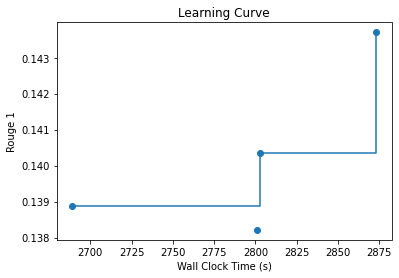

In [11]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()